In [1]:
import pandas as pd
import MFLibrary as mf
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# gameid has bad data == 253240066 253510006 260692440 283190221 283192166 283190201 293170264 283342390 293172633
#team 1 is the away team
# 0.25, 0.5, 0.75,
quants = [0.05, 0.95]

In [2]:
# conn = sqlite3.connect('C:\Dropbox\Dropbox\HAXz\CBBTO\cbb.db')
# curr = conn.cursor()
# result = curr.execute("SELECT DISTINCT gameid FROM playbyplay where gameid != '253240066'")

# gameids = []
# for elem in result:
#     gameids.append(elem[0])
    
# conn.close()

In [3]:
conn = sqlite3.connect('C:\Dropbox\Dropbox\HAXz\CBBTO\cbb.db')
curr = conn.cursor()
# Exclude free throws (give inf deltaScore will still be accounted for in runs) and bad data
# end of halfs/OT (time < 90) handled elsewhere because we want to ensure that periods are ended to the best of our abilities (could be problematic in OT)
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE event like '% made %'
                        AND event not like '%Free Throw%'
                        AND gameid not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633')""", conn)
conn.close()

data = data.apply(pd.to_numeric,errors='ignore')
data.head()

rowid     gameid                                      event team1 team2  \
0      7  253130183  Demetris Nichols made Three Point Jumper.   COR   SYR   
1     29  253130183      Louie McCroskey made Two Point Layup.   COR   SYR   
2     34  253130183       Darryl Watkins made Two Point Layup.   COR   SYR   
3     65  253130183           Adam Gore made Two Point Jumper.   COR   SYR   
4     66  253130183      Darryl Watkins made Two Point Jumper.   COR   SYR   

   score1  score2  time  
0       0       3  1157  
1       0       5  1036  
2       0       7   988  
3       4      11   814  
4       4      13   785

In [4]:
# Add each half/ot to periods list
# TODO: Remove game selection. Period splitting should work just as well between games as between halves.
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():   
    time = row['time']     
    if time > lasttime:
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time

#Add the last period     
periods.append(data[lastindex:i])


In [12]:
diffs = []
for period in periods:
    
    # Running history of score difference
    period['scorediffdelta'] = period['score1'] -period['score2']
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    # Get delta time and delta score difference
    diff = period[['time','scorediffdelta']].diff(2)
    # Keep data
    diff['rowid'] = period['rowid']
    diff['gameid'] = period['gameid']
    diff['event'] = period['event']
    diff['scorediff'] = period['score1'] - period['score2']
    diff['timedelta'] = -diff['time']
    diff['time'] = period['time']
    diff['normedscorediffdelta'] = 60 * diff['scorediffdelta'] / diff['timedelta']
    
    diff = diff.replace([np.inf, -np.inf], np.nan)
    diff = diff[['rowid','gameid','event','scorediff','time','timedelta','scorediffdelta','normedscorediffdelta']].dropna()
    diffs.append(diff)
    
result = pd.concat(diffs)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0    -3
1    -5
2    -7
3    -7
4    -9
5    -6
6    -3
7    -5
8    -7
9    -5
10   -2
11   -4
12   -2
13    1
14   -1
15    1
16   -4
17   -6
18   -6
19   -9
Name: scorediffdelta, dtype: int64
20   -9
21   -7
22   -4
23   -2
24   -4
25   -6
26   -3
27   -5
28   -2
29    1
30    4
31    5
32    3
33    5
34    3
35    2
36    2
37    0
38   -4
39   -2
40   -4
41   -4
Name: scorediffdelta, dtype: int64
42    -3
43    -6
44    -4
45    -1
46    -4
47    -6
48    -4
49    -7
50    -4
51    -6
52    -8
53   -10
54   -15
55   -13
56   -15
57   -15
58   -17
59   -17
60   -19
Name: scorediffdelta, dtype: int64
61   -17
62   -19
63   -20
64   -24
65   -22
66   -20
67   -18
68   -22
69   -24
70   -21
71   -23
72   -21
73   -19
74   -21
75   -25
76   -25
77   -27
Name: scorediffdelta, dtype: int64
78      2
79      4
80      2
81      4
82      6
83      4
84      6
85      6
86      4
87      2
88      4
89      6
90      4
91      2
92      4
93      2
94      1
95     -3
96     -3
97     -5


778    -4
779    -2
780    -4
781    -2
782    -5
783    -3
784    -6
785    -4
786    -6
787    -4
788    -6
789    -7
790    -9
791   -11
792   -14
793   -16
794   -14
795   -19
796   -17
797   -20
798   -24
799   -22
800   -24
801   -26
802   -24
803   -26
804   -28
805   -26
806   -30
807   -32
808   -29
809   -31
810   -28
811   -31
812   -34
Name: scorediffdelta, dtype: int64
813   -32
814   -30
815   -32
816   -30
817   -34
818   -36
819   -34
820   -37
821   -37
822   -40
823   -40
824   -43
825   -45
826   -42
827   -39
828   -37
829   -37
830   -35
831   -37
832   -40
833   -37
834   -39
835   -36
836   -38
837   -35
838   -37
839   -39
840   -41
841   -44
842   -47
Name: scorediffdelta, dtype: int64
843     2
844     4
845     6
846     8
847     5
848     3
849     5
850     2
851     5
852     3
853     0
854     2
855     2
856     4
857     7
858     5
859     6
860     4
861     6
862     8
863    10
Name: scorediffdelta, dtype: int64
864     8
865     6
866     4
867  

1512   -3
1513   -1
1514   -3
1515   -3
1516   -1
1517    0
1518    0
1519   -2
1520    0
1521   -2
1522   -4
1523   -3
1524   -1
1525   -3
1526   -5
1527   -5
1528   -3
1529   -1
1530   -4
1531   -2
1532   -2
Name: scorediffdelta, dtype: int64
1533     2
1534    -1
1535    -3
1536    -5
1537    -3
1538     0
1539     2
1540    -4
1541    -6
1542    -4
1543    -2
1544    -4
1545    -6
1546    -3
1547    -1
1548    -4
1549    -5
1550    -8
1551   -11
1552   -15
Name: scorediffdelta, dtype: int64
1553   -17
1554   -15
1555   -13
1556   -11
1557   -13
1558   -15
1559   -17
1560   -15
1561   -17
1562   -19
1563   -17
1564   -20
1565   -20
1566   -22
1567   -24
1568   -24
1569   -28
1570   -26
1571   -28
1572   -30
1573   -32
1574   -36
1575   -33
1576   -36
1577   -34
1578   -31
1579   -33
Name: scorediffdelta, dtype: int64
1580    -2
1581     0
1582    -3
1583    -1
1584    -3
1585    -5
1586    -7
1587    -9
1588   -11
1589    -9
1590   -11
1591    -9
1592    -7
1593    -9
1594    -4
159

2238    -6
2239    -8
2240   -10
2241    -8
2242   -10
2243   -12
2244   -14
2245   -12
2246   -11
2247    -9
2248   -11
2249    -9
2250   -11
2251    -9
2252   -12
2253    -9
2254   -11
2255   -14
2256   -18
2257   -21
2258   -19
2259   -19
2260   -16
2261   -18
2262   -20
2263   -18
2264   -16
2265   -14
Name: scorediffdelta, dtype: int64
2266    -2
2267     1
2268    -1
2269    -3
2270    -1
2271     1
2272    -1
2273    -4
2274    -6
2275    -5
2276    -3
2277    -5
2278    -2
2279     0
2280    -1
2281    -3
2282    -7
2283    -4
2284    -6
2285    -9
2286   -11
2287    -9
2288    -7
2289    -7
2290    -5
2291    -9
2292    -8
2293   -10
2294    -7
2295    -9
2296    -7
2297    -8
2298   -10
Name: scorediffdelta, dtype: int64
2299   -14
2300   -17
2301   -15
2302   -21
2303   -21
2304   -25
2305   -23
2306   -25
2307   -27
2308   -25
2309   -28
2310   -26
2311   -22
2312   -24
2313   -22
2314   -20
2315   -19
2316   -19
2317   -21
2318   -18
2319   -20
2320   -22
2321   -22
2322  

2919     2
2920     4
2921     2
2922     0
2923    -2
2924     0
2925    -2
2926     0
2927     2
2928     0
2929     1
2930     4
2931     2
2932     0
2933    -4
2934    -6
2935    -4
2936    -6
2937    -8
2938    -4
2939    -6
2940    -9
2941   -14
Name: scorediffdelta, dtype: int64
2942   -18
2943   -16
2944   -17
2945   -15
2946   -17
2947   -14
2948   -11
2949   -14
2950   -11
2951   -13
2952   -11
2953   -13
2954   -15
2955   -13
2956   -15
2957   -14
2958   -12
2959   -10
2960    -7
2961    -5
2962    -2
2963     2
Name: scorediffdelta, dtype: int64
2964   -2
2965    0
2966   -3
2967   -1
2968    0
2969   -2
2970   -1
Name: scorediffdelta, dtype: int64
2971    2
2972    4
2973    2
2974    4
2975    2
2976    2
2977    2
2978    4
2979    5
2980    2
2981    4
2982    3
2983    3
2984    6
2985    7
2986    4
2987    1
2988    3
2989    6
2990    7
2991    8
2992    7
2993    9
2994    7
Name: scorediffdelta, dtype: int64
2995     9
2996     7
2997     6
2998     8
2999     6


3600    -8
3601   -11
3602   -14
3603   -12
3604   -14
3605   -16
3606   -13
3607   -11
3608   -12
3609   -15
3610   -16
3611   -14
3612   -13
3613    -9
3614   -12
3615    -9
3616   -13
3617   -11
3618   -14
3619   -16
3620   -14
3621   -17
3622   -20
3623   -22
3624   -19
3625   -17
Name: scorediffdelta, dtype: int64
3626    -2
3627     0
3628    -2
3629     0
3630    -2
3631     2
3632     4
3633     6
3634     4
3635     6
3636     4
3637     2
3638     4
3639     6
3640     4
3641     6
3642     3
3643     1
3644     3
3645     5
3646     7
3647     6
3648     5
3649     8
3650     8
3651    10
3652     8
Name: scorediffdelta, dtype: int64
3653    5
3654    7
3655    5
3656    3
3657    3
3658    5
3659    7
3660    5
3661    1
3662    4
3663    6
3664    4
3665    6
3666    4
3667    2
3668    0
3669   -2
3670    1
3671   -1
3672   -1
3673    4
3674    3
3675    2
3676    1
Name: scorediffdelta, dtype: int64
3677    -2
3678    -5
3679    -7
3680    -4
3681    -7
3682    -7
3683  

4324    -6
4325    -8
4326   -10
4327    -8
4328   -10
4329    -8
4330    -9
4331    -7
4332    -9
4333    -8
4334   -10
4335    -8
4336    -4
4337    -2
4338     0
4339    -2
4340     0
4341     2
4342     4
4343     4
4344     0
4345     2
4346    -1
4347     1
4348    -2
4349     0
4350     2
4351     0
4352    -2
4353     0
4354    -2
4355     0
4356     0
4357     2
4358     0
4359    -2
4360    -1
Name: scorediffdelta, dtype: int64
4361   -2
4362    1
4363    3
4364    1
4365   -1
4366   -4
4367   -3
4368   -5
4369   -3
4370   -5
4371   -2
4372   -4
4373   -2
4374    0
4375   -1
4376    1
4377    4
4378    1
4379   -2
4380   -4
4381   -1
4382    2
4383    5
4384    3
4385    5
4386    3
4387    5
Name: scorediffdelta, dtype: int64
4388     7
4389     9
4390    11
4391     8
4392     4
4393     4
4394     2
4395    -1
4396    -3
4397    -5
4398    -2
4399    -4
4400    -2
4401    -4
4402    -7
4403    -4
4404    -6
4405    -8
4406   -10
4407   -11
4408    -9
4409    -4
4410    -2


5027   -14
5028   -16
5029   -18
5030   -20
5031   -22
5032   -26
5033   -24
5034   -26
5035   -29
5036   -26
5037   -28
5038   -30
5039   -32
5040   -30
5041   -32
5042   -34
5043   -32
5044   -34
5045   -39
5046   -37
5047   -39
5048   -40
5049   -38
5050   -35
5051   -37
5052   -35
5053   -33
Name: scorediffdelta, dtype: int64
5054    -2
5055    -4
5056    -6
5057    -5
5058    -3
5059    -5
5060    -8
5061   -11
5062   -14
5063   -17
5064   -19
5065   -17
5066   -15
5067   -18
5068   -16
5069   -14
5070   -16
5071   -18
5072   -16
5073   -18
5074   -16
5075   -18
5076   -21
5077   -24
5078   -22
5079   -24
5080   -20
5081   -20
5082   -22
5083   -20
Name: scorediffdelta, dtype: int64
5084   -24
5085   -26
5086   -31
5087   -29
5088   -27
5089   -29
5090   -31
5091   -29
5092   -31
5093   -33
5094   -35
5095   -33
5096   -35
5097   -33
5098   -37
5099   -34
5100   -34
5101   -32
5102   -33
5103   -33
5104   -35
5105   -36
5106   -34
5107   -36
Name: scorediffdelta, dtype: int64
5108

5737     2
5738     2
5739     4
5740     2
5741     4
5742     6
5743     4
5744     6
5745     9
5746     7
5747     9
5748    11
5749    13
5750    15
5751    12
5752    14
5753    17
5754    15
5755    18
5756    16
5757    18
5758    21
Name: scorediffdelta, dtype: int64
5759    16
5760    13
5761    15
5762    18
5763    16
5764    13
5765    14
5766    16
5767    18
5768    16
5769    19
5770    17
5771    21
5772    22
5773    22
5774    24
5775    21
5776    23
5777    26
5778    24
5779    27
5780    31
5781    29
5782    27
5783    29
5784    31
5785    30
5786    32
5787    29
5788    31
5789    29
5790    31
Name: scorediffdelta, dtype: int64
5791     1
5792     0
5793     2
5794     4
5795     6
5796     4
5797     2
5798     5
5799     3
5800     3
5801     1
5802    -2
5803     0
5804     2
5805     4
5806     2
5807     4
5808     1
5809     2
5810     4
5811     4
5812     6
5813     6
5814     8
5815    10
Name: scorediffdelta, dtype: int64
5816    12
5817     8
5818

6418   -11
6419   -14
6420   -15
6421   -18
6422   -20
6423   -22
6424   -20
6425   -20
6426   -22
6427   -19
6428   -21
6429   -18
6430   -15
6431   -17
6432   -19
6433   -16
6434   -14
6435   -15
6436   -14
6437   -16
6438   -19
6439   -16
6440   -18
6441   -16
6442   -14
Name: scorediffdelta, dtype: int64
6443    -2
6444    -2
6445     1
6446    -1
6447     1
6448    -1
6449     2
6450     0
6451    -2
6452     0
6453     2
6454     0
6455     3
6456     1
6457     3
6458     5
6459     3
6460     7
6461     6
6462     8
6463     6
6464     8
6465    11
6466    13
6467    16
6468    14
6469    16
6470    19
6471    20
6472    17
Name: scorediffdelta, dtype: int64
6473    15
6474    18
6475    15
6476    12
6477    15
6478    12
6479    11
6480     8
6481     6
6482     7
6483     5
6484     7
6485     4
6486     1
6487     3
6488     0
6489     2
6490     0
6491     2
6492     1
6493    -1
6494     2
Name: scorediffdelta, dtype: int64
6495    -2
6496    -4
6497    -2
6498    -4
6499

7129   -29
7130   -31
7131   -31
7132   -29
7133   -31
7134   -33
7135   -31
7136   -31
7137   -29
7138   -29
7139   -31
7140   -33
7141   -31
7142   -34
7143   -34
7144   -38
7145   -40
7146   -43
7147   -46
7148   -44
7149   -42
Name: scorediffdelta, dtype: int64
7150     2
7151    -1
7152     1
7153    -3
7154    -1
7155    -3
7156    -7
7157    -5
7158    -7
7159    -5
7160    -8
7161   -10
7162    -8
7163    -6
7164    -9
7165    -7
7166   -12
7167   -14
7168   -18
7169   -16
7170   -18
7171   -16
7172   -19
7173   -16
7174   -14
7175   -12
7176   -12
7177   -15
7178   -17
7179   -15
7180   -17
7181   -15
7182   -13
7183   -14
7184   -11
7185    -9
Name: scorediffdelta, dtype: int64
7186   -11
7187   -13
7188   -13
7189   -16
7190   -14
7191   -18
7192   -20
7193   -18
7194   -20
7195   -20
7196   -21
7197   -18
7198   -20
7199   -18
7200   -16
7201   -19
7202   -22
7203   -20
7204   -22
7205   -22
7206   -24
7207   -22
7208   -24
7209   -25
7210   -24
7211   -24
7212   -26
7213  

7811   -11
7812    -9
7813   -12
7814   -10
7815   -13
7816   -15
7817   -13
7818   -15
7819   -17
7820   -19
7821   -21
7822   -23
7823   -21
7824   -19
7825   -23
7826   -21
7827   -23
7828   -20
7829   -22
7830   -20
7831   -18
7832   -16
7833   -18
7834   -16
7835   -13
Name: scorediffdelta, dtype: int64
7836     2
7837     4
7838     6
7839     4
7840     6
7841     4
7842     6
7843    13
7844    16
7845    15
7846     7
Name: scorediffdelta, dtype: int64
7847     4
7848     7
7849    10
7850    12
7851     9
7852     7
7853     4
7854     3
7855     2
7856     4
7857     0
7858     1
7859     4
7860     3
Name: scorediffdelta, dtype: int64
7861    -3
7862    -6
7863    -9
7864   -11
7865   -13
7866   -11
7867   -13
7868   -10
7869   -12
7870    -9
7871    -7
7872    -8
7873    -9
7874   -12
7875   -10
7876   -12
7877   -20
7878   -22
7879   -19
Name: scorediffdelta, dtype: int64
7880   -17
7881   -20
7882   -18
7883   -23
7884   -25
7885   -27
7886   -26
7887   -24
7888   -26
78

8520   -7
8521   -9
8522   -7
8523   -8
8524   -6
8525   -8
8526   -5
8527   -2
8528   -4
8529   -2
8530   -4
8531   -2
8532   -4
8533   -2
8534   -4
8535   -2
8536    1
8537   -1
8538    1
8539    1
8540   -1
8541    3
8542    1
8543   -2
8544    0
8545   -3
Name: scorediffdelta, dtype: int64
8546     2
8547     0
8548     3
8549     6
8550     2
8551     4
8552     1
8553    -1
8554    -3
8555    -5
8556    -3
8557    -5
8558    -5
8559    -2
8560    -5
8561    -3
8562    -6
8563    -9
8564    -7
8565   -10
8566    -7
Name: scorediffdelta, dtype: int64
8567    -8
8568   -10
8569   -10
8570    -8
8571    -6
8572    -8
8573    -5
8574    -7
8575   -11
8576    -8
8577   -10
8578    -8
8579    -6
8580    -5
8581    -5
Name: scorediffdelta, dtype: int64
8582    -2
8583    -6
8584    -3
8585    -5
8586    -5
8587    -3
8588    -5
8589    -6
8590    -3
8591    -5
8592    -8
8593    -6
8594    -8
8595    -9
8596    -9
8597    -7
8598    -9
8599   -11
8600   -13
8601   -11
Name: scorediffdelt

9239    13
9240    14
9241    12
9242    14
9243    12
9244    14
9245    15
9246    18
9247    19
9248    17
9249    16
9250    16
9251    17
9252    19
9253    17
9254    18
9255    16
9256    19
Name: scorediffdelta, dtype: int64
9257    2
9258    4
9259    1
9260    3
9261    5
9262    2
9263    2
9264    4
9265    1
9266   -1
9267    1
9268    4
9269    1
9270   -2
9271    1
9272    4
9273    7
9274    4
9275    4
9276    7
9277    7
9278    9
9279    7
9280    5
9281    2
9282    5
9283    3
9284    3
Name: scorediffdelta, dtype: int64
9285    5
9286    3
9287    5
9288    7
9289    9
9290    7
9291    6
9292    4
9293    6
9294    9
9295    7
9296    5
9297    3
9298    4
9299    1
9300    3
9301    2
9302    0
9303   -3
9304   -6
9305   -8
Name: scorediffdelta, dtype: int64
9306     2
9307     0
9308     2
9309    -1
9310     2
9311     2
9312    -1
9313    -2
9314    -4
9315    -9
9316   -11
9317    -8
9318    -8
9319   -10
9320    -7
9321    -9
9322    -7
9323   -10
Name: sco

9927    -9
9928    -6
9929    -8
9930    -5
9931    -7
9932    -5
9933    -7
9934    -9
9935   -11
9936    -9
9937    -7
9938    -9
9939    -6
9940    -6
9941    -3
9942     1
9943    -1
9944     1
9945    -1
9946    -3
9947    -1
9948     0
9949    -2
Name: scorediffdelta, dtype: int64
9950   -2
9951    1
9952   -1
9953    2
9954   -1
9955   -3
9956   -5
9957   -2
9958   -5
9959   -3
9960   -2
9961   -5
9962   -7
9963   -5
9964   -3
9965   -5
9966   -3
9967   -1
Name: scorediffdelta, dtype: int64
9968   -3
9969   -2
9970    1
9971   -1
9972   -3
9973   -1
9974    1
9975   -2
9976    0
9977   -3
9978    0
9979   -2
9980    0
9981    2
9982    1
9983    2
9984    0
Name: scorediffdelta, dtype: int64
9985     2
9986     0
9987    -3
9988    -1
9989    -4
9990    -3
9991    -5
9992    -7
9993    -5
9994    -7
9995    -5
9996    -2
9997    -4
9998    -3
9999    -7
10000   -4
10001   -2
10002    0
Name: scorediffdelta, dtype: int64
10003    2
10004   -1
10005    2
10006    4
10007    1
1000

10576    14
10577    10
10578    13
10579    11
10580    14
10581    16
10582    14
10583    12
10584    14
10585    12
10586    17
10587    18
10588    18
10589    16
10590    18
10591    21
10592    16
10593    20
10594    20
Name: scorediffdelta, dtype: int64
10595     3
10596     0
10597     3
10598     6
10599     9
10600    11
10601     9
10602    11
10603     7
10604     9
10605     9
10606    12
10607    10
10608    13
10609    15
10610    11
10611    13
10612    11
10613     8
Name: scorediffdelta, dtype: int64
10614     8
10615     6
10616     3
10617     1
10618     5
10619    -1
10620     3
10621     6
10622     9
10623    11
10624    13
10625    15
10626    12
10627    15
Name: scorediffdelta, dtype: int64
10628     2
10629     4
10630     6
10631     6
10632     4
10633     7
10634     5
10635    10
10636    12
10637     9
10638     9
10639     9
10640    12
10641    13
10642    15
10643    13
10644    16
10645    16
10646    19
10647    17
10648    16
10649    14
10650  

11234   -20
11235   -22
11236   -25
11237   -26
11238   -28
11239   -30
11240   -27
11241   -25
11242   -26
11243   -28
11244   -24
11245   -26
11246   -28
11247   -30
11248   -32
11249   -30
11250   -27
11251   -29
11252   -26
11253   -28
11254   -26
11255   -29
11256   -27
Name: scorediffdelta, dtype: int64
11257   -2
11258    3
11259    5
11260    3
11261    5
11262    3
11263    1
11264   -1
11265   -3
11266   -1
11267    0
11268   -2
11269   -4
11270   -2
11271   -2
11272   -4
11273   -6
11274   -4
11275   -6
Name: scorediffdelta, dtype: int64
11276   -6
11277   -3
11278   -4
11279   -2
11280   -4
11281   -2
11282   -4
11283   -1
11284   -4
11285   -2
11286    2
11287    1
11288    3
11289    1
11290    3
11291    5
11292    3
11293    2
11294    1
11295    2
11296    0
11297    2
11298   -1
11299    1
Name: scorediffdelta, dtype: int64
11300     3
11301     7
11302     4
11303     6
11304     8
11305     6
11306     4
11307     2
11308     5
11309     2
11310     2
11311     5
11

11898   -5
11899   -8
11900   -6
11901   -7
11902   -5
11903   -3
11904   -5
11905   -3
11906   -5
11907   -8
11908   -5
11909   -3
11910   -5
11911   -3
11912    1
11913   -2
11914   -2
11915    0
11916   -3
11917   -1
11918   -1
11919   -3
11920   -1
Name: scorediffdelta, dtype: int64
11921    2
11922   -1
11923   -3
11924   -5
11925   -7
11926   -4
11927   -6
11928   -8
11929   -6
11930   -8
11931   -6
11932   -4
11933   -7
11934   -2
11935   -5
11936   -3
11937   -2
11938    1
11939   -2
11940   -4
11941    0
11942    0
11943   -2
Name: scorediffdelta, dtype: int64
11944    -4
11945    -2
11946    -4
11947    -4
11948    -6
11949    -7
11950    -9
11951   -11
11952    -9
11953    -6
11954    -9
11955   -11
11956   -13
11957   -16
11958   -13
11959   -10
11960    -9
11961   -11
11962   -11
11963   -13
11964   -16
11965   -13
11966   -15
11967   -12
11968   -14
11969   -11
Name: scorediffdelta, dtype: int64
11970     3
11971     5
11972     3
11973     5
11974     2
11975     6
11976

12557    2
12558   -1
12559   -3
12560   -1
12561   -3
12562   -1
12563   -3
12564    0
12565   -2
12566   -4
12567   -3
12568   -5
12569   -2
12570    0
12571    3
12572    1
12573    3
12574    1
12575    4
12576    2
12577    1
12578    4
12579    2
12580    2
Name: scorediffdelta, dtype: int64
12581    -5
12582    -7
12583    -7
12584    -5
12585    -7
12586    -5
12587    -8
12588    -8
12589   -11
12590    -8
12591   -11
12592   -13
12593   -15
12594   -13
12595   -11
12596   -14
12597   -11
12598   -13
12599   -15
12600   -13
12601   -16
12602   -19
12603   -17
12604   -20
Name: scorediffdelta, dtype: int64
12605   -25
12606   -24
12607   -21
12608   -22
12609   -17
12610   -19
12611   -17
12612   -19
12613   -17
12614   -21
12615   -19
12616   -18
12617   -16
12618   -19
12619   -21
12620   -25
12621   -24
12622   -26
12623   -25
12624   -27
12625   -24
Name: scorediffdelta, dtype: int64
12626    2
12627    0
12628    2
12629    0
12630    3
12631    0
12632    2
12633    0
126

13201     0
13202     2
13203    -1
13204     1
13205     1
13206    -1
13207    -3
13208     0
13209    -4
13210    -5
13211    -4
13212    -6
13213    -8
13214   -10
13215    -8
13216   -10
13217    -8
13218    -9
13219    -7
13220    -7
13221    -7
13222    -5
13223    -7
13224    -5
13225    -7
13226    -4
Name: scorediffdelta, dtype: int64
13227    -2
13228     0
13229    -2
13230     0
13231    -2
13232     0
13233    -3
13234    -1
13235    -4
13236    -6
13237    -4
13238    -6
13239    -6
13240    -4
13241    -6
13242    -4
13243    -7
13244    -5
13245    -7
13246    -4
13247    -7
13248    -9
13249   -12
Name: scorediffdelta, dtype: int64
13250   -10
13251   -12
13252   -10
13253    -8
13254   -11
13255   -13
13256   -11
13257   -13
13258   -16
13259   -17
13260   -15
13261   -12
13262   -14
13263   -16
13264   -15
13265   -17
13266   -19
13267   -17
13268   -15
13269   -13
13270   -11
13271   -14
13272   -18
13273   -16
Name: scorediffdelta, dtype: int64
13274    -2
13275  

13837    6
13838    4
13839    6
13840    4
13841    2
13842    4
13843    6
13844    4
13845    1
13846   -1
13847   -3
13848    0
13849   -3
13850   -3
13851   -5
13852   -4
13853    3
13854    1
13855    3
13856    1
13857   -1
13858    2
13859   -1
13860    1
13861    0
13862   -2
Name: scorediffdelta, dtype: int64
13863   -2
13864    0
13865   -2
13866    0
13867    2
13868    1
13869    2
13870    5
13871    3
13872    3
13873    1
13874   -1
13875   -3
13876   -3
13877   -1
13878   -3
13879   -1
13880   -3
13881   -1
13882    0
13883   -2
13884    0
13885   -2
13886    0
13887   -1
13888    1
13889   -1
13890    2
13891   -1
Name: scorediffdelta, dtype: int64
13892    -2
13893    -4
13894    -3
13895    -1
13896    -3
13897    -1
13898    -3
13899    -5
13900    -3
13901    -5
13902    -7
13903    -4
13904    -6
13905    -8
13906   -10
13907    -8
13908   -10
13909   -12
13910    -9
13911    -7
13912   -10
13913    -8
13914    -7
13915    -9
13916    -6
13917    -6
13918    -6
1

14468    2
14469    0
14470    2
14471    4
14472    6
14473    4
14474    5
14475    7
14476    5
14477    4
14478    2
14479    4
14480    2
14481    5
14482    3
14483    4
14484    6
14485    8
14486    6
14487    8
14488    5
14489    8
14490    5
14491   -1
14492    1
14493    4
14494    1
14495    3
14496    6
14497    8
Name: scorediffdelta, dtype: int64
14498    5
14499    8
14500    6
14501    3
14502    1
14503    4
14504    6
14505    3
14506    5
14507    3
14508    1
14509    3
14510    5
14511    2
14512    4
14513    0
14514   -1
14515    1
14516   -1
14517    1
14518   -1
14519   -2
14520    0
14521   -3
14522   -1
14523   -3
14524   -1
14525   -2
Name: scorediffdelta, dtype: int64
14526    -3
14527    -7
14528   -10
14529   -12
14530    -8
14531   -10
14532   -13
14533   -16
14534   -14
14535   -17
14536   -15
14537   -18
14538   -17
14539   -15
14540   -17
14541   -20
14542   -18
14543   -20
14544   -18
14545   -20
14546   -23
14547   -23
Name: scorediffdelta, dtype:

15097    -1
15098    -3
15099    -5
15100    -3
15101    -5
15102    -8
15103   -10
15104    -8
15105    -5
15106    -3
15107     0
15108    -1
15109    -4
15110    -2
15111     0
15112    -2
15113     1
15114    -1
15115    -4
15116    -7
15117    -5
15118    -9
15119    -6
15120    -9
15121    -7
15122   -10
15123    -8
15124    -9
15125    -8
Name: scorediffdelta, dtype: int64
15126    3
15127    6
15128    4
15129    6
15130    4
15131    1
15132   -2
15133   -4
15134   -2
15135    1
15136   -1
15137    2
15138    1
15139   -2
15140    1
15141   -1
15142   -3
15143   -3
15144   -5
15145   -2
15146   -3
15147   -5
15148   -3
15149   -3
15150   -6
15151   -3
15152   -5
15153   -3
Name: scorediffdelta, dtype: int64
15154    -6
15155    -8
15156    -6
15157    -8
15158    -8
15159   -12
15160   -10
15161   -12
15162   -10
15163   -12
15164   -15
15165   -15
15166   -15
15167   -12
15168   -10
15169    -7
15170    -9
15171    -6
15172    -8
15173    -8
15174   -11
15175    -9
15176    -

15760   -3
15761   -6
15762   -3
15763   -1
15764   -3
15765   -4
15766   -7
15767   -4
15768   -6
15769   -4
15770   -1
15771   -3
15772    0
15773   -2
15774    0
15775    2
15776    4
15777    2
15778    4
15779    2
15780    5
15781    6
15782    2
Name: scorediffdelta, dtype: int64
15783   -2
15784    0
15785    2
15786    0
15787   -2
15788    2
15789   -1
15790   -2
15791   -3
15792   -5
15793   -7
15794   -5
15795   -2
15796   -5
Name: scorediffdelta, dtype: int64
15797   -3
15798   -6
15799   -3
15800   -6
15801   -4
15802   -6
15803   -5
15804   -5
15805   -3
15806   -1
15807    1
15808    3
15809    1
15810    4
15811    1
15812   -2
15813   -4
15814   -2
15815    1
Name: scorediffdelta, dtype: int64
15816    -2
15817    -4
15818    -2
15819    -4
15820    -2
15821    -4
15822    -7
15823    -5
15824    -2
15825    -4
15826    -6
15827    -8
15828    -9
15829   -11
15830    -8
15831    -6
15832    -3
15833    -5
15834    -3
15835    -6
15836    -5
15837    -8
15838   -10
158

16382    -2
16383     1
16384     4
16385     9
16386    11
16387    14
16388    16
16389    14
16390    16
16391    19
16392    17
16393    14
16394    16
16395    14
16396    16
16397    14
16398    16
16399    13
16400    16
Name: scorediffdelta, dtype: int64
16401    18
16402    15
16403    13
16404    14
16405    17
16406    15
16407    17
16408    17
16409    15
16410    13
16411    16
16412    18
16413    20
16414    22
16415    20
16416    21
16417    18
16418    16
16419    18
16420    20
16421    19
16422    20
Name: scorediffdelta, dtype: int64
16423     2
16424     2
16425     1
16426     4
16427     2
16428     4
16429     2
16430     0
16431     0
16432     3
16433     5
16434     6
16435     4
16436     6
16437     4
16438     2
16439     3
16440     1
16441     6
16442     4
16443     7
16444    10
16445     7
Name: scorediffdelta, dtype: int64
16446     5
16447     7
16448     9
16449     7
16450     9
16451    11
16452     8
16453     6
16454     8
16455    11
16456  

17025   -10
17026    -7
17027    -9
17028    -7
17029    -5
17030    -8
17031   -10
17032   -13
17033   -10
17034   -12
17035   -14
17036   -17
17037   -19
17038   -17
17039   -19
17040   -17
17041   -15
17042   -13
17043   -15
17044   -13
17045   -14
17046   -15
17047   -16
17048   -18
17049   -21
17050   -21
17051   -18
Name: scorediffdelta, dtype: int64
17052    -2
17053     0
17054     2
17055     0
17056     2
17057     0
17058     1
17059    -1
17060     1
17061     3
17062     1
17063     3
17064     6
17065     4
17066     6
17067     9
17068     7
17069     9
17070     7
17071    10
17072     8
17073    10
17074     8
17075    10
17076     8
17077     5
17078     7
17079     5
17080     3
Name: scorediffdelta, dtype: int64
17081     1
17082     3
17083     1
17084     3
17085     1
17086     0
17087    -3
17088    -6
17089    -8
17090    -6
17091   -11
17092    -9
17093   -13
17094   -15
17095   -13
17096   -14
17097   -20
17098   -22
17099   -20
17100   -22
17101   -20
17102 

17679     6
17680     3
17681     6
17682     4
17683     6
17684     9
17685    11
17686    13
17687    16
17688    13
17689    17
17690    14
17691    12
17692     8
17693     3
17694     3
17695     1
17696     1
17697     0
17698     2
Name: scorediffdelta, dtype: int64
17699    -2
17700     0
17701     2
17702     0
17703     2
17704     0
17705     3
17706     1
17707     4
17708     2
17709     0
17710     3
17711     5
17712     7
17713     8
17714     5
17715     8
17716    11
17717     9
17718    12
17719    10
17720    13
17721    13
17722    11
Name: scorediffdelta, dtype: int64
17723     9
17724    11
17725    10
17726     8
17727    11
17728    13
17729    10
17730    12
17731    10
17732    12
17733    14
17734    18
17735    16
17736    14
17737    16
17738    14
17739    13
17740    11
17741    11
17742     7
17743     6
17744     5
17745     2
Name: scorediffdelta, dtype: int64
17746     1
17747    -1
17748     2
17749    -1
17750    -4
17751    -2
17752    -5
17753  

18306   -5
18307   -3
18308   -2
18309    0
18310   -2
18311   -4
18312   -4
18313   -6
18314   -4
18315   -2
18316   -5
18317   -3
18318   -3
18319   -4
18320   -6
18321   -3
18322   -1
18323   -4
18324   -1
18325    1
18326    3
18327    1
18328   -2
18329    0
18330    2
18331    4
18332    2
18333    0
18334   -2
18335   -4
18336   -2
Name: scorediffdelta, dtype: int64
18337    -2
18338    -4
18339    -2
18340    -3
18341    -5
18342    -7
18343    -5
18344    -6
18345    -3
18346    -6
18347    -4
18348    -6
18349    -3
18350    -5
18351    -7
18352    -6
18353    -8
18354    -6
18355    -8
18356    -8
18357    -7
18358    -9
18359   -11
18360    -9
Name: scorediffdelta, dtype: int64
18361   -11
18362    -8
18363   -10
18364    -8
18365    -6
18366    -9
18367    -6
18368    -9
18369    -7
18370    -5
18371    -7
18372    -4
18373    -2
18374     2
18375     4
18376     2
18377     1
18378     3
18379     1
18380     4
18381     1
18382     4
18383     2
18384     5
18385     8
1

19014    -3
19015    -1
19016    -3
19017    -1
19018    -3
19019    -5
19020    -7
19021    -9
19022   -13
19023   -15
19024   -17
19025   -14
19026   -16
19027   -13
19028   -11
19029   -12
19030   -16
19031   -13
19032   -15
19033   -12
19034   -15
19035   -17
19036   -14
19037   -16
19038   -19
19039   -20
19040   -22
19041   -19
Name: scorediffdelta, dtype: int64
19042   -17
19043   -15
19044   -14
19045   -16
19046   -18
19047   -16
19048   -13
19049   -15
19050   -13
19051   -16
19052   -17
19053   -15
19054   -17
19055   -19
19056   -17
19057   -19
19058   -21
19059   -18
19060   -15
19061   -17
19062   -15
19063   -12
19064   -14
19065   -17
19066   -20
19067   -22
19068   -19
19069   -17
19070   -13
19071   -13
19072   -14
Name: scorediffdelta, dtype: int64
19073   -2
19074    0
19075    2
19076   -1
19077   -3
19078   -1
19079   -1
19080   -3
19081    0
19082   -2
19083   -2
19084    1
19085   -1
19086    1
19087   -1
19088    1
19089   -1
19090   -1
19091    2
19092    0
19

19674    2
19675    6
19676    4
19677    2
19678    5
19679    2
19680   -1
19681    1
19682   -1
19683    1
19684   -2
19685    0
19686    3
19687    6
19688    3
Name: scorediffdelta, dtype: int64
19689    6
19690    3
19691    5
19692    7
19693    7
19694    6
19695    3
19696    5
19697    3
19698    6
19699    5
19700    4
19701    1
19702    1
19703    0
Name: scorediffdelta, dtype: int64
19704     2
19705     4
19706     7
19707     9
19708    11
19709    13
19710    12
19711    14
19712    14
19713    12
19714    12
19715    10
19716    12
19717    14
19718    12
19719    14
Name: scorediffdelta, dtype: int64
19720    12
19721    14
19722    16
19723    14
19724    12
19725    14
19726    16
19727    18
19728    16
19729    18
19730    14
19731    16
19732    15
19733    17
19734    17
19735    20
19736    18
Name: scorediffdelta, dtype: int64
19737    -2
19738    -3
19739    -5
19740    -8
19741    -9
19742   -11
19743    -9
19744    -9
19745   -10
19746   -12
19747   -12
19

20381     6
20382     3
20383     5
20384     3
20385     6
20386    10
20387     7
20388     9
20389     7
20390    10
20391     8
20392     5
20393     7
20394     5
20395     2
20396     5
20397     7
20398     7
20399     9
20400     5
20401     7
20402     2
20403    -1
20404    -3
20405    -1
20406    -3
Name: scorediffdelta, dtype: int64
20407    3
20408    1
20409    3
20410    1
20411    1
20412    4
20413    2
20414    4
20415    2
20416    4
20417    2
20418    0
20419   -2
20420    0
20421   -2
20422    0
20423    2
20424    0
20425    1
20426    4
20427    1
20428    1
20429   -2
20430    1
20431    2
20432    7
20433    5
20434    7
20435    5
Name: scorediffdelta, dtype: int64
20436     7
20437     9
20438     7
20439     9
20440     9
20441    12
20442     8
20443    11
20444     9
20445     7
20446    10
20447    13
20448    14
20449    15
20450    15
20451    13
20452    11
20453     9
20454     8
20455     5
20456     3
20457     3
20458     5
Name: scorediffdelta, d

21035   -2
21036   -4
21037   -1
21038    1
21039   -3
21040    0
21041    2
21042    0
21043   -2
21044    1
21045   -1
21046    2
21047    0
21048    0
21049    2
21050    0
21051   -2
21052    0
21053   -1
21054   -3
21055   -5
21056   -3
21057   -5
21058   -7
21059   -5
21060   -7
21061   -5
21062   -6
Name: scorediffdelta, dtype: int64
21063    -8
21064   -10
21065   -12
21066   -10
21067   -13
21068   -12
21069   -10
21070   -10
21071    -7
21072    -9
21073    -6
21074    -8
21075    -5
21076    -7
21077   -10
21078    -8
21079    -6
21080    -8
21081    -6
21082    -6
21083    -8
21084    -5
Name: scorediffdelta, dtype: int64
21085    2
21086    0
21087    2
21088    4
21089    6
21090    4
21091    7
21092    2
21093    0
21094   -2
21095    0
21096   -2
21097    0
21098   -2
21099   -3
21100   -5
21101   -7
21102   -5
21103   -7
21104   -4
Name: scorediffdelta, dtype: int64
21105    -2
21106    -4
21107    -5
21108    -2
21109     0
21110     2
21111     0
21112    -2
21113  

21716     7
21717     5
21718     8
21719     6
21720     7
21721     5
21722     7
21723     8
21724     5
21725     7
21726     9
21727    11
21728     9
21729    10
21730     8
21731     8
21732    10
21733     7
21734     7
21735     5
21736     5
21737     8
21738     8
21739     6
21740     4
21741     5
Name: scorediffdelta, dtype: int64
21742    -2
21743     0
21744     2
21745    -1
21746     1
21747    -1
21748    -3
21749    -1
21750    -1
21751     1
21752     3
21753     0
21754     3
21755     1
21756     3
21757     6
21758    10
21759     8
21760    10
21761     8
21762    13
21763     9
21764    11
21765     9
Name: scorediffdelta, dtype: int64
21766    7
21767    9
21768    7
21769    9
21770    7
21771    7
21772    9
21773    7
21774    5
21775    7
21776    5
21777    3
21778    5
21779    3
21780    3
21781    1
21782    3
21783    5
21784    3
21785    1
21786    2
21787    4
21788    2
21789    0
21790    0
21791   -3
21792   -4
21793   -5
Name: scorediffdelta, 

22384    -3
22385    -1
22386    -1
22387    -3
22388    -1
22389    -1
22390     2
22391     0
22392    -2
22393     1
22394    -2
22395    -4
22396    -2
22397    -3
22398    -6
22399    -9
22400    -7
22401    -9
22402   -11
22403    -9
22404   -11
22405    -8
22406   -10
22407    -7
22408    -8
22409    -6
22410    -3
22411    -5
22412    -2
Name: scorediffdelta, dtype: int64
22413    -3
22414    -3
22415    -1
22416    -3
22417    -1
22418    -1
22419    -3
22420    -1
22421     1
22422     4
22423     6
22424     9
22425    12
22426    14
22427    15
22428    13
22429    15
22430    17
22431    14
22432    12
22433    14
22434    14
22435    15
22436    17
22437    19
22438    17
22439    15
22440    11
22441    10
22442    10
Name: scorediffdelta, dtype: int64
22443    -2
22444     1
22445    -2
22446     0
22447    -2
22448     0
22449    -2
22450    -4
22451    -2
22452     0
22453     2
22454     4
22455     4
22456     6
22457     4
22458     7
22459     9
22460     6
22461 

23070    2
23071   -1
23072    1
23073    3
23074    6
23075    4
23076    6
23077    4
23078    7
23079    4
23080   -1
23081   -3
23082   -5
23083   -7
23084   -4
23085   -6
23086   -7
23087   -5
23088   -7
23089   -3
23090    0
Name: scorediffdelta, dtype: int64
23091   -3
23092   -6
23093   -3
23094   -2
23095   -3
23096   -5
23097   -2
23098    0
23099    4
23100    2
23101    1
23102   -2
23103   -2
23104   -4
23105   -2
23106    0
23107    2
23108    0
23109    2
23110   -1
23111    2
23112    0
23113    2
23114    3
Name: scorediffdelta, dtype: int64
23115    2
23116    0
23117    2
23118   -1
23119    1
23120   -4
23121   -2
Name: scorediffdelta, dtype: int64
23122    2
23123    0
23124    2
23125    1
23126    3
23127   -1
23128    1
23129    3
23130    0
23131    2
23132   -1
23133    2
23134    0
23135    2
23136    0
23137    3
23138    6
23139    4
23140    2
23141    4
23142    6
23143    4
23144    2
23145    1
23146   -1
23147   -4
23148   -2
23149    0
23150   -3
2315

23741    -3
23742    -6
23743    -9
23744    -7
23745    -9
23746    -7
23747    -5
23748    -2
23749    -1
23750     3
23751     1
23752     3
23753     6
23754     4
23755     2
23756     5
23757     7
23758    10
23759     8
23760    10
23761     8
23762    10
23763    12
23764    10
23765    10
23766     9
23767    11
Name: scorediffdelta, dtype: int64
23768   -2
23769    2
23770    0
23771    2
23772    0
23773   -1
23774   -4
23775   -2
23776   -4
23777   -6
23778   -8
23779   -5
23780   -1
23781   -3
23782   -3
23783   -1
23784   -3
23785   -5
23786   -6
23787   -4
23788   -2
23789   -4
Name: scorediffdelta, dtype: int64
23790    -7
23791    -5
23792    -2
23793     0
23794     2
23795     4
23796     6
23797     1
23798    -1
23799    -3
23800    -5
23801    -7
23802    -4
23803    -6
23804    -8
23805    -9
23806    -6
23807    -8
23808   -10
23809    -8
23810    -9
23811   -11
23812    -8
23813    -7
23814    -4
23815    -6
23816    -4
23817    -3
23818    -5
Name: scorediffd

24449    -2
24450     1
24451    -1
24452    -1
24453     2
24454     0
24455     3
24456     3
24457     0
24458    -2
24459    -5
24460    -3
24461    -5
24462    -5
24463    -3
24464    -6
24465    -8
24466    -6
24467    -8
24468   -10
24469    -7
24470    -5
24471    -2
24472    -5
24473    -3
Name: scorediffdelta, dtype: int64
24474   -6
24475   -3
24476   -1
24477   -3
24478    0
24479   -2
24480    1
24481    3
24482    1
24483   -1
24484   -1
24485    1
24486    0
24487    3
24488    2
24489    1
24490   -1
24491    1
24492    4
24493    2
24494    3
24495    4
24496    7
24497    5
24498    7
24499    7
Name: scorediffdelta, dtype: int64
24500    -3
24501    -5
24502    -3
24503    -6
24504    -4
24505    -2
24506    -3
24507    -5
24508    -1
24509    -3
24510    -1
24511    -4
24512    -7
24513   -10
24514    -6
24515    -9
24516   -11
24517    -9
24518    -7
24519   -10
24520   -12
24521   -12
24522   -14
24523   -13
24524   -11
Name: scorediffdelta, dtype: int64
24525    

Name: scorediffdelta, dtype: int64
25116   -19
25117   -17
25118   -18
25119   -15
25120   -13
25121   -11
25122   -13
25123   -11
25124   -13
25125   -13
25126   -15
25127   -17
25128   -18
25129   -19
25130   -19
25131   -20
25132   -17
25133   -20
25134   -22
25135   -20
25136   -23
25137   -21
25138   -25
25139   -22
25140   -24
Name: scorediffdelta, dtype: int64
25141   -3
25142   -1
25143   -1
25144   -3
25145   -1
25146   -3
25147   -5
25148   -3
25149   -5
25150   -3
25151   -5
25152   -3
25153   -5
25154   -7
25155   -5
25156   -4
25157   -4
25158   -7
25159   -5
Name: scorediffdelta, dtype: int64
25160    -3
25161    -7
25162    -9
25163    -6
25164   -10
25165    -7
25166    -6
25167    -4
25168    -6
25169    -4
25170    -7
25171    -6
25172    -8
25173    -6
25174    -7
25175   -10
25176   -12
25177   -14
25178    -9
25179   -11
25180   -11
25181    -8
25182   -10
25183    -8
Name: scorediffdelta, dtype: int64
25184    2
25185    0
25186    4
25187    2
25188    0
25189   

25810     5
25811     7
25812     5
25813     3
25814     5
25815     3
25816     0
25817    -3
25818    -5
25819    -6
25820    -4
25821    -6
25822   -10
25823   -13
25824   -11
25825   -15
25826   -17
25827   -19
25828   -17
25829   -19
25830   -16
Name: scorediffdelta, dtype: int64
25831     2
25832     2
25833     0
25834    -2
25835    -4
25836    -2
25837     0
25838     0
25839     2
25840     0
25841     1
25842     1
25843     3
25844     1
25845    -5
25846    -7
25847    -9
25848    -6
25849    -9
25850   -10
25851    -9
25852    -8
Name: scorediffdelta, dtype: int64
25853    -6
25854    -8
25855   -10
25856    -8
25857    -6
25858    -8
25859    -9
25860    -7
25861    -9
25862    -4
25863    -7
25864    -9
25865   -11
25866   -13
25867   -10
25868   -12
25869    -9
25870    -8
25871   -10
25872    -8
25873   -10
25874    -8
25875    -6
25876    -4
25877    -6
25878    -4
25879    -8
Name: scorediffdelta, dtype: int64
25880    -3
25881     0
25882     1
25883     2
25884  

26467    -3
26468    -5
26469    -3
26470    -6
26471    -4
26472    -1
26473    -3
26474    -5
26475    -3
26476    -1
26477     1
26478     4
26479     5
26480     3
26481     1
26482     3
26483     1
26484    -1
26485    -3
26486    -5
26487    -8
26488   -10
26489    -7
26490    -6
26491    -4
26492    -6
Name: scorediffdelta, dtype: int64
26493    -3
26494    -5
26495    -8
26496   -11
26497   -13
26498   -10
26499   -12
26500   -10
26501   -11
26502    -8
26503   -10
26504    -8
26505   -10
26506    -7
26507    -9
26508    -7
26509    -9
26510    -6
26511    -4
26512    -6
26513    -8
26514    -6
26515    -8
26516    -5
26517    -2
26518    -5
26519    -3
26520    -3
26521    -5
26522    -3
26523    -5
26524    -2
Name: scorediffdelta, dtype: int64
26525    3
26526    5
26527    3
26528    1
26529   -2
26530    1
26531    3
26532    6
26533    9
26534    6
26535    3
26536    0
26537    2
26538    4
26539    2
26540    0
26541   -4
26542   -2
Name: scorediffdelta, dtype: int64
2

27112     4
27113     6
27114     4
27115     6
27116    10
27117     8
27118    10
27119     8
27120    10
27121    10
27122    12
27123    14
27124    11
27125    13
27126    11
27127    13
27128    15
27129    15
27130    13
27131    15
27132    17
27133    16
27134    18
27135    16
27136    19
27137    21
27138    19
27139    16
27140    13
Name: scorediffdelta, dtype: int64
27141   -3
27142   -1
27143   -3
27144   -3
27145   -5
27146   -3
27147   -5
27148   -3
27149   -6
27150   -4
27151   -6
27152   -6
27153   -3
27154    0
27155   -2
27156   -4
27157   -4
27158   -6
27159   -8
27160   -5
27161   -2
27162    2
27163    0
Name: scorediffdelta, dtype: int64
27164    2
27165    3
27166    3
27167    1
27168    4
27169    6
27170    3
27171    1
27172    0
27173   -2
27174   -4
27175   -6
27176   -6
27177   -3
27178   -1
27179   -2
27180   -1
27181    1
27182    2
27183    0
27184   -2
27185   -5
27186   -3
27187   -5
27188   -2
27189   -2
Name: scorediffdelta, dtype: int64
27190   

27759    -4
27760    -6
27761    -9
27762   -13
27763   -16
27764   -17
27765   -20
27766   -17
27767   -19
27768   -21
27769   -23
27770   -26
27771   -28
27772   -26
27773   -28
27774   -26
27775   -28
27776   -25
27777   -21
27778   -23
Name: scorediffdelta, dtype: int64
27779   -25
27780   -27
27781   -25
27782   -21
27783   -23
27784   -25
27785   -23
27786   -21
27787   -17
27788   -14
27789   -10
27790   -11
27791    -9
27792    -7
27793    -6
27794    -3
27795    -3
Name: scorediffdelta, dtype: int64
27796    -2
27797    -3
27798    -5
27799    -8
27800   -10
27801    -7
27802    -9
27803    -6
27804    -9
27805   -12
27806   -10
27807    -9
27808   -11
27809    -9
27810   -11
27811   -13
27812   -11
27813   -14
27814   -11
27815   -14
27816   -17
27817   -16
27818   -14
27819   -11
Name: scorediffdelta, dtype: int64
27820   -13
27821   -15
27822   -17
27823   -20
27824   -20
27825   -23
27826   -24
27827   -26
27828   -22
27829   -25
27830   -28
27831   -26
27832   -24
27833  

28380    -1
28381    -3
28382     0
28383     2
28384     0
28385     2
28386     4
28387     2
28388    -1
28389     1
28390    -1
28391    -4
28392    -7
28393   -10
28394    -8
28395    -6
28396    -4
28397    -1
28398    -3
28399    -1
28400     0
28401     2
28402     4
28403     1
28404     3
28405     3
28406     1
28407     3
28408     0
28409    -1
28410    -1
Name: scorediffdelta, dtype: int64
28411   -3
28412   -1
28413   -3
28414   -1
28415   -3
28416   -6
28417   -4
28418   -6
28419   -7
28420   -4
28421   -2
28422   -4
28423   -1
28424    1
28425   -2
28426   -4
28427   -1
28428    2
28429    0
28430   -3
Name: scorediffdelta, dtype: int64
28431   -5
28432   -8
28433   -6
28434   -8
28435   -6
28436   -4
28437   -6
28438   -4
28439   -2
28440   -6
28441   -4
28442   -7
28443   -5
28444   -6
28445   -3
28446   -6
28447   -1
28448   -3
28449   -5
28450   -3
28451   -5
28452   -2
28453   -1
Name: scorediffdelta, dtype: int64
28454    -3
28455    -5
28456    -1
28457    -3
28

29037    -1
29038     2
29039     4
29040     2
29041     0
29042    -2
29043    -4
29044    -6
29045    -4
29046    -7
29047    -4
29048    -6
29049   -10
29050   -10
29051   -10
29052   -14
29053   -11
29054   -15
29055   -12
29056   -16
29057   -14
Name: scorediffdelta, dtype: int64
29058     2
29059     5
29060     2
29061     0
29062     1
29063    -1
29064     1
29065     4
29066     1
29067    -1
29068     1
29069    -2
29070    -2
29071    -7
29072    -5
29073    -7
29074    -9
29075   -13
29076   -11
29077   -11
29078    -8
29079   -10
Name: scorediffdelta, dtype: int64
29080    -6
29081    -9
29082    -6
29083    -4
29084    -6
29085    -3
29086    -5
29087    -2
29088    -4
29089    -2
29090    -4
29091    -2
29092    -4
29093    -1
29094    -2
29095    -4
29096    -2
29097    -2
29098    -5
29099    -7
29100   -10
29101    -8
29102   -10
29103    -8
29104    -9
29105    -7
29106    -4
Name: scorediffdelta, dtype: int64
29107    -4
29108    -7
29109    -5
29110    -7
29111  

29661     2
29662     0
29663    -6
29664    -4
29665    -5
29666    -3
29667    -6
29668    -3
29669     2
29670     4
29671     2
29672     0
29673     0
29674    -2
29675    -5
29676    -8
29677    -6
29678    -4
29679    -6
29680    -8
29681   -10
29682   -11
29683    -9
29684   -11
29685   -13
Name: scorediffdelta, dtype: int64
29686   -11
29687   -11
29688    -8
29689    -5
29690    -7
29691    -5
29692    -3
29693    -5
29694    -2
29695    -1
29696    -4
29697    -2
29698    -4
29699    -5
29700    -3
29701    -1
29702    -3
29703     0
29704    -2
29705     0
29706    -1
29707    -3
29708    -1
29709    -3
29710    -3
Name: scorediffdelta, dtype: int64
29711    -2
29712    -4
29713    -6
29714    -7
29715    -9
29716    -9
29717    -7
29718    -9
29719    -6
29720    -8
29721   -11
29722   -11
29723   -14
29724   -14
29725   -16
29726   -15
29727   -16
29728   -14
29729   -15
29730   -17
29731   -19
29732   -23
29733   -25
29734   -22
29735   -22
29736   -20
29737   -18
29738 

30326    -2
30327     0
30328    -2
30329    -4
30330    -2
30331     0
30332    -2
30333    -5
30334    -7
30335   -10
30336    -8
30337   -12
30338    -8
30339   -10
30340    -7
30341   -10
30342   -14
30343   -16
Name: scorediffdelta, dtype: int64
30344   -13
30345   -16
30346   -14
30347   -12
30348   -14
30349   -17
30350   -15
30351   -18
30352   -16
30353   -14
30354   -16
30355   -14
30356   -22
30357   -19
30358   -22
30359   -23
30360   -25
30361   -30
30362   -28
30363   -30
30364   -28
30365   -30
30366   -30
30367   -28
Name: scorediffdelta, dtype: int64
30368     3
30369     6
30370     6
30371     4
30372     2
30373     4
30374     8
30375     5
30376     8
30377     4
30378     1
30379    -2
30380     2
30381    -1
30382     1
30383    -1
30384    -3
30385    -7
30386    -8
30387   -11
30388   -13
30389   -17
30390   -17
30391   -15
30392   -17
Name: scorediffdelta, dtype: int64
30393   -14
30394   -16
30395   -13
30396   -15
30397   -17
30398   -17
30399   -14
30400  

30954     2
30955     4
30956     2
30957     0
30958    -3
30959    -1
30960     1
30961    -2
30962     0
30963    -3
30964    -1
30965    -3
30966    -5
30967    -8
30968   -10
30969   -12
30970   -10
30971   -12
30972   -14
30973   -17
30974   -20
30975   -22
30976   -24
30977   -26
30978   -23
30979   -25
30980   -23
30981   -20
30982   -23
30983   -26
30984   -30
30985   -32
30986   -29
Name: scorediffdelta, dtype: int64
30987   -27
30988   -30
30989   -28
30990   -26
30991   -25
30992   -27
30993   -29
30994   -31
30995   -32
30996   -29
30997   -27
30998   -25
30999   -27
31000   -25
31001   -30
31002   -33
31003   -31
31004   -33
31005   -31
31006   -34
31007   -36
31008   -38
31009   -36
31010   -39
31011   -36
31012   -34
Name: scorediffdelta, dtype: int64
31013     1
31014    -1
31015    -3
31016     0
31017     3
31018     1
31019    -4
31020    -6
31021    -4
31022    -7
31023    -4
31024     1
31025    -1
31026    -1
31027     2
31028     4
31029     2
31030     0
31031 

31608    3
31609    0
31610    1
31611   -1
31612    2
31613    4
31614    1
31615   -1
31616    2
31617    4
31618    6
31619    4
31620    6
31621    4
31622    1
31623    4
31624    4
31625    7
31626    4
31627    1
31628   -2
31629    1
Name: scorediffdelta, dtype: int64
31630    -1
31631     1
31632    -2
31633    -5
31634    -7
31635    -5
31636    -8
31637    -7
31638    -9
31639    -6
31640   -10
31641   -13
31642   -10
31643   -12
31644   -11
31645   -13
31646   -18
31647   -19
31648   -17
31649   -14
31650   -11
31651   -10
Name: scorediffdelta, dtype: int64
31652    -2
31653    -4
31654    -6
31655    -4
31656    -9
31657   -12
31658    -9
31659    -7
31660    -5
31661    -8
31662   -11
31663    -9
31664    -7
31665    -9
31666    -9
31667    -7
31668    -9
31669   -11
31670    -9
31671   -12
31672   -10
31673    -8
31674    -9
31675    -7
Name: scorediffdelta, dtype: int64
31676    -9
31677   -11
31678   -10
31679   -13
31680   -11
31681   -13
31682   -16
31683   -18
31684

32234   -16
32235   -19
32236   -16
32237   -19
32238   -17
32239   -19
32240   -16
32241   -18
32242   -17
32243   -20
32244   -18
32245   -21
32246   -18
32247   -16
32248   -15
32249   -18
32250   -16
32251   -13
32252   -15
32253   -13
32254   -12
32255   -15
32256   -16
32257   -14
32258   -12
32259   -10
32260   -13
32261   -11
32262    -9
32263   -11
32264    -8
32265    -5
32266    -7
32267    -7
32268    -9
32269   -15
32270   -13
Name: scorediffdelta, dtype: int64
32271    -2
32272    -4
32273    -4
32274    -6
32275    -9
32276    -7
32277    -6
32278    -8
32279   -10
32280   -13
32281   -12
32282   -15
32283   -17
32284   -20
32285   -17
32286   -19
32287   -21
32288   -23
32289   -25
32290   -27
32291   -25
32292   -27
32293   -34
32294   -36
32295   -34
32296   -32
32297   -34
32298   -38
Name: scorediffdelta, dtype: int64
32299   -36
32300   -38
32301   -35
32302   -33
32303   -31
32304   -33
32305   -35
32306   -37
32307   -34
32308   -31
32309   -33
32310   -32
32311 

32891    -2
32892    -4
32893    -1
32894     0
32895     2
32896     4
32897     2
32898     4
32899     2
32900     4
32901     1
32902     0
32903     5
32904     7
32905     9
32906    10
32907    13
32908    15
32909    17
32910    15
32911    17
32912    15
32913    17
32914    14
Name: scorediffdelta, dtype: int64
32915    15
32916    13
32917    15
32918    12
32919    13
32920    11
32921     9
32922    12
32923    14
32924    16
32925    15
32926    17
32927    15
32928    16
32929    17
32930    12
32931    12
32932    14
32933    16
32934    13
32935    13
32936    15
32937    17
32938    15
Name: scorediffdelta, dtype: int64
32939    2
32940    4
32941    2
32942    3
32943    1
32944    3
32945    1
32946    3
32947    6
32948    6
32949    2
32950    0
32951    1
32952   -1
32953    1
32954    1
32955    2
32956    0
32957   -1
32958   -1
32959   -3
32960   -6
Name: scorediffdelta, dtype: int64
32961    -8
32962   -10
32963    -8
32964    -6
32965    -8
32966    -6
32967

33562     2
33563     4
33564     6
33565     8
33566     6
33567     8
33568     6
33569    10
33570     8
33571     9
33572     7
33573     9
33574     6
33575     7
33576     6
33577     8
33578     5
33579     8
33580    10
33581     7
33582    11
33583    13
33584    14
33585    15
33586    13
33587    15
33588    17
33589    18
33590    16
Name: scorediffdelta, dtype: int64
33591   -4
33592   -6
33593   -4
33594   -6
33595   -8
33596   -6
33597   -6
33598   -4
33599   -1
33600    2
33601    0
33602    3
33603    1
33604   -1
33605    2
33606    0
33607    3
33608    6
33609    9
33610    7
33611    4
33612    6
33613    4
33614    6
33615    4
33616    6
33617    5
33618    8
33619    3
Name: scorediffdelta, dtype: int64
33620     5
33621     2
33622    -2
33623    -5
33624    -2
33625    -5
33626    -2
33627    -7
33628    -5
33629    -7
33630    -5
33631    -3
33632    -1
33633    -1
33634    -4
33635    -2
33636    -4
33637    -6
33638    -9
33639   -11
33640   -12
33641   -14

34189   -14
34190   -16
34191   -13
34192   -15
34193   -17
34194   -15
34195   -15
34196   -17
34197   -19
34198   -17
34199   -19
34200   -21
34201   -19
34202   -17
34203   -20
34204   -20
34205   -25
34206   -23
34207   -25
34208   -27
34209   -29
Name: scorediffdelta, dtype: int64
34210    -2
34211    -5
34212    -3
34213    -5
34214    -4
34215    -6
34216    -9
34217   -12
34218    -9
34219    -7
34220    -9
34221    -7
34222    -5
34223    -7
34224    -5
34225    -7
34226    -4
34227    -7
34228    -9
34229   -11
34230   -13
34231   -12
34232   -10
34233   -13
34234   -11
Name: scorediffdelta, dtype: int64
34235   -14
34236   -12
34237   -14
34238   -12
34239   -14
34240   -12
34241   -16
34242   -19
34243   -17
34244   -19
34245   -21
34246   -19
34247   -17
34248   -14
34249   -16
34250   -19
34251   -22
34252   -20
34253   -23
34254   -21
34255   -15
Name: scorediffdelta, dtype: int64
34256   -2
34257    0
34258   -2
34259    0
34260   -1
34261    2
34262    5
34263    3
342

34827   -13
34828   -11
34829   -13
34830   -11
34831   -13
34832   -11
34833   -13
34834   -10
34835   -13
34836   -15
34837   -13
34838   -14
34839   -15
34840   -13
34841   -14
34842   -12
34843    -9
34844   -11
34845    -9
34846    -9
34847    -7
34848    -9
34849    -8
34850    -9
34851    -7
34852    -9
34853    -6
Name: scorediffdelta, dtype: int64
34854     3
34855     5
34856     3
34857     1
34858     3
34859     5
34860     7
34861     5
34862     8
34863     6
34864     3
34865     4
34866     2
34867     6
34868     9
34869    15
34870    13
Name: scorediffdelta, dtype: int64
34871    18
34872    15
34873    18
34874    15
34875    13
34876    11
34877    13
34878    17
34879    16
34880    15
34881    17
34882    20
34883    16
34884    16
34885    14
34886    13
34887    11
34888    13
Name: scorediffdelta, dtype: int64
34889    3
34890    1
34891    1
34892    3
34893    1
34894   -1
34895    2
34896    0
34897   -2
34898   -6
34899   -8
34900   -5
34901   -8
34902   

35489    -8
35490    -6
35491    -8
35492   -11
35493   -13
35494   -15
35495   -13
35496   -16
35497   -13
35498   -15
35499   -13
35500   -15
35501   -17
35502   -14
35503   -16
35504   -13
35505   -15
35506   -18
35507   -21
35508   -24
35509   -26
35510   -24
35511   -26
35512   -23
Name: scorediffdelta, dtype: int64
35513     3
35514     1
35515     4
35516     1
35517     3
35518     1
35519     1
35520    -3
35521    -1
35522    -5
35523    -3
35524    -6
35525    -4
35526    -7
35527    -5
35528    -7
35529    -4
35530    -2
35531     0
35532     2
35533     0
35534     2
35535     0
35536     2
35537     4
35538     2
35539    -1
35540    -3
35541    -6
35542   -10
35543    -7
35544   -10
Name: scorediffdelta, dtype: int64
35545   -15
35546   -17
35547   -15
35548   -17
35549   -19
35550   -17
35551   -20
35552   -21
35553   -20
35554   -22
35555   -25
35556   -23
35557   -25
35558   -23
35559   -25
35560   -24
35561   -21
35562   -21
35563   -23
35564   -21
35565   -22
35566 

36116    -8
36117    -6
36118    -8
36119   -10
36120   -12
36121   -12
36122   -10
36123    -8
36124   -10
36125    -8
36126   -12
36127   -14
36128   -16
36129   -22
36130   -20
36131   -18
36132   -16
36133   -13
36134   -11
36135   -20
36136   -22
36137   -24
36138   -22
36139   -24
36140   -22
36141   -26
36142   -24
Name: scorediffdelta, dtype: int64
36143   -3
36144   -1
36145    1
36146   -2
36147    0
36148   -2
36149    1
36150    3
36151    5
36152    6
36153    8
36154    9
36155    6
36156    3
36157    6
36158    4
36159    7
36160    5
36161    1
36162    3
36163    1
36164    4
36165    4
36166    6
36167    4
36168    6
36169    3
36170    5
36171    3
36172    3
36173    1
36174    4
36175    0
Name: scorediffdelta, dtype: int64
36176     1
36177    -2
36178    -4
36179    -2
36180     0
36181     2
36182     0
36183     2
36184     0
36185     2
36186     0
36187     2
36188     4
36189     2
36190    -1
36191    -4
36192    -6
36193    -5
36194    -3
36195    -5
361

36811   -2
36812   -5
36813   -7
36814   -4
36815   -5
36816   -2
36817    0
36818    5
36819    7
36820    5
36821    5
36822    7
36823    5
36824    7
36825    5
36826    7
36827    9
36828    7
36829    5
36830    3
36831    6
36832    4
36833    0
36834   -3
36835    0
36836    2
36837    0
Name: scorediffdelta, dtype: int64
36838    2
36839    4
36840    2
36841    4
36842    3
36843    1
36844   -2
36845    0
36846    3
36847    0
36848    2
36849   -2
36850    1
36851   -1
36852   -3
36853    2
36854    0
36855   -2
36856    0
36857    0
36858   -2
36859    0
36860    0
Name: scorediffdelta, dtype: int64
36861    2
36862    4
36863    2
36864   -1
36865    2
36866   -1
Name: scorediffdelta, dtype: int64
36867    -3
36868    -6
36869    -4
36870    -6
36871    -3
36872    -6
36873    -8
36874    -6
36875    -4
36876    -6
36877    -8
36878    -6
36879    -9
36880    -6
36881    -4
36882    -6
36883    -8
36884    -6
36885    -3
36886    -5
36887    -8
36888   -10
Name: scorediff

37557   -13
37558   -15
37559   -13
37560   -16
37561   -18
37562   -20
37563   -18
37564   -15
37565   -13
37566   -13
37567   -11
37568   -13
37569   -15
37570   -19
37571   -16
37572   -16
37573   -18
37574   -20
37575   -18
37576   -18
37577   -19
37578   -22
37579   -19
37580   -21
37581   -24
37582   -22
37583   -24
37584   -24
37585   -26
37586   -24
37587   -27
Name: scorediffdelta, dtype: int64
37588     4
37589     3
37590     1
37591     3
37592     4
37593     6
37594     7
37595    10
37596     8
37597    10
37598     8
37599     6
37600     6
37601     8
37602     5
37603     2
37604    -1
37605    -3
37606    -2
37607    -4
37608    -2
37609    -5
37610    -3
37611    -1
37612     1
37613    -1
Name: scorediffdelta, dtype: int64
37614    1
37615    0
37616   -2
37617   -2
37618    0
37619    1
37620    3
37621   -2
37622    0
37623   -2
37624   -2
37625    1
37626   -1
37627    2
37628   -2
37629    0
37630    0
37631    0
37632   -2
37633    1
37634    1
37635   -3
3763

38208    -2
38209     0
38210    -2
38211     0
38212     2
38213     0
38214    -2
38215    -3
38216    -1
38217    -3
38218    -6
38219    -4
38220    -2
38221     0
38222    -2
38223    -5
38224    -3
38225    -4
38226    -8
38227   -10
38228   -13
38229   -15
38230   -17
38231   -17
38232   -22
38233   -23
Name: scorediffdelta, dtype: int64
38234   -23
38235   -22
38236   -26
38237   -24
38238   -26
38239   -26
38240   -24
38241   -21
38242   -23
38243   -21
38244   -19
38245   -19
38246   -16
38247   -18
38248   -18
38249   -20
38250   -18
38251   -16
38252   -14
38253   -14
38254   -16
38255   -18
38256   -15
38257   -17
38258   -19
Name: scorediffdelta, dtype: int64
38259   -2
38260   -5
38261   -3
38262   -1
38263   -4
38264   -2
38265   -4
38266   -1
38267   -3
38268   -1
38269    2
38270   -2
38271   -2
38272   -4
38273   -2
38274   -4
38275   -4
38276   -2
38277    0
Name: scorediffdelta, dtype: int64
38278     0
38279     2
38280     4
38281     2
38282     4
38283     2
38

38891    2
38892   -1
38893    2
38894    4
38895    2
38896    4
38897    2
38898    0
38899    2
38900    0
38901   -1
38902   -3
38903   -1
38904    2
38905   -1
38906    1
38907   -2
38908    1
38909   -2
38910    0
38911   -2
38912   -3
Name: scorediffdelta, dtype: int64
38913    -1
38914    -4
38915    -6
38916    -1
38917    -3
38918    -6
38919    -4
38920    -6
38921    -3
38922    -5
38923    -9
38924    -7
38925   -10
38926    -8
38927    -6
Name: scorediffdelta, dtype: int64
38928     2
38929    -1
38930     2
38931    -1
38932    -4
38933    -2
38934    -5
38935    -7
38936   -10
38937    -8
38938   -11
38939    -9
38940    -7
38941    -4
38942    -1
38943    -3
38944    -6
38945    -4
38946    -7
38947    -5
38948    -7
Name: scorediffdelta, dtype: int64
38949    -9
38950    -7
38951    -8
38952    -6
38953    -8
38954    -9
38955   -11
38956   -13
38957   -16
38958   -19
38959   -20
38960   -21
38961   -18
38962   -20
38963   -23
38964   -23
38965   -21
38966   -23
38967

39562   -3
39563    0
39564   -2
39565    0
39566   -2
39567    0
39568   -2
39569   -7
39570   -5
39571   -5
39572   -4
39573   -4
39574   -4
39575   -9
39576   -6
39577   -8
39578   -6
Name: scorediffdelta, dtype: int64
39579    5
39580    7
39581    5
39582    7
39583    3
39584    5
39585    7
39586    9
39587    7
39588    7
39589    5
39590    7
39591    5
39592    7
39593    5
39594    8
39595    4
39596    3
39597    1
39598    3
39599    1
39600   -2
Name: scorediffdelta, dtype: int64
39601     0
39602    -2
39603    -4
39604    -2
39605    -5
39606    -5
39607    -7
39608   -10
39609    -8
39610   -10
39611    -9
39612    -7
39613   -10
39614   -13
39615   -13
39616   -11
39617   -13
39618   -15
39619   -17
Name: scorediffdelta, dtype: int64
39620    -3
39621    -5
39622    -7
39623    -8
39624   -11
39625   -14
39626   -16
39627   -14
39628   -17
39629   -15
39630   -17
39631   -15
39632   -17
39633   -20
39634   -17
39635   -16
39636   -14
39637   -12
39638   -10
39639   -1

40222    -8
40223    -5
40224    -7
40225    -9
40226   -11
40227    -9
40228    -7
40229   -11
40230    -8
40231   -10
40232   -12
40233   -14
40234   -12
40235   -14
40236   -12
40237   -10
40238   -11
40239   -14
40240   -12
40241   -13
Name: scorediffdelta, dtype: int64
40242    -2
40243     0
40244     2
40245     0
40246     2
40247     1
40248    -4
40249    -6
40250    -4
40251    -2
40252    -5
40253    -7
40254    -5
40255    -8
40256    -5
40257    -7
40258    -9
40259    -6
40260    -9
40261   -12
40262   -10
40263   -12
40264   -10
40265   -10
40266   -14
Name: scorediffdelta, dtype: int64
40267   -16
40268   -18
40269   -20
40270   -22
40271   -25
40272   -22
40273   -20
40274   -18
40275   -21
40276   -23
40277   -25
40278   -25
40279   -28
40280   -26
40281   -24
40282   -20
40283   -22
40284   -21
40285   -20
Name: scorediffdelta, dtype: int64
40286    -2
40287    -4
40288    -7
40289    -9
40290   -11
40291    -9
40292   -10
40293   -13
40294   -11
40295   -11
40296  

40867     2
40868    -1
40869    -3
40870    -6
40871    -4
40872    -7
40873    -7
40874    -9
40875    -6
40876    -8
40877    -6
40878    -3
40879    -5
40880    -7
40881    -9
40882   -11
40883   -14
40884   -16
40885   -13
40886    -8
Name: scorediffdelta, dtype: int64
40887   -11
40888    -9
40889    -8
40890   -11
40891   -13
40892   -10
40893   -12
40894   -14
40895   -11
40896   -13
40897   -11
40898    -8
40899   -10
40900   -12
40901   -14
40902   -12
40903   -15
40904   -16
40905   -14
40906   -16
40907   -15
40908   -11
40909   -15
40910   -13
40911   -12
40912   -14
40913   -12
40914   -14
40915   -12
40916   -11
40917   -13
40918   -11
40919   -13
40920   -10
40921   -10
Name: scorediffdelta, dtype: int64
40922    -3
40923    -5
40924    -3
40925    -1
40926    -4
40927    -2
40928     1
40929    -1
40930     2
40931    -1
40932    -3
40933    -5
40934    -3
40935    -5
40936    -8
40937    -6
40938    -8
40939    -5
40940    -8
40941    -6
40942    -9
40943   -11
40944 

41506    2
41507    0
41508    2
41509    0
41510    3
41511    6
41512    6
41513    4
41514    7
41515    8
41516    6
41517    8
41518    6
41519    4
41520    6
41521    4
41522    6
41523    8
41524    6
41525    4
41526    2
41527   -1
41528    1
41529    4
41530    2
41531    0
41532   -2
41533    0
41534   -2
Name: scorediffdelta, dtype: int64
41535     0
41536    -2
41537     0
41538     2
41539     4
41540     3
41541     2
41542     0
41543     2
41544     0
41545    -4
41546    -1
41547    -3
41548    -5
41549    -8
41550   -11
41551    -8
41552    -5
41553   -13
41554   -12
41555    -9
41556   -10
Name: scorediffdelta, dtype: int64
41557     2
41558     4
41559     2
41560     5
41561     3
41562     5
41563     6
41564     4
41565     2
41566     5
41567     3
41568     5
41569     7
41570     9
41571     7
41572     9
41573     6
41574     8
41575    10
41576     8
41577    10
Name: scorediffdelta, dtype: int64
41578     7
41579     9
41580     7
41581     9
41582     7


42147    3
42148    1
42149    3
42150    0
42151    2
42152   -3
42153   -5
42154   -7
42155   -4
42156   -2
42157   -4
42158   -2
42159   -2
42160   -4
42161   -6
42162   -4
42163   -4
42164   -7
42165   -6
42166   -4
42167   -2
42168    0
Name: scorediffdelta, dtype: int64
42169    2
42170    0
42171    2
42172    3
42173    0
42174   -2
42175    0
42176   -3
Name: scorediffdelta, dtype: int64
42177    2
42178    0
42179   -2
42180    1
42181   -1
42182   -3
42183   -1
42184    2
42185   -6
42186   -9
42187   -3
42188   -5
42189   -3
42190   -6
42191   -8
42192   -6
42193   -4
42194   -6
42195   -5
42196   -8
Name: scorediffdelta, dtype: int64
42197   -13
42198   -15
42199   -13
42200   -11
42201   -13
42202   -15
42203   -13
42204   -11
42205   -13
42206   -11
42207   -13
42208    -9
42209   -12
42210   -15
42211   -17
42212   -19
42213   -17
42214   -18
42215   -16
42216   -18
42217   -19
42218   -16
42219   -17
42220   -19
42221   -17
42222   -19
42223   -18
42224   -21
Name: sco

42841     3
42842     7
42843    10
42844    12
42845    10
42846    13
42847    13
42848    15
42849    16
42850    14
42851    16
42852    13
42853    11
42854    13
42855    15
42856    12
42857    14
42858    11
42859    13
42860    10
42861     8
42862     9
42863     8
42864    10
42865     8
42866     6
42867     4
42868     6
42869     8
Name: scorediffdelta, dtype: int64
42870    10
42871    12
42872    14
42873    12
42874    18
42875    20
42876    18
42877    20
42878    19
42879    21
42880    23
42881    26
42882    28
42883    28
42884    31
42885    33
42886    36
42887    38
42888    40
42889    37
42890    39
42891    37
42892    34
Name: scorediffdelta, dtype: int64
42893     2
42894     0
42895    -2
42896     0
42897     2
42898     1
42899     3
42900     5
42901     2
42902     5
42903     8
42904     4
42905     6
42906     5
42907     3
42908     1
42909    -2
42910    -7
42911    -9
42912    -7
42913    -5
42914    -7
42915    -5
42916    -7
42917    -4
42918 

43507    16
43508    13
43509    16
43510    14
43511    14
43512    19
43513    22
43514    22
43515    22
43516    19
43517    21
43518    22
43519    20
43520    22
43521    22
43522    25
43523    23
43524    21
43525    23
43526    26
43527    24
43528    23
Name: scorediffdelta, dtype: int64
43529     3
43530     6
43531     4
43532     7
43533     9
43534    11
43535    11
43536    11
43537    11
43538    14
43539    12
43540    15
43541    18
43542    15
43543    17
43544    19
43545    19
43546    21
43547    19
43548    17
43549    15
43550    14
43551    16
43552    13
Name: scorediffdelta, dtype: int64
43553    11
43554     9
43555    11
43556     9
43557    10
43558    10
43559     8
43560    12
43561     8
43562    10
43563     8
43564    10
43565     8
43566    10
43567    10
43568     8
43569     5
43570     7
43571     5
43572     5
43573     7
43574     3
43575     5
43576     3
43577     5
43578     6
43579     6
43580     5
43581     7
43582     6
43583     5
Name: 

44132   -3
44133   -5
44134   -2
44135   -2
44136   -7
44137   -5
44138   -6
44139   -1
44140   -4
44141   -2
44142    0
44143   -1
44144   -3
44145    2
44146    0
44147   -2
44148    0
44149   -3
44150   -1
44151   -4
44152   -6
Name: scorediffdelta, dtype: int64
44153   -3
44154   -6
44155   -4
44156   -1
44157   -3
44158   -3
44159   -5
44160   -2
44161   -4
44162   -7
44163   -5
44164   -7
44165   -9
44166   -6
44167   -9
44168   -6
44169   -4
44170   -7
44171   -6
44172   -2
44173   -5
44174   -2
Name: scorediffdelta, dtype: int64
44175     2
44176     5
44177     8
44178    10
44179     8
44180     5
44181     3
Name: scorediffdelta, dtype: int64
44182   -2
44183    0
44184   -2
44185    0
44186    3
44187    5
44188    7
44189    5
44190    7
44191    7
44192    5
44193    2
44194    0
44195    3
44196    1
44197    2
44198    0
44199    1
44200    1
Name: scorediffdelta, dtype: int64
44201    -1
44202     0
44203    -2
44204    -4
44205    -4
44206    -2
44207    -4
44208    -

44794     3
44795     0
44796     2
44797     4
44798     6
44799     8
44800    10
44801    14
44802    17
44803    15
44804    17
44805    15
44806    18
44807    20
44808    18
44809    13
44810    16
44811    14
44812    16
44813    19
44814    21
44815    22
Name: scorediffdelta, dtype: int64
44816    20
44817    22
44818    19
44819    22
44820    20
44821    23
44822    21
44823    23
44824    22
44825    25
44826    23
44827    25
44828    28
44829    25
44830    23
44831    21
44832    18
44833    21
44834    23
44835    21
44836    23
44837    25
44838    24
44839    25
44840    25
44841    27
44842    29
Name: scorediffdelta, dtype: int64
44843   -2
44844   -5
44845   -7
44846   -4
44847   -7
44848   -5
44849   -2
44850   -3
44851   -5
44852   -8
44853   -6
44854   -4
44855   -7
44856   -7
44857   -5
44858   -7
44859   -9
44860   -7
44861   -5
44862   -3
44863   -2
44864   -5
44865   -3
44866   -1
44867    1
Name: scorediffdelta, dtype: int64
44868   -3
44869   -1
44870   -4

45449    2
45450    4
45451    6
45452    8
45453    6
45454    4
45455    4
45456    2
45457    4
45458    2
45459    4
45460    6
45461    3
45462    1
45463   -2
45464    1
45465    4
45466    2
45467   -2
45468   -4
45469   -2
45470   -4
45471   -2
45472    0
Name: scorediffdelta, dtype: int64
45473    -5
45474    -8
45475    -6
45476    -8
45477    -6
45478    -9
45479    -7
45480    -5
45481    -7
45482    -5
45483    -8
45484    -9
45485    -6
45486    -9
45487    -7
45488    -9
45489   -11
45490   -10
45491   -10
45492    -9
45493    -7
45494    -5
45495    -2
45496     0
45497    -2
45498    -1
45499    -3
45500    -5
Name: scorediffdelta, dtype: int64
45501    -2
45502     0
45503    -2
45504     0
45505    -3
45506    -6
45507    -4
45508    -6
45509    -7
45510    -6
45511    -8
45512    -6
45513    -9
45514   -11
45515   -14
45516   -12
45517   -14
45518   -12
45519   -14
45520   -16
45521   -16
45522   -19
45523   -16
45524   -19
45525   -17
45526   -19
Name: scorediffdel

46133   -2
46134   -2
Name: scorediffdelta, dtype: int64
46135   -2
46136    0
46137    2
46138    1
46139    4
46140    2
46141    4
46142    1
46143    3
46144    1
46145    4
46146    1
46147   -1
46148   -5
46149   -3
46150   -6
46151   -3
Name: scorediffdelta, dtype: int64
46152   -7
46153   -9
46154   -7
46155   -8
46156   -6
46157   -6
46158   -4
46159    1
46160    3
46161    6
46162    3
46163    5
46164    2
46165    0
46166    2
46167    2
46168    4
46169    4
46170    3
46171    1
46172    4
46173    5
46174    5
Name: scorediffdelta, dtype: int64
46175     2
46176     0
46177    -2
46178     0
46179    -2
46180    -4
46181    -6
46182    -9
46183   -11
46184    -8
46185   -11
46186   -13
46187   -10
46188   -12
46189   -10
46190   -12
46191   -15
46192   -12
46193   -15
46194   -12
46195    -9
46196   -12
46197    -9
Name: scorediffdelta, dtype: int64
46198   -11
46199   -13
46200   -15
46201   -17
46202   -19
46203   -16
46204   -13
46205   -15
46206   -18
46207   -16
46

46781     2
46782     4
46783     4
46784     7
46785     9
46786     9
46787     7
46788     5
46789     8
46790     6
46791     9
46792     7
46793    10
46794     8
46795     6
46796     8
46797    10
46798     7
46799     7
46800     4
46801     2
46802    -1
46803    -3
46804    -1
46805     2
Name: scorediffdelta, dtype: int64
46806     5
46807     2
46808     4
46809     2
46810    -2
46811    -3
46812    -5
46813    -9
46814   -14
46815   -16
46816   -18
46817   -18
46818   -13
46819   -11
46820    -9
46821    -7
46822    -7
46823   -10
46824   -12
46825   -10
Name: scorediffdelta, dtype: int64
46826     2
46827    -1
46828    -3
46829    -6
46830    -8
46831    -6
46832    -8
46833    -6
46834    -4
46835    -5
46836    -3
46837    -6
46838    -9
46839    -7
46840    -5
46841    -7
46842    -5
46843    -5
46844    -5
46845    -7
46846    -9
46847   -11
46848   -13
46849   -14
Name: scorediffdelta, dtype: int64
46850   -16
46851   -14
46852   -16
46853   -17
46854   -19
46855  

47445     9
47446     6
47447     4
47448    -2
47449     0
47450    -2
47451     0
47452    -3
47453    -6
47454    -4
47455    -7
47456    -9
47457    -6
47458    -4
47459    -6
47460    -8
47461    -5
47462    -7
47463   -10
47464    -8
47465    -6
47466    -8
47467   -11
47468   -12
47469   -10
Name: scorediffdelta, dtype: int64
47470    2
47471   -1
47472    1
47473    3
47474    6
47475    9
47476    6
47477    8
47478    5
47479    7
47480    4
47481    6
47482    3
47483    5
47484    3
47485    5
47486    2
47487    4
47488    7
47489    5
47490    6
47491    4
47492    6
47493    6
47494    4
47495    7
Name: scorediffdelta, dtype: int64
47496     9
47497    11
47498     9
47499     8
47500     9
47501    11
47502    13
47503    11
47504     5
47505     8
47506     6
47507     9
47508     6
47509     7
47510    10
47511    12
47512     9
47513     8
47514     7
47515     6
Name: scorediffdelta, dtype: int64
47516     2
47517     4
47518     2
47519     4
47520     1
47521    

48073    2
48074    4
48075    2
48076   -1
48077    1
48078   -1
48079    1
48080   -1
48081    0
48082   -2
48083    0
48084   -5
48085   -2
48086    2
48087    4
48088    1
48089    4
48090    6
48091    4
48092    6
48093    2
48094    5
48095    7
48096    4
48097    6
Name: scorediffdelta, dtype: int64
48098     8
48099     6
48100     8
48101    11
48102    13
48103    10
48104    14
48105    16
48106    14
48107    16
48108    15
48109    17
48110    15
48111    13
48112    14
48113    14
48114    12
48115    11
48116     9
48117    10
Name: scorediffdelta, dtype: int64
48118    -2
48119    -5
48120    -3
48121    -2
48122    -5
48123    -8
48124   -10
48125   -13
48126   -12
48127   -14
48128   -11
48129   -13
48130   -11
48131   -14
48132   -17
48133   -15
48134   -18
48135   -20
48136   -24
48137   -22
48138   -24
48139   -22
48140   -24
48141   -22
48142   -25
48143   -23
48144   -20
48145   -22
48146   -24
48147   -22
Name: scorediffdelta, dtype: int64
48148   -24
48149   

48722   -3
48723   -1
48724   -3
48725    1
48726   -2
48727    0
48728    2
48729    0
48730   -2
48731    0
48732   -2
48733   -5
48734   -3
48735   -5
48736   -7
48737   -9
48738   -7
48739   -6
48740   -8
48741   -5
48742   -7
48743   -4
48744   -6
48745   -3
48746   -5
48747   -2
48748   -5
Name: scorediffdelta, dtype: int64
48749   -7
48750   -4
48751   -6
48752   -4
48753   -6
48754   -4
48755   -6
48756   -8
48757   -5
48758   -2
48759    1
48760   -3
48761    0
48762   -3
48763    0
48764    2
48765    0
48766   -3
48767   -1
48768   -3
48769   -1
48770    0
48771    2
48772    3
48773    1
48774    1
Name: scorediffdelta, dtype: int64
48775     3
48776     1
48777    -2
48778     0
48779    -2
48780    -5
48781    -2
48782     1
48783     3
48784     6
48785     4
48786     6
48787     4
48788     6
48789     8
48790     8
48791     6
48792     8
48793    10
48794    14
48795    14
48796    12
48797    10
Name: scorediffdelta, dtype: int64
48798    15
48799    13
48800    13


49351    -2
49352    -4
49353    -6
49354    -3
49355    -6
49356    -3
49357    -5
49358    -3
49359    -3
49360    -5
49361    -7
49362    -5
49363    -7
49364    -4
49365    -2
49366    -5
49367    -7
49368    -5
49369    -7
49370    -9
49371   -11
49372    -9
49373    -7
Name: scorediffdelta, dtype: int64
49374    -9
49375   -12
49376   -10
49377    -8
49378    -6
49379    -8
49380   -10
49381    -8
49382   -10
49383    -8
49384   -11
49385    -9
49386   -11
49387   -10
49388   -12
49389   -14
49390   -12
49391   -15
49392   -12
49393   -14
49394   -17
49395   -15
49396   -21
49397   -18
49398   -20
49399   -23
49400   -20
49401   -22
49402   -24
49403   -28
49404   -29
Name: scorediffdelta, dtype: int64
49405     2
49406    -1
49407     1
49408    -1
49409    -2
49410     0
49411    -2
49412     0
49413     3
49414     1
49415     1
49416    -1
49417     1
49418     3
49419     1
49420     0
49421    -3
49422    -1
49423    -4
49424    -1
49425    -4
49426    -7
49427   -10
49428 

49995    -2
49996    -1
49997     1
49998     0
49999     0
50000    -2
50001    -5
50002    -7
50003    -9
50004    -6
50005    -9
50006   -11
50007    -9
50008   -10
50009    -8
50010    -9
50011    -7
50012    -5
50013    -4
50014    -6
50015    -4
50016    -2
Name: scorediffdelta, dtype: int64
50017    -2
50018    -3
50019    -1
50020    -4
50021    -2
50022    -4
50023    -2
50024     0
50025    -3
50026    -1
50027     2
50028    -1
50029     1
50030    -1
50031    -3
50032    -3
50033    -5
50034    -9
50035   -10
50036    -8
50037    -9
50038    -9
50039    -9
50040   -15
50041   -13
Name: scorediffdelta, dtype: int64
50042     2
50043     5
50044     3
50045     0
50046     2
50047     0
50048    -4
50049    -6
50050    -8
50051   -10
50052   -12
50053   -10
50054   -12
50055   -15
50056   -17
50057   -20
50058   -18
50059   -16
50060   -14
50061   -11
50062   -13
50063   -11
50064    -9
50065   -11
50066   -13
50067   -10
50068   -12
Name: scorediffdelta, dtype: int64
50069  

50646   -2
50647    2
50648    0
50649    1
50650    1
Name: scorediffdelta, dtype: int64
50651     2
50652     0
50653    -2
50654     0
50655     3
50656     0
50657    -3
50658    -1
50659    -2
50660    -4
50661    -2
50662    -4
50663    -6
50664    -4
50665    -2
50666    -4
50667    -7
50668   -10
50669    -8
Name: scorediffdelta, dtype: int64
50670   -6
50671   -4
50672   -4
50673   -1
50674    1
50675    3
50676    0
50677    2
50678    2
50679   -1
50680    1
50681    5
50682    7
50683    5
50684    7
50685    5
50686    5
50687    6
50688    7
Name: scorediffdelta, dtype: int64
50689     2
50690     4
50691     6
50692     4
50693     4
50694     7
50695     5
50696     7
50697     5
50698     7
50699     9
50700     6
50701     9
50702    12
50703     9
50704     6
50705     4
50706     2
50707     0
50708     2
50709     5
50710     7
50711     8
50712     6
50713     8
50714     3
50715     1
Name: scorediffdelta, dtype: int64
50716     4
50717     2
50718     5
50719   

51287    -3
51288     0
51289    -2
51290     1
51291    -2
51292    -4
51293    -1
51294     3
51295     5
51296     7
51297     9
51298    12
51299    10
51300    12
51301    14
51302    13
51303    22
51304    25
51305    22
51306    21
Name: scorediffdelta, dtype: int64
51307    18
51308    16
51309    19
51310    21
51311    23
51312    21
51313    24
51314    21
51315    23
51316    19
51317    21
51318    19
51319    16
51320    13
51321    15
51322    17
51323    15
51324    13
51325    11
51326     8
51327     6
51328     4
51329     6
51330     3
Name: scorediffdelta, dtype: int64
51331    2
51332    4
51333    3
51334    0
51335    3
51336    5
51337    3
51338    1
51339   -2
51340   -2
51341   -4
51342   -2
51343   -5
51344   -3
51345   -5
51346   -2
51347   -4
51348   -6
51349   -7
51350   -5
51351   -7
51352   -6
51353   -9
51354   -9
51355   -6
51356   -4
51357   -6
51358   -8
Name: scorediffdelta, dtype: int64
51359   -5
51360   -7
51361   -5
51362   -3
51363   -4
5136

51937   -11
51938   -13
51939   -15
51940   -16
51941   -18
51942   -15
51943   -17
51944   -19
51945   -17
51946   -15
51947   -11
51948    -9
51949    -4
51950    -6
51951    -9
51952    -7
51953    -9
51954    -8
51955   -10
51956    -6
51957    -9
51958    -7
51959    -5
51960    -7
51961    -6
51962    -4
51963    -5
51964    -5
Name: scorediffdelta, dtype: int64
51965   -2
51966    0
51967   -3
51968    0
51969    2
51970    1
51971    3
51972    1
51973   -1
51974   -3
51975   -1
51976   -3
51977    0
51978   -2
51979    1
51980   -2
51981    1
51982    3
51983    5
Name: scorediffdelta, dtype: int64
51984     9
51985     9
51986     7
51987     5
51988     2
51989    -1
51990     1
51991    -1
51992     0
51993    -2
51994    -4
51995    -1
51996    -5
51997    -8
51998    -3
51999    -3
52000    -5
52001    -7
52002    -5
52003    -7
52004    -8
52005   -10
52006   -10
Name: scorediffdelta, dtype: int64
52007     3
52008     0
52009     3
52010     1
52011    -1
52012     1
52

52582   -2
52583    0
52584   -3
52585   -1
52586   -2
52587   -3
52588   -3
52589   -1
52590   -5
52591   -2
52592    0
52593   -2
52594    1
52595    3
52596    1
52597    3
52598    5
52599    6
52600    4
52601    2
52602    1
52603   -1
52604    2
52605    0
52606   -2
52607   -1
52608   -1
Name: scorediffdelta, dtype: int64
52609    -1
52610    -3
52611     0
52612    -2
52613    -4
52614    -6
52615    -4
52616    -6
52617    -8
52618    -5
52619    -7
52620    -5
52621    -8
52622    -6
52623    -8
52624   -11
52625   -14
52626   -12
52627   -14
52628   -11
52629   -13
52630   -17
52631   -19
52632   -21
52633   -19
Name: scorediffdelta, dtype: int64
52634    -3
52635    -1
52636    -3
52637     0
52638     2
52639    -1
52640     1
52641     4
52642     2
52643     0
52644     3
52645     5
52646     8
52647    10
52648    12
52649    14
52650    16
52651    17
52652    19
52653    22
52654    21
Name: scorediffdelta, dtype: int64
52655    19
52656    18
52657    20
52658    1

Name: scorediffdelta, dtype: int64
53224    -2
53225     1
53226    -1
53227     1
53228    -1
53229     2
53230    -1
53231    -4
53232    -2
53233    -3
53234    -1
53235    -3
53236     0
53237     0
53238     2
53239    -1
53240    -3
53241    -5
53242    -7
53243    -4
53244    -7
53245    -9
53246   -11
53247    -9
53248   -11
Name: scorediffdelta, dtype: int64
53249   -14
53250   -16
53251   -18
53252   -16
53253   -14
53254   -16
53255   -13
53256   -11
53257   -13
53258   -11
53259    -9
53260   -11
53261   -15
53262   -13
53263   -13
53264   -15
53265   -17
53266   -15
53267   -17
53268   -14
53269   -16
53270   -14
53271   -17
53272   -15
53273   -18
53274   -21
53275   -18
53276   -15
Name: scorediffdelta, dtype: int64
53277   -2
53278    0
53279    2
53280    0
53281    2
53282    0
53283   -1
53284   -3
53285    0
53286    2
53287    0
53288    3
53289    0
53290    3
53291    0
53292    2
53293    5
53294    7
53295    5
53296    7
53297    9
53298    7
53299    4
53300 

53861   -19
53862   -17
53863   -18
53864   -16
53865   -14
53866   -16
53867   -14
53868   -11
53869   -11
53870   -13
53871   -15
53872   -13
53873   -15
53874   -14
53875   -16
53876   -14
53877   -16
53878   -13
53879   -11
53880    -9
53881   -11
53882   -13
53883   -14
53884   -11
53885   -13
53886   -11
53887   -14
53888   -14
Name: scorediffdelta, dtype: int64
53889    -2
53890    -4
53891    -6
53892    -8
53893    -7
53894    -8
53895    -6
53896    -4
53897    -1
53898     1
53899    -2
53900    -5
53901    -6
53902    -4
53903    -4
53904    -7
53905    -9
53906   -12
53907   -10
53908   -13
53909    -8
53910   -11
53911   -14
53912   -16
53913   -14
53914   -16
53915   -14
53916   -16
53917   -19
53918   -21
53919   -18
Name: scorediffdelta, dtype: int64
53920   -16
53921   -17
53922   -20
53923   -17
53924   -19
53925   -18
53926   -20
53927   -18
53928   -20
53929   -18
53930   -21
53931   -18
53932   -16
53933   -19
53934   -21
53935   -24
53936   -22
53937   -24
53938 

54527   -3
54528   -3
54529    0
54530   -1
Name: scorediffdelta, dtype: int64
54531    -2
54532     1
54533    -2
54534     1
54535     2
54536     4
54537     1
54538     3
54539     6
54540     4
54541     7
54542     9
54543     7
54544     5
54545     7
54546     9
54547    11
54548     8
54549    10
54550     8
54551     5
54552     3
54553     6
54554     4
54555     2
54556     7
54557     5
54558     0
54559     2
54560     4
Name: scorediffdelta, dtype: int64
54561     6
54562     4
54563     6
54564     8
54565     6
54566     4
54567     6
54568     4
54569     7
54570     4
54571     6
54572     4
54573     1
54574     3
54575     1
54576     4
54577     7
54578     9
54579     7
54580     7
54581    10
54582    11
Name: scorediffdelta, dtype: int64
54583    -2
54584    -4
54585    -1
54586    -4
54587    -6
54588    -8
54589   -10
54590    -7
54591    -4
54592    -1
54593    -3
54594    -5
54595    -7
54596    -5
54597    -7
54598    -9
54599    -7
54600   -10
54601    -8

55209     3
55210     5
55211     7
55212    10
55213     7
55214     7
55215     5
55216     3
55217     0
55218    -3
55219     0
55220    -2
55221    -4
55222    -2
55223    -5
55224    -3
55225     0
55226    -2
55227     0
55228    -3
55229    -6
55230    -4
55231    -2
Name: scorediffdelta, dtype: int64
55232    0
55233   -3
55234   -1
55235   -4
55236   -6
55237   -8
55238   -5
55239   -3
55240    0
55241   -2
55242    0
55243    1
55244   -1
55245   -1
55246    2
55247    0
55248   -3
55249   -1
Name: scorediffdelta, dtype: int64
55250    2
55251    4
55252    2
55253    5
55254    2
55255    4
55256    2
55257    2
55258    0
55259    2
55260    0
55261    2
55262    0
55263    2
55264    0
55265   -3
55266    0
55267    1
55268    3
55269    1
55270    3
55271    6
Name: scorediffdelta, dtype: int64
55272    2
55273    3
55274    5
55275    7
55276    5
55277    2
55278    0
55279    3
55280    1
55281   -1
55282    2
55283    4
55284    2
55285    4
55286    2
55287    0
552

55873   -1
55874    3
55875    3
55876   -1
55877   -4
55878    0
55879    2
55880    0
55881    3
55882    0
55883    1
55884   -1
55885    1
55886   -1
55887    1
55888   -1
55889   -3
55890   -4
55891   -5
55892   -3
55893    1
55894    3
55895    1
55896    3
55897    0
Name: scorediffdelta, dtype: int64
55898   -2
55899    2
55900    3
55901    6
Name: scorediffdelta, dtype: int64
55902    -3
55903    -5
55904    -3
55905    -2
55906    -3
55907    -2
55908    -6
55909    -4
55910    -7
55911    -5
55912    -3
55913    -5
55914    -3
55915    -5
55916    -7
55917    -3
55918    -6
55919    -6
55920    -8
55921    -6
55922    -8
55923   -10
55924   -12
Name: scorediffdelta, dtype: int64
55925   -12
55926   -10
55927   -12
55928   -12
55929   -10
55930    -8
55931   -10
55932    -8
55933   -11
55934    -9
55935   -11
55936    -8
55937   -11
55938   -13
55939   -16
55940   -18
55941   -19
55942   -17
55943   -15
55944   -14
55945   -16
55946   -13
55947   -11
55948   -13
55949   -15


56532    2
56533    0
56534    2
56535    0
56536    6
56537    8
56538    4
56539    7
56540    5
56541    2
56542    0
56543    0
56544    2
56545   -1
56546    0
56547   -2
Name: scorediffdelta, dtype: int64
56548    -2
56549    -4
56550    -6
56551    -9
56552    -7
56553    -5
56554    -7
56555    -5
56556    -7
56557    -6
56558    -4
56559    -6
56560    -4
56561    -3
56562    -1
56563    -3
56564    -3
56565    -5
56566    -7
56567   -11
Name: scorediffdelta, dtype: int64
56568    -8
56569   -10
56570    -8
56571   -10
56572    -7
56573    -5
56574    -7
56575    -9
56576    -7
56577    -9
56578   -11
56579   -13
56580   -16
56581   -14
56582   -11
56583   -13
56584   -10
56585    -7
56586    -5
56587    -2
56588    -1
56589    -3
Name: scorediffdelta, dtype: int64
56590    2
56591    0
56592    2
56593    0
56594   -2
56595    0
56596   -2
56597   -5
56598   -3
56599    1
56600   -1
56601    1
56602    3
56603    1
56604   -1
56605   -3
56606   -1
56607    1
56608   -1
56609 

57165   -18
57166   -22
57167   -20
57168   -23
57169   -20
57170   -22
57171   -20
57172   -22
57173   -20
57174   -22
57175   -20
57176   -18
57177   -20
57178   -18
57179   -21
57180   -19
57181   -22
57182   -20
57183   -19
57184   -20
57185   -18
57186   -16
57187   -15
57188   -17
57189   -16
57190   -17
Name: scorediffdelta, dtype: int64
57191    -2
57192     1
57193     3
57194     1
57195     3
57196     6
57197     8
57198     6
57199     8
57200     6
57201     3
57202     3
57203     5
57204     8
57205    13
57206    13
57207    16
57208    18
57209    15
57210    15
57211    18
57212    18
57213    16
57214    18
Name: scorediffdelta, dtype: int64
57215    17
57216    19
57217    20
57218    18
57219    16
57220    17
57221    18
57222    16
57223    14
57224    16
57225    13
57226    10
57227     8
57228     5
57229     8
57230     6
57231     5
57232     3
57233     2
57234     0
57235    -1
57236    -3
57237    -3
Name: scorediffdelta, dtype: int64
57238    -3
57239  

57790    -3
57791    -1
57792     1
57793     3
57794     3
57795     3
57796     2
57797    -1
57798     2
57799    -1
57800     2
57801     5
57802     3
57803     5
57804     2
57805     1
57806    -1
57807    -4
57808    -1
57809    -3
57810    -6
57811    -8
57812   -11
Name: scorediffdelta, dtype: int64
57813   -13
57814   -11
57815    -8
57816   -10
57817    -8
57818   -11
57819    -8
57820   -10
57821   -11
57822   -13
57823   -10
57824   -12
57825    -9
57826   -12
57827   -16
57828   -12
57829   -13
57830   -14
57831   -14
57832   -12
Name: scorediffdelta, dtype: int64
57833    2
57834    0
57835    3
57836    6
57837    4
57838    2
57839    0
57840    0
57841    2
57842    0
57843   -2
57844   -4
57845   -2
57846   -4
57847   -2
57848   -4
57849   -7
57850   -5
Name: scorediffdelta, dtype: int64
57851    -7
57852    -5
57853    -7
57854    -5
57855    -2
57856    -4
57857    -6
57858    -8
57859   -10
57860    -7
57861    -7
57862    -5
57863    -8
57864   -10
57865   -13
5

58431    -9
58432   -11
58433    -8
58434   -10
58435   -12
58436   -12
58437   -14
58438   -13
58439   -15
58440   -13
58441   -15
58442   -13
58443   -11
58444    -9
58445   -11
58446   -13
58447   -11
58448   -16
58449   -13
58450   -10
58451    -8
58452    -6
58453    -4
58454    -3
58455    -5
58456    -5
Name: scorediffdelta, dtype: int64
58457    -4
58458    -7
58459    -3
58460    -5
58461    -3
58462    -5
58463    -8
58464   -10
58465    -8
58466   -11
58467    -9
58468   -11
58469    -8
58470   -11
58471    -9
58472   -15
58473   -13
58474   -15
58475   -18
58476   -19
58477   -19
58478   -16
58479   -14
58480   -16
58481   -13
Name: scorediffdelta, dtype: int64
58482   -19
58483   -19
58484   -16
58485   -15
58486   -17
58487   -15
58488   -12
58489   -14
58490   -19
58491   -16
58492   -12
58493   -14
58494   -12
58495    -9
58496   -11
58497   -12
58498    -9
58499    -9
58500   -11
58501    -8
58502    -8
58503    -8
58504   -10
58505    -7
58506    -9
58507    -7
58508 

59075   -21
59076   -27
59077   -30
59078   -28
59079   -25
59080   -23
59081   -24
59082   -22
59083   -25
59084   -28
59085   -31
59086   -31
59087   -34
59088   -32
59089   -30
59090   -32
59091   -34
59092   -34
59093   -32
59094   -34
59095   -32
59096   -36
59097   -38
59098   -36
59099   -34
59100   -35
Name: scorediffdelta, dtype: int64
59101     2
59102     4
59103     2
59104     0
59105    -3
59106    -5
59107    -7
59108    -9
59109    -6
59110    -8
59111    -6
59112    -8
59113   -11
59114    -8
59115   -10
59116    -8
59117    -4
59118    -6
59119    -7
59120    -5
59121    -2
59122    -4
59123    -1
59124    -3
59125    -2
59126    -1
59127    -2
59128    -5
59129     0
Name: scorediffdelta, dtype: int64
59130    2
59131    0
59132   -2
59133    1
59134    0
59135    3
59136    1
59137    4
59138    2
59139    4
59140    2
59141    4
59142    2
59143    0
59144    2
Name: scorediffdelta, dtype: int64
59145   -2
59146    0
59147   -2
59148   -4
59149   -6
59150   -8
5915

59754    -9
59755   -11
59756   -10
59757   -10
59758   -12
59759    -8
59760   -10
59761   -10
59762   -12
59763   -10
59764   -13
59765   -11
59766   -13
59767   -15
59768   -13
59769   -15
59770   -13
59771   -15
59772   -15
59773   -13
59774   -11
59775   -11
59776   -15
59777   -13
59778   -17
59779   -15
Name: scorediffdelta, dtype: int64
59780   -2
59781   -4
59782   -2
59783   -4
59784   -2
59785    0
59786    1
59787   -2
59788   -4
59789   -2
59790    1
59791   -2
59792   -5
59793   -3
59794   -6
59795   -4
59796   -2
59797   -6
59798   -4
59799   -1
59800   -4
59801   -3
59802   -6
59803   -8
59804   -5
59805   -3
Name: scorediffdelta, dtype: int64
59806    -5
59807    -4
59808    -6
59809    -8
59810    -5
59811    -7
59812    -4
59813    -7
59814    -8
59815   -10
59816   -10
59817    -8
59818   -11
59819    -9
59820   -12
59821   -12
59822   -10
59823   -12
59824   -10
59825    -8
59826    -6
59827    -8
59828    -6
59829    -8
59830   -10
59831    -8
59832   -10
59833   

60401    2
60402    0
60403    2
60404    0
60405    5
60406    7
60407    4
60408    1
60409    3
60410    5
60411    2
60412    3
60413    1
60414    4
60415    6
60416    2
60417    0
60418   -3
60419   -7
60420   -9
Name: scorediffdelta, dtype: int64
60421    -6
60422    -9
60423    -7
60424    -8
60425    -6
60426    -4
60427    -6
60428    -9
60429    -8
60430    -9
60431    -6
60432    -8
60433    -8
60434   -10
60435   -13
60436   -11
60437    -9
60438    -9
60439    -7
60440    -4
60441    -3
60442    -3
Name: scorediffdelta, dtype: int64
60443     2
60444     0
60445     3
60446     5
60447     3
60448     5
60449     3
60450     8
60451     6
60452     8
60453    10
60454     5
60455     4
60456     7
60457     4
60458     6
60459     4
60460     2
60461    -2
60462    -6
60463    -9
60464   -13
60465   -11
60466   -13
60467   -11
60468   -14
60469   -16
60470   -20
Name: scorediffdelta, dtype: int64
60471   -22
60472   -19
60473   -19
60474   -21
60475   -20
60476   -17
604

61049   -3
61050   -2
61051    0
61052   -2
61053   -4
61054   -1
61055    1
61056   -1
61057    1
61058    3
61059    1
61060    4
61061    5
61062    7
61063    5
61064    7
61065    9
61066    7
61067    5
61068    1
61069   -4
61070   -6
61071   -4
61072   -3
61073   -5
61074   -6
61075   -3
61076   -6
61077   -8
61078   -7
61079   -9
Name: scorediffdelta, dtype: int64
61080   -11
61081    -8
61082   -10
61083    -6
61084    -9
61085    -5
61086    -7
61087    -5
61088    -8
61089   -11
61090    -9
61091   -11
61092    -9
61093   -11
61094   -12
61095   -14
61096   -12
61097   -12
61098   -10
61099   -10
61100   -12
61101   -10
61102   -12
61103    -8
61104    -5
61105    -7
61106    -9
61107    -5
61108    -4
61109    -3
Name: scorediffdelta, dtype: int64
61110    2
61111    4
61112    2
61113    5
61114    3
61115    5
61116    3
61117    0
61118    2
61119    2
61120    0
61121    2
61122    0
61123   -2
61124   -1
61125    1
61126    4
61127    5
61128    3
61129    0
61130   -

61676    -2
61677     0
61678    -2
61679     0
61680     2
61681     0
61682     3
61683     5
61684     7
61685    10
61686     7
61687     4
61688     6
61689     8
61690     4
61691     4
61692     5
61693     3
Name: scorediffdelta, dtype: int64
61694     5
61695     2
61696     5
61697     2
61698     4
61699     1
61700    -2
61701     3
61702     5
61703     7
61704     6
61705     9
61706    12
61707    10
61708     8
61709    11
61710     9
61711    14
61712    13
61713    18
61714    20
Name: scorediffdelta, dtype: int64
61715    3
61716    0
61717   -3
61718   -1
61719   -3
61720   -1
61721    2
61722    3
61723    0
61724    4
61725    7
61726    5
61727    3
61728    1
61729   -1
61730    1
61731   -4
61732   -6
61733   -5
61734   -3
61735   -7
61736   -5
61737   -7
61738   -5
61739   -7
61740   -5
61741   -7
Name: scorediffdelta, dtype: int64
61742   -10
61743    -7
61744    -5
61745    -7
61746    -5
61747    -3
61748    -5
61749    -6
61750    -8
61751   -12
61752   -1

62330   -13
62331   -16
62332   -18
62333   -16
62334   -19
62335   -17
62336   -20
62337   -23
62338   -21
62339   -24
62340   -25
62341   -28
62342   -25
62343   -27
62344   -30
62345   -27
62346   -29
62347   -26
62348   -24
62349   -26
62350   -24
62351   -27
62352   -25
62353   -28
62354   -26
62355   -28
62356   -30
62357   -33
62358   -31
62359   -34
62360   -32
62361   -34
62362   -33
62363   -35
Name: scorediffdelta, dtype: int64
62364    -2
62365    -4
62366    -6
62367    -8
62368    -6
62369    -4
62370    -6
62371    -9
62372    -6
62373    -8
62374    -6
62375    -4
62376    -6
62377    -9
62378   -15
62379   -13
62380   -11
62381    -9
62382   -11
62383    -9
62384   -13
62385   -11
62386   -13
62387   -10
Name: scorediffdelta, dtype: int64
62388   -17
62389   -19
62390   -21
62391   -24
62392   -22
62393   -24
62394   -24
62395   -26
62396   -25
62397   -23
62398   -21
62399   -18
62400   -18
62401   -19
62402   -21
62403   -24
62404   -24
62405   -28
62406   -30
Name: 

62990   -27
62991   -24
62992   -22
62993   -24
62994   -26
62995   -24
62996   -26
62997   -24
62998   -22
62999   -19
63000   -22
63001   -24
63002   -26
63003   -24
63004   -22
63005   -24
63006   -25
63007   -21
63008   -19
63009   -21
63010   -23
63011   -23
63012   -25
63013   -23
63014   -20
Name: scorediffdelta, dtype: int64
63015     2
63016     4
63017     1
63018    -1
63019     1
63020     3
63021     5
63022    10
63023     8
63024    11
63025    13
63026    11
63027    13
63028    11
63029     9
63030    11
63031    11
63032     8
63033    10
63034    12
63035    12
63036    13
63037    11
63038     9
63039     7
Name: scorediffdelta, dtype: int64
63040     7
63041     5
63042     3
63043     5
63044     5
63045     7
63046     9
63047     8
63048    10
63049    12
63050     9
63051     7
63052     5
63053     3
63054     5
63055     3
63056     6
63057     4
63058     6
63059     8
63060    10
63061    12
63062    10
63063    14
63064    12
63065    10
Name: scorediffdel

63656    -2
63657     0
63658    -2
63659     0
63660    -4
63661    -2
63662    -4
63663    -2
63664     0
63665    -2
63666     0
63667    -3
63668    -1
63669     0
63670     2
63671     0
63672     2
63673     0
63674     2
63675     5
63676     2
63677     4
63678     2
63679     0
63680    -4
63681    -6
63682    -8
63683   -13
63684   -11
Name: scorediffdelta, dtype: int64
63685   -12
63686   -14
63687   -12
63688   -15
63689   -17
63690   -15
63691   -13
63692   -15
63693   -15
63694   -13
63695   -15
63696   -12
63697   -15
63698   -18
63699   -16
63700   -18
63701   -20
63702   -18
63703   -18
Name: scorediffdelta, dtype: int64
63704    -2
63705     0
63706    -2
63707    -4
63708    -6
63709    -4
63710    -2
63711     0
63712    -2
63713     0
63714     0
63715    -2
63716    -2
63717     0
63718     2
63719     0
63720     3
63721     5
63722     3
63723     0
63724    -5
63725    -8
63726   -12
63727   -10
63728   -13
63729   -13
63730   -13
Name: scorediffdelta, dtype: i

64308   -13
64309   -15
64310   -13
64311   -10
64312    -7
64313    -9
64314    -7
64315    -9
64316    -6
64317    -6
64318    -3
64319    -3
64320    -5
64321    -3
64322    -7
64323    -4
64324    -6
64325    -8
64326   -10
64327   -13
64328   -11
64329   -12
64330   -10
64331   -12
64332   -10
64333   -10
64334   -11
Name: scorediffdelta, dtype: int64
64335     3
64336     5
64337     7
64338     5
64339     4
64340     6
64341    10
64342     7
64343     5
64344     7
64345    10
64346    12
64347    11
64348    13
64349    15
64350    17
64351     8
64352     8
64353     6
64354     5
64355     5
Name: scorediffdelta, dtype: int64
64356    2
64357    4
64358    7
64359    3
64360    5
64361    2
64362   -1
64363   -3
64364   -2
64365   -3
64366   -5
64367   -4
64368   -6
64369   -4
64370   -2
64371    0
64372   -1
64373    2
64374    2
64375    0
Name: scorediffdelta, dtype: int64
64376    2
64377   -1
64378   -3
64379    0
64380   -2
64381    0
64382   -2
64383    0
64384   -3


64970   -2
64971    1
64972   -1
64973   -2
64974   -5
64975   -1
64976   -3
64977    0
64978   -1
64979   -3
64980    0
64981   -3
64982    0
64983   -2
64984    1
64985   -2
64986    0
64987   -4
64988   -2
64989    1
64990   -1
64991   -3
64992   -1
64993    1
64994   -2
Name: scorediffdelta, dtype: int64
64995     0
64996     2
64997     1
64998     3
64999     1
65000     3
65001     0
65002     3
65003     2
65004    -1
65005     3
65006     4
65007     1
65008    -1
65009     2
65010     5
65011     6
65012    12
65013    10
Name: scorediffdelta, dtype: int64
65014   -2
65015    0
65016    3
65017    5
65018    7
65019    4
65020    2
65021    0
65022    2
65023    4
65024    2
65025    4
65026    2
65027    5
65028    3
65029    2
65030    4
65031    2
65032    0
65033    2
65034    5
65035    3
65036    5
65037    7
Name: scorediffdelta, dtype: int64
65038     9
65039    12
65040    14
65041    17
65042    14
65043    12
65044    14
65045    17
65046    15
65047    19
65048   

65646    15
65647    17
65648    16
65649    18
65650    16
65651    16
65652    18
65653    20
65654    22
65655    24
65656    24
65657    21
65658    25
65659    23
65660    23
65661    24
65662    26
65663    24
65664    28
65665    27
65666    29
65667    31
65668    33
65669    35
65670    35
65671    37
65672    35
65673    33
65674    34
65675    36
65676    39
65677    41
65678    39
65679    37
65680    35
Name: scorediffdelta, dtype: int64
65681     2
65682     5
65683     3
65684     6
65685     4
65686     6
65687    10
65688     6
65689     8
65690     7
65691    10
65692     8
65693    10
65694    12
65695    10
65696    13
65697    11
65698    11
65699    14
65700    12
65701    11
65702     9
Name: scorediffdelta, dtype: int64
65703     9
65704    11
65705    11
65706    13
65707    15
65708    12
65709    16
65710    14
65711    16
65712    18
65713    21
65714    16
65715    17
65716    18
65717    15
65718    15
65719    15
65720    12
65721     8
65722     6
65723 

66280    3
66281    1
66282   -4
66283   -6
66284   -4
66285   -1
66286   -3
66287   -4
66288   -6
66289   -3
66290   -6
66291   -4
66292   -7
66293   -7
66294   -5
66295   -2
66296   -4
66297   -7
66298   -5
66299   -8
66300   -3
66301   -8
Name: scorediffdelta, dtype: int64
66302   -13
66303   -11
66304    -9
66305   -14
66306   -12
66307   -14
66308   -17
66309   -19
66310   -17
66311   -19
66312   -17
66313   -20
66314   -18
66315   -20
66316   -18
66317   -21
66318   -24
66319   -22
66320   -20
66321   -18
66322   -21
66323   -23
66324   -18
66325   -18
66326   -20
66327   -17
66328   -22
Name: scorediffdelta, dtype: int64
66329   -2
66330    1
66331   -1
66332    2
66333    0
66334   -2
66335    0
66336   -2
66337   -4
66338   -2
66339    0
66340    0
66341   -2
66342   -2
66343   -7
66344   -3
66345   -5
Name: scorediffdelta, dtype: int64
66346   -3
66347   -5
66348   -2
66349    0
66350   -2
66351    0
66352    2
66353    0
66354   -2
66355    0
66356    3
66357    3
66358    4

66917    21
66918    18
66919    20
66920    18
66921    20
66922    18
66923    15
66924    13
66925    12
66926    10
66927    12
66928    14
66929    16
66930    18
66931    16
66932    15
66933    17
66934    20
66935    22
66936    23
66937    26
66938    26
Name: scorediffdelta, dtype: int64
66939     3
66940     1
66941    -1
66942    -3
66943    -5
66944    -2
66945    -5
66946    -8
66947    -7
66948    -9
66949   -11
66950    -8
66951   -10
66952    -7
66953    -5
66954    -5
66955    -4
66956    -7
Name: scorediffdelta, dtype: int64
66957    -4
66958    -6
66959    -9
66960    -4
66961    -7
66962   -10
66963   -12
66964   -14
66965   -17
66966   -19
66967   -16
66968   -16
66969   -14
66970   -16
66971   -16
66972   -24
66973   -26
66974   -24
66975   -23
66976   -25
66977   -22
66978   -19
66979   -22
66980   -19
Name: scorediffdelta, dtype: int64
66981    2
66982    0
66983   -3
66984   -7
66985   -9
66986   -7
66987   -4
66988   -2
66989   -1
66990   -3
66991   -5
66992 

67592   -20
67593   -22
67594   -24
67595   -22
67596   -24
67597   -26
67598   -29
67599   -29
67600   -29
67601   -31
67602   -34
67603   -36
67604   -35
67605   -33
67606   -32
67607   -30
67608   -28
67609   -29
67610   -29
67611   -27
67612   -30
67613   -30
67614   -27
67615   -28
67616   -26
67617   -28
67618   -31
67619   -34
Name: scorediffdelta, dtype: int64
67620    3
67621    1
67622    3
67623    5
67624    0
67625   -2
67626   -5
67627   -3
67628    1
67629    5
67630    0
67631    2
67632    4
67633    1
67634   -1
67635    1
67636   -1
67637   -4
Name: scorediffdelta, dtype: int64
67638   -6
67639   -4
67640   -6
67641   -4
67642   -6
67643   -3
67644   -5
67645   -2
67646   -5
67647   -3
67648    0
67649   -2
67650    0
67651    2
67652    5
67653    3
67654    1
67655   -1
67656    1
67657   -1
67658    2
67659    0
67660   -2
67661   -3
67662   -8
67663   -5
Name: scorediffdelta, dtype: int64
67664    -2
67665    -5
67666    -3
67667    -6
67668    -8
67669    -6
676

68246   -2
68247    1
68248    3
68249    0
68250   -3
68251   -1
68252   -3
68253    0
68254   -2
68255    2
68256   -3
68257   -1
68258   -2
68259   -4
68260   -2
68261    0
68262    2
68263    3
68264    0
68265    1
68266    4
68267    2
68268   -2
Name: scorediffdelta, dtype: int64
68269     0
68270    -2
68271     1
68272     4
68273     2
68274     4
68275     2
68276     2
68277     4
68278     2
68279     4
68280     6
68281     8
68282     6
68283     6
68284     6
68285     8
68286     6
68287     9
68288     7
68289     4
68290     6
68291     6
68292    11
68293    11
68294     9
68295     7
68296     7
68297     8
68298     8
Name: scorediffdelta, dtype: int64
68299     3
68300     1
68301     3
68302     0
68303    -1
68304     2
68305     0
68306    -2
68307     0
68308     3
68309     1
68310    -1
68311     2
68312     0
68313    -2
68314    -5
68315    -3
68316    -5
68317    -7
68318   -10
68319   -13
68320   -16
Name: scorediffdelta, dtype: int64
68321   -15
68322 

68893   -22
68894   -24
68895   -22
68896   -24
68897   -22
68898   -25
68899   -27
68900   -25
68901   -22
68902   -19
68903   -21
68904   -21
68905   -19
68906   -21
68907   -17
68908   -20
68909   -23
68910   -19
68911   -17
68912   -15
68913   -13
68914   -15
68915   -19
68916   -17
68917   -20
68918   -23
68919   -21
68920   -19
68921   -24
68922   -24
Name: scorediffdelta, dtype: int64
68923    -2
68924     1
68925    -1
68926     2
68927     0
68928     3
68929     5
68930     8
68931     6
68932     9
68933     8
68934    10
68935     8
68936    12
68937    10
68938    12
68939    10
68940    12
68941    10
68942     8
68943     6
68944     4
68945     1
Name: scorediffdelta, dtype: int64
68946     4
68947     6
68948     7
68949     5
68950     7
68951     9
68952     9
68953    11
68954     9
68955    12
68956    10
68957    12
68958    11
68959    13
68960    15
68961    12
68962    14
68963     9
68964     6
68965     6
68966     9
68967     7
68968     9
Name: scorediffdel

69525    -4
69526    -2
69527    -2
69528    -4
69529    -8
69530    -6
69531   -10
69532    -8
69533   -10
69534    -8
69535   -12
69536   -14
69537   -11
69538    -9
69539    -8
69540    -6
69541    -6
69542    -8
69543   -10
69544   -14
69545   -20
69546   -18
69547   -20
69548   -19
69549   -17
69550   -16
69551   -13
69552   -11
69553   -12
Name: scorediffdelta, dtype: int64
69554    -3
69555     0
69556    -3
69557    -5
69558    -2
69559    -1
69560    -3
69561    -5
69562    -8
69563   -10
69564   -13
69565   -15
69566   -18
69567   -20
69568   -18
69569   -23
69570   -23
69571   -27
69572   -29
69573   -26
69574   -26
69575   -28
Name: scorediffdelta, dtype: int64
69576   -24
69577   -23
69578   -25
69579   -26
69580   -29
69581   -27
69582   -30
69583   -32
69584   -30
69585   -32
69586   -30
69587   -32
69588   -30
69589   -27
69590   -30
69591   -32
69592   -34
69593   -31
69594   -34
69595   -32
69596   -29
69597   -30
69598   -28
69599   -30
69600   -28
69601   -30
69602 

70198    2
70199    6
70200    8
70201    6
70202    5
70203    7
70204    5
70205    2
70206    0
70207   -1
70208    1
70209   -1
70210   -4
70211   -2
70212    0
70213   -2
70214    0
70215    0
70216   -3
Name: scorediffdelta, dtype: int64
70217    -5
70218    -3
70219    -5
70220    -3
70221    -6
70222    -5
70223    -1
70224    -3
70225    -5
70226    -3
70227     0
70228    -2
70229     0
70230     2
70231     5
70232     7
70233    10
70234     8
70235    10
70236     8
70237    10
70238    12
70239    11
70240    11
70241    13
70242    15
Name: scorediffdelta, dtype: int64
70243     5
70244     2
70245    -1
70246     1
70247    -1
70248     1
70249     5
70250     2
70251     2
70252     5
70253     7
70254     7
70255     5
70256     7
70257     6
70258     4
70259     2
70260     0
70261    -3
70262    -5
70263    -7
70264    -5
70265    -4
70266    -6
70267    -8
70268   -10
70269    -8
Name: scorediffdelta, dtype: int64
70270    -5
70271    -6
70272    -8
70273    -6
70

70850    3
70851    0
70852   -2
70853    0
70854   -3
70855   -5
70856   -2
70857    0
70858    2
70859    0
70860    2
70861   -2
70862    1
70863   -1
70864   -3
70865   -1
70866    0
70867   -1
70868   -3
Name: scorediffdelta, dtype: int64
70869    -6
70870    -8
70871    -6
70872    -8
70873   -11
70874   -13
70875   -15
70876   -17
70877   -20
70878   -17
70879   -20
70880   -18
70881   -21
70882   -24
70883   -22
70884   -25
70885   -27
70886   -24
70887   -21
70888   -24
Name: scorediffdelta, dtype: int64
70889    -2
70890     0
70891     0
70892     3
70893     5
70894     3
70895     1
70896    -1
70897     1
70898    -1
70899     0
70900     3
70901     0
70902    -2
70903     0
70904    -2
70905    -2
70906    -4
70907    -2
70908    -4
70909    -8
70910    -8
70911   -10
70912    -8
70913    -5
70914    -3
70915    -5
70916    -3
70917    -6
70918    -8
70919   -10
70920   -12
70921   -14
Name: scorediffdelta, dtype: int64
70922   -16
70923   -18
70924   -20
70925   -22
70

71514   -17
71515   -20
71516   -18
71517   -20
71518   -16
71519   -14
71520   -16
71521   -20
71522   -21
71523   -19
71524   -21
71525   -20
71526   -22
71527   -24
71528   -26
71529   -24
71530   -24
71531   -27
71532   -29
71533   -29
71534   -27
Name: scorediffdelta, dtype: int64
71535    -2
71536    -5
71537    -8
71538    -6
71539    -8
71540   -11
71541    -9
71542    -7
71543    -9
71544    -7
71545    -5
71546    -8
71547    -6
71548    -8
71549    -6
71550    -8
71551    -6
71552    -9
71553    -7
71554    -7
71555    -9
71556   -11
71557    -7
71558    -5
Name: scorediffdelta, dtype: int64
71559    -7
71560    -9
71561   -11
71562   -14
71563   -16
71564   -14
71565   -16
71566   -12
71567   -14
71568   -16
71569   -14
71570   -16
71571   -14
71572   -12
71573   -15
71574   -13
71575   -16
71576   -14
71577   -19
71578   -20
71579   -22
71580   -20
71581   -22
71582   -20
71583   -22
71584   -18
Name: scorediffdelta, dtype: int64
71585     3
71586     5
71587     8
71588  

72149   -19
72150   -16
72151   -18
72152   -20
72153   -18
72154   -20
72155   -22
72156   -20
72157   -23
72158   -21
72159   -23
72160   -25
72161   -26
72162   -28
72163   -26
72164   -29
72165   -29
72166   -26
72167   -28
72168   -26
72169   -28
72170   -26
72171   -29
Name: scorediffdelta, dtype: int64
72172    3
72173    5
72174    7
72175    3
72176    5
72177    2
72178   -3
72179   -5
72180   -7
72181   -9
72182   -6
72183   -4
72184   -6
72185   -4
72186   -1
72187    1
72188    3
72189    0
72190   -2
72191   -4
72192   -6
72193   -4
72194   -6
72195   -5
72196   -5
72197   -9
Name: scorediffdelta, dtype: int64
72198   -12
72199   -14
72200   -11
72201   -13
72202   -11
72203   -14
72204   -17
72205   -20
72206   -26
72207   -23
72208   -21
72209   -24
72210   -26
72211   -20
72212   -22
72213   -20
72214   -20
72215   -22
72216   -24
72217   -25
72218   -27
72219   -29
72220   -31
72221   -33
72222   -32
72223   -29
72224   -31
72225   -29
Name: scorediffdelta, dtype: int

72790     2
72791     0
72792     0
72793    -2
72794     1
72795    -1
72796     1
72797     1
72798    -1
72799     1
72800     3
72801     1
72802    -2
72803     0
72804    -5
72805    -7
72806    -5
72807    -3
72808    -5
72809    -7
72810    -8
72811   -10
72812    -9
72813   -12
Name: scorediffdelta, dtype: int64
72814   -14
72815   -12
72816   -14
72817   -11
72818   -13
72819   -11
72820   -13
72821   -15
72822   -17
72823   -15
72824   -13
72825   -16
72826   -17
72827   -20
72828   -22
72829   -20
72830   -23
72831   -25
72832   -23
72833   -28
72834   -26
Name: scorediffdelta, dtype: int64
72835    -2
72836     0
72837    -3
72838    -5
72839    -7
72840   -12
72841   -10
72842   -12
72843   -14
72844   -11
72845    -9
72846   -11
72847   -13
72848   -14
72849   -16
72850   -18
72851   -20
72852   -22
72853   -20
72854   -22
72855   -20
72856   -21
72857   -18
72858   -20
72859   -22
Name: scorediffdelta, dtype: int64
72860   -25
72861   -28
72862   -31
72863   -29
72864  

73477    -4
73478    -6
73479    -8
73480    -6
73481    -4
73482    -6
73483    -8
73484    -5
73485    -3
73486    -5
73487    -7
73488    -9
73489    -7
73490    -9
73491    -7
73492    -9
73493   -11
73494   -13
73495   -14
73496   -16
73497   -17
73498   -20
73499   -19
73500   -17
73501   -15
73502   -17
Name: scorediffdelta, dtype: int64
73503   -2
73504    0
73505   -3
73506    0
73507   -2
73508    0
73509    1
73510   -2
73511   -4
73512   -3
73513   -5
73514   -8
73515   -6
73516   -8
73517   -7
73518   -4
73519   -2
73520   -5
Name: scorediffdelta, dtype: int64
73521    -4
73522     0
73523    -3
73524    -6
73525    -8
73526   -10
73527    -8
73528    -9
73529   -10
73530   -12
73531   -10
73532   -12
73533   -13
73534   -12
73535    -9
73536   -11
73537   -12
73538   -14
73539   -12
73540   -14
73541   -13
Name: scorediffdelta, dtype: int64
73542    -3
73543    -5
73544    -9
73545    -7
73546    -9
73547    -7
73548   -10
73549    -8
73550   -10
73551   -12
73552   -10
7

74150     2
74151    -1
74152     2
74153    -1
74154     4
74155     2
74156     4
74157     2
74158     3
74159     3
74160     5
74161     2
74162     5
74163     7
74164    10
74165    12
74166    14
74167    17
74168    14
74169    16
Name: scorediffdelta, dtype: int64
74170    18
74171    16
74172    14
74173    16
74174    19
74175    16
74176    19
74177    16
74178    19
74179    16
74180    12
74181    14
74182    12
74183    15
74184    13
74185    15
74186    13
74187    11
74188    12
74189    11
74190    10
Name: scorediffdelta, dtype: int64
74191   -2
74192   -4
74193   -6
74194   -3
74195   -3
74196   -1
74197    2
74198    3
74199    1
74200    3
74201    5
74202    2
74203    4
74204    1
74205   -1
74206    1
74207    3
74208    0
74209   -1
74210   -3
74211    0
74212   -2
74213   -5
74214   -8
74215   -5
74216   -8
74217   -4
74218   -1
74219    1
74220   -1
74221    2
74222   -1
74223    1
74224   -1
Name: scorediffdelta, dtype: int64
74225     1
74226    -2
74227

74829     5
74830     7
74831    10
74832     8
74833    11
74834    15
74835    13
74836    16
74837    18
74838    20
74839    16
74840    13
74841    15
74842    17
74843    15
74844    21
74845    18
74846    13
74847    15
74848    17
74849    14
74850    10
74851    14
74852    12
74853    14
74854    12
74855     7
74856     7
Name: scorediffdelta, dtype: int64
74857    -2
74858    -4
74859    -2
74860    -4
74861    -6
74862    -6
74863    -9
74864    -7
74865    -5
74866    -9
74867   -12
74868    -9
74869    -5
74870    -2
74871     1
74872     5
74873     3
74874     1
74875     3
74876     5
74877     3
74878     1
74879     2
74880    -1
74881     1
74882     3
Name: scorediffdelta, dtype: int64
74883     6
74884     8
74885     6
74886    10
74887     9
74888     6
74889     3
74890     5
74891     3
74892     5
74893     6
74894     3
74895     2
74896     4
74897     2
74898     4
74899     1
74900     3
74901     5
74902     3
74903     0
74904     3
Name: scorediffdel

75469     2
75470     5
75471     3
75472     6
75473     4
75474     2
75475     0
75476    -2
75477    -5
75478    -5
75479    -7
75480    -5
75481    -7
75482    -9
75483   -11
75484   -12
75485   -10
75486    -8
75487   -10
75488    -8
75489   -10
75490    -8
75491    -6
75492    -9
75493    -7
75494   -10
75495   -11
75496   -11
75497   -14
Name: scorediffdelta, dtype: int64
75498   -17
75499   -15
75500   -17
75501   -15
75502   -17
75503   -15
75504   -17
75505   -15
75506   -19
75507   -20
75508   -22
75509   -20
75510   -18
75511   -15
75512   -13
75513   -11
75514   -13
75515    -9
75516    -6
75517   -10
75518    -7
75519    -5
75520    -7
75521   -12
75522   -10
75523    -5
75524    -2
Name: scorediffdelta, dtype: int64
75525   -3
75526   -5
75527   -7
75528   -7
75529   -4
75530   -8
75531   -6
75532   -4
75533   -3
75534   -1
75535   -3
75536   -5
75537   -6
75538   -4
75539   -6
75540   -4
75541   -4
75542   -4
75543   -2
75544   -4
75545   -2
75546   -5
75547   -3
Name:

76098   -4
76099   -2
76100   -4
76101   -1
76102   -3
76103   -3
76104   -2
76105   -3
76106   -1
76107   -4
76108   -2
76109   -1
76110   -5
76111   -7
Name: scorediffdelta, dtype: int64
76112    2
76113   -2
76114    0
76115   -2
76116    0
76117    3
76118    5
76119    1
76120    3
76121    6
76122    8
76123    6
76124    5
76125    8
76126    6
76127    4
76128    2
76129    4
76130    1
76131    3
76132    4
76133    2
76134    5
76135    3
76136    5
76137   -1
76138    1
Name: scorediffdelta, dtype: int64
76139   -1
76140   -3
76141   -1
76142   -3
76143   -6
76144   -4
76145   -6
76146   -3
76147   -5
76148   -3
76149    0
76150   -3
76151    1
76152    5
76153    7
76154    2
76155    5
76156    3
76157    1
76158    3
76159    1
76160    3
76161    1
76162    3
76163    1
76164    3
76165    1
76166    3
76167    1
76168    1
76169   -1
Name: scorediffdelta, dtype: int64
76170    2
76171    4
76172    4
76173    6
76174    4
76175    6
76176    9
76177    7
76178    5
7617

76750     3
76751     1
76752     4
76753     7
76754     2
76755     4
76756     2
76757     5
76758     8
76759    10
76760     7
76761    10
76762    12
76763    15
76764    13
76765    16
76766    14
76767    16
76768    14
76769    16
76770    12
76771    11
76772    13
76773    11
76774     9
Name: scorediffdelta, dtype: int64
76775     7
76776    10
76777     8
76778    13
76779    10
76780     8
76781    10
76782     7
76783     9
76784     5
76785     7
76786     4
76787     7
76788     5
76789     1
76790    -1
76791    -6
76792    -4
76793    -6
76794    -5
76795    -3
76796    -6
76797    -4
Name: scorediffdelta, dtype: int64
76798     3
76799     6
76800     4
76801     7
76802     5
76803     7
76804     5
76805     2
76806    -1
76807    -3
76808    -5
76809    -7
76810    -9
76811   -11
76812    -9
76813   -12
76814   -10
76815   -11
76816    -9
76817   -11
76818   -14
76819   -12
76820   -10
76821   -12
76822    -9
76823   -11
76824   -13
76825   -15
76826   -13
76827 

77392     3
77393     5
77394     3
77395     5
77396     3
77397     6
77398     4
77399     2
77400    -1
77401    -3
77402    -4
77403    -6
77404    -3
77405    -1
77406     2
77407     0
77408     1
77409     3
77410     1
77411    -1
77412     2
77413     5
77414     7
77415    12
77416    10
Name: scorediffdelta, dtype: int64
77417    6
77418    8
77419    5
77420    3
77421   -2
77422    0
77423   -3
77424    0
77425   -3
77426   -1
77427   -3
77428   -1
77429    1
77430    3
77431    5
77432    1
77433    2
Name: scorediffdelta, dtype: int64
77434     3
77435     0
77436     3
77437     1
77438     3
77439     6
77440     7
77441     9
77442     7
77443     4
77444     7
77445     5
77446     8
77447     5
77448     6
77449     4
77450     1
77451     3
77452     1
77453     3
77454     6
77455     9
77456    11
77457     9
Name: scorediffdelta, dtype: int64
77458    11
77459    13
77460    10
77461     8
77462     5
77463     3
77464     1
77465    -2
77466    -2
77467    -4


78080     0
78081    -3
78082    -4
78083    -3
78084    -6
78085    -9
78086   -11
78087   -13
78088   -10
78089   -11
78090   -12
78091   -14
78092   -16
78093   -18
78094   -16
78095   -19
78096   -16
78097   -18
78098   -16
78099   -18
78100   -20
Name: scorediffdelta, dtype: int64
78101     2
78102    -1
78103     1
78104     4
78105     2
78106     4
78107     2
78108    -1
78109     1
78110    -1
78111     1
78112     4
78113     1
78114    -1
78115    -4
78116    -4
78117    -2
78118    -4
78119    -5
78120    -8
78121    -6
78122    -9
78123   -11
78124    -9
78125    -7
Name: scorediffdelta, dtype: int64
78126   -7
78127   -9
78128   -7
78129   -5
78130   -2
78131   -4
78132   -2
78133   -4
78134   -1
78135    1
78136   -1
78137    1
78138    4
78139    1
78140    4
78141    4
78142    7
78143    5
78144    2
78145    0
78146   -4
Name: scorediffdelta, dtype: int64
78147    -2
78148    -4
78149    -6
78150    -4
78151    -5
78152    -7
78153    -5
78154    -3
78155    -6
7815

78701     2
78702     0
78703     2
78704    -2
78705     1
78706    -1
78707     1
78708    -2
78709    -4
78710    -1
78711    -3
78712    -5
78713    -8
78714    -7
78715    -9
78716   -12
78717   -14
78718   -12
78719   -11
78720   -13
78721   -10
78722    -9
Name: scorediffdelta, dtype: int64
78723   -11
78724    -7
78725    -5
78726    -8
78727   -10
78728    -8
78729   -11
78730   -11
78731   -13
78732   -10
78733    -8
78734   -10
78735    -8
78736   -10
78737   -13
78738   -10
78739   -13
78740   -13
Name: scorediffdelta, dtype: int64
78741    2
78742    5
78743    2
78744    4
78745    2
78746    4
78747    1
78748    4
78749    2
78750    4
78751    2
78752   -1
78753   -3
78754    0
78755   -2
78756    0
78757   -3
78758   -1
78759   -4
78760   -2
78761    0
78762   -2
78763   -5
78764   -3
Name: scorediffdelta, dtype: int64
78765    -4
78766    -2
78767    -3
78768    -6
78769    -9
78770   -10
78771    -7
78772    -9
78773    -7
78774    -9
78775    -7
78776   -10
78777  

79356   -13
79357   -15
79358   -13
79359   -15
79360   -13
79361   -10
79362   -13
79363   -11
79364   -13
79365   -15
79366   -19
79367   -17
79368   -21
79369   -20
79370   -22
Name: scorediffdelta, dtype: int64
79371    2
79372    4
79373    2
79374    4
79375    4
79376    7
79377    5
79378    7
79379    5
79380    7
79381    3
79382    1
79383    3
79384    5
79385    1
79386   -1
79387   -2
79388   -2
79389   -4
79390   -6
79391   -4
79392   -2
Name: scorediffdelta, dtype: int64
79393    -4
79394    -7
79395    -9
79396   -11
79397    -9
79398   -11
79399    -9
79400   -10
79401   -10
79402   -12
79403    -8
79404    -6
79405    -8
79406   -12
79407   -10
79408   -13
79409   -11
79410    -8
79411    -6
79412    -8
79413    -9
79414    -7
79415   -10
79416   -12
79417   -14
79418   -12
79419   -15
79420   -13
79421   -15
79422   -17
79423   -16
79424   -13
79425   -11
79426   -10
79427    -8
Name: scorediffdelta, dtype: int64
79428     3
79429     1
79430    -1
79431     2
79432

80022     3
80023     0
80024     2
80025     5
80026     2
80027    -1
80028    -3
80029    -8
80030    -6
80031    -8
80032   -10
80033   -13
80034   -13
80035   -15
80036   -12
80037   -14
80038   -12
80039   -11
80040   -14
80041   -11
80042   -13
80043   -10
80044   -12
80045   -15
80046   -17
Name: scorediffdelta, dtype: int64
80047   -22
80048   -24
80049   -25
80050   -22
80051   -24
80052   -18
80053   -21
80054   -19
80055   -20
80056   -18
80057   -15
80058   -16
80059   -13
80060   -17
80061   -15
80062   -18
80063   -16
80064   -18
80065   -17
80066   -21
80067   -19
80068   -17
Name: scorediffdelta, dtype: int64
80069    -2
80070     0
80071    -1
80072     1
80073    -1
80074     0
80075    -3
80076    -5
80077    -7
80078    -4
80079    -6
80080    -3
80081    -5
80082    -5
80083    -7
80084    -9
80085   -12
Name: scorediffdelta, dtype: int64
80086   -15
80087   -13
80088   -15
80089   -14
80090   -13
80091   -17
80092   -15
80093   -18
80094   -16
80095   -18
80096  

80662   -3
80663    0
80664   -2
80665   -5
80666   -8
80667   -3
80668   -6
80669   -4
80670   -6
80671   -8
80672   -8
80673   -6
80674   -9
80675   -7
80676   -3
80677   -5
80678   -3
80679   -1
80680    2
80681    1
Name: scorediffdelta, dtype: int64
80682     3
80683     1
80684    -1
80685    -4
80686    -4
80687    -6
80688   -10
80689   -13
80690   -15
80691   -17
80692   -15
80693   -18
80694   -21
80695   -19
80696   -22
80697   -20
80698   -23
80699   -25
80700   -24
80701   -25
80702   -23
80703   -25
80704   -23
80705   -25
80706   -22
80707   -20
80708   -22
80709   -24
80710   -21
80711   -23
80712   -26
80713   -28
Name: scorediffdelta, dtype: int64
80714   -26
80715   -28
80716   -30
80717   -28
80718   -26
80719   -29
80720   -31
80721   -29
80722   -31
80723   -29
80724   -26
80725   -28
80726   -30
80727   -28
80728   -25
80729   -23
80730   -27
80731   -27
80732   -25
80733   -28
80734   -26
80735   -24
80736   -23
80737   -23
80738   -27
Name: scorediffdelta, dtyp

81319    -2
81320    -4
81321    -6
81322    -7
81323    -5
81324    -7
81325    -9
81326    -7
81327    -5
81328    -3
81329    -5
81330    -2
81331    -4
81332    -2
81333    -4
81334    -2
81335     0
81336    -2
81337    -4
81338    -2
81339     1
81340    -1
81341    -3
81342    -5
81343    -8
81344    -7
81345    -5
81346    -9
81347   -12
81348   -14
Name: scorediffdelta, dtype: int64
81349   -18
81350   -20
81351   -26
81352   -24
81353   -26
81354   -27
81355   -25
81356   -27
81357   -25
81358   -19
81359   -21
81360   -19
81361   -21
81362   -24
81363   -25
81364   -23
81365   -25
81366   -27
81367   -30
81368   -27
81369   -30
81370   -27
81371   -24
81372   -26
81373   -24
81374   -27
81375   -29
81376   -26
81377   -24
81378   -22
Name: scorediffdelta, dtype: int64
81379     2
81380     4
81381     3
81382     5
81383     7
81384     5
81385     8
81386     6
81387     8
81388     6
81389     9
81390    12
81391    16
81392    14
81393    16
81394    19
81395    15
81396 

81983    0
81984    2
81985    0
81986   -2
81987    1
81988   -1
81989    4
81990    2
81991    0
81992    2
81993    0
81994    3
81995    1
81996    4
81997    7
81998    5
81999    2
82000    4
82001    1
82002    3
82003    1
82004    3
82005    1
82006    4
82007    6
82008    5
82009    2
82010    0
Name: scorediffdelta, dtype: int64
82011    1
82012    3
82013    6
82014    6
Name: scorediffdelta, dtype: int64
82015     2
82016     4
82017     1
82018     3
82019     2
82020     4
82021     6
82022     4
82023     6
82024     3
82025     5
82026     2
82027     5
82028     8
82029    10
82030     8
82031     5
82032     8
82033     6
82034     8
82035     8
82036    11
82037    13
82038    15
82039    10
82040     8
82041     8
82042    10
82043    10
Name: scorediffdelta, dtype: int64
82044    12
82045    10
82046    13
82047    11
82048    14
82049    12
82050    10
82051    12
82052    14
82053    11
82054     9
82055    12
82056    10
82057     8
82058     7
82059     5
820

82607    -9
82608    -7
82609   -10
82610    -7
82611    -9
82612    -7
82613    -9
82614   -11
82615    -9
82616   -11
82617   -14
82618   -12
82619   -14
82620   -17
82621   -15
82622   -18
82623   -16
82624   -15
82625   -13
82626   -15
82627   -13
82628   -13
82629   -11
82630   -10
82631   -12
82632   -11
82633   -13
82634   -14
82635   -12
82636   -14
82637   -13
82638   -15
Name: scorediffdelta, dtype: int64
82639   -2
82640   -4
82641   -1
82642   -3
82643   -6
82644   -5
82645   -3
82646   -5
82647   -3
82648   -6
82649   -8
82650   -6
82651   -9
82652   -4
82653   -2
82654    0
82655    0
82656    4
Name: scorediffdelta, dtype: int64
82657     6
82658     3
82659     5
82660     7
82661     9
82662     7
82663     9
82664    12
82665    12
82666    15
82667    13
82668    14
82669    11
82670     8
82671     4
82672     6
82673     6
82674     8
82675     6
82676     8
82677     6
82678     8
82679     9
82680     7
82681     9
82682    10
82683    15
Name: scorediffdelta, dt

83269    3
83270    1
83271   -1
83272    2
83273    0
83274   -3
83275   -1
83276   -3
83277   -3
83278   -1
83279    1
83280    3
83281    0
83282    2
83283   -1
83284    2
83285    0
83286   -4
83287   -1
83288    1
83289    4
83290    1
83291    4
83292    7
Name: scorediffdelta, dtype: int64
83293    5
83294    3
83295    5
83296    2
83297    4
83298    7
83299    5
83300    3
83301    5
83302    4
83303    6
83304    4
83305    5
83306    8
83307    6
83308    8
83309    6
83310    3
83311    4
83312    2
83313    4
83314    6
Name: scorediffdelta, dtype: int64
83315     2
83316    -1
83317     1
83318     3
83319     1
83320     3
83321     0
83322     3
83323     5
83324     8
83325     4
83326     7
83327     9
83328    12
83329     9
83330    11
83331    13
83332    16
83333    19
83334    16
83335    13
83336    15
83337    17
83338    19
83339    21
83340    19
83341    21
83342    19
83343    17
83344    20
Name: scorediffdelta, dtype: int64
83345    18
83346    20
83347

Name: scorediffdelta, dtype: int64
83909    3
83910    1
83911    3
83912    5
83913    2
83914    1
83915    3
83916    1
83917   -1
83918   -3
83919    0
83920   -3
83921   -1
83922    2
83923   -1
83924    0
83925    2
83926    0
83927    2
83928    0
83929   -1
83930    1
83931   -2
83932    1
83933   -1
83934    1
Name: scorediffdelta, dtype: int64
83935     3
83936     0
83937    -2
83938     0
83939    -3
83940    -6
83941    -8
83942    -5
83943    -7
83944    -5
83945    -7
83946   -10
83947   -12
83948   -12
83949   -14
83950   -16
83951   -13
83952   -16
83953   -13
83954   -10
83955   -12
83956    -9
83957    -4
83958    -7
83959    -5
Name: scorediffdelta, dtype: int64
83960    -7
83961    -9
83962   -13
83963   -11
83964   -11
83965    -9
83966   -11
83967   -13
83968   -11
83969   -12
83970   -14
83971   -17
83972   -20
83973   -17
83974   -19
83975   -21
83976   -23
83977   -21
83978   -20
83979   -21
83980   -24
83981   -21
Name: scorediffdelta, dtype: int64
83982    2

84542    2
84543    4
84544    0
84545    2
84546    4
84547    1
84548    3
84549    1
84550    3
84551    2
84552    0
84553    2
84554    0
84555    1
84556   -4
84557   -6
84558   -4
84559   -6
84560   -4
84561   -4
84562   -6
84563   -8
84564   -6
84565   -5
84566   -7
Name: scorediffdelta, dtype: int64
84567   -5
84568   -9
84569   -7
84570   -9
84571   -7
84572   -5
84573   -3
84574   -5
84575   -3
84576   -5
84577   -7
84578   -9
84579   -5
84580   -8
84581   -6
84582   -7
84583   -8
84584   -8
84585   -9
84586   -6
84587   -4
84588   -7
Name: scorediffdelta, dtype: int64
84589     2
84590     5
84591     8
84592     6
84593     8
84594     5
84595     7
84596     9
84597     7
84598     5
84599     7
84600     9
84601    12
84602    14
84603    12
84604    14
84605    10
84606     8
84607    10
84608     6
84609     9
84610     6
84611     9
84612    12
84613     9
84614     7
84615    10
84616    12
84617    10
84618    11
Name: scorediffdelta, dtype: int64
84619    13
84620 

85248   -17
85249   -19
85250   -22
85251   -25
85252   -25
85253   -22
85254   -21
85255   -23
85256   -21
85257   -19
85258   -17
85259   -19
85260   -21
85261   -26
85262   -24
85263   -26
85264   -29
85265   -27
85266   -24
85267   -25
Name: scorediffdelta, dtype: int64
85268   -2
85269    0
85270   -2
85271    1
85272    4
85273    1
85274    3
85275    1
85276   -1
85277    1
85278    3
85279    0
85280   -2
85281   -2
85282    1
85283   -1
85284   -3
85285   -2
85286   -5
85287   -7
85288   -5
85289   -7
85290   -5
85291   -8
85292   -6
85293   -9
85294   -8
Name: scorediffdelta, dtype: int64
85295    -6
85296    -8
85297    -7
85298    -9
85299    -7
85300   -11
85301   -13
85302   -16
85303   -19
85304   -22
85305   -21
85306   -21
85307   -24
85308   -22
85309   -24
85310   -26
85311   -19
85312   -22
85313   -19
85314   -21
Name: scorediffdelta, dtype: int64
85315    -2
85316     0
85317    -2
85318    -5
85319    -7
85320   -10
85321   -12
85322    -9
85323    -8
85324    -

85884     6
85885     8
85886     6
85887     8
85888     6
85889     4
85890     6
85891     8
85892     6
85893     9
85894    11
85895    10
85896     8
85897     6
85898     6
85899     8
85900     6
Name: scorediffdelta, dtype: int64
85901   -2
85902    0
85903    2
85904    0
85905    2
85906    0
85907    3
85908    1
85909   -1
85910   -3
85911   -1
85912   -3
85913   -5
85914   -3
85915   -1
85916   -3
85917   -5
85918   -3
85919   -1
85920   -4
85921   -7
85922   -5
85923   -3
85924   -6
85925   -9
Name: scorediffdelta, dtype: int64
85926   -11
85927    -9
85928   -11
85929   -13
85930   -15
85931   -17
85932   -19
85933   -21
85934   -24
85935   -26
85936   -24
85937   -26
85938   -26
85939   -24
85940   -27
85941   -24
85942   -24
85943   -22
85944   -20
85945   -20
85946   -22
85947   -23
85948   -21
85949   -19
85950   -16
Name: scorediffdelta, dtype: int64
85951   -3
85952   -1
85953   -4
85954   -2
85955   -4
85956   -2
85957   -3
85958   -5
85959   -8
85960   -6
85961 

86521    -5
86522    -7
86523    -3
86524    -5
86525    -9
86526    -7
86527   -10
86528    -8
86529    -8
86530   -10
86531   -12
86532    -9
86533    -5
86534    -5
86535    -7
86536    -5
86537    -2
86538    -4
86539   -10
86540    -9
86541    -7
86542    -7
86543    -9
Name: scorediffdelta, dtype: int64
86544    -2
86545    -4
86546    -6
86547    -3
86548    -5
86549    -7
86550    -4
86551    -6
86552    -3
86553    -5
86554    -3
86555    -5
86556    -4
86557    -1
86558    -4
86559    -8
86560   -11
86561   -15
86562   -17
86563   -19
86564   -20
86565   -19
86566   -23
86567   -25
86568   -22
86569   -21
Name: scorediffdelta, dtype: int64
86570   -23
86571   -25
86572   -26
86573   -24
86574   -22
86575   -24
86576   -22
86577   -20
86578   -25
86579   -22
86580   -24
86581   -26
86582   -27
86583   -29
86584   -34
86585   -36
86586   -38
86587   -35
86588   -38
86589   -36
86590   -39
86591   -40
86592   -38
86593   -40
86594   -38
86595   -38
86596   -40
86597   -38
Name: 

87171   -2
87172    0
87173    2
87174    0
87175    2
87176    0
87177    2
87178    0
87179   -2
87180    0
87181   -2
87182   -2
87183    0
87184   -3
87185   -1
87186    1
87187   -2
87188    0
87189    1
87190   -1
87191   -3
87192   -1
87193   -4
87194   -6
87195   -4
87196   -1
87197    3
Name: scorediffdelta, dtype: int64
87198     5
87199     3
87200     5
87201     7
87202     4
87203     6
87204     8
87205    10
87206    14
87207    16
87208    18
87209    16
87210    17
87211    15
87212    17
87213    15
87214    17
87215    15
87216    17
87217    19
87218    16
87219    19
87220    14
87221    17
87222    20
87223    20
87224    18
87225    20
87226    18
87227    15
87228    17
87229    14
Name: scorediffdelta, dtype: int64
87230   -2
87231    0
87232    2
87233    0
87234    3
87235    0
87236    3
87237    0
87238    2
87239    0
87240    2
87241    4
87242    7
87243    5
87244    3
87245    5
87246    2
87247   -1
87248    1
87249    1
87250    3
87251    0
Name: s

87831   -22
87832   -25
87833   -27
87834   -24
87835   -26
87836   -24
87837   -26
87838   -30
87839   -32
87840   -33
87841   -35
87842   -38
87843   -36
87844   -39
87845   -34
87846   -37
87847   -37
87848   -39
87849   -42
87850   -46
87851   -45
87852   -39
Name: scorediffdelta, dtype: int64
87853    1
87854    3
87855    1
87856   -1
87857   -3
87858    0
87859   -2
87860   -4
87861   -2
87862   -5
87863   -3
87864   -6
87865   -2
87866   -1
87867   -3
87868   -5
87869   -1
87870   -3
87871   -5
87872   -2
87873    0
87874    1
87875    3
87876    5
87877    3
87878    5
Name: scorediffdelta, dtype: int64
87879     6
87880     4
87881     6
87882     4
87883     2
87884     0
87885     2
87886     0
87887     3
87888     1
87889    -1
87890    -3
87891    -1
87892    -3
87893    -1
87894     1
87895     3
87896     5
87897     7
87898     5
87899     7
87900     5
87901     7
87902    10
87903     8
87904     5
87905     3
87906     6
87907     9
87908     7
87909     4
87910   

88483   -3
88484   -1
88485   -1
88486   -4
88487   -1
88488   -3
88489   -6
88490   -4
88491   -7
88492   -5
88493   -8
88494   -6
88495   -8
88496   -5
88497   -3
88498   -4
88499   -2
88500   -4
Name: scorediffdelta, dtype: int64
88501    -2
88502     0
88503    -2
88504    -4
88505    -2
88506     0
88507    -3
88508    -1
88509     0
88510    -2
88511    -4
88512    -1
88513    -4
88514    -2
88515    -5
88516    -7
88517   -10
88518    -8
88519   -13
88520   -11
88521    -9
88522   -12
88523   -10
88524   -12
Name: scorediffdelta, dtype: int64
88525    2
88526    0
88527    2
88528    4
88529    2
88530    5
88531    3
88532    5
88533    3
88534    1
88535    4
88536    8
88537    5
88538    3
88539    5
88540    4
88541    6
88542    4
88543    1
88544   -1
88545    1
88546    3
88547    0
Name: scorediffdelta, dtype: int64
88548     2
88549     4
88550     1
88551    -3
88552    -5
88553    -2
88554    -4
88555    -2
88556    -5
88557    -3
88558    -1
88559    -3
88560     0


89141    -2
89142     0
89143    -3
89144    -1
89145    -3
89146    -6
89147    -8
89148    -5
89149    -7
89150    -5
89151    -7
89152    -9
89153   -12
89154   -16
89155   -15
89156   -15
89157   -13
89158   -15
89159   -17
89160   -14
89161   -12
89162    -9
89163   -11
89164   -13
89165   -16
89166   -14
89167   -17
89168   -15
89169   -18
89170   -16
89171   -14
89172   -12
Name: scorediffdelta, dtype: int64
89173     2
89174     5
89175     2
89176     0
89177     3
89178     1
89179    -2
89180    -5
89181    -7
89182   -10
89183   -13
89184   -11
89185   -14
89186   -12
89187   -14
89188   -12
89189   -15
89190   -17
89191   -19
89192   -22
89193   -21
89194   -23
89195   -21
89196   -24
Name: scorediffdelta, dtype: int64
89197   -21
89198   -23
89199   -25
89200   -24
89201   -25
89202   -23
89203   -23
89204   -25
89205   -23
89206   -25
89207   -27
89208   -25
89209   -28
89210   -26
89211   -23
89212   -21
89213   -24
89214   -26
89215   -23
89216   -21
89217   -23
89218 

89807     3
89808     2
89809     2
89810     5
89811     3
89812     1
89813     3
89814     5
89815     3
89816     5
89817     7
89818     9
89819     7
89820     9
89821    10
89822     7
89823     9
89824     4
89825     6
89826     6
89827     6
89828     4
89829     2
89830     0
Name: scorediffdelta, dtype: int64
89831   -2
89832   -5
89833   -7
89834   -7
Name: scorediffdelta, dtype: int64
89835     3
89836     0
89837     2
89838     0
89839    -2
89840     1
89841    -1
89842     2
89843     0
89844     3
89845     5
89846     6
89847     5
89848     5
89849     8
89850    11
Name: scorediffdelta, dtype: int64
89851    13
89852    11
89853    14
89854    17
89855    14
89856    16
89857    18
89858    21
89859    18
89860    20
89861    18
89862    20
89863    18
89864    16
89865    19
89866    16
89867    14
89868    16
89869    17
89870    14
89871    16
89872    15
89873    17
89874    16
89875    18
89876    21
Name: scorediffdelta, dtype: int64
89877     2
89878     0


90459   -6
90460   -8
90461   -5
90462   -2
90463   -4
90464   -7
90465   -9
90466   -7
90467   -2
90468   -4
90469   -2
90470   -4
90471   -2
90472    0
90473   -2
90474   -4
90475   -4
90476   -1
90477   -7
Name: scorediffdelta, dtype: int64
90478     0
90479    -2
90480     0
90481    -3
90482    -5
90483    -7
90484    -5
90485    -7
90486    -9
90487    -8
90488   -11
90489   -15
90490   -17
90491   -21
90492   -19
90493   -16
90494   -14
90495   -17
90496   -13
90497   -15
90498   -13
90499   -12
Name: scorediffdelta, dtype: int64
90500   -14
90501   -17
90502   -19
90503   -21
90504   -23
90505   -20
90506   -17
90507   -19
90508   -17
90509   -19
90510   -17
90511   -19
90512   -17
90513   -16
90514   -13
90515   -16
90516   -15
90517   -18
90518   -20
90519   -22
90520   -23
90521   -21
90522   -19
90523   -20
90524   -18
90525   -21
90526   -18
90527   -21
90528   -19
90529   -17
90530   -15
90531   -17
90532   -19
90533   -14
Name: scorediffdelta, dtype: int64
90534    4
905

91096    2
91097    4
91098    2
91099    5
91100    3
91101    5
91102    7
91103    2
91104    4
91105    3
91106    4
91107    6
91108    6
91109    5
91110    7
91111    4
91112    2
91113    5
91114    2
91115    1
91116   -2
91117    0
Name: scorediffdelta, dtype: int64
91118    2
91119    4
91120    3
91121    5
91122    3
91123    2
91124    4
91125    2
91126    4
91127    6
91128    8
91129    5
91130    3
91131    0
91132   -3
91133   -1
91134    1
91135    4
91136    6
91137    3
91138    5
91139    3
91140    5
91141    2
91142    4
91143    0
91144    2
91145    4
91146    1
91147    3
91148    0
91149    2
91150    2
91151    0
Name: scorediffdelta, dtype: int64
91152    3
91153    3
91154    1
91155    1
91156    4
91157    1
91158   -1
Name: scorediffdelta, dtype: int64
91159    -3
91160    -1
91161    -3
91162     0
91163     0
91164    -3
91165    -5
91166    -7
91167    -4
91168    -6
91169    -8
91170    -7
91171   -12
91172   -15
91173   -13
91174   -10
91175   -1

91720    -9
91721   -11
91722    -9
91723   -11
91724   -13
91725   -11
91726   -13
91727   -11
91728   -13
91729   -16
91730   -12
91731   -16
91732   -17
91733   -16
91734   -15
91735   -13
91736   -13
91737   -15
91738   -12
91739   -14
91740   -12
91741   -14
Name: scorediffdelta, dtype: int64
91742    -3
91743    -1
91744    -3
91745    -6
91746    -5
91747    -8
91748    -5
91749    -7
91750    -9
91751   -11
91752    -8
91753   -10
91754   -12
91755   -15
91756   -12
91757    -9
91758   -11
91759   -14
91760   -11
91761   -14
91762   -16
91763   -21
91764   -23
91765   -27
91766   -25
91767   -27
91768   -25
91769   -27
91770   -32
91771   -29
91772   -32
91773   -28
Name: scorediffdelta, dtype: int64
91774   -26
91775   -26
91776   -22
91777   -24
91778   -22
91779   -24
91780   -22
91781   -24
91782   -26
91783   -27
91784   -26
91785   -24
91786   -26
91787   -24
91788   -19
91789   -17
91790   -19
91791   -22
91792   -20
91793   -22
91794   -24
91795   -23
91796   -26
91797 

92365   -24
92366   -22
92367   -22
92368   -20
92369   -22
92370   -19
92371   -21
92372   -19
92373   -21
92374   -19
92375   -22
92376   -24
92377   -21
92378   -20
92379   -22
92380   -26
92381   -24
92382   -26
92383   -24
92384   -28
92385   -31
92386   -32
92387   -30
92388   -33
92389   -30
Name: scorediffdelta, dtype: int64
92390    -2
92391    -3
92392    -1
92393    -3
92394    -5
92395    -3
92396    -1
92397    -4
92398    -2
92399     0
92400    -2
92401     3
92402     2
92403     0
92404     1
92405    -1
92406     1
92407    -2
92408     1
92409    -1
92410    -4
92411    -7
92412    -9
92413    -7
92414   -10
92415    -8
92416    -9
Name: scorediffdelta, dtype: int64
92417    -9
92418    -7
92419   -10
92420    -8
92421    -6
92422    -8
92423    -6
92424    -7
92425    -4
92426    -2
92427    -5
92428    -7
92429    -5
92430    -3
92431    -1
92432     2
92433     4
92434     6
92435     2
92436     5
92437     3
92438     1
92439    -1
92440     1
Name: scorediffdel

93010   -2
93011    0
93012    2
93013   -1
93014    1
93015    2
93016    0
93017   -3
93018    0
93019    2
93020    0
93021    3
93022    5
93023    2
93024   -1
93025   -3
93026   -7
93027   -5
93028   -7
93029   -9
Name: scorediffdelta, dtype: int64
93030    -7
93031    -5
93032    -2
93033    -4
93034    -2
93035    -5
93036    -7
93037   -10
93038    -8
93039   -10
93040    -8
93041   -10
93042    -7
93043    -4
93044    -5
93045    -8
93046    -5
93047    -8
93048   -10
93049   -10
93050    -8
93051    -8
93052   -10
93053    -8
93054    -6
93055    -8
93056    -4
93057    -4
Name: scorediffdelta, dtype: int64
93058   -3
93059   -5
93060   -2
93061   -4
93062   -7
93063   -5
93064   -6
93065   -3
93066   -3
93067   -2
93068    0
93069   -2
93070   -6
93071   -2
93072   -4
93073   -6
93074   -4
93075   -6
93076   -3
93077   -6
Name: scorediffdelta, dtype: int64
93078    -8
93079    -6
93080    -5
93081    -8
93082    -6
93083    -5
93084    -7
93085   -10
93086   -11
93087    -8

93680   -3
93681   -5
93682   -3
93683   -1
93684   -1
93685   -3
93686   -1
93687    1
93688   -1
93689    1
93690    4
93691    6
93692    8
93693    8
93694    5
93695    2
93696    0
93697    1
93698   -1
93699    0
93700   -2
93701    2
93702    0
Name: scorediffdelta, dtype: int64
93703    2
93704    4
93705    6
93706    7
93707    7
Name: scorediffdelta, dtype: int64
93708    -2
93709     0
93710     3
93711    -1
93712    -1
93713    -3
93714    -2
93715    -4
93716    -2
93717    -4
93718    -1
93719     0
93720     2
93721    -1
93722    -4
93723    -5
93724    -7
93725    -9
93726    -7
93727    -7
93728   -10
Name: scorediffdelta, dtype: int64
93729   -12
93730   -10
93731   -12
93732   -10
93733    -7
93734    -5
93735    -4
93736    -2
93737     0
93738     2
93739     0
93740    -1
93741    -4
93742    -2
93743    -5
93744    -1
93745    -3
93746    -6
93747    -7
93748    -5
93749    -3
Name: scorediffdelta, dtype: int64
93750    0
93751   -3
93752   -5
93753   -3
9375

94306     2
94307     4
94308     6
94309     4
94310     2
94311    -2
94312    -4
94313    -6
94314    -8
94315   -11
94316   -13
94317    -9
94318   -11
94319    -8
94320   -10
94321   -12
94322   -15
94323   -13
94324   -15
94325   -17
94326   -19
94327   -21
94328   -19
94329   -22
94330   -24
94331   -22
94332   -20
94333   -18
Name: scorediffdelta, dtype: int64
94334   -19
94335   -22
94336   -25
94337   -23
94338   -20
94339   -22
94340   -24
94341   -21
94342   -23
94343   -22
94344   -23
94345   -25
94346   -21
94347   -23
94348   -25
94349   -27
94350   -29
94351   -31
94352   -33
94353   -36
94354   -38
94355   -36
94356   -34
Name: scorediffdelta, dtype: int64
94357   -3
94358   -1
94359   -3
94360   -1
94361   -3
94362   -1
94363   -3
94364    0
94365   -2
94366   -5
94367   -3
94368   -5
94369   -7
94370   -4
94371   -6
94372   -4
94373   -1
94374   -3
94375   -5
94376   -3
94377   -5
94378   -2
94379   -5
94380   -3
94381    0
Name: scorediffdelta, dtype: int64
94382   

94952    -5
94953    -3
94954     0
94955    -3
94956    -6
94957    -9
94958   -11
94959    -9
94960   -11
94961   -10
94962   -12
94963   -14
94964   -12
94965   -15
94966   -17
94967   -21
94968   -19
94969   -21
94970   -25
94971   -23
94972   -26
94973   -28
Name: scorediffdelta, dtype: int64
94974    2
94975   -1
94976   -3
94977    0
94978   -2
94979    0
94980   -3
94981   -1
94982    2
94983    0
94984    2
94985    4
94986    7
94987    5
94988    7
94989    5
94990    9
94991    5
Name: scorediffdelta, dtype: int64
94992     3
94993     5
94994     2
94995     0
94996    -1
94997    -3
94998    -6
94999    -5
95000    -7
95001    -4
95002    -8
95003    -7
95004    -9
95005    -6
95006    -7
95007    -9
95008    -7
95009    -8
95010   -10
95011   -10
Name: scorediffdelta, dtype: int64
95012   -2
95013   -4
95014   -1
95015   -3
95016   -1
95017    1
95018    3
95019    5
95020    2
95021   -2
95022    1
95023   -1
95024    0
95025   -2
95026   -4
95027   -2
95028    0
95029 

95641   -1
95642   -5
95643   -3
95644   -6
95645   -4
95646   -9
95647   -7
95648   -9
95649   -7
95650   -9
95651   -7
95652   -6
95653   -8
95654   -6
95655   -6
95656   -4
95657   -2
95658    0
95659   -2
95660   -1
95661   -1
95662   -4
Name: scorediffdelta, dtype: int64
95663   -4
95664   -6
95665   -8
95666   -6
95667   -8
95668   -6
95669   -4
95670   -2
95671   -4
95672   -1
95673   -3
95674   -1
95675    0
95676    0
95677    2
95678   -1
95679   -3
95680   -2
95681   -4
95682   -1
95683   -3
95684   -6
Name: scorediffdelta, dtype: int64
95685    -9
95686   -11
95687   -13
95688   -11
95689   -13
95690   -15
95691   -17
95692   -15
95693   -16
95694   -18
95695   -20
95696   -22
95697   -20
95698   -22
95699   -20
95700   -18
95701   -16
95702   -14
95703   -16
95704   -20
95705   -23
95706   -27
95707   -23
95708   -25
95709   -22
95710   -23
95711   -25
95712   -23
Name: scorediffdelta, dtype: int64
95713     2
95714     3
95715    -1
95716    -3
95717    -4
95718    -2
957

96294     2
96295     0
96296    -2
96297     0
96298     3
96299     5
96300     3
96301     1
96302    -2
96303    -4
96304    -6
96305    -8
96306   -10
96307   -13
96308   -10
96309   -10
96310    -8
96311   -10
96312   -13
96313   -16
96314   -19
96315   -22
Name: scorediffdelta, dtype: int64
96316   -25
96317   -27
96318   -25
96319   -22
96320   -25
96321   -28
96322   -26
96323   -29
96324   -27
96325   -29
96326   -26
96327   -29
96328   -30
96329   -27
96330   -30
96331   -32
96332   -32
96333   -34
96334   -32
96335   -30
96336   -31
96337   -28
96338   -30
Name: scorediffdelta, dtype: int64
96339    -2
96340    -5
96341    -2
96342     1
96343     3
96344     0
96345    -3
96346    -7
96347    -5
96348    -2
96349     0
96350    -2
96351    -4
96352    -2
96353    -4
96354    -2
96355    -5
96356    -8
96357    -6
96358    -8
96359    -5
96360    -7
96361    -9
96362   -11
96363    -9
96364   -11
96365    -8
96366    -6
96367    -8
96368    -6
Name: scorediffdelta, dtype: i

96980   -2
96981   -1
96982   -3
96983   -1
96984   -4
96985   -7
96986   -5
96987   -3
96988   -1
96989   -4
96990   -1
96991    2
96992    0
96993    2
96994    0
96995   -2
96996   -4
96997   -6
96998   -3
96999   -3
97000   -5
97001   -3
97002   -5
97003   -7
97004   -4
97005   -7
Name: scorediffdelta, dtype: int64
97006    -9
97007   -11
97008   -13
97009   -15
97010   -12
97011   -10
97012   -14
97013   -12
97014   -14
97015   -16
97016   -14
97017   -12
97018   -13
97019   -17
97020   -19
97021   -16
97022   -14
97023   -16
97024   -18
97025   -21
Name: scorediffdelta, dtype: int64
97026   -2
97027    1
97028   -1
97029   -3
97030   -1
97031   -3
97032   -5
97033   -3
97034   -1
97035    1
97036   -2
97037    1
97038    3
97039    0
97040   -2
97041    0
97042   -2
97043   -5
97044   -3
97045   -5
97046   -2
97047   -4
97048   -1
97049   -3
97050   -1
97051    1
97052    3
97053    1
97054   -1
97055   -8
Name: scorediffdelta, dtype: int64
97056   -10
97057   -12
97058   -15
970

97626    2
97627    0
97628   -2
97629   -4
97630   -2
97631   -4
97632   -7
97633   -5
97634   -3
97635   -5
97636   -7
97637   -7
97638   -6
97639   -9
97640   -6
97641   -3
97642   -1
97643   -3
97644   -6
97645   -4
97646   -2
97647   -5
Name: scorediffdelta, dtype: int64
97648    -9
97649   -12
97650   -12
97651   -14
97652   -16
97653   -14
97654   -16
97655   -19
97656   -21
97657   -19
97658   -17
97659   -19
97660   -16
97661   -18
97662   -16
97663   -14
97664   -17
97665   -15
97666   -17
Name: scorediffdelta, dtype: int64
97667   -3
97668   -1
97669   -3
97670    0
97671   -2
97672    2
97673    0
97674   -2
97675    0
97676   -2
97677   -4
97678   -2
97679    1
97680    3
97681    1
97682   -2
97683    1
97684    3
97685    5
97686    3
Name: scorediffdelta, dtype: int64
97687     5
97688     3
97689     5
97690     8
97691    13
97692    11
97693     9
97694     7
97695     9
97696    11
97697     6
97698     8
97699    11
97700    14
Name: scorediffdelta, dtype: int64
97

98293     3
98294     1
98295    -1
98296     1
98297    -2
98298     0
98299    -2
98300    -4
98301    -2
98302     0
98303    -3
98304    -1
98305    -4
98306    -2
98307    -5
98308    -2
98309    -5
98310     0
98311     3
98312     1
98313     3
98314     5
98315     3
98316     6
98317     8
98318    10
Name: scorediffdelta, dtype: int64
98319    10
98320     8
98321    10
98322     7
98323     7
98324     3
98325     4
98326     7
98327     7
98328     9
98329    11
98330     9
98331    12
98332    16
98333    17
98334    14
98335    19
98336    17
Name: scorediffdelta, dtype: int64
98337   -2
98338   -5
98339   -2
98340   -4
98341   -2
98342    1
98343    2
98344    7
98345    5
98346    6
98347    4
98348    6
98349    4
98350    1
98351    4
98352    5
98353    3
98354    4
98355    2
98356   -1
98357   -3
98358   -1
98359    2
98360    3
98361    1
Name: scorediffdelta, dtype: int64
98362     1
98363    -1
98364     2
98365     0
98366     2
98367     0
98368    -3
98369   

98948    -2
98949     0
98950     3
98951     5
98952     7
98953     5
98954     7
98955     5
98956     8
98957     7
98958    10
98959     7
98960    11
98961    13
98962    15
98963    23
98964    21
98965    23
98966    23
98967    21
98968    23
98969    27
98970    28
98971    29
Name: scorediffdelta, dtype: int64
98972    27
98973    30
98974    28
98975    32
98976    31
98977    33
98978    33
98979    35
98980    32
98981    29
98982    31
98983    28
98984    31
98985    35
98986    35
98987    34
98988    35
98989    37
98990    33
98991    33
98992    31
98993    33
98994    30
98995    27
98996    24
98997    27
98998    25
98999    27
99000    28
99001    25
99002    27
Name: scorediffdelta, dtype: int64
99003    -2
99004     0
99005    -2
99006     2
99007     0
99008     2
99009     0
99010    -2
99011     0
99012    -2
99013     0
99014    -2
99015    -4
99016    -5
99017    -3
99018    -5
99019    -3
99020    -6
99021    -7
99022    -5
99023    -8
99024   -10
99025 

99595   -20
99596   -17
99597   -17
99598   -19
99599   -21
99600   -19
99601   -19
99602   -17
99603   -15
99604   -15
99605   -18
99606   -16
99607   -18
99608   -16
99609   -17
99610   -20
99611   -22
99612   -21
99613   -19
99614   -16
99615   -19
99616   -17
99617   -19
99618   -16
99619   -16
99620   -19
99621   -17
Name: scorediffdelta, dtype: int64
99622    -3
99623    -1
99624    -3
99625     0
99626     2
99627    -1
99628     1
99629    -1
99630     1
99631    -1
99632     1
99633    -1
99634     0
99635    -3
99636    -1
99637     2
99638     0
99639     3
99640     5
99641     3
99642     1
99643     3
99644     5
99645     8
99646    11
99647     8
99648     5
Name: scorediffdelta, dtype: int64
99649     8
99650     6
99651     4
99652     2
99653     4
99654     6
99655     9
99656    11
99657    10
99658    13
99659    11
99660    13
99661    11
99662     9
99663     9
99664    13
99665    11
99666     9
99667    11
99668    11
99669     8
99670    12
99671    12
Name: 

100209    -2
100210     0
100211    -5
100212    -8
100213   -10
100214   -12
100215   -12
100216   -10
100217   -12
100218   -15
100219   -17
100220   -19
100221   -21
100222   -18
100223   -20
100224   -17
100225   -19
100226   -16
100227   -18
100228   -15
100229   -18
100230   -20
100231   -18
100232   -20
100233   -18
100234   -20
100235   -16
100236   -18
100237   -16
100238   -20
100239   -24
Name: scorediffdelta, dtype: int64
100240   -23
100241   -25
100242   -22
100243   -19
100244   -21
100245   -23
100246   -20
100247   -22
100248   -24
100249   -26
100250   -28
100251   -26
100252   -24
100253   -27
100254   -23
100255   -24
100256   -21
100257   -19
100258   -22
100259   -24
100260   -24
100261   -21
100262   -23
100263   -25
Name: scorediffdelta, dtype: int64
100264   -2
100265    1
100266    3
100267    5
100268    1
100269   -1
100270   -4
100271    0
100272   -3
100273    0
100274   -3
100275   -7
100276   -5
100277   -9
100278   -9
100279   -7
100280   -9
100281   -7

100842   -26
100843   -23
100844   -25
100845   -26
100846   -24
100847   -22
100848   -24
100849   -25
100850   -24
100851   -22
100852   -24
100853   -26
100854   -28
100855   -29
100856   -27
100857   -25
100858   -28
100859   -30
100860   -29
100861   -26
100862   -28
100863   -25
100864   -27
100865   -25
100866   -28
Name: scorediffdelta, dtype: int64
100867    -3
100868    -3
100869    -5
100870    -3
100871    -7
100872   -10
100873   -12
100874    -9
100875   -13
100876   -11
100877   -13
100878   -11
100879   -13
100880   -15
100881   -17
100882   -20
100883   -22
100884   -17
100885   -21
100886   -24
100887   -26
100888   -30
100889   -32
100890   -30
100891   -31
Name: scorediffdelta, dtype: int64
100892   -34
100893   -36
100894   -33
100895   -37
100896   -37
100897   -39
100898   -41
100899   -39
100900   -41
100901   -40
100902   -43
100903   -42
100904   -44
100905   -46
100906   -44
100907   -43
100908   -48
100909   -46
100910   -46
100911   -48
100912   -47
100913 

101421     3
101422     4
101423     0
101424    -2
101425     1
101426    -1
101427     2
101428     5
101429     3
101430     1
101431     3
101432     0
101433    -2
101434     0
101435    -2
101436     0
101437    -2
101438    -5
101439    -7
101440   -12
101441   -10
101442    -8
101443    -5
101444    -8
101445    -5
101446    -7
101447    -8
101448    -6
101449    -8
101450   -10
101451    -8
101452   -10
101453   -10
Name: scorediffdelta, dtype: int64
101454    -2
101455     2
101456     0
101457     2
101458    -1
101459    -3
101460    -5
101461    -3
101462    -2
101463    -4
101464    -3
101465    -2
101466    -2
101467    -4
101468    -5
101469    -3
101470    -3
101471    -5
101472    -3
101473    -5
101474    -8
101475    -6
101476    -8
101477    -8
101478   -10
101479   -12
Name: scorediffdelta, dtype: int64
101480   -14
101481   -12
101482   -10
101483   -12
101484   -14
101485   -12
101486   -15
101487   -13
101488   -15
101489   -12
101490   -14
101491   -12
101492 

102024   -18
102025   -20
102026   -17
102027   -15
102028   -18
102029   -16
102030   -18
102031   -20
102032   -22
102033   -19
102034   -21
102035   -21
102036   -25
102037   -27
102038   -25
102039   -27
102040   -25
102041   -26
102042   -24
102043   -26
102044   -28
102045   -25
102046   -27
102047   -25
Name: scorediffdelta, dtype: int64
102048     3
102049     6
102050     9
102051    11
102052    13
102053    10
102054    12
102055    14
102056    17
102057    14
102058    11
102059    13
102060    10
102061    12
102062    10
102063     9
102064    11
102065    13
102066    15
102067    13
102068    15
102069    16
102070    18
102071    20
102072    23
Name: scorediffdelta, dtype: int64
102073    25
102074    23
102075    22
102076    24
102077    22
102078    25
102079    23
102080    25
102081    23
102082    21
102083    24
102084    25
102085    21
102086    24
102087    22
102088    27
102089    23
Name: scorediffdelta, dtype: int64
102090    -2
102091     1
102092     

102623     9
102624    11
102625    11
102626    13
102627    10
102628    11
102629     9
102630     7
102631     9
102632     7
102633    10
102634     7
102635    10
102636    12
102637     9
102638    11
102639     8
102640    11
102641     8
102642    10
102643    11
102644    13
102645    15
Name: scorediffdelta, dtype: int64
102646    2
102647    0
102648    2
102649    0
102650    2
102651    0
102652   -2
102653    1
102654   -2
102655    0
102656    2
102657    4
102658    6
102659    1
102660   -1
102661    1
102662    3
102663    0
102664    2
102665    0
102666    2
102667    0
102668    3
102669    1
102670   -2
102671    0
102672   -2
Name: scorediffdelta, dtype: int64
102673   -4
102674   -2
102675    0
102676   -3
102677    0
102678   -2
102679   -1
102680    2
102681    4
102682    2
102683    0
102684   -2
102685    0
102686   -2
102687    0
102688   -2
102689    0
102690    3
102691    0
102692   -3
102693   -1
102694   -3
102695   -6
102696   -5
102697   -6
102698 

103237    -2
103238    -5
103239    -7
103240    -9
103241   -11
103242   -14
103243   -16
103244   -14
103245   -17
103246   -14
103247   -13
103248   -15
103249   -14
103250   -12
103251   -12
103252   -10
103253   -12
103254   -12
103255   -14
103256   -12
103257   -14
103258   -16
103259   -13
103260   -11
103261   -14
Name: scorediffdelta, dtype: int64
103262   -15
103263   -12
103264   -17
103265   -18
103266   -16
103267   -18
103268   -21
103269   -19
103270   -21
103271   -19
103272   -21
103273   -24
103274   -22
103275   -24
103276   -26
103277   -24
103278   -22
103279   -20
103280   -23
103281   -20
103282   -18
103283   -20
103284   -22
103285   -20
103286   -22
103287   -20
Name: scorediffdelta, dtype: int64
103288   -3
103289   -5
103290   -7
103291   -4
103292   -2
103293    1
103294   -1
103295    2
103296   -1
103297    1
103298   -1
103299    0
103300   -2
103301   -4
103302   -2
103303   -6
103304   -4
103305   -2
103306   -3
103307   -5
103308   -7
103309   -9
103

103840    -2
103841     0
103842     3
103843     6
103844     8
103845    11
103846     9
103847    11
103848     9
103849    11
103850     5
103851     8
103852     5
103853     8
103854    11
103855    13
103856    11
103857    13
103858    15
103859    14
Name: scorediffdelta, dtype: int64
103860    17
103861    14
103862    15
103863    13
103864    15
103865    14
103866    11
103867     9
103868    11
103869     9
103870     6
103871     6
103872     8
103873     6
103874     3
103875     7
103876     5
103877    12
103878    10
103879     8
103880    10
Name: scorediffdelta, dtype: int64
103881    -3
103882    -1
103883     1
103884    -1
103885    -7
103886    -5
103887    -3
103888    -5
103889    -3
103890    -5
103891    -7
103892    -9
103893    -6
103894    -7
103895    -9
103896   -11
103897    -9
103898   -11
103899    -9
103900   -10
103901   -12
103902   -14
103903   -16
Name: scorediffdelta, dtype: int64
103904   -19
103905   -16
103906   -18
103907   -16
103908   -1

104417   -2
104418    0
104419    3
104420    5
104421    3
104422    6
104423    4
104424    7
104425    7
104426    5
104427    8
104428    5
104429    3
104430    2
104431    5
104432    2
104433   -1
104434    1
104435    2
104436    0
104437   -3
104438    0
Name: scorediffdelta, dtype: int64
104439   -2
104440    0
104441   -1
104442    1
104443   -2
104444   -4
104445    0
104446   -3
104447   -4
104448   -1
104449   -5
104450   -7
104451   -6
104452   -3
104453   -5
104454   -7
104455   -5
104456   -8
104457   -2
104458   -5
Name: scorediffdelta, dtype: int64
104459   -3
104460   -1
104461   -3
104462   -5
104463   -3
104464   -5
104465   -2
104466   -4
104467   -2
104468   -4
104469   -2
104470   -4
104471   -6
104472   -3
104473   -5
104474   -3
104475    1
104476   -2
104477   -7
104478   -5
104479   -4
104480   -2
104481    1
104482    3
104483    5
104484    3
104485   -1
Name: scorediffdelta, dtype: int64
104486    -3
104487    -3
104488    -2
104489    -4
104490    -1
10

105013   -14
105014   -16
105015   -14
105016   -14
105017   -16
105018   -19
105019   -21
105020   -23
105021   -24
105022   -27
105023   -28
105024   -31
105025   -31
105026   -33
105027   -36
105028   -34
105029   -34
105030   -32
Name: scorediffdelta, dtype: int64
105031     3
105032     5
105033     7
105034     9
105035     7
105036     9
105037    12
105038    14
105039    17
105040    16
105041    14
105042    12
105043    10
105044    12
105045     9
105046     7
105047     6
105048     9
105049     7
105050     5
105051     7
105052     5
105053     7
105054     4
105055     4
105056     7
Name: scorediffdelta, dtype: int64
105057    10
105058     7
105059     9
105060     7
105061     9
105062     8
105063    10
105064     7
105065     9
105066    12
105067    14
105068    16
105069    18
105070    16
105071    18
105072    15
105073    17
105074    19
105075    14
105076    11
105077    13
105078    11
105079    11
105080     8
105081    10
105082     8
105083    10
105084 

105602    -3
105603    -4
105604    -6
105605   -10
105606    -8
105607   -12
105608   -10
105609   -14
105610   -17
105611   -17
105612   -19
105613   -17
105614   -20
105615   -22
105616   -19
105617   -22
105618   -25
105619   -25
105620   -22
105621   -25
105622   -27
105623   -27
105624   -26
105625   -23
105626   -26
Name: scorediffdelta, dtype: int64
105627   -28
105628   -26
105629   -28
105630   -26
105631   -25
105632   -27
105633   -25
105634   -23
105635   -25
105636   -22
105637   -24
105638   -22
105639   -24
105640   -21
105641   -24
105642   -22
105643   -24
105644   -26
105645   -29
105646   -29
105647   -26
105648   -25
105649   -27
105650   -25
105651   -28
105652   -25
105653   -23
105654   -20
105655   -17
105656   -16
Name: scorediffdelta, dtype: int64
105657    2
105658    4
105659    6
105660    4
105661    5
105662    3
105663    5
105664    3
105665    0
105666    2
105667    0
105668    2
105669    0
105670    2
105671   -1
105672    1
105673    3
105674    5

106232   -29
106233   -27
106234   -29
106235   -32
106236   -29
106237   -31
106238   -29
106239   -31
106240   -29
106241   -27
106242   -31
106243   -33
106244   -31
106245   -33
106246   -30
106247   -32
106248   -29
106249   -31
106250   -29
106251   -27
106252   -25
106253   -27
106254   -25
106255   -27
106256   -24
106257   -21
Name: scorediffdelta, dtype: int64
106258     2
106259     0
106260    -3
106261    -6
106262    -4
106263    -5
106264    -3
106265    -1
106266    -3
106267    -6
106268    -8
106269   -11
106270    -9
106271    -7
106272    -9
106273    -7
106274   -10
106275   -12
106276   -13
106277   -12
106278   -15
106279   -17
106280   -19
106281   -18
106282   -20
Name: scorediffdelta, dtype: int64
106283   -20
106284   -22
106285   -20
106286   -18
106287   -16
106288   -18
106289   -23
106290   -23
106291   -19
106292   -21
106293   -20
106294   -22
106295   -24
106296   -22
106297   -24
106298   -22
106299   -24
106300   -22
106301   -20
106302   -22
106303 

106823   -10
106824   -12
106825   -10
106826   -12
106827   -10
106828    -7
106829    -6
106830    -9
106831   -12
106832    -9
106833   -11
106834    -8
106835    -6
106836    -6
106837    -9
106838    -7
106839   -10
106840   -13
106841   -15
106842   -17
106843   -17
106844   -15
106845   -17
106846   -15
106847   -12
106848   -14
106849   -11
Name: scorediffdelta, dtype: int64
106850    -2
106851     0
106852    -3
106853    -6
106854    -7
106855    -9
106856   -11
106857   -11
106858    -8
106859   -10
106860   -12
106861   -14
106862   -11
106863   -13
106864   -15
106865   -12
106866   -10
106867    -8
106868    -6
106869    -5
106870    -7
106871   -11
106872   -13
Name: scorediffdelta, dtype: int64
106873   -15
106874   -17
106875   -14
106876   -16
106877   -14
106878   -16
106879   -18
106880   -21
106881   -19
106882   -21
106883   -19
106884   -21
106885   -23
106886   -25
106887   -27
106888   -28
106889   -27
106890   -29
106891   -26
106892   -23
106893   -26
106894 

107461    -2
107462     1
107463    -1
107464     2
107465     0
107466     2
107467     0
107468     1
107469    -2
107470    -5
107471    -2
107472    -4
107473    -6
107474   -10
107475    -7
107476    -4
107477    -2
107478    -5
107479    -3
107480    -1
107481    -3
107482    -5
107483    -9
107484   -11
107485    -9
Name: scorediffdelta, dtype: int64
107486   -12
107487   -10
107488   -13
107489   -15
107490   -13
107491   -11
107492   -13
107493   -11
107494   -14
107495   -11
107496   -13
107497   -11
107498   -14
107499   -16
107500   -14
107501   -12
107502   -14
107503   -12
107504   -14
107505   -12
107506   -15
107507   -13
107508   -11
107509   -14
107510   -12
107511   -14
107512   -15
107513   -16
107514   -16
107515   -21
107516   -18
107517   -20
Name: scorediffdelta, dtype: int64
107518    3
107519    0
107520   -2
107521    0
107522   -3
107523   -1
107524    1
107525   -1
107526   -4
107527   -7
107528   -4
107529   -2
107530    1
107531    3
107532    2
107533   

108047    2
108048    4
108049    5
108050    2
108051    0
108052   -2
108053   -4
108054   -2
108055   -4
108056   -2
108057    0
108058    2
108059    4
108060    6
108061    4
108062    6
108063    4
108064    6
108065    3
108066    4
108067    3
Name: scorediffdelta, dtype: int64
108068    5
108069    4
108070    6
108071    4
108072    2
108073    4
108074    2
108075    3
108076    1
108077    3
108078    0
108079    2
108080    4
108081    2
108082    4
108083    1
108084    3
108085    3
108086    1
108087    3
108088    1
108089   -1
108090   -1
108091   -1
108092    1
Name: scorediffdelta, dtype: int64
108093   -2
108094   -4
108095   -2
108096    0
108097    2
108098    4
108099    1
108100    4
Name: scorediffdelta, dtype: int64
108101     2
108102     2
108103    -1
108104     2
108105     0
108106    -3
108107    -1
108108     1
108109     3
108110     1
108111     3
108112     5
108113     7
108114     5
108115     7
108116    10
108117    13
108118    11
108119     9


108671    2
108672    7
108673    5
108674    3
108675    1
108676    3
108677    1
108678    3
108679    5
108680    0
108681   -2
108682   -5
108683   -8
108684   -9
108685   -7
108686   -5
108687   -4
108688   -7
108689   -5
108690   -7
108691   -7
108692   -4
Name: scorediffdelta, dtype: int64
108693    -6
108694    -7
108695    -5
108696    -7
108697    -4
108698    -2
108699     1
108700    -1
108701     2
108702    -1
108703    -3
108704    -5
108705    -8
108706   -10
108707    -8
108708    -6
108709    -8
108710    -7
108711    -5
108712    -7
108713    -9
108714   -11
108715   -11
108716   -15
108717   -12
Name: scorediffdelta, dtype: int64
108718    -2
108719     2
108720     0
108721     2
108722     0
108723     2
108724     0
108725     3
108726     1
108727    -1
108728     1
108729    -2
108730     1
108731    -1
108732    -4
108733    -7
108734    -7
108735   -10
108736    -8
108737   -15
108738   -16
Name: scorediffdelta, dtype: int64
108739   -14
108740   -18
108741 

109256   -4
109257   -2
109258    0
109259    2
109260    4
109261    1
109262   -2
109263    0
109264   -2
109265   -1
109266   -3
109267   -1
109268   -3
109269   -6
109270   -2
109271   -4
109272   -7
109273   -3
109274    0
109275    2
Name: scorediffdelta, dtype: int64
109276     0
109277    -2
109278     0
109279     3
109280     5
109281     7
109282     9
109283     7
109284     9
109285     6
109286     9
109287    11
109288     7
109289     9
109290    11
109291    13
109292    16
109293    14
109294    12
109295    14
109296    13
109297    10
Name: scorediffdelta, dtype: int64
109298    2
109299    0
109300    2
109301    0
109302    4
109303    6
109304    3
109305    1
109306    3
109307    5
109308    6
109309    8
109310    6
109311    3
109312    6
109313    4
109314    6
109315    3
109316    1
109317    4
109318    2
109319    2
109320    0
109321    3
109322    1
109323    4
Name: scorediffdelta, dtype: int64
109324     2
109325     4
109326     6
109327     3
10932

109879    -2
109880     1
109881    -2
109882    -4
109883    -2
109884     0
109885     3
109886     1
109887    -2
109888    -4
109889    -2
109890    -6
109891    -5
109892    -7
109893    -4
109894    -6
109895    -3
109896    -5
109897    -4
109898    -6
109899    -3
109900    -5
109901    -7
109902    -8
109903   -10
109904    -8
109905    -5
109906    -7
109907    -4
109908    -7
109909    -9
109910    -6
109911    -8
109912   -10
109913    -8
109914   -10
109915   -12
Name: scorediffdelta, dtype: int64
109916   -15
109917   -17
109918   -19
109919   -21
109920   -23
109921   -20
109922   -22
109923   -20
109924   -22
109925   -24
109926   -22
109927   -21
109928   -24
109929   -29
109930   -32
109931   -36
109932   -38
109933   -36
109934   -36
109935   -38
109936   -40
109937   -41
109938   -39
109939   -37
109940   -35
109941   -36
109942   -38
Name: scorediffdelta, dtype: int64
109943    -3
109944    -5
109945    -7
109946    -5
109947    -3
109948    -6
109949    -8
109950 

110472    -2
110473    -5
110474    -7
110475    -9
110476   -11
110477   -14
110478   -12
110479   -15
110480   -15
110481   -12
110482   -14
110483   -12
110484   -14
110485   -12
110486   -14
110487   -12
110488   -14
110489   -11
110490   -13
110491   -11
110492   -13
110493   -10
110494    -7
110495   -11
110496    -9
110497    -7
110498    -8
Name: scorediffdelta, dtype: int64
110499   -6
110500   -8
110501   -6
110502   -4
110503    0
110504   -3
110505    0
110506    2
110507    4
110508    2
110509    5
110510    2
110511   -1
110512   -5
110513   -8
110514   -5
110515   -2
110516   -4
110517   -2
Name: scorediffdelta, dtype: int64
110518    -3
110519    -9
110520    -7
110521    -9
110522   -12
110523    -9
110524    -7
110525    -9
110526   -11
110527    -9
110528   -11
110529    -9
110530   -11
110531    -9
110532   -11
110533    -9
110534    -7
110535    -9
110536    -9
110537    -7
110538    -5
110539    -3
110540    -1
110541    -4
110542    -5
Name: scorediffdelta, dtyp

111161   -4
111162   -2
111163    2
111164    4
111165    2
111166    4
111167    2
111168    0
111169   -2
111170   -3
111171    0
111172    0
111173   -2
111174   -4
111175   -6
111176   -8
111177   -6
111178   -8
111179   -6
111180   -4
111181   -1
111182   -3
111183   -1
111184   -3
111185   -2
Name: scorediffdelta, dtype: int64
111186   -3
111187   -1
111188    2
111189    0
111190    2
111191    6
111192    8
111193    6
111194    4
111195    2
111196   -1
111197   -6
111198   -2
111199   -4
111200   -2
111201   -3
111202   -6
111203   -4
111204   -2
111205    0
111206    3
111207    1
111208   -1
111209    0
111210    2
111211    1
111212    3
111213    5
111214    0
111215    2
111216    4
111217    3
111218    2
111219    0
Name: scorediffdelta, dtype: int64
111220   -1
111221   -4
111222   -2
111223   -2
111224    1
111225   -3
111226   -5
111227   -8
111228   -8
111229   -6
111230   -4
111231   -5
111232   -7
111233   -5
111234   -3
111235   -6
111236   -3
111237   -1
111238

111786   -2
111787    0
111788   -3
111789   -1
111790    0
111791   -3
111792   -5
111793   -5
111794   -7
111795   -9
111796   -7
111797   -9
111798   -8
111799   -5
111800   -3
111801   -5
111802   -4
111803   -6
111804   -5
111805   -7
111806   -9
Name: scorediffdelta, dtype: int64
111807   -11
111808   -13
111809   -15
111810   -20
111811   -19
111812   -19
111813   -22
111814   -20
111815   -20
111816   -22
111817   -25
111818   -22
111819   -24
111820   -26
111821   -29
111822   -27
111823   -25
111824   -27
111825   -32
111826   -29
111827   -30
111828   -33
111829   -35
Name: scorediffdelta, dtype: int64
111830   -2
111831    2
111832    4
111833    3
111834   -1
111835   -3
111836   -1
111837   -3
111838   -1
111839   -5
111840   -5
111841   -8
111842   -9
111843   -7
111844   -9
Name: scorediffdelta, dtype: int64
111845   -13
111846   -15
111847   -15
111848   -12
111849   -14
111850   -12
111851   -12
111852   -14
111853   -12
111854   -14
111855   -16
111856   -19
111857  

112380     6
112381     4
112382     2
112383     4
112384     7
112385     9
112386    12
112387    10
112388    13
112389    11
112390     9
112391    11
112392    13
112393    15
112394    16
112395    14
112396    12
112397     8
112398    10
112399    13
112400    14
112401    14
112402    16
112403    18
112404    16
112405    20
112406    18
Name: scorediffdelta, dtype: int64
112407    -3
112408    -5
112409    -3
112410    -6
112411    -8
112412    -6
112413    -4
112414    -5
112415    -7
112416    -5
112417    -7
112418    -4
112419    -2
112420    -6
112421    -3
112422    -6
112423   -10
112424   -12
112425   -14
112426   -17
112427   -19
112428   -16
112429   -15
112430   -17
112431   -19
112432   -20
112433   -19
112434   -17
112435   -20
112436   -18
Name: scorediffdelta, dtype: int64
112437   -16
112438   -14
112439   -12
112440   -13
112441   -10
112442    -8
112443   -11
112444   -13
112445   -11
112446   -13
112447   -11
112448   -13
112449   -15
112450   -18
112451 

112993   -3
112994   -1
112995    1
112996    3
112997    1
112998   -1
112999    1
113000   -2
113001    1
113002    4
113003   -1
113004    1
113005   -1
113006    1
113007    4
113008    1
113009    4
113010    1
113011    3
113012    5
113013    7
113014    9
113015    8
113016    5
Name: scorediffdelta, dtype: int64
113017     6
113018     3
113019     1
113020    -2
113021    -4
113022    -8
113023   -10
113024    -8
113025   -10
113026   -12
113027    -9
113028   -11
113029   -12
113030   -11
113031    -9
113032   -11
113033   -13
113034   -10
113035   -12
113036   -11
113037   -11
113038   -11
113039    -9
Name: scorediffdelta, dtype: int64
113040     2
113041     4
113042     7
113043     7
113044     5
113045     5
113046     7
113047     7
113048     4
113049     6
113050     3
113051     5
113052     7
113053     9
113054     7
113055     9
113056    11
113057     6
113058     8
113059     4
Name: scorediffdelta, dtype: int64
113060     7
113061     4
113062     2
113063   

113602     3
113603     1
113604     3
113605     5
113606     7
113607     5
113608     7
113609    10
113610     7
113611     5
113612     7
113613     9
113614     7
113615     4
113616     7
113617     5
113618     3
113619     2
113620     4
113621     2
Name: scorediffdelta, dtype: int64
113622     0
113623    -2
113624    -5
113625    -3
113626    -6
113627    -4
113628    -2
113629    -4
113630    -2
113631    -4
113632    -7
113633    -9
113634    -8
113635    -6
113636    -6
113637    -9
113638   -11
113639    -9
113640    -7
113641    -5
113642    -3
Name: scorediffdelta, dtype: int64
113643    2
113644   -1
113645    1
Name: scorediffdelta, dtype: int64
113646    -2
113647     0
113648    -3
113649    -1
113650     2
113651     0
113652     2
113653     0
113654    -2
113655     1
113656    -1
113657    -3
113658    -5
113659    -2
113660    -4
113661    -6
113662    -4
113663    -6
113664    -4
113665    -7
113666    -9
113667    -7
113668    -5
113669    -7
113670   -10
1

114183     7
114184     7
114185     9
114186     6
114187     8
114188    10
114189     8
114190    10
114191     8
114192    11
114193    14
114194    13
114195     9
114196    12
114197     9
114198     7
114199     9
114200     7
114201     4
114202     7
114203     5
114204     2
114205     5
114206     4
114207     5
Name: scorediffdelta, dtype: int64
114208   -2
114209    0
114210    2
114211    0
114212   -2
114213   -4
114214   -2
114215   -4
114216   -6
114217   -2
114218   -2
114219   -4
114220   -3
114221    1
114222    3
114223    1
114224    3
114225    0
114226   -4
114227   -1
114228    1
114229    3
114230    5
114231    3
114232    1
Name: scorediffdelta, dtype: int64
114233     3
114234     5
114235     3
114236     5
114237     3
114238     1
114239     3
114240     5
114241     7
114242     5
114243     8
114244    10
114245    13
114246    10
114247    12
114248    12
114249     9
114250    12
114251    11
114252     9
114253    12
114254    14
114255    12
Name: 

114816    3
114817    0
114818    4
114819    1
114820    3
114821    1
114822    4
114823    5
114824    3
114825    1
114826   -1
114827    2
114828    0
114829    2
114830    0
114831    3
114832    1
114833    3
114834    0
114835    2
114836    1
114837    3
114838    0
114839    1
114840    2
114841    0
114842   -2
114843   -4
114844   -2
114845   -5
Name: scorediffdelta, dtype: int64
114846    -7
114847    -9
114848    -7
114849    -9
114850   -13
114851   -16
114852   -18
114853   -19
114854   -17
114855   -19
114856   -16
114857   -16
114858   -13
114859   -16
114860   -19
114861   -22
114862   -24
114863   -22
114864   -24
114865   -27
114866   -25
114867   -22
114868   -23
114869   -25
114870   -24
114871   -26
114872   -24
114873   -26
114874   -24
Name: scorediffdelta, dtype: int64
114875    2
114876    0
114877    2
114878    5
114879    3
114880    1
114881    3
114882    1
114883    2
114884    5
114885    3
114886    6
114887    8
114888    6
114889    8
114890    6
1

115414   -15
115415   -19
115416   -17
115417   -20
115418   -22
115419   -22
115420   -20
115421   -22
115422   -24
115423   -22
115424   -22
115425   -25
115426   -22
115427   -23
115428   -21
115429   -20
115430   -23
115431   -21
115432   -19
115433   -21
115434   -25
115435   -28
115436   -30
Name: scorediffdelta, dtype: int64
115437    2
115438    5
115439    7
115440    8
115441    6
115442    4
115443    2
115444    4
115445    2
115446    5
115447    8
115448    6
115449    3
115450    5
115451    3
115452    5
115453    4
115454    5
115455    3
115456    5
115457    3
115458    1
115459   -2
115460   -1
115461   -2
115462    0
115463    2
115464    4
115465    1
Name: scorediffdelta, dtype: int64
115466     1
115467    -1
115468     1
115469     1
115470    -2
115471     0
115472     3
115473    -2
115474    -5
115475    -2
115476     0
115477    -2
115478    -5
115479    -5
115480    -5
115481    -3
115482    -6
115483   -10
115484   -11
115485   -11
115486   -15
115487   -

116003    11
116004    14
116005    12
116006    14
116007    14
116008    18
116009    16
116010    18
116011    16
116012    13
116013    11
116014    13
116015    15
116016    14
116017    16
116018    18
116019    19
116020    21
116021    17
116022    13
116023    18
116024    15
116025    17
Name: scorediffdelta, dtype: int64
116026   -2
116027    0
116028    3
116029    0
116030   -2
116031    0
116032   -2
116033    0
116034   -3
116035    0
116036   -2
116037    0
116038    3
116039    6
116040    3
116041    5
116042    7
116043    5
116044    8
116045    4
116046    6
116047    4
116048    5
116049    1
116050    3
Name: scorediffdelta, dtype: int64
116051    5
116052    3
116053    1
116054    3
116055    1
116056   -1
116057    2
116058    4
116059    2
116060   -1
116061   -3
116062   -1
116063   -4
116064   -2
116065    0
116066   -3
116067   -1
116068   -3
116069   -1
116070    1
116071    3
116072    0
116073    0
116074    4
116075    5
116076    4
116077    7
Name: s

116642     4
116643     1
116644     4
116645     6
116646     9
116647     7
116648     9
116649    12
116650     9
116651    11
116652    12
116653     9
116654    11
116655     8
116656    11
116657    13
116658    15
116659    11
116660    13
116661    10
116662     9
116663    12
116664     9
116665    11
116666     9
116667    14
Name: scorediffdelta, dtype: int64
116668    12
116669    14
116670    11
116671     8
116672    10
116673    12
116674     9
116675    11
116676     9
116677    11
116678     8
116679    10
116680    13
116681    15
116682    12
116683    14
116684    11
116685    13
116686    15
116687    13
116688    16
116689    14
116690    16
116691    16
116692    17
116693    15
116694    18
116695    20
116696    23
116697    21
Name: scorediffdelta, dtype: int64
116698    -2
116699     0
116700    -2
116701     0
116702    -2
116703    -2
116704    -4
116705    -6
116706    -4
116707    -7
116708    -8
116709    -6
116710    -4
116711    -8
116712    -5
116713 

Name: scorediffdelta, dtype: int64
117228   -24
117229   -22
117230   -24
117231   -22
117232   -25
117233   -24
117234   -27
117235   -25
117236   -27
117237   -25
117238   -22
117239   -24
117240   -22
117241   -24
117242   -26
117243   -24
117244   -26
117245   -23
117246   -25
117247   -23
117248   -25
117249   -23
117250   -22
117251   -24
117252   -25
117253   -27
117254   -25
117255   -27
Name: scorediffdelta, dtype: int64
117256    -2
117257    -4
117258    -2
117259    -4
117260    -4
117261    -7
117262    -5
117263    -7
117264    -4
117265    -2
117266    -4
117267    -2
117268    -5
117269    -3
117270    -5
117271    -3
117272     0
117273    -3
117274    -6
117275   -10
117276    -8
117277   -10
117278   -13
117279   -11
117280   -14
117281   -14
117282   -11
Name: scorediffdelta, dtype: int64
117283    -8
117284   -10
117285   -11
117286   -13
117287   -15
117288   -17
117289   -20
117290   -22
117291   -25
117292   -27
117293   -25
117294   -28
117295   -29
117296   -3

117817    -2
117818    -2
117819    -2
117820     0
117821    -2
117822    -4
117823    -2
117824    -5
117825    -3
117826    -1
117827     1
117828     3
117829     5
117830     7
117831     5
117832     1
117833    -1
117834    -1
117835     1
117836     3
117837     2
117838     4
117839     8
117840    10
117841    12
Name: scorediffdelta, dtype: int64
117842    15
117843    12
117844    10
117845    12
117846    14
117847    16
117848    14
117849    13
117850    15
117851    13
117852    13
117853    15
117854    17
117855    15
117856    13
117857    15
117858    13
117859    16
117860    13
117861    18
117862    17
Name: scorediffdelta, dtype: int64
117863     2
117864     4
117865     2
117866     2
117867    -3
117868    -5
117869    -7
117870   -10
117871    -7
117872    -7
117873    -5
117874    -8
117875    -8
117876    -5
117877    -7
Name: scorediffdelta, dtype: int64
117878   -11
117879    -9
117880    -7
117881    -9
117882   -11
117883   -12
117884   -14
117885   -1

118405   -4
118406   -1
118407    1
118408   -1
118409    1
118410   -1
118411    1
118412   -1
118413    1
118414   -1
118415    2
118416    0
118417    2
118418    0
118419   -4
118420   -2
118421   -5
118422   -3
118423   -2
118424   -5
118425   -3
118426   -5
118427   -7
118428   -5
118429   -3
118430   -5
118431   -2
118432    0
118433   -2
118434   -4
Name: scorediffdelta, dtype: int64
118435    -6
118436    -8
118437   -10
118438   -13
118439   -15
118440   -12
118441   -14
118442   -11
118443   -13
118444   -16
118445   -14
118446   -12
118447   -14
118448   -17
118449   -16
118450   -14
118451   -16
118452   -13
118453   -16
118454   -24
118455   -28
118456   -31
118457   -33
118458   -31
118459   -34
118460   -37
118461   -35
118462   -37
118463   -33
118464   -33
Name: scorediffdelta, dtype: int64
118465    -3
118466    -2
118467     1
118468     3
118469     5
118470     2
118471     0
118472     2
118473     0
118474    -2
118475    -4
118476    -6
118477    -8
118478   -1

119034   -6
119035   -4
119036   -2
119037   -4
119038   -2
119039   -4
119040   -2
119041   -3
119042    0
119043   -2
119044    1
119045    4
119046    3
119047    1
119048    3
119049    0
119050   -2
119051   -2
119052    0
119053    2
119054    0
119055   -1
Name: scorediffdelta, dtype: int64
119056    -4
119057    -7
119058    -5
119059    -8
119060   -10
119061   -13
119062   -11
119063   -14
119064   -11
119065    -9
119066   -12
119067   -10
119068    -7
119069    -9
119070   -10
119071    -8
119072    -6
119073    -5
119074    -4
119075    -2
119076    -5
119077    -3
119078    -5
119079    -3
Name: scorediffdelta, dtype: int64
119080    -5
119081    -3
119082    -3
119083    -6
119084    -8
119085   -11
119086   -12
119087   -10
119088   -12
119089   -10
119090   -12
119091   -13
119092   -10
119093   -12
119094   -10
119095   -11
119096   -13
119097   -11
119098   -13
119099   -15
119100   -13
119101   -15
119102   -12
119103   -14
119104   -16
119105   -19
Name: scorediffd

119617   -2
119618   -5
119619   -2
119620   -4
119621    1
119622   -1
119623    1
119624    3
119625    0
119626    3
119627    0
119628   -2
119629   -4
119630   -2
119631   -4
119632   -2
119633    0
119634   -2
119635   -1
119636    1
119637   -2
119638    0
119639   -2
119640    1
119641   -1
119642   -5
Name: scorediffdelta, dtype: int64
119643    -6
119644    -4
119645    -6
119646    -4
119647    -2
119648     1
119649    -1
119650    -3
119651    -1
119652     0
119653    -2
119654    -1
119655     2
119656     0
119657     0
119658     3
119659     2
119660     5
119661     7
119662     9
119663    10
119664     8
119665     6
119666     4
119667     6
119668     8
119669     8
119670     6
119671     9
119672    12
119673    10
Name: scorediffdelta, dtype: int64
119674    3
119675    0
119676    3
119677    0
119678   -2
119679    0
119680   -1
119681   -5
119682   -3
119683   -5
119684   -5
119685   -3
119686   -1
119687   -3
119688    0
119689    3
119690    1
119691    4

120216    19
120217    17
120218    20
120219    18
120220    20
120221    21
120222    22
120223    20
120224    22
120225    24
120226    26
120227    24
120228    21
120229    19
120230    17
120231    15
120232    13
120233    15
120234    13
Name: scorediffdelta, dtype: int64
120235   -2
120236    0
120237   -2
120238    1
120239    3
120240    5
120241    7
120242    5
120243    7
120244    4
120245    2
120246   -1
120247    1
120248   -1
120249    1
120250   -1
120251    1
120252   -2
120253   -4
120254   -5
120255   -9
120256   -7
120257   -5
120258   -3
120259   -5
120260   -7
120261   -9
120262   -7
120263   -9
120264   -7
120265   -9
Name: scorediffdelta, dtype: int64
120266   -10
120267    -8
120268    -6
120269    -9
120270   -13
120271   -11
120272    -9
120273   -12
120274   -16
120275   -20
120276   -17
120277   -16
120278   -14
120279   -12
120280   -12
120281   -13
120282   -15
120283   -13
120284   -13
120285   -11
120286   -13
120287   -10
120288    -7
120289    -7

120808     2
120809     0
120810     2
120811     0
120812     3
120813     0
120814     2
120815     0
120816     1
120817    -1
120818     1
120819    -1
120820    -5
120821    -7
120822   -10
120823    -6
120824    -4
120825    -2
120826    -4
120827    -2
120828    -4
120829    -2
120830     0
120831     2
120832    -1
Name: scorediffdelta, dtype: int64
120833     3
120834     5
120835     8
120836     8
120837    10
120838     8
120839    10
120840    12
120841     9
120842    11
120843    13
120844    15
120845    13
120846    10
120847     8
120848     8
120849    10
120850     8
120851     8
120852     5
120853     7
120854     4
120855     3
120856     5
120857     9
120858     9
120859     7
Name: scorediffdelta, dtype: int64
120860    -2
120861    -5
120862    -2
120863    -4
120864    -2
120865    -4
120866    -6
120867    -4
120868    -2
120869    -5
120870    -3
120871    -6
120872    -4
120873    -6
120874    -4
120875    -6
120876    -4
120877    -8
120878   -10
120879 

121400   -3
121401   -1
121402   -3
121403   -1
121404    1
121405   -2
121406   -2
121407   -4
121408   -2
Name: scorediffdelta, dtype: int64
121409    2
121410    0
121411   -2
121412    0
121413    2
121414   -1
121415    2
121416    0
121417    2
121418    5
121419    7
121420    9
121421    7
121422    3
121423    5
121424    3
121425    5
Name: scorediffdelta, dtype: int64
121426    7
121427    5
121428    7
121429    5
121430    7
121431    5
121432    2
121433    4
121434    2
121435    4
121436    2
121437    4
121438    2
121439    2
121440   -2
121441    0
121442    3
121443    1
121444    3
121445    2
Name: scorediffdelta, dtype: int64
121446    -2
121447    -4
121448    -2
121449    -4
121450    -2
121451    -4
121452    -7
121453    -5
121454    -8
121455   -10
121456   -13
121457   -15
121458   -17
121459   -14
121460   -17
121461   -15
121462   -15
121463   -15
121464   -17
121465   -17
121466   -14
121467   -12
Name: scorediffdelta, dtype: int64
121468   -10
121469   

122030    -2
122031     0
122032     4
122033     1
122034    -1
122035     1
122036    -1
122037    -3
122038    -1
122039     2
122040     0
122041     2
122042     5
122043     7
122044     9
122045     9
122046     7
122047     7
122048     5
122049     7
122050     9
122051     8
122052    10
Name: scorediffdelta, dtype: int64
122053     8
122054    11
122055     9
122056     7
122057     5
122058     7
122059     9
122060    11
122061     9
122062    10
122063    12
122064    10
122065     8
122066    10
122067    10
122068     9
122069     9
122070    11
122071     9
122072    10
122073    12
122074     9
122075     8
Name: scorediffdelta, dtype: int64
122076   -2
122077    1
122078    3
122079    1
122080   -1
122081   -2
122082   -4
122083   -2
122084   -5
122085   -3
122086   -5
122087   -7
122088   -5
122089   -7
122090   -7
122091   -5
122092   -8
122093   -4
122094   -4
122095   -2
122096   -6
Name: scorediffdelta, dtype: int64
122097    -4
122098    -6
122099    -4
122100

122654    -9
122655    -5
122656    -7
122657   -10
122658    -6
122659    -9
122660    -7
122661    -9
122662    -7
122663    -9
122664    -7
122665    -5
122666    -8
122667    -6
122668    -8
122669    -6
122670    -4
122671    -2
122672    -4
122673    -2
122674     0
122675    -2
122676    -4
122677    -3
122678    -5
122679    -7
122680    -5
122681    -8
122682    -6
122683    -4
122684    -6
122685    -4
122686    -2
122687    -4
122688    -6
122689    -6
122690    -4
122691   -10
122692    -9
Name: scorediffdelta, dtype: int64
122693    -2
122694    -4
122695     1
122696    -1
122697     1
122698    -1
122699    -4
122700    -2
122701     1
122702     3
122703     1
122704     3
122705     6
122706     8
122707     9
122708     7
122709    10
122710    12
122711    10
122712     8
122713    10
122714     9
122715    11
Name: scorediffdelta, dtype: int64
122716     9
122717     9
122718     7
122719     9
122720    13
122721    11
122722    14
122723    16
122724    14
122725 

123249     2
123250     5
123251     3
123252     5
123253     3
123254     5
123255     7
123256     4
123257     2
123258     4
123259     6
123260     4
123261     4
123262     2
123263     5
123264     3
123265     6
123266     8
123267    10
123268     8
123269     4
123270     7
123271     5
123272     8
123273     6
123274     4
123275     6
123276     4
123277     2
123278     2
Name: scorediffdelta, dtype: int64
123279     2
123280     0
123281     0
123282     3
123283     0
123284    -4
123285    -1
123286    -3
123287    -1
123288    -4
123289    -2
123290    -5
123291    -8
123292    -6
123293    -4
123294    -7
123295    -5
123296    -3
123297    -5
123298    -3
123299    -7
123300    -5
123301    -8
123302    -6
123303    -9
123304    -9
123305   -10
Name: scorediffdelta, dtype: int64
123306    -7
123307    -9
123308   -11
123309   -13
123310   -17
123311   -17
123312   -14
123313   -12
123314    -9
123315   -11
123316    -9
123317   -11
123318    -9
123319    -6
123320 

123886   -7
123887   -9
123888   -7
123889   -5
123890   -6
123891   -4
123892   -2
123893   -4
123894   -6
123895   -3
123896   -1
123897    1
123898   -1
123899   -3
123900   -1
123901   -4
123902   -7
123903   -9
Name: scorediffdelta, dtype: int64
123904   -2
123905    0
123906   -2
123907    1
123908    1
123909   -1
123910   -3
123911   -3
123912    0
123913   -2
123914   -2
123915   -4
123916   -2
123917   -4
123918   -1
123919   -3
123920    0
123921   -2
123922   -4
123923   -4
123924   -2
123925   -4
123926   -1
123927   -3
123928   -3
123929    0
Name: scorediffdelta, dtype: int64
123930    1
123931    3
123932    3
123933    4
123934    4
123935    1
123936    3
123937    0
123938    2
123939    0
123940    2
123941    0
123942   -3
123943   -1
123944    0
123945    2
123946   -2
123947    0
123948    2
123949    3
123950    6
123951    4
123952    9
Name: scorediffdelta, dtype: int64
123953    -2
123954    -4
123955    -2
123956    -4
123957    -6
123958    -6
123959    -4


124492   -2
124493    0
124494    2
124495    0
124496    3
124497    1
124498    3
124499    1
124500   -2
124501    1
124502   -1
124503   -4
124504   -2
124505   -5
124506   -2
124507   -4
124508   -7
124509   -5
124510   -3
124511   -6
124512   -3
124513   -5
124514   -8
124515   -5
124516   -3
124517   -6
124518   -3
124519   -1
124520   -3
124521   -1
124522    2
124523    4
Name: scorediffdelta, dtype: int64
124524    2
124525    0
124526    2
124527   -1
124528   -3
124529    1
124530    3
124531    2
124532   -1
124533    0
124534    2
124535    1
124536   -1
124537    0
124538   -5
124539   -7
124540   -7
124541   -3
124542   -7
124543   -4
124544   -4
124545   -6
124546   -5
124547   -4
Name: scorediffdelta, dtype: int64
124548     2
124549     0
124550    -2
124551    -4
124552    -7
124553    -5
124554    -8
124555   -11
124556    -9
124557   -12
124558   -14
124559   -17
124560   -15
124561   -18
124562   -16
124563   -13
124564   -18
124565   -16
124566   -20
124567   -1

125103   -25
125104   -27
125105   -25
125106   -27
125107   -25
125108   -27
125109   -24
125110   -26
125111   -24
125112   -26
125113   -28
125114   -30
125115   -28
125116   -30
125117   -27
125118   -29
125119   -31
125120   -31
125121   -28
125122   -26
125123   -28
125124   -30
125125   -27
125126   -31
125127   -29
125128   -32
125129   -34
125130   -36
125131   -34
125132   -36
125133   -34
125134   -36
125135   -33
Name: scorediffdelta, dtype: int64
125136    3
125137    1
125138   -1
125139   -3
125140   -1
125141   -3
125142   -1
125143   -1
125144    2
125145    0
125146    2
125147    0
125148    2
125149    0
125150   -2
125151   -2
125152    0
125153   -2
125154   -4
125155   -1
125156   -3
125157   -1
125158   -1
125159   -3
Name: scorediffdelta, dtype: int64
125160    -1
125161     1
125162    -2
125163     0
125164     3
125165     3
125166     5
125167     7
125168     9
125169     7
125170     8
125171    11
125172    10
125173     8
125174     7
125175     5
12517

125697    4
125698    2
125699   -1
125700    1
125701   -2
125702   -5
125703   -5
125704   -3
125705   -1
125706   -3
125707   -4
125708   -1
125709   -3
125710   -4
125711   -2
125712   -4
125713   -6
Name: scorediffdelta, dtype: int64
125714     2
125715     0
125716     2
125717     4
125718     2
125719     4
125720     6
125721     9
125722    11
125723    13
125724     7
125725    10
125726    12
125727     9
125728    11
125729     9
125730    11
Name: scorediffdelta, dtype: int64
125731    13
125732    15
125733    13
125734    11
125735    13
125736    11
125737    13
125738    11
125739     9
125740     7
125741     9
125742    11
125743    13
125744    11
125745     9
125746    12
125747    12
125748     9
125749     7
125750     9
125751    11
125752    13
125753    10
125754     8
125755    11
125756     9
125757     6
125758     4
125759     2
Name: scorediffdelta, dtype: int64
125760    3
125761    1
125762   -1
125763    2
125764    0
125765   -3
125766   -1
125767   

126315   -25
126316   -27
126317   -29
126318   -27
126319   -29
126320   -31
126321   -29
126322   -31
126323   -28
126324   -30
126325   -32
126326   -30
126327   -32
126328   -30
126329   -29
126330   -31
126331   -33
126332   -31
126333   -33
126334   -30
126335   -32
126336   -30
126337   -28
126338   -26
126339   -28
126340   -30
126341   -28
126342   -26
126343   -29
126344   -27
126345   -29
126346   -27
126347   -25
126348   -27
126349   -25
126350   -25
126351   -27
126352   -25
126353   -27
Name: scorediffdelta, dtype: int64
126354     2
126355     0
126356     2
126357     4
126358     6
126359     8
126360     7
126361     5
126362     7
126363     9
126364     6
126365     8
126366    12
126367    10
126368     8
126369     8
126370    10
126371     8
126372    11
126373    13
126374    11
126375     8
126376     5
126377     8
126378     6
126379     4
126380     6
Name: scorediffdelta, dtype: int64
126381    4
126382    7
126383    3
126384    3
126385    0
126386    2


126912    -2
126913    -5
126914    -3
126915     0
126916     1
126917    -1
126918     1
126919     0
126920     2
126921     1
126922    -2
126923    -4
126924    -6
126925    -6
126926    -8
126927    -8
126928    -6
126929    -9
126930   -12
126931    -9
126932    -7
126933    -7
126934   -10
126935    -7
126936    -5
126937    -3
126938    -6
Name: scorediffdelta, dtype: int64
126939    -9
126940    -6
126941    -8
126942    -5
126943    -3
126944    -6
126945    -3
126946    -7
126947    -4
126948    -6
126949    -8
126950    -5
126951   -10
126952   -12
126953   -12
126954   -10
126955    -8
126956   -10
126957   -13
126958   -11
126959    -9
126960   -11
126961    -8
126962   -11
126963   -12
126964   -11
126965    -8
126966   -10
126967   -10
126968   -13
126969   -15
126970   -19
126971   -21
126972   -18
Name: scorediffdelta, dtype: int64
126973   -2
126974    1
126975   -1
126976   -5
126977   -3
126978   -6
126979   -4
126980   -2
126981    1
126982   -1
126983   -3
12698

127501    11
127502     9
127503     9
127504     5
127505     8
127506     6
127507     9
127508    11
127509    10
127510    12
127511    15
127512    13
127513    10
127514    10
127515     7
127516    11
127517    12
127518    10
Name: scorediffdelta, dtype: int64
127519     3
127520     1
127521     2
127522     0
127523     2
127524     2
127525     0
127526     1
127527    -1
127528     1
127529    -1
127530    -4
127531    -2
127532     0
127533    -2
127534     1
127535    -1
127536     1
127537    -2
127538    -4
127539    -2
127540    -4
127541    -2
127542    -4
127543    -7
127544   -11
127545   -13
127546   -15
127547   -12
127548   -14
127549   -13
Name: scorediffdelta, dtype: int64
127550   -15
127551   -17
127552   -15
127553   -18
127554   -21
127555   -23
127556   -25
127557   -23
127558   -21
127559   -21
127560   -25
127561   -27
127562   -29
127563   -26
127564   -24
127565   -26
127566   -28
127567   -25
127568   -23
127569   -21
127570   -20
127571   -22
127572 

128122     0
128123    -2
128124     0
128125    -2
128126    -4
128127    -7
128128    -9
128129    -7
128130   -12
128131    -8
128132    -6
128133   -12
128134   -11
128135    -9
Name: scorediffdelta, dtype: int64
128136     3
128137     0
128138     0
128139    -2
128140     1
128141    -4
128142    -2
128143    -4
128144    -2
128145    -4
128146    -4
128147    -6
128148    -9
128149    -7
128150    -6
128151    -4
128152    -7
128153    -5
128154    -7
128155    -6
128156   -11
128157   -14
128158   -17
128159   -20
128160   -22
Name: scorediffdelta, dtype: int64
128161   -19
128162   -21
128163   -24
128164   -26
128165   -24
128166   -26
128167   -28
128168   -25
128169   -23
128170   -21
128171   -23
128172   -26
128173   -30
128174   -32
128175   -30
128176   -33
128177   -31
128178   -34
128179   -36
128180   -38
128181   -36
128182   -39
128183   -37
128184   -40
128185   -38
128186   -40
128187   -37
128188   -34
128189   -37
128190   -37
Name: scorediffdelta, dtype: int6

128735    -3
128736    -1
128737     2
128738     5
128739     7
128740     5
128741     8
128742     6
128743     6
128744     8
128745     6
128746     4
128747     2
128748    -3
128749    -5
128750    -6
128751    -8
128752    -6
128753    -7
128754   -10
128755    -7
128756    -9
Name: scorediffdelta, dtype: int64
128757    -7
128758    -9
128759    -7
128760    -5
128761    -7
128762    -9
128763    -8
128764   -10
128765    -8
128766    -6
128767    -4
128768    -4
128769    -3
128770    -5
128771    -3
128772    -4
128773    -5
128774    -5
Name: scorediffdelta, dtype: int64
128775    -3
128776    -7
128777    -5
128778    -6
128779    -8
128780    -5
128781    -7
128782    -5
128783    -3
128784    -6
128785    -8
128786    -6
128787    -8
128788    -6
128789    -9
128790    -7
128791    -9
128792   -11
128793   -14
128794   -12
128795   -14
128796   -14
128797   -12
128798   -10
Name: scorediffdelta, dtype: int64
128799    -9
128800   -11
128801    -8
128802   -11
128803   -1

Name: scorediffdelta, dtype: int64
129410     2
129411     4
129412     2
129413     0
129414    -3
129415    -1
129416    -3
129417    -5
129418    -3
129419    -4
129420    -5
129421    -2
129422    -5
129423    -2
129424    -4
129425    -6
129426    -6
129427    -4
129428    -6
129429    -4
129430    -3
129431    -3
129432    -6
129433    -8
129434   -10
129435   -10
129436   -10
129437    -8
129438    -6
Name: scorediffdelta, dtype: int64
129439   -11
129440    -8
129441   -10
129442    -8
129443    -8
129444    -9
129445    -5
129446    -3
129447    -7
129448    -5
129449    -7
129450    -9
129451   -11
129452   -13
129453   -11
129454   -13
129455   -10
129456   -12
129457   -10
129458    -8
129459    -9
129460   -11
129461    -8
129462    -4
Name: scorediffdelta, dtype: int64
129463    -2
129464     0
129465    -3
129466    -6
129467    -8
129468    -5
129469    -3
129470    -4
129471    -4
129472    -6
129473    -4
129474    -7
129475    -9
129476    -7
129477    -9
129478   -1

130049     2
130050     4
130051     2
130052     4
130053     2
130054     4
130055     4
130056     7
130057     4
130058     7
130059     9
130060    11
130061     8
130062     6
130063     8
130064     6
130065     3
130066     7
130067     9
130068     7
130069     7
130070     5
Name: scorediffdelta, dtype: int64
130071     2
130072     4
130073     6
130074     4
130075     7
130076     5
130077     7
130078     5
130079     7
130080     9
130081    11
130082     8
130083    10
130084    12
130085    10
130086    14
130087    13
130088     8
130089     6
130090     6
Name: scorediffdelta, dtype: int64
130091    -2
130092    -6
130093    -4
130094    -1
130095    -3
130096    -6
130097    -4
130098    -2
130099     1
130100     3
130101     5
130102     7
130103     5
130104     7
130105     8
130106    11
130107    13
130108    16
130109    19
130110    17
130111    19
130112    18
Name: scorediffdelta, dtype: int64
130113    15
130114    17
130115    15
130116    17
130117    1

130689    -2
130690     1
130691    -1
130692     1
130693    -1
130694    -3
130695    -5
130696    -3
130697    -6
130698    -4
130699    -5
130700    -2
130701     0
130702    -2
130703     0
130704    -3
130705    -5
130706    -3
130707    -5
130708    -8
130709    -6
130710    -9
130711    -7
130712   -10
130713   -13
130714   -15
Name: scorediffdelta, dtype: int64
130715   -12
130716   -10
130717   -12
130718   -10
130719    -7
130720    -9
130721   -11
130722    -9
130723   -11
130724    -9
130725    -7
130726    -5
130727    -3
130728    -6
130729    -6
130730    -4
130731    -6
130732    -2
130733    -4
130734    -6
130735    -3
130736    -5
130737    -3
130738    -1
Name: scorediffdelta, dtype: int64
130739    2
130740    5
130741    5
130742    3
130743    1
130744    1
130745    3
130746    1
130747   -2
130748   -5
130749   -2
130750    0
130751    2
130752    0
130753    2
130754   -1
130755    1
130756   -2
130757    1
130758   -1
130759   -4
Name: scorediffdelta, dtype:

131326    -2
131327     1
131328    -2
131329    -5
131330    -6
131331    -3
131332    -5
131333   -10
131334   -12
131335    -8
131336   -12
131337   -14
131338   -15
131339   -13
131340   -13
131341   -15
131342   -17
131343   -16
Name: scorediffdelta, dtype: int64
131344   -13
131345   -13
131346   -10
131347    -7
131348    -9
131349    -9
131350    -7
131351    -9
131352    -9
131353    -9
131354    -6
131355    -8
131356    -6
131357    -9
131358    -7
131359    -9
131360    -4
131361    -4
131362    -1
131363    -2
131364     1
131365    -1
Name: scorediffdelta, dtype: int64
131366    -2
131367     1
131368    -1
131369    -3
131370    -5
131371    -7
131372    -5
131373    -7
131374    -5
131375    -7
131376   -10
131377    -7
131378    -9
131379   -11
131380   -14
131381   -16
131382   -14
131383   -11
131384   -13
131385   -11
131386    -9
131387   -11
131388   -13
131389   -11
131390    -9
Name: scorediffdelta, dtype: int64
131391    -7
131392    -9
131393    -7
131394    -

131912    -3
131913    -5
131914    -7
131915    -9
131916    -8
131917   -10
131918    -7
131919    -4
131920    -2
131921    -5
131922    -7
131923    -5
131924    -7
131925    -4
131926    -7
131927   -13
131928    -9
131929    -7
131930    -9
131931    -9
131932    -6
Name: scorediffdelta, dtype: int64
131933   -4
131934   -6
131935   -4
131936   -6
131937   -8
131938   -6
131939   -3
131940   -1
131941    1
131942   -1
131943    1
131944   -2
131945   -4
131946   -2
131947   -4
131948   -1
131949    1
131950   -2
131951   -4
131952   -2
131953   -2
131954   -5
131955   -5
131956   -6
131957   -4
131958   -4
131959   -3
131960   -3
Name: scorediffdelta, dtype: int64
131961    -3
131962    -1
131963     1
131964     3
131965     6
131966     8
131967     6
131968     9
131969     7
131970     9
131971    11
131972    13
131973    16
131974    18
131975    15
131976    12
131977    14
131978    12
131979    14
131980    16
131981    13
131982    11
131983     8
131984    10
131985   

132538    2
132539    0
132540   -1
132541   -3
132542   -5
132543   -3
132544    0
132545   -3
132546   -5
132547   -3
132548   -7
132549   -4
132550   -2
132551   -4
132552   -2
132553   -2
132554   -4
132555   -7
132556   -5
132557   -5
Name: scorediffdelta, dtype: int64
132558    -3
132559    -7
132560    -8
132561    -9
132562    -6
132563    -8
132564   -11
132565    -7
132566    -4
132567    -2
132568    -5
132569    -2
132570    -6
132571    -4
132572    -2
132573     0
132574    -2
132575    -2
132576    -1
Name: scorediffdelta, dtype: int64
132577    2
132578    1
132579   -1
132580    0
Name: scorediffdelta, dtype: int64
132581    0
132582    2
132583    0
132584   -1
132585    2
Name: scorediffdelta, dtype: int64
132586     2
132587     2
132588     0
132589    -2
132590    -6
132591    -3
132592    -5
132593    -7
132594   -12
132595    -9
132596    -7
132597    -9
132598   -11
132599   -14
132600   -12
132601   -10
132602   -12
132603   -10
132604   -12
132605   -14
13260

133132   -16
133133   -18
133134   -16
133135   -14
133136   -17
133137   -17
133138   -19
133139   -17
133140   -19
133141   -21
133142   -19
133143   -21
133144   -18
133145   -22
133146   -20
133147   -22
133148   -20
133149   -19
133150   -21
133151   -22
133152   -20
133153   -22
133154   -24
133155   -21
133156   -25
133157   -25
133158   -26
133159   -24
133160   -26
Name: scorediffdelta, dtype: int64
133161     2
133162     2
133163    -1
133164    -3
133165    -5
133166    -9
133167   -11
133168   -13
133169   -11
133170    -9
133171   -11
133172    -9
133173    -7
133174   -10
133175    -8
133176   -10
133177   -12
133178   -16
133179   -14
133180   -12
133181   -14
133182   -12
133183   -15
133184   -13
133185   -15
133186   -15
133187   -18
133188   -21
133189   -19
133190   -22
133191   -20
133192   -23
133193   -20
Name: scorediffdelta, dtype: int64
133194   -22
133195   -25
133196   -23
133197   -21
133198   -18
133199   -20
133200   -18
133201   -20
133202   -17
133203 

133770    -7
133771    -9
133772   -11
133773    -8
133774    -4
133775    -5
133776    -3
133777    -6
133778    -4
133779    -6
133780    -4
133781    -6
133782    -4
133783    -3
133784    -5
133785    -5
133786    -6
133787    -8
133788    -8
133789    -9
133790    -9
133791    -6
133792    -8
133793    -6
133794    -8
133795    -8
Name: scorediffdelta, dtype: int64
133796    -2
133797    -4
133798    -6
133799    -8
133800   -10
133801    -8
133802   -10
133803   -12
133804   -14
133805   -16
133806   -14
133807   -16
133808   -14
133809   -14
133810   -12
133811   -11
133812   -13
133813   -15
133814   -15
133815   -18
133816   -16
133817   -18
133818   -20
133819   -16
Name: scorediffdelta, dtype: int64
133820   -18
133821   -20
133822   -22
133823   -20
133824   -22
133825   -24
133826   -26
133827   -24
133828   -22
133829   -20
133830   -17
133831   -15
133832   -17
133833   -19
133834   -21
133835   -19
133836   -17
133837   -20
133838   -17
Name: scorediffdelta, dtype: int6

Name: scorediffdelta, dtype: int64
134426     3
134427     5
134428     3
134429     7
134430     5
134431     2
134432    -1
134433     1
134434     5
134435     1
134436    -1
134437     2
134438     4
134439     6
134440     8
134441    10
134442     8
134443     9
134444    11
134445    13
134446     9
134447     9
134448     7
134449     9
134450     7
Name: scorediffdelta, dtype: int64
134451    9
134452    7
134453    4
134454    4
134455    2
134456    3
134457    0
134458    2
134459    4
134460    6
134461    4
134462    0
134463   -2
134464   -2
134465    0
134466    3
134467    5
134468    3
134469    5
134470    3
134471    0
134472   -2
Name: scorediffdelta, dtype: int64
134473    -3
134474    -5
134475    -4
134476    -6
134477    -8
134478    -6
134479    -8
134480    -6
134481    -6
134482    -7
134483    -5
134484    -3
134485    -1
134486    -3
134487    -1
134488    -6
134489    -4
134490    -6
134491    -9
134492    -7
134493    -4
134494    -7
134495    -9
134496 

135060   -2
135061    0
135062   -2
135063    1
135064    0
135065    0
135066   -2
135067    0
135068    3
135069    0
135070    2
135071   -2
135072   -4
135073   -2
135074   -4
135075   -4
135076   -6
135077   -5
135078   -2
135079   -4
Name: scorediffdelta, dtype: int64
135080   -10
135081    -8
135082    -6
135083    -8
135084   -11
135085   -13
135086   -16
135087   -13
135088   -15
135089   -13
135090   -16
135091   -18
135092   -15
135093   -17
135094   -14
135095   -16
135096   -15
135097   -18
135098   -16
135099   -14
135100   -14
135101   -12
135102   -14
135103    -9
135104    -7
135105    -7
135106    -6
135107    -8
135108    -6
135109    -5
Name: scorediffdelta, dtype: int64
135110    -2
135111    -4
135112    -6
135113    -8
135114    -5
135115    -8
135116   -10
135117    -8
135118   -11
135119   -13
135120   -15
135121   -12
135122   -15
135123   -13
135124   -15
135125   -12
135126   -10
135127   -15
135128   -17
135129   -19
135130   -22
135131   -26
135132   -24
1

135724    2
135725    4
135726    1
135727   -1
135728   -2
135729    0
135730   -2
135731   -3
135732   -5
135733   -8
135734   -6
135735   -4
135736    0
135737    2
135738    4
135739    6
135740    8
Name: scorediffdelta, dtype: int64
135741     6
135742     9
135743     7
135744     9
135745    13
135746    15
135747    18
135748    20
135749    17
135750    15
135751    18
135752    16
135753    18
135754    16
135755    20
135756    17
135757    19
135758    21
135759    19
135760    16
135761    16
135762    18
135763    16
135764    14
135765    12
135766    10
135767     8
135768     7
135769     6
135770     8
Name: scorediffdelta, dtype: int64
135771     3
135772     5
135773     7
135774     4
135775     6
135776     4
135777     0
135778    -2
135779    -4
135780    -7
135781    -5
135782    -3
135783    -5
135784    -2
135785    -5
135786    -3
135787    -1
135788    -2
135789    -5
135790    -6
135791    -9
135792    -6
135793    -8
135794   -10
Name: scorediffdelta, dt

136371    -2
136372    -4
136373    -7
136374    -4
136375    -1
136376    -3
136377     0
136378    -4
136379    -5
136380    -7
136381    -9
136382   -12
136383   -14
136384   -16
136385   -19
136386   -16
136387   -18
136388   -14
136389   -16
136390   -14
136391   -17
136392   -20
136393   -23
136394   -20
136395   -22
Name: scorediffdelta, dtype: int64
136396   -24
136397   -21
136398   -23
136399   -21
136400   -23
136401   -21
136402   -19
136403   -23
136404   -25
136405   -25
136406   -27
136407   -30
136408   -28
136409   -31
136410   -33
136411   -36
136412   -34
136413   -37
136414   -35
136415   -38
136416   -37
136417   -37
136418   -35
136419   -37
136420   -39
136421   -37
136422   -34
136423   -37
136424   -35
136425   -37
Name: scorediffdelta, dtype: int64
136426    -3
136427    -1
136428    -3
136429    -5
136430    -3
136431    -6
136432    -8
136433    -5
136434    -7
136435    -5
136436    -7
136437    -4
136438    -6
136439    -8
136440   -10
136441    -9
136442 

136990    -9
136991   -11
136992   -12
136993   -10
136994   -11
136995    -9
136996    -9
136997    -8
136998    -6
136999    -4
137000    -1
137001    -3
137002    -1
137003     0
137004    -3
137005    -4
137006    -2
137007     2
137008    -1
137009     1
137010    -1
137011    -3
137012    -1
137013    -4
137014    -1
137015    -3
137016    -5
137017    -2
137018     1
137019    -1
Name: scorediffdelta, dtype: int64
137020     2
137021     0
137022     2
137023     0
137024    -2
137025    -4
137026    -6
137027    -4
137028    -6
137029    -8
137030   -10
137031    -8
137032   -10
137033    -8
137034    -6
137035    -9
137036    -7
137037    -9
137038    -7
137039    -9
137040    -5
137041    -7
137042    -5
137043    -7
137044    -5
137045    -7
137046    -3
137047    -5
137048    -3
137049    -6
137050    -4
137051    -2
137052    -4
137053    -2
137054    -4
137055    -7
Name: scorediffdelta, dtype: int64
137056    -9
137057   -11
137058    -9
137059    -6
137060    -4
137061 

137587    -2
137588     0
137589     2
137590    -1
137591     1
137592     3
137593     1
137594    -2
137595    -4
137596    -2
137597    -4
137598    -6
137599    -9
137600    -7
137601    -9
137602   -11
137603   -13
137604   -15
137605   -13
137606   -16
137607   -18
137608   -16
137609   -19
137610   -19
137611   -17
137612   -19
Name: scorediffdelta, dtype: int64
137613   -23
137614   -25
137615   -25
137616   -23
137617   -25
137618   -23
137619   -21
137620   -23
137621   -25
137622   -29
137623   -29
137624   -32
137625   -34
137626   -33
137627   -30
137628   -32
Name: scorediffdelta, dtype: int64
137629     2
137630     0
137631    -2
137632    -4
137633    -6
137634    -4
137635    -2
137636    -4
137637    -2
137638     0
137639    -2
137640     0
137641    -3
137642     0
137643    -4
137644    -9
137645   -10
137646   -12
137647   -10
137648   -11
137649    -9
137650   -12
137651   -12
137652    -9
137653    -7
137654    -5
137655    -7
137656    -9
137657    -8
137658 

138179   -20
138180   -18
138181   -16
138182   -17
138183   -15
138184   -17
138185   -17
138186   -19
138187   -22
138188   -19
138189   -22
138190   -24
138191   -21
138192   -23
138193   -21
138194   -19
138195   -25
138196   -27
138197   -24
138198   -27
138199   -29
138200   -27
138201   -29
138202   -29
138203   -27
138204   -29
138205   -31
138206   -32
138207   -30
Name: scorediffdelta, dtype: int64
138208     2
138209     0
138210     2
138211    -1
138212     1
138213    -1
138214     1
138215    -1
138216     2
138217    -2
138218     0
138219    -3
138220    -1
138221     1
138222    -1
138223    -3
138224     0
138225    -2
138226    -4
138227    -6
138228    -8
138229    -5
138230    -8
138231   -11
138232   -13
138233   -11
138234   -13
138235   -15
138236   -13
138237   -15
Name: scorediffdelta, dtype: int64
138238   -18
138239   -20
138240   -22
138241   -21
138242   -23
138243   -25
138244   -27
138245   -29
138246   -32
138247   -35
138248   -37
138249   -36
138250 

138754    1
138755    4
138756    6
138757    4
138758    0
138759   -2
138760   -4
138761   -1
138762    2
138763    0
138764    4
138765    3
138766    3
138767    5
138768    2
138769    4
138770   -3
138771    2
138772    0
138773    2
138774    4
138775    1
138776    3
138777    1
138778    3
138779    1
138780   -1
Name: scorediffdelta, dtype: int64
138781    1
138782    3
138783    0
138784   -2
138785    0
138786   -3
138787   -1
138788   -3
138789    1
138790    3
138791    1
138792    1
138793    1
138794   -3
138795   -5
138796   -3
138797   -1
138798   -3
138799   -5
138800   -2
138801   -1
Name: scorediffdelta, dtype: int64
138802     2
138803     0
138804     2
138805    -1
138806     1
138807    -1
138808     1
138809    -2
138810     1
138811     3
138812     1
138813    -2
138814    -4
138815    -7
138816   -10
138817    -8
138818   -11
138819   -13
138820   -11
138821   -16
138822   -14
138823   -17
138824   -16
138825   -18
138826   -21
138827   -21
138828   -18
138

139332   -20
139333   -21
139334   -19
139335   -23
139336   -25
139337   -28
139338   -24
139339   -26
139340   -25
139341   -23
139342   -26
139343   -24
139344   -26
139345   -23
139346   -22
139347   -24
139348   -26
139349   -31
139350   -33
139351   -35
139352   -34
139353   -31
Name: scorediffdelta, dtype: int64
139354    -2
139355     1
139356     3
139357     5
139358     6
139359     8
139360     6
139361     8
139362     9
139363     9
139364    11
139365    11
139366    13
139367     8
139368    10
139369     8
139370    10
139371     6
139372     6
139373     4
139374     3
139375     5
139376     3
Name: scorediffdelta, dtype: int64
139377     8
139378    10
139379     8
139380     6
139381     9
139382     5
139383     3
139384     1
139385     3
139386     0
139387    -2
139388     0
139389     3
139390     4
139391     7
139392     5
139393     3
139394     1
139395     5
139396     3
139397     2
139398     4
139399     0
139400    -1
139401    -4
139402    -2
139403 

139926    -3
139927    -1
139928    -3
139929    -5
139930    -3
139931    -5
139932    -7
139933    -6
139934    -8
139935   -10
139936   -13
139937   -10
139938   -13
139939   -15
139940   -17
139941   -19
139942   -16
139943   -18
139944   -21
139945   -19
139946   -21
139947   -19
139948   -21
139949   -19
139950   -22
139951   -19
139952   -21
139953   -19
139954   -17
139955   -17
139956   -14
Name: scorediffdelta, dtype: int64
139957     2
139958    -2
139959    -5
139960    -8
139961    -6
139962    -9
139963    -7
139964    -9
139965    -7
139966    -9
139967   -11
139968   -15
139969   -14
139970   -16
139971   -18
139972   -14
139973   -17
Name: scorediffdelta, dtype: int64
139974   -15
139975   -13
139976   -16
139977   -20
139978   -18
139979   -20
139980   -23
139981   -20
139982   -24
139983   -25
139984   -27
139985   -27
139986   -25
139987   -31
139988   -28
139989   -30
139990   -32
139991   -29
139992   -29
Name: scorediffdelta, dtype: int64
139993    -2
139994    -

140583    -2
140584    -4
140585    -2
140586     0
140587    -2
140588     0
140589    -3
140590    -5
140591    -3
140592    -1
140593    -1
140594     2
140595     0
140596     3
140597     6
140598     5
140599     4
140600     6
140601     9
140602     6
140603     8
140604    10
140605     8
140606     6
140607     8
140608     6
140609     6
140610    10
140611     8
140612     5
140613     7
Name: scorediffdelta, dtype: int64
140614     1
140615     3
140616     1
140617    -2
140618     0
140619    -3
140620    -5
140621    -3
140622    -6
140623    -3
140624    -5
140625    -4
140626    -3
140627    -1
140628    -4
140629    -2
140630     1
140631    -1
140632    -3
140633    -1
140634    -4
140635    -2
140636    -4
140637    -6
140638    -6
140639    -7
140640    -4
140641    -6
140642    -9
140643    -7
140644   -10
Name: scorediffdelta, dtype: int64
140645    -2
140646    -5
140647    -3
140648    -6
140649    -8
140650    -7
140651    -7
140652   -11
140653    -9
140654 

141209   -12
141210    -9
141211   -11
141212   -13
141213   -11
141214    -9
141215   -12
141216   -10
141217   -13
141218   -11
141219   -14
141220   -16
141221   -20
141222   -22
141223   -20
141224   -18
141225   -18
141226   -17
141227   -19
141228   -16
141229   -18
141230   -16
141231   -15
141232   -12
141233   -15
141234   -17
141235   -13
141236   -12
141237   -14
141238   -12
141239   -11
Name: scorediffdelta, dtype: int64
141240    -2
141241    -5
141242    -7
141243   -10
141244    -8
141245   -10
141246    -7
141247    -7
141248    -5
141249    -5
141250    -8
141251    -9
141252   -12
141253   -15
141254   -14
141255   -16
Name: scorediffdelta, dtype: int64
141256   -18
141257   -16
141258   -18
141259   -19
141260   -21
141261   -18
141262   -19
141263   -16
141264   -18
141265   -21
141266   -23
141267   -25
141268   -26
141269   -23
141270   -27
141271   -24
141272   -23
141273   -25
141274   -26
141275   -23
141276   -26
141277   -23
141278   -20
141279   -20
141280 

141781    -2
141782    -4
141783    -2
141784    -4
141785    -2
141786    -4
141787    -5
141788    -2
141789    -5
141790    -7
141791    -9
141792   -11
141793   -13
141794   -10
141795   -10
141796    -8
141797    -9
141798    -7
141799    -9
141800   -11
141801    -9
141802   -11
141803    -8
141804   -10
141805   -12
141806   -14
141807   -12
141808   -14
141809   -17
141810   -19
141811   -17
141812   -15
141813   -12
141814   -15
141815   -13
141816   -15
Name: scorediffdelta, dtype: int64
141817   -18
141818   -14
141819   -16
141820   -16
141821   -19
141822   -17
141823   -14
141824   -16
141825   -19
141826   -21
141827   -19
141828   -16
141829   -18
141830   -16
141831   -17
141832   -19
141833   -24
141834   -26
141835   -24
141836   -26
141837   -28
141838   -30
141839   -27
141840   -29
141841   -31
141842   -33
141843   -31
141844   -31
141845   -33
141846   -35
141847   -32
141848   -33
141849   -35
Name: scorediffdelta, dtype: int64
141850    -3
141851     0
141852 

142411    11
142412     9
142413    12
142414    10
142415     6
142416     8
142417    11
142418     9
142419    12
142420    10
142421     8
142422    10
142423     7
142424     4
142425     6
142426     4
142427     7
142428     5
142429     8
142430     6
142431     9
142432     9
142433    12
142434    10
142435     8
142436    12
142437    18
Name: scorediffdelta, dtype: int64
142438     2
142439     0
142440     2
142441     0
142442     3
142443     5
142444     3
142445     1
142446     0
142447    -2
142448    -5
142449    -3
142450    -5
142451    -2
142452     0
142453    -2
142454    -4
142455    -6
142456    -8
142457    -6
142458    -8
142459   -10
142460    -8
142461    -7
142462    -5
Name: scorediffdelta, dtype: int64
142463    -3
142464    -5
142465    -4
142466    -7
142467    -6
142468    -9
142469    -8
142470    -4
142471    -2
142472    -5
142473    -7
142474    -4
142475    -7
142476    -9
142477   -11
142478    -9
142479   -11
142480   -13
142481   -16
142482 

143031    -1
143032     1
143033    -1
143034    -4
143035    -2
143036    -4
143037    -2
143038    -1
143039    -4
143040    -2
143041     0
143042    -2
143043    -4
143044    -2
143045    -4
143046    -6
143047   -10
143048   -13
143049   -17
143050   -15
143051   -12
143052   -10
143053    -8
143054    -7
143055    -3
Name: scorediffdelta, dtype: int64
143056    -2
143057    -4
143058    -6
143059    -8
143060   -10
143061   -12
143062   -15
143063   -13
143064   -15
143065   -13
143066   -17
143067   -20
143068   -22
143069   -25
143070   -27
143071   -25
143072   -27
143073   -29
143074   -27
143075   -29
143076   -26
143077   -28
143078   -31
143079   -36
143080   -39
143081   -37
143082   -35
143083   -33
143084   -35
143085   -33
143086   -35
Name: scorediffdelta, dtype: int64
143087   -37
143088   -35
143089   -37
143090   -37
143091   -34
143092   -38
143093   -40
143094   -38
143095   -36
143096   -39
143097   -42
143098   -39
143099   -36
143100   -38
143101   -42
143102 

143613    2
143614    0
143615    2
143616   -1
143617   -3
Name: scorediffdelta, dtype: int64
143618    -3
143619    -1
143620    -4
143621    -2
143622    -4
143623    -6
143624    -4
143625    -7
143626    -4
143627    -6
143628    -4
143629    -6
143630    -3
143631    -1
143632    -4
143633    -6
143634    -9
143635   -11
143636    -9
143637   -15
143638   -13
143639   -16
143640   -18
143641   -16
143642   -19
143643   -17
143644   -20
143645   -18
143646   -20
143647   -19
143648   -18
Name: scorediffdelta, dtype: int64
143649   -20
143650   -22
143651   -22
143652   -24
143653   -22
143654   -25
143655   -28
143656   -29
143657   -31
143658   -32
143659   -32
143660   -34
143661   -33
143662   -31
143663   -33
143664   -36
143665   -38
143666   -36
143667   -38
143668   -36
143669   -34
143670   -31
143671   -33
143672   -30
143673   -32
143674   -30
143675   -33
143676   -35
143677   -37
143678   -40
143679   -38
143680   -40
143681   -42
143682   -43
143683   -45
143684   -48

144237     2
144238    -2
144239     0
144240    -5
144241    -8
144242   -10
144243   -12
144244   -14
144245   -15
144246   -13
144247   -15
144248   -17
144249   -14
144250   -15
144251   -11
144252    -8
144253   -10
144254   -12
144255   -10
144256   -12
144257   -16
Name: scorediffdelta, dtype: int64
144258   -16
144259   -18
144260   -20
144261   -18
144262   -16
144263   -18
144264   -20
144265   -18
144266   -16
144267   -19
144268   -17
144269   -19
144270   -21
144271   -24
144272   -22
144273   -24
144274   -22
144275   -24
144276   -27
144277   -27
144278   -29
144279   -31
144280   -31
144281   -32
144282   -30
144283   -32
144284   -28
144285   -30
144286   -27
144287   -24
Name: scorediffdelta, dtype: int64
144288    -3
144289    -6
144290    -9
144291   -12
144292   -14
144293   -12
144294   -15
144295   -15
144296   -13
144297   -11
144298    -8
144299    -6
144300    -9
144301    -6
144302    -7
144303    -9
144304    -7
144305   -10
144306    -9
144307    -6
144308 

144859    -3
144860    -6
144861    -4
144862    -4
144863    -6
144864    -8
144865   -10
144866    -8
144867   -10
144868   -13
144869   -11
144870    -9
144871   -11
144872    -9
144873    -8
144874    -5
144875    -6
144876   -11
144877   -14
144878   -11
Name: scorediffdelta, dtype: int64
144879    -9
144880   -11
144881    -9
144882    -6
144883    -8
144884    -7
144885    -4
144886    -2
144887    -4
144888    -1
144889     1
144890    -1
144891     2
144892     0
144893     0
144894     2
144895     0
144896    -2
144897     1
144898    -1
144899    -4
144900    -6
144901    -9
144902    -7
144903    -8
Name: scorediffdelta, dtype: int64
144904   -2
144905    1
144906   -1
144907   -3
144908   -1
144909   -3
144910   -2
144911   -7
144912   -7
144913   -5
144914   -4
144915   -2
144916   -7
144917   -4
144918   -4
144919   -6
144920    0
Name: scorediffdelta, dtype: int64
144921     3
144922     0
144923     3
144924     0
144925    -2
144926    -5
144927    -3
144928    -6
14

145453    0
145454   -2
145455    1
145456   -1
145457    1
145458   -2
145459   -1
145460   -1
145461    0
145462   -4
145463   -4
145464   -6
145465   -4
145466   -6
145467   -4
145468   -7
145469   -5
145470   -7
145471   -8
145472   -5
145473   -8
Name: scorediffdelta, dtype: int64
145474    -5
145475    -7
145476    -4
145477    -1
145478    -3
145479     0
145480    -2
145481    -4
145482    -6
145483    -4
145484    -7
145485   -10
145486    -8
145487    -6
145488    -8
145489    -8
145490   -10
145491    -7
145492    -9
145493   -11
145494   -13
145495   -14
145496   -13
145497   -17
145498   -19
Name: scorediffdelta, dtype: int64
145499    -3
145500    -6
145501    -4
145502    -6
145503    -4
145504    -1
145505    -3
145506    -1
145507    -3
145508     0
145509     2
145510     5
145511     3
145512     1
145513     3
145514     5
145515     7
145516    10
145517     8
145518     6
145519     4
145520     6
145521     4
145522     2
145523     0
145524    -2
145525     0
14

146050    10
146051     7
146052     6
146053     7
146054     4
146055     1
146056    -1
146057     1
146058     3
146059     1
146060     3
146061     0
146062    -1
146063    -2
146064     0
146065    -2
146066    -4
146067    -3
Name: scorediffdelta, dtype: int64
146068     2
146069     4
146070     2
146071     4
146072     3
146073     5
146074     3
146075     5
146076     9
146077    11
146078    14
146079    11
146080     9
146081    10
146082    13
146083    15
146084    13
146085    11
146086    15
146087    13
146088    15
146089    17
146090    20
146091    20
146092    18
Name: scorediffdelta, dtype: int64
146093    21
146094    19
146095    15
146096    17
146097    18
146098    20
146099    18
146100    16
146101    18
146102    16
146103    18
146104    15
146105    10
146106    12
146107    15
146108    13
146109    11
146110    13
146111    11
146112    13
146113    13
146114    10
146115    12
146116    11
146117    13
146118    11
146119    11
146120     9
146121 

146666    11
146667    13
146668    15
146669    14
146670    15
146671    17
146672    13
146673    11
146674     8
146675     9
146676     7
146677     8
146678    12
146679    10
146680    12
146681    10
146682     6
146683     7
146684     6
146685     4
146686     2
146687     0
146688     2
146689     2
146690     1
146691     0
146692     2
Name: scorediffdelta, dtype: int64
146693    2
146694    0
146695   -2
146696    0
146697   -2
146698    0
146699   -2
146700   -4
146701   -1
146702   -4
146703   -6
146704   -5
146705   -5
146706   -3
146707   -1
146708   -3
146709   -4
146710   -2
146711   -6
146712   -3
146713    0
146714   -2
146715    0
146716    3
146717    1
146718    3
146719    1
146720   -2
Name: scorediffdelta, dtype: int64
146721    -6
146722    -4
146723    -6
146724    -4
146725    -6
146726    -9
146727   -12
146728   -14
146729   -12
146730   -14
146731   -16
146732   -14
146733   -15
146734   -12
146735   -13
146736   -11
146737   -11
146738    -9
146739   

147249     2
147250     0
147251    -2
147252    -4
147253    -2
147254    -4
147255    -6
147256    -5
147257    -2
147258    -5
147259    -7
147260    -9
147261    -6
147262    -8
147263    -6
147264    -3
147265    -8
147266   -10
147267    -8
147268    -8
147269   -10
147270   -12
147271   -11
147272   -13
147273   -11
147274   -13
147275   -10
147276   -13
Name: scorediffdelta, dtype: int64
147277   -13
147278   -15
147279   -11
147280   -13
147281   -15
147282   -12
147283   -12
147284   -10
147285   -10
147286   -13
147287   -16
147288   -13
147289   -14
147290   -17
147291   -17
147292   -14
147293   -16
147294   -14
147295   -16
147296   -14
147297   -15
147298   -17
147299   -15
147300   -17
147301   -19
147302   -17
147303   -19
147304   -17
147305   -19
147306   -21
147307   -19
147308   -17
147309   -19
Name: scorediffdelta, dtype: int64
147310    -2
147311     0
147312     2
147313    -2
147314     0
147315    -3
147316    -5
147317    -7
147318   -10
147319    -8
147320 

147909     2
147910     4
147911     7
147912     4
147913     3
147914     6
147915     8
147916    11
147917    11
147918    13
147919    15
147920    15
147921    18
147922    15
147923    17
147924    13
147925    10
147926    12
147927     9
147928     7
Name: scorediffdelta, dtype: int64
147929     7
147930     4
147931     2
147932     4
147933     2
147934     5
147935     7
147936     6
147937    10
147938    12
147939    10
147940    12
147941    11
147942     9
147943     9
147944    11
147945    13
147946    14
147947    16
147948    18
147949    16
147950    12
147951    10
147952    10
147953    10
Name: scorediffdelta, dtype: int64
147954    3
147955    1
147956    4
147957    7
147958    5
147959    8
147960    6
147961    8
147962    6
147963    2
147964    0
147965   -1
147966    2
147967    0
147968    3
147969    1
147970   -1
147971    1
147972   -2
147973    1
147974   -1
147975    2
147976    1
147977    4
147978    6
147979    4
147980    3
147981    6
147982   

148538     2
148539     0
148540     2
148541     0
148542    -3
148543    -6
148544    -8
148545    -6
148546    -4
148547    -6
148548   -10
148549   -12
148550   -13
148551   -15
Name: scorediffdelta, dtype: int64
148552   -16
148553   -14
148554    -8
148555    -9
148556   -12
148557   -10
148558   -12
148559   -14
148560   -17
148561   -17
148562   -14
148563   -12
148564   -14
148565   -11
148566   -13
148567   -15
148568   -13
148569   -12
148570   -15
148571   -17
148572   -18
148573   -16
148574   -18
148575   -20
148576   -17
148577   -21
Name: scorediffdelta, dtype: int64
148578    2
148579    0
148580   -2
148581    0
148582   -2
148583    0
148584    2
148585   -1
148586    1
148587    6
148588    4
148589    6
148590    3
148591    0
148592   -2
148593    1
148594    3
148595    0
148596   -3
148597    0
148598    3
148599    1
148600   -1
148601    0
148602    4
148603    6
148604    7
148605    6
148606    9
Name: scorediffdelta, dtype: int64
148607    11
148608     9
1

149160    6
149161    4
149162    2
149163    3
149164    2
149165    4
149166    6
149167    4
149168    4
149169    3
149170    4
149171    1
149172   -1
149173    1
149174   -1
149175   -2
149176    1
149177    3
149178    1
149179    4
149180    0
149181   -2
149182   -4
149183   -1
149184    1
Name: scorediffdelta, dtype: int64
149185   -1
149186    1
149187   -1
149188    1
149189   -1
149190   -4
149191   -6
149192   -3
149193    3
149194    4
149195    2
149196    4
149197    4
149198    4
149199    7
149200    4
149201    7
Name: scorediffdelta, dtype: int64
149202     9
149203     7
149204     4
149205     6
149206     8
149207    13
149208    11
149209    10
149210    10
149211    10
149212     7
149213     9
149214     5
149215     9
149216     6
149217     4
149218     4
149219     5
Name: scorediffdelta, dtype: int64
149220     3
149221     3
149222     1
149223     3
149224     0
149225    -2
149226    -4
149227    -2
149228    -4
149229    -2
149230    -4
149231    -7
1

149769   -2
149770    0
149771    2
149772   -3
149773    0
149774    2
149775   -1
149776    3
149777   -1
149778    1
149779    3
149780    2
149781    2
149782    0
149783    3
149784    3
149785    1
149786    4
149787    1
149788    3
149789    2
149790    2
149791    2
149792    5
149793    3
Name: scorediffdelta, dtype: int64
149794    5
149795    2
149796    5
149797    8
149798    6
149799    6
149800    6
149801    4
149802    6
149803    3
149804    6
149805    4
149806    2
149807   -1
149808   -1
149809    1
149810   -1
Name: scorediffdelta, dtype: int64
149811    2
149812    0
149813   -3
149814   -1
149815    1
149816   -3
149817   -4
149818   -6
149819   -8
149820   -6
149821   -3
149822   -6
149823   -7
149824   -5
149825   -7
149826   -5
149827   -3
149828   -1
149829    1
149830   -3
149831   -5
Name: scorediffdelta, dtype: int64
149832   -3
149833   -1
149834    1
149835   -1
149836    3
149837    0
149838    2
149839    0
149840   -3
149841   -4
149842   -2
149843 

150356   -10
150357   -12
150358   -12
150359   -16
150360   -14
150361   -17
150362   -19
150363   -19
150364   -21
150365   -18
150366   -15
150367   -17
150368   -15
150369   -19
150370   -20
150371   -19
150372   -17
150373   -14
150374   -12
150375   -15
150376   -15
150377   -13
150378   -17
150379   -19
150380   -17
150381   -15
150382   -17
Name: scorediffdelta, dtype: int64
150383   -3
150384    0
150385    2
150386    3
150387    1
150388    3
150389    6
150390    8
150391    4
150392    6
150393    3
150394    6
150395    3
150396    0
150397    2
150398    0
150399   -2
150400   -6
150401   -5
150402   -5
150403   -3
150404   -1
150405   -3
150406    0
Name: scorediffdelta, dtype: int64
150407   -2
150408   -1
150409    1
150410   -1
150411   -3
150412   -1
150413   -3
150414   -7
150415   -4
150416   -7
150417   -6
150418   -9
150419   -7
150420   -9
150421   -7
150422   -6
150423   -8
150424   -5
150425   -7
150426   -5
150427   -3
150428   -2
150429   -4
150430   -3
150

150976   -5
150977   -8
150978   -6
150979   -2
150980   -4
150981   -2
150982    0
150983    2
150984    2
150985    4
150986    4
150987    2
150988    0
150989   -2
150990    0
150991   -5
150992   -1
150993   -3
150994   -1
Name: scorediffdelta, dtype: int64
150995    -3
150996    -1
150997    -3
150998    -5
150999    -8
151000   -11
151001    -9
151002   -11
151003   -14
151004   -12
151005   -13
151006    -9
151007   -11
151008    -9
151009   -11
151010    -9
151011   -11
151012    -9
151013   -11
151014    -9
151015   -11
151016   -13
151017   -11
151018    -8
151019    -6
151020    -8
151021    -8
151022    -6
151023    -5
Name: scorediffdelta, dtype: int64
151024     2
151025     0
151026     3
151027     1
151028     3
151029     1
151030     3
151031     1
151032     3
151033     0
151034    -2
151035     0
151036     2
151037     0
151038     2
151039    -1
151040    -3
151041    -1
151042    -2
151043    -5
151044    -3
151045    -2
151046    -4
151047    -4
151048    -6


151563    -2
151564     1
151565     3
151566     3
151567     5
151568     3
151569     0
151570     3
151571     0
151572     2
151573     8
151574    10
151575     8
151576    11
151577    14
151578    10
151579    10
151580    12
151581    10
151582    12
151583    10
151584    12
151585    15
Name: scorediffdelta, dtype: int64
151586    17
151587    15
151588    18
151589    16
151590    14
151591    16
151592    16
151593    18
151594    20
151595    18
151596    16
151597    14
151598    16
151599    14
151600    12
151601    10
151602     8
151603     6
151604     4
151605     2
151606     0
151607     0
151608     2
151609     0
151610     3
151611     1
151612     3
Name: scorediffdelta, dtype: int64
151613    2
151614    4
151615    2
151616    0
151617    2
151618    5
151619    3
151620    1
151621   -1
151622   -1
151623   -1
151624   -3
151625   -5
151626   -3
151627   -6
151628   -8
151629   -5
151630   -1
151631   -3
151632   -5
151633   -2
151634    1
151635   -1
Name

152167    -7
152168   -10
152169   -13
152170   -15
152171   -13
152172   -15
152173   -13
152174   -13
152175   -15
152176   -12
152177   -15
152178   -19
152179   -16
152180   -16
152181   -14
152182   -14
152183   -14
152184   -12
152185   -15
152186   -17
Name: scorediffdelta, dtype: int64
152187    -3
152188    -1
152189     2
152190    -1
152191     1
152192    -2
152193    -2
152194    -4
152195    -6
152196    -4
152197    -2
152198    -4
152199    -6
152200    -8
152201    -5
152202    -8
152203   -11
152204    -9
152205   -12
152206   -14
152207   -12
Name: scorediffdelta, dtype: int64
152208   -14
152209   -12
152210   -15
152211   -18
152212   -16
152213   -16
152214   -14
152215   -16
152216   -14
152217   -16
152218   -18
152219   -15
152220   -17
152221   -15
152222   -20
152223   -18
152224   -22
152225   -24
152226   -22
152227   -21
152228   -21
152229   -25
Name: scorediffdelta, dtype: int64
152230    2
152231    0
152232   -3
152233   -5
152234   -7
152235   -5
1522

152798   -2
152799   -2
152800   -4
152801   -2
152802   -4
152803   -2
152804    1
152805   -1
152806    0
152807   -1
152808    1
152809   -2
152810    1
152811    4
152812    7
Name: scorediffdelta, dtype: int64
152813    -3
152814    -1
152815    -4
152816    -6
152817    -9
152818    -7
152819    -9
152820   -10
152821   -12
152822   -15
152823   -13
152824   -15
152825   -19
152826   -20
152827   -22
152828   -24
152829   -27
152830   -30
152831   -32
152832   -30
152833   -33
152834   -35
152835   -32
152836   -30
152837   -27
Name: scorediffdelta, dtype: int64
152838   -29
152839   -31
152840   -30
152841   -28
152842   -27
152843   -26
152844   -25
152845   -23
152846   -21
152847   -23
152848   -20
152849   -15
152850   -17
152851   -20
152852   -17
152853   -15
152854   -17
152855   -16
152856   -14
152857   -16
152858   -15
Name: scorediffdelta, dtype: int64
152859    -2
152860    -4
152861    -6
152862    -8
152863   -11
152864    -8
152865    -6
152866    -4
152867    -6


Name: scorediffdelta, dtype: int64
153411   -14
153412   -12
153413   -13
153414   -11
153415   -13
153416   -11
153417   -13
153418   -15
153419   -12
153420   -14
153421   -12
153422   -14
153423   -11
153424   -14
153425   -14
153426   -11
153427    -9
153428   -11
153429   -10
153430   -13
153431   -11
153432   -13
153433   -16
153434   -18
153435   -18
153436   -21
Name: scorediffdelta, dtype: int64
153437    -3
153438    -5
153439    -3
153440    -6
153441    -3
153442    -1
153443    -4
153444    -2
153445    -5
153446    -7
153447   -12
153448   -15
153449   -13
153450   -16
153451   -14
153452   -17
153453   -20
153454   -19
153455   -18
153456   -16
153457   -18
153458   -13
153459   -13
153460   -11
Name: scorediffdelta, dtype: int64
153461   -14
153462   -12
153463   -15
153464   -17
153465   -20
153466   -17
153467   -14
153468   -16
153469   -18
153470   -14
153471   -13
153472   -11
153473    -7
153474   -12
153475   -10
153476   -13
153477   -11
153478   -11
153479    -

154011     2
154012     4
154013     2
154014     4
154015     4
154016     3
154017     5
154018     8
154019     5
154020     9
154021     5
154022     4
154023     7
154024     9
154025    12
154026    10
154027    15
154028    19
154029    16
154030    13
Name: scorediffdelta, dtype: int64
154031    11
154032    14
154033    12
154034     9
154035    12
154036    10
154037     8
154038     6
154039     5
154040     7
154041     9
154042     7
154043     8
154044     5
154045     3
154046     1
154047     4
154048     4
154049     1
154050     3
154051     0
154052     2
154053     4
154054     2
154055     4
154056     4
154057     6
Name: scorediffdelta, dtype: int64
154058    -2
154059     0
154060     3
154061     5
154062     2
154063     1
154064    -1
154065     1
154066     4
154067     7
154068     9
154069    11
154070     9
154071     7
154072     4
154073     1
154074     3
154075     6
154076     6
154077     4
154078     6
154079     8
154080    10
Name: scorediffdelta

154611    -2
154612     0
154613    -2
154614     0
154615    -2
154616    -6
154617    -9
154618    -7
154619    -3
154620    -6
154621    -4
154622    -6
154623    -4
154624    -6
154625    -4
154626    -7
154627    -9
154628   -12
154629   -10
154630    -8
154631   -11
154632   -13
154633   -12
154634   -14
154635   -15
154636   -12
154637   -14
154638   -12
Name: scorediffdelta, dtype: int64
154639   -17
154640   -19
154641   -22
154642   -17
154643   -19
154644   -22
154645   -20
154646   -21
154647   -19
154648   -21
154649   -19
154650   -15
154651   -13
154652   -18
154653   -20
154654   -22
154655   -24
154656   -22
154657   -21
154658   -23
Name: scorediffdelta, dtype: int64
154659    -3
154660    -1
154661    -3
154662    -1
154663     1
154664    -2
154665    -5
154666    -3
154667    -4
154668    -2
154669     0
154670     3
154671     5
154672     0
154673    -3
154674    -6
154675    -4
154676    -7
154677    -5
154678    -8
154679    -6
154680    -3
154681    -6
154682 

155214    -2
155215    -4
155216    -7
155217    -9
155218    -6
155219    -8
155220   -10
155221   -12
155222   -14
155223   -10
155224   -12
155225   -14
155226   -17
155227   -19
155228   -20
155229   -18
155230   -24
155231   -22
Name: scorediffdelta, dtype: int64
155232   -26
155233   -23
155234   -22
155235   -20
155236   -21
155237   -23
155238   -21
155239   -23
155240   -24
155241   -22
155242   -23
155243   -20
155244   -22
155245   -20
155246   -18
155247   -23
155248   -20
155249   -22
155250   -24
155251   -21
155252   -25
155253   -23
155254   -20
155255   -22
155256   -20
155257   -18
155258   -20
Name: scorediffdelta, dtype: int64
155259    -2
155260     0
155261    -3
155262    -1
155263    -3
155264    -1
155265    -3
155266    -5
155267    -7
155268    -9
155269    -7
155270    -9
155271   -11
155272   -13
155273   -11
155274   -13
155275   -11
155276   -14
155277   -12
155278   -14
155279   -12
Name: scorediffdelta, dtype: int64
155280   -10
155281    -8
155282    -

155832     2
155833    -1
155834     1
155835    -1
155836     1
155837    -1
155838     1
155839    -2
155840     1
155841    -1
155842    -3
155843    -5
155844    -7
155845    -5
155846    -7
155847    -9
155848   -11
155849   -13
155850   -10
155851   -12
155852   -14
155853   -14
155854   -12
155855   -14
155856   -11
155857   -14
155858   -16
155859   -13
155860   -16
Name: scorediffdelta, dtype: int64
155861   -18
155862   -15
155863   -13
155864   -16
155865   -18
155866   -21
155867   -23
155868   -27
155869   -25
155870   -23
155871   -21
155872   -20
155873   -18
155874   -16
155875   -14
155876   -18
155877   -14
155878   -11
155879   -10
Name: scorediffdelta, dtype: int64
155880    -2
155881     0
155882    -3
155883    -1
155884    -3
155885    -5
155886    -3
155887    -5
155888    -3
155889    -5
155890    -6
155891    -4
155892    -3
155893    -5
155894    -8
155895   -11
155896   -15
155897   -12
155898    -8
155899   -11
155900    -8
155901   -11
155902   -13
155903 

156427    11
156428     9
156429     7
156430     4
156431     6
156432     8
156433     6
156434     8
156435     6
156436     8
156437     5
156438     2
156439    -1
156440    -3
156441    -5
156442    -3
156443    -1
156444    -3
156445    -3
156446    -7
156447    -9
156448   -12
156449   -11
156450   -14
156451   -12
156452   -10
156453   -10
156454   -11
Name: scorediffdelta, dtype: int64
156455   -2
156456   -4
156457   -8
156458   -6
156459   -8
156460   -5
156461   -2
156462    0
156463    3
156464    1
156465    4
156466    2
156467    2
156468    5
156469    7
156470    5
156471    3
156472    1
156473   -1
156474    2
156475    2
156476   -1
156477    1
156478   -2
156479    0
Name: scorediffdelta, dtype: int64
156480    0
156481   -4
156482   -6
156483   -4
156484   -7
156485   -4
156486   -1
156487    0
156488    1
156489   -1
156490   -3
156491    0
156492    2
156493   -1
156494    1
156495    3
156496    1
156497    4
156498   -1
156499    1
156500   -1
156501    1
Na

157087    -2
157088     0
157089    -2
157090     0
157091     2
157092     0
157093     1
157094     0
157095     2
157096     4
157097     2
157098     0
157099     2
157100     4
157101     3
157102     6
157103     9
157104     7
157105    10
157106     7
157107     9
157108    11
157109     8
Name: scorediffdelta, dtype: int64
157110    11
157111    13
157112    11
157113    13
157114    10
157115    12
157116    10
157117     9
157118     6
157119     9
157120     6
157121     4
157122     6
157123     8
157124     5
157125     5
157126     7
157127     4
157128     7
157129     8
157130     7
157131    10
Name: scorediffdelta, dtype: int64
157132    -2
157133    -5
157134    -3
157135    -1
157136    -3
157137    -1
157138    -3
157139    -5
157140    -3
157141    -5
157142    -8
157143   -11
157144    -9
157145   -12
157146    -9
157147   -11
157148    -9
157149   -11
157150    -9
157151    -7
157152   -10
157153    -7
157154    -7
Name: scorediffdelta, dtype: int64
157155    -

157703     2
157704    -1
157705    -3
157706    -1
157707    -3
157708    -1
157709    -3
157710    -1
157711    -3
157712    -1
157713    -4
157714    -6
157715    -8
157716    -6
157717    -4
157718    -5
157719    -8
157720    -6
157721    -4
157722    -6
157723    -8
157724    -6
157725    -4
157726    -2
157727    -5
157728    -7
157729   -10
157730    -8
Name: scorediffdelta, dtype: int64
157731    -7
157732    -8
157733   -11
157734    -9
157735   -11
157736   -14
157737   -14
157738   -11
157739    -9
157740    -7
157741    -5
157742    -6
157743    -8
157744   -11
157745    -9
157746   -11
157747   -12
157748   -16
157749   -13
157750   -10
Name: scorediffdelta, dtype: int64
157751   -2
157752   -4
157753   -2
157754    0
157755    3
157756    1
157757    3
157758    1
157759    2
157760    0
157761    2
157762    0
157763    3
157764    4
157765    2
157766   -2
157767   -4
157768   -1
157769   -2
157770    0
157771   -2
Name: scorediffdelta, dtype: int64
157772    1
157773 

158298   -2
158299    0
158300    2
158301    0
158302    2
158303    0
158304    2
158305   -1
158306    2
158307   -1
158308    2
158309    5
158310    3
158311    5
158312    3
158313    5
158314    7
158315    9
158316    7
158317    3
158318    5
158319    7
158320    8
158321    5
158322    7
Name: scorediffdelta, dtype: int64
158323     3
158324     5
158325     5
158326    10
158327     8
158328     6
158329     4
158330     1
158331     3
158332     5
158333     3
158334     0
158335    -2
158336     1
158337    -2
158338    -3
158339     0
158340    -2
158341     3
158342     1
158343     0
Name: scorediffdelta, dtype: int64
158344    2
158345   -1
158346    1
158347   -2
158348   -4
158349   -2
158350   -4
Name: scorediffdelta, dtype: int64
158351    -2
158352    -4
158353    -2
158354     0
158355    -2
158356     0
158357    -3
158358    -2
158359     0
158360    -2
158361    -4
158362    -3
158363    -6
158364    -8
158365   -10
158366    -7
158367    -5
158368    -7
1583

158904    -5
158905    -8
158906   -11
158907   -13
158908   -15
158909   -16
158910   -14
158911   -17
158912   -15
158913   -15
158914   -13
158915   -15
158916   -13
158917   -16
158918   -19
158919   -15
158920   -17
158921   -15
158922   -18
Name: scorediffdelta, dtype: int64
158923    -2
158924    -5
158925    -7
158926    -7
158927    -9
158928    -7
158929   -10
158930    -8
158931   -10
158932    -8
158933    -6
158934    -9
158935    -7
158936    -9
158937   -11
158938    -8
158939   -10
158940   -12
158941   -15
158942   -17
158943   -15
158944   -17
158945   -15
158946   -15
Name: scorediffdelta, dtype: int64
158947   -13
158948   -15
158949   -13
158950   -11
158951   -13
158952   -11
158953    -8
158954   -10
158955   -11
158956   -11
158957   -13
158958   -10
158959   -12
158960   -15
158961   -16
158962   -18
158963   -18
158964   -15
158965   -17
158966   -15
158967   -18
Name: scorediffdelta, dtype: int64
158968    -3
158969    -6
158970   -11
158971   -13
158972   -1

159479   -3
159480   -1
159481   -4
159482   -2
159483   -3
159484   -1
159485   -3
159486   -1
159487   -3
159488   -6
159489   -4
159490   -2
159491   -6
159492   -2
159493    0
159494    4
159495    2
159496    5
159497    5
159498    3
Name: scorediffdelta, dtype: int64
159499    10
159500    12
159501    10
159502     8
159503    10
159504     8
159505     6
159506     8
159507     9
159508    10
159509    13
159510    11
159511    12
159512    10
159513    12
159514    10
159515    12
159516    12
159517    10
159518    12
Name: scorediffdelta, dtype: int64
159519    2
159520    0
159521    3
159522    6
159523    3
159524    1
159525    4
159526    6
159527    4
159528    1
159529    3
159530    5
159531    3
159532    5
159533    2
159534    4
159535    3
159536    5
159537    8
159538    6
159539    8
159540    6
159541    4
159542    5
159543    2
159544    4
159545    2
Name: scorediffdelta, dtype: int64
159546   -1
159547    1
159548    4
159549    1
159550    4
159551    2

160125    3
160126    0
160127    3
160128    0
160129    2
160130    0
160131    2
160132    4
160133    6
160134    8
160135    6
160136    5
160137    2
160138    0
160139    2
160140   -1
160141   -3
160142    0
160143    1
Name: scorediffdelta, dtype: int64
160144   -1
160145    1
160146   -1
160147    2
160148    0
160149    1
160150    0
160151    2
160152    0
160153   -2
160154   -3
160155   -5
160156   -3
160157   -1
160158   -5
160159   -7
160160   -3
160161   -5
160162   -2
Name: scorediffdelta, dtype: int64
160163   -3
160164    1
160165   -1
160166    3
160167    1
160168    3
160169    5
160170    2
160171    4
160172    2
160173    5
160174    3
160175    0
160176    3
160177    0
160178    2
160179    2
160180    0
160181    2
160182    0
160183   -2
160184   -2
160185   -6
160186   -8
160187   -6
160188   -4
160189   -4
160190   -7
160191   -5
160192   -7
160193   -4
160194   -2
160195   -4
Name: scorediffdelta, dtype: int64
160196   -2
160197    0
160198   -2
160199 

160747   -17
160748   -15
160749   -17
160750   -19
160751   -21
160752   -23
160753   -21
160754   -18
160755   -16
160756   -12
160757   -13
160758   -11
160759   -11
160760    -9
160761   -12
160762   -13
160763   -16
160764   -15
Name: scorediffdelta, dtype: int64
160765     2
160766     0
160767     3
160768     1
160769     3
160770     1
160771    -1
160772    -3
160773    -5
160774    -3
160775    -6
160776    -8
160777   -10
160778    -6
160779    -8
160780    -6
160781    -3
160782     0
160783     2
160784     0
160785     3
Name: scorediffdelta, dtype: int64
160786     5
160787     2
160788     5
160789     6
160790     6
160791     8
160792     6
160793     4
160794     6
160795     4
160796     1
160797     1
160798    -3
160799    -5
160800    -2
160801    -4
160802    -6
160803    -5
160804    -7
160805   -10
160806   -11
160807   -14
160808   -12
160809   -10
Name: scorediffdelta, dtype: int64
160810   -3
160811    1
160812   -1
160813   -4
160814   -7
160815   -4
1608

161324    2
161325    1
161326   -1
161327    1
161328   -1
Name: scorediffdelta, dtype: int64
161329     2
161330     0
161331    -2
161332    -4
161333    -6
161334    -3
161335    -6
161336    -6
161337    -9
161338    -6
161339    -8
161340    -6
161341    -8
161342   -15
161343   -13
161344   -16
161345   -14
Name: scorediffdelta, dtype: int64
161346   -16
161347   -18
161348   -16
161349   -14
161350   -16
161351   -19
161352   -22
161353   -18
161354   -20
161355   -23
161356   -25
161357   -22
161358   -24
161359   -21
161360   -22
161361   -19
161362   -20
161363   -22
161364   -26
161365   -27
161366   -24
161367   -21
161368   -21
161369   -23
161370   -25
161371   -23
Name: scorediffdelta, dtype: int64
161372    2
161373    0
161374    2
161375    5
161376    7
161377    5
161378    7
161379    5
161380    6
161381    3
161382   -2
161383   -2
161384    0
161385   -2
161386   -4
161387   -2
161388   -4
161389   -3
161390   -5
161391   -7
161392   -4
161393   -7
Name: scored

161943    -8
161944    -5
161945    -3
161946    -5
161947    -7
161948   -10
161949    -7
161950    -3
161951    -1
161952     1
161953    -2
161954    -4
161955    -7
161956    -5
161957    -7
161958    -9
161959   -11
161960    -9
161961    -9
161962    -9
161963   -12
Name: scorediffdelta, dtype: int64
161964    -3
161965     1
161966     3
161967     5
161968     7
161969     4
161970     2
161971     4
161972    -1
161973     1
161974    -1
161975     1
161976    -1
161977    -3
161978    -1
161979     2
161980     4
161981     6
161982     6
161983     9
161984     7
161985    10
161986     8
161987     5
Name: scorediffdelta, dtype: int64
161988     8
161989    10
161990    12
161991    10
161992     8
161993     9
161994     7
161995     5
161996     7
161997     5
161998     8
161999    11
162000    15
162001    12
162002    14
162003    16
162004    14
162005    12
162006     9
162007     6
162008     3
162009     1
162010     3
162011     4
162012     7
162013     4
162014 

162534    3
162535    5
162536    9
162537    7
Name: scorediffdelta, dtype: int64
162538    2
162539    0
162540    2
162541    6
162542    4
162543    6
162544    8
162545    5
162546    4
162547    2
162548    5
162549    3
162550    0
162551   -2
162552   -4
162553   -4
162554   -1
162555    4
162556    2
162557    0
162558    1
162559   -1
162560    1
162561    3
162562    1
162563   -1
162564    0
162565   -3
Name: scorediffdelta, dtype: int64
162566    -5
162567    -2
162568     0
162569    -2
162570     0
162571    -2
162572    -4
162573    -5
162574    -6
162575    -9
162576   -13
162577   -11
162578   -13
162579   -11
162580   -14
162581   -15
162582   -12
162583   -14
162584   -16
162585   -16
162586   -17
162587   -17
162588   -19
Name: scorediffdelta, dtype: int64
162589   -2
162590    0
162591   -2
162592    0
162593   -3
162594   -1
162595    1
162596    3
162597    1
162598   -2
162599    2
162600    0
162601    2
162602    0
162603    2
162604    4
162605    1
162606  

163126    -9
163127    -9
163128   -11
163129   -13
163130   -15
163131   -17
163132   -20
163133   -18
163134   -20
163135   -18
163136   -21
163137   -18
163138   -20
163139   -22
163140   -24
163141   -21
163142   -23
163143   -20
163144   -22
163145   -20
163146   -22
163147   -24
163148   -26
163149   -24
163150   -26
163151   -24
163152   -21
163153   -23
163154   -26
163155   -23
163156   -20
163157   -23
163158   -25
163159   -23
163160   -26
163161   -24
163162   -20
Name: scorediffdelta, dtype: int64
163163    -2
163164    -4
163165    -6
163166    -8
163167    -6
163168    -8
163169    -6
163170   -10
163171    -7
163172   -10
163173    -7
163174    -4
163175    -1
163176     2
163177    -1
163178     0
163179    -1
163180    -3
163181    -4
163182    -7
163183    -9
163184    -7
163185    -7
163186    -5
163187    -4
Name: scorediffdelta, dtype: int64
163188    -1
163189    -4
163190    -6
163191    -8
163192    -6
163193    -3
163194    -1
163195    -2
163196    -3
163197 

163734     2
163735    -1
163736     1
163737    -1
163738     1
163739    -2
163740     1
163741     3
163742     0
163743     0
163744    -2
163745     0
163746    -3
163747    -1
163748     0
163749     5
163750     8
163751    10
163752     7
163753     9
163754    12
163755    14
163756    12
163757    14
163758    16
Name: scorediffdelta, dtype: int64
163759    14
163760    12
163761    10
163762    12
163763    14
163764    12
163765    12
163766    14
163767    12
163768    10
163769     7
163770    10
163771     8
163772    10
163773    12
163774    12
163775    14
163776    13
163777    16
163778    12
163779    10
163780    12
163781    10
163782     6
163783     5
163784     4
163785     4
163786     6
Name: scorediffdelta, dtype: int64
163787     3
163788     1
163789     3
163790     5
163791     9
163792    11
163793    12
163794     9
163795    14
163796    12
163797     9
163798     7
163799     7
163800     4
163801     9
163802     9
163803    11
163804    11
163805 

164316     2
164317     5
164318     7
164319     5
164320     3
164321     5
164322     7
164323     5
164324     7
164325     9
164326     7
164327     9
164328    11
164329     9
164330    11
164331    14
164332    12
164333    15
164334    13
164335    15
164336    15
164337    12
164338    14
164339    13
Name: scorediffdelta, dtype: int64
164340    15
164341    12
164342    12
164343    10
164344    12
164345    10
164346     6
164347     8
164348     7
164349     9
164350     4
164351     2
164352     4
164353     6
164354     4
164355     6
164356     8
164357     6
164358     5
164359     3
Name: scorediffdelta, dtype: int64
164360    -3
164361    -6
164362    -4
164363    -1
164364     1
164365    -2
164366    -4
164367    -6
164368    -8
164369   -11
164370    -9
164371   -12
164372   -15
164373   -12
164374   -15
164375   -17
164376   -20
164377   -22
164378   -19
164379   -21
164380   -25
164381   -22
164382   -25
164383   -27
164384   -29
164385   -33
164386   -35
164387 

164912   -29
164913   -27
164914   -30
164915   -32
164916   -33
164917   -35
164918   -35
164919   -33
164920   -33
164921   -37
164922   -40
164923   -38
164924   -36
164925   -39
164926   -37
164927   -39
164928   -39
164929   -43
Name: scorediffdelta, dtype: int64
164930    2
164931    0
164932    2
164933    4
164934    6
164935    8
164936    4
164937    6
164938    3
164939    1
164940    3
164941    0
164942    2
164943    4
164944    2
164945    4
164946    1
164947   -2
164948    0
164949    2
164950    4
164951    6
Name: scorediffdelta, dtype: int64
164952    4
164953    2
164954   -1
164955    0
164956    6
164957    8
164958    5
164959   -2
164960    0
164961   -2
164962   -1
164963   -3
164964   -1
164965    1
164966    0
164967    1
164968   -2
164969    0
164970   -2
164971    0
Name: scorediffdelta, dtype: int64
164972    3
164973    1
164974    3
164975    4
164976    7
164977    4
Name: scorediffdelta, dtype: int64
164978   -3
164979   -1
164980   -3
164981    0
16

165490    -2
165491    -4
165492    -2
165493    -4
165494    -2
165495    -5
165496    -4
165497    -2
165498    -4
165499    -2
165500     1
165501     4
165502     6
165503     8
165504    11
165505     7
165506     8
165507     7
165508     9
165509    12
165510    10
165511    12
165512     9
165513    12
165514    13
Name: scorediffdelta, dtype: int64
165515    11
165516     9
165517    12
165518    11
165519    13
165520    11
165521     9
165522    11
165523     9
165524     7
165525     5
165526     7
165527     5
165528     7
165529     5
165530     3
165531     5
165532     8
165533     4
165534     3
165535     1
165536    -1
165537     3
165538     6
165539     4
165540     4
Name: scorediffdelta, dtype: int64
165541    -2
165542     0
165543    -3
165544    -6
165545    -3
165546    -1
165547    -4
165548    -6
165549    -9
165550   -11
165551   -11
165552    -9
165553   -11
165554    -9
165555   -12
165556   -16
165557   -17
165558   -19
165559   -19
165560   -21
165561 

166142    -8
166143    -7
166144    -8
166145    -5
166146    -3
166147    -1
166148    -3
166149     0
166150    -2
166151    -5
166152    -7
166153    -9
166154    -7
166155   -10
166156    -9
166157    -7
166158    -9
166159    -7
166160   -10
166161    -9
166162   -12
166163   -14
166164   -17
166165   -14
166166   -16
166167   -18
166168   -16
166169   -15
166170   -17
166171   -15
166172   -14
Name: scorediffdelta, dtype: int64
166173    -2
166174    -4
166175    -6
166176    -8
166177    -4
166178    -2
166179    -5
166180    -3
166181    -5
166182    -3
166183    -5
166184    -2
166185    -5
166186    -8
166187    -5
166188   -10
166189    -8
166190   -11
166191   -13
166192   -11
166193   -13
166194   -14
166195   -11
Name: scorediffdelta, dtype: int64
166196   -13
166197   -12
166198   -10
166199   -12
166200    -9
166201    -7
166202    -9
166203    -6
166204    -9
166205    -7
166206    -7
166207    -9
166208   -12
166209   -14
166210   -16
166211   -16
166212   -17
166213 

166761    -2
166762     0
166763    -2
166764     0
166765     2
166766     0
166767     4
166768     4
166769     2
166770     4
166771     2
166772     4
166773     2
166774     4
166775     6
166776     4
166777     7
166778    10
166779     8
166780    10
166781    12
166782    15
166783    13
166784    16
166785    14
166786    17
Name: scorediffdelta, dtype: int64
166787    19
166788    21
166789    21
166790    23
166791    26
166792    24
166793    25
166794    27
166795    25
166796    27
166797    25
166798    24
166799    26
166800    27
166801    30
166802    28
166803    28
166804    29
166805    31
166806    34
166807    32
Name: scorediffdelta, dtype: int64
166808   -2
166809    1
166810   -1
166811    1
166812    3
166813    5
166814    7
166815    5
166816    7
166817    9
166818    8
166819    6
166820    4
166821    1
166822   -2
166823   -4
166824   -2
166825   -5
166826   -7
166827   -9
166828   -4
166829   -6
166830   -4
166831   -6
166832   -4
166833   -2
166834 

167342   -2
167343   -5
167344   -3
167345   -4
167346   -1
167347   -3
167348    0
167349    2
167350    0
167351    1
167352    3
167353    6
167354    6
167355    9
167356    6
167357    4
167358    3
167359    2
167360    4
167361    1
167362   -1
167363   -4
167364   -3
167365   -5
167366   -4
167367   -8
Name: scorediffdelta, dtype: int64
167368    -8
167369   -11
167370    -9
167371    -6
167372    -9
167373    -7
167374    -9
167375    -6
167376    -8
167377   -11
167378    -9
167379    -9
167380   -11
167381   -13
167382   -15
167383   -13
167384   -15
167385   -13
167386   -15
167387   -14
167388   -16
167389   -15
167390   -18
167391   -16
167392   -15
167393   -17
167394   -19
167395   -17
167396   -19
167397   -21
167398   -22
167399   -20
167400   -21
167401   -18
Name: scorediffdelta, dtype: int64
167402     2
167403     4
167404     1
167405    -2
167406    -4
167407    -7
167408    -9
167409   -12
167410   -14
167411   -14
167412   -12
167413   -11
167414    -8
167415 

167918    5
167919    4
167920    7
167921    9
167922    7
167923    5
167924    3
167925    1
167926   -1
167927    1
167928   -1
167929   -3
167930   -3
167931   -1
167932    0
167933    1
167934    2
Name: scorediffdelta, dtype: int64
167935    -3
167936    -1
167937    -1
167938    -2
167939     1
167940     4
167941     6
167942     8
167943     6
167944     3
167945     1
167946     4
167947     5
167948     7
167949    10
167950     8
167951     6
167952     5
167953     3
167954     1
167955     3
167956     0
Name: scorediffdelta, dtype: int64
167957     2
167958     5
167959    11
167960     9
167961     6
167962     4
167963     6
167964     8
167965     8
167966     6
167967     4
167968     9
167969    12
167970    10
167971    11
167972    14
167973    14
167974    13
167975    10
167976     7
167977     5
167978     1
167979     6
167980     5
167981     2
Name: scorediffdelta, dtype: int64
167982    2
167983    0
167984   -3
167985   -6
167986   -3
167987    0
167988  

168519   -2
168520   -1
168521   -4
168522   -7
168523   -5
168524   -3
168525   -5
168526   -6
168527   -4
168528   -6
168529   -3
168530   -1
168531   -3
168532   -1
168533   -3
168534   -1
168535    1
168536   -1
168537    2
168538    3
168539    6
168540    0
168541   -2
Name: scorediffdelta, dtype: int64
168542     1
168543    -2
168544    -4
168545    -2
168546     0
168547     2
168548     1
168549     1
168550     4
168551     2
168552     0
168553    -2
168554    -4
168555    -7
168556    -4
168557    -6
168558    -4
168559    -6
168560    -8
168561   -11
168562    -9
168563   -11
168564    -8
168565    -5
168566    -3
168567    -5
168568    -5
Name: scorediffdelta, dtype: int64
168569    -2
168570     0
168571    -2
168572    -4
168573    -1
168574    -4
168575    -6
168576    -8
168577    -5
168578    -7
168579   -10
168580   -12
168581   -10
168582    -8
168583   -10
168584   -13
168585   -14
168586   -17
168587   -15
168588   -18
168589   -16
168590   -13
168591   -15
1685

169105    3
169106    1
169107    3
169108    1
169109    5
Name: scorediffdelta, dtype: int64
169110   -2
169111   -4
169112   -2
169113   -2
169114   -4
169115   -6
169116   -4
169117    0
169118   -1
169119   -2
169120    0
169121    1
169122   -1
169123    1
169124   -1
169125    1
169126    1
169127    3
169128    4
169129    4
Name: scorediffdelta, dtype: int64
169130     4
169131     6
169132     8
169133    10
169134     8
169135    10
169136    10
169137     8
169138    10
169139     5
169140     9
169141     8
169142     6
169143     8
169144     7
169145     6
169146     8
169147     5
169148     7
169149     6
169150    10
169151    14
169152    11
169153    10
Name: scorediffdelta, dtype: int64
169154   -2
169155   -4
169156   -2
169157   -2
169158   -4
169159   -4
169160   -2
169161    0
169162    2
169163    3
169164    5
169165    7
169166    5
169167    7
169168    9
169169    7
169170    9
169171    7
169172    7
169173    9
169174    7
Name: scorediffdelta, dtype: in

169712    17
169713    19
169714    17
169715    19
169716    22
169717    22
169718    19
169719    21
169720    19
169721    22
169722    20
169723    22
169724    20
169725    18
169726    17
169727    19
169728    20
169729    17
169730    15
169731    18
169732    20
169733    21
169734    23
169735    25
169736    26
169737    24
169738    27
169739    30
169740    30
169741    30
Name: scorediffdelta, dtype: int64
169742    2
169743    0
169744    2
169745   -1
169746    1
169747    0
169748   -3
169749   -1
169750    2
169751    0
169752    4
169753    2
169754    0
169755    2
169756   -1
169757   -2
169758   -1
169759   -3
169760   -5
169761   -3
169762   -7
169763   -5
Name: scorediffdelta, dtype: int64
169764   -10
169765    -8
169766    -8
169767    -6
169768    -8
169769    -6
169770    -8
169771    -7
169772    -9
169773    -7
169774   -10
169775    -8
169776   -10
169777    -7
169778    -7
169779    -7
169780    -4
169781    -1
169782     5
169783     8
169784     9
169

170341    -1
170342     1
170343    -1
170344    -4
170345    -6
170346    -5
170347    -5
170348    -7
170349    -9
170350    -6
170351    -7
170352    -5
170353    -1
170354    -3
170355    -1
170356    -5
170357    -6
170358    -4
170359    -7
170360   -10
170361   -12
170362   -10
170363    -9
Name: scorediffdelta, dtype: int64
170364     3
170365     0
170366     2
170367    -1
170368    -3
170369     0
170370    -3
170371    -5
170372    -7
170373    -9
170374    -7
170375    -5
170376    -8
170377   -11
170378    -9
170379    -7
170380    -9
170381   -12
170382   -15
170383   -12
170384   -10
170385   -12
170386   -16
Name: scorediffdelta, dtype: int64
170387   -14
170388   -16
170389   -16
170390   -18
170391   -20
170392   -22
170393   -20
170394   -23
170395   -21
170396   -18
170397   -16
170398   -18
170399   -16
170400   -14
170401   -12
170402   -14
170403   -17
170404   -19
170405   -20
170406   -18
170407   -20
170408   -18
170409   -20
Name: scorediffdelta, dtype: int6

170943    1
170944    3
170945    1
170946    3
170947    5
170948    3
170949    1
170950    1
170951    4
170952    6
170953    2
Name: scorediffdelta, dtype: int64
170954    2
170955   -1
170956    1
170957    2
170958    4
170959    6
170960    4
170961    5
170962    3
170963    5
170964    7
170965    5
170966    3
170967    4
170968    2
170969    3
170970    1
Name: scorediffdelta, dtype: int64
170971     2
170972    -1
170973    -3
170974    -2
170975     0
170976    -2
170977     0
170978    -2
170979    -4
170980    -6
170981    -8
170982    -6
170983    -9
170984   -10
170985   -12
170986   -10
170987    -7
170988    -7
170989    -7
170990    -9
170991    -6
170992    -5
Name: scorediffdelta, dtype: int64
170993    -3
170994    -1
170995    -4
170996    -1
170997    -3
170998    -2
170999    -5
171000    -7
171001    -5
171002    -8
171003    -6
171004    -8
171005    -6
171006    -8
171007    -6
171008    -9
171009    -7
171010   -10
171011    -8
171012    -6
171013    -8


171534    2
171535    0
171536   -2
171537   -4
171538   -1
171539   -4
171540   -2
171541   -7
171542   -9
171543   -7
171544   -5
171545   -2
171546   -4
171547   -1
171548    1
171549   -3
171550   -2
171551   -4
171552   -2
171553   -4
171554   -5
171555   -3
171556   -5
171557   -7
171558   -4
171559   -1
171560   -5
171561   -5
171562   -7
171563   -5
Name: scorediffdelta, dtype: int64
171564   -7
171565   -4
171566   -7
171567   -5
171568   -3
171569    0
171570   -4
171571   -2
171572   -6
171573   -3
171574   -5
171575   -7
171576   -9
171577   -9
171578   -6
171579   -3
171580   -3
171581    1
171582    4
171583    2
171584    4
171585    6
Name: scorediffdelta, dtype: int64
171586    -3
171587    -6
171588    -4
171589    -2
171590    -5
171591    -7
171592    -6
171593    -4
171594    -2
171595     1
171596    -1
171597    -3
171598    -7
171599    -5
171600    -6
171601    -9
171602    -8
171603   -10
171604    -7
171605    -9
171606    -7
171607   -10
171608    -8
171609 

172133    -3
172134     0
172135     2
172136     0
172137     2
172138    -1
172139    -3
172140    -5
172141    -3
172142    -6
172143    -8
172144    -5
172145    -7
172146    -7
172147    -7
172148    -5
172149   -10
172150   -12
172151   -10
172152    -7
172153    -5
172154    -7
172155    -2
172156     3
Name: scorediffdelta, dtype: int64
172157     0
172158    -3
172159    -1
172160    -3
172161    -1
172162    -3
172163    -1
172164    -4
172165    -6
172166    -8
172167   -11
172168   -14
172169   -12
172170   -10
172171   -12
172172   -14
172173   -12
172174   -11
172175    -8
172176   -10
172177    -8
172178    -7
172179    -7
172180    -5
172181    -5
172182    -5
172183    -3
Name: scorediffdelta, dtype: int64
172184   -2
172185   -4
172186   -7
172187   -5
172188   -3
172189   -5
172190   -3
172191   -5
172192   -2
172193   -4
172194   -2
172195   -4
172196   -2
172197    0
172198   -3
172199   -6
172200   -3
172201   -5
172202   -3
172203   -5
172204   -2
172205   -4
172

172740    0
172741    3
172742    1
172743   -1
172744   -3
172745    0
172746   -3
172747   -1
172748    1
172749    3
172750    5
172751    8
172752    6
172753    4
172754    7
172755    5
172756    8
172757    5
172758    2
172759    2
Name: scorediffdelta, dtype: int64
172760     4
172761     1
172762     1
172763     3
172764     5
172765     3
172766     6
172767     7
172768     5
172769     9
172770     7
172771     9
172772    10
172773     8
172774     7
172775     5
172776     7
172777     4
172778     0
Name: scorediffdelta, dtype: int64
172779   -2
172780    0
172781    4
172782    6
172783    3
172784    5
Name: scorediffdelta, dtype: int64
172785    2
172786    0
172787    3
172788    1
172789    3
172790    1
172791    4
172792    6
172793    8
172794    6
172795    8
172796    5
172797    7
172798    5
172799    7
172800    9
172801    6
172802    4
172803    1
172804   -1
172805    1
172806    3
172807    2
172808    4
172809    1
172810    3
172811    2
172812    4


173332     1
173333     4
173334     4
173335     6
173336     8
173337    10
173338     8
173339    10
173340    12
173341     9
173342     7
173343     6
173344     4
173345     6
173346     4
173347     6
173348     4
173349     7
173350     3
173351     2
173352     1
173353     0
Name: scorediffdelta, dtype: int64
173354   -3
173355   -6
173356   -6
173357   -6
173358   -4
173359   -1
173360    1
Name: scorediffdelta, dtype: int64
173361    1
173362   -1
173363   -3
173364   -1
173365    1
173366   -1
173367   -4
173368   -6
173369   -9
173370   -7
173371   -5
173372   -2
173373   -5
173374   -3
173375   -5
173376   -8
173377   -6
173378   -9
173379   -7
173380   -4
173381   -6
Name: scorediffdelta, dtype: int64
173382   -8
173383   -5
173384   -1
173385    1
173386   -1
173387    1
173388   -1
173389   -3
173390   -1
173391   -4
173392   -2
173393   -4
173394   -2
173395   -3
173396   -1
173397    3
173398    0
173399    2
173400    1
173401    1
Name: scorediffdelta, dtype: int6

173966   -30
173967   -28
173968   -29
173969   -26
173970   -30
173971   -31
173972   -34
173973   -37
173974   -37
173975   -40
173976   -37
173977   -36
173978   -34
173979   -37
173980   -33
173981   -31
173982   -33
173983   -29
173984   -27
173985   -25
173986   -28
173987   -28
173988   -26
173989   -29
Name: scorediffdelta, dtype: int64
173990     2
173991     0
173992     2
173993    -2
173994     1
173995    -2
173996     0
173997    -2
173998     0
173999     3
174000     5
174001     0
174002     2
174003     5
174004     3
174005     6
174006     8
174007     6
174008    10
174009    12
174010     9
174011     6
174012     4
174013     6
Name: scorediffdelta, dtype: int64
174014    6
174015    8
174016    6
174017    8
174018    8
174019    5
174020    3
174021    5
174022    3
174023    5
174024    5
174025    3
174026    1
174027   -2
174028    0
174029    2
174030    0
174031    1
174032    3
174033    0
174034   -2
174035    3
174036    1
174037    3
174038    4
Name: 

174607    2
174608    0
174609    2
174610    2
174611    0
174612   -2
Name: scorediffdelta, dtype: int64
174613   -2
174614   -5
174615   -8
174616   -5
174617   -4
174618   -5
174619   -3
174620   -5
174621   -7
174622   -5
174623   -3
174624   -1
174625   -4
174626   -1
174627   -4
174628   -6
174629   -3
174630   -3
174631    0
Name: scorediffdelta, dtype: int64
174632   -3
174633   -7
174634   -5
174635   -7
174636   -4
174637   -6
174638   -7
174639   -5
174640   -6
174641   -3
174642   -6
174643   -7
174644   -9
174645   -9
174646   -7
174647   -3
174648   -7
174649   -5
174650   -7
174651   -9
Name: scorediffdelta, dtype: int64
174652    5
174653    3
174654    6
174655    8
174656    5
174657    7
174658    2
174659    4
174660    2
174661   -2
174662    1
174663    3
174664    1
174665   -2
174666   -4
174667   -1
174668   -2
Name: scorediffdelta, dtype: int64
174669    -4
174670    -2
174671    -4
174672    -2
174673    -5
174674    -7
174675    -9
174676    -7
174677    -9

Name: scorediffdelta, dtype: int64
175227     3
175228     5
175229     8
175230    10
175231     9
175232     7
175233     9
175234     7
175235     5
175236     5
175237     3
175238     5
175239     2
175240     0
175241     2
175242     0
175243    -3
175244    -5
175245    -9
175246    -7
175247    -7
175248    -9
175249    -7
175250    -9
175251   -11
Name: scorediffdelta, dtype: int64
175252   -13
175253   -17
175254   -15
175255   -17
175256   -19
175257   -16
175258   -18
175259   -20
175260   -22
175261   -26
175262   -28
175263   -32
175264   -30
175265   -29
175266   -28
175267   -31
175268   -29
Name: scorediffdelta, dtype: int64
175269    -4
175270    -1
175271    -4
175272    -6
175273    -8
175274   -10
175275    -8
175276    -5
175277    -3
175278    -1
175279    -3
175280    -5
175281    -8
175282   -11
175283   -14
175284   -12
175285   -11
Name: scorediffdelta, dtype: int64
175286   -11
175287    -8
175288    -8
175289   -11
175290   -13
175291   -10
175292   -12
17

175813     5
175814     7
175815    10
175816     8
175817     5
175818     7
175819     9
175820     6
175821     5
175822     7
175823    11
175824     9
175825    11
175826     9
175827     7
175828    10
175829    10
175830    12
175831    14
175832    14
175833    12
175834    11
175835     7
175836     7
175837     4
Name: scorediffdelta, dtype: int64
175838    2
175839    4
175840    7
175841    4
175842    1
175843    3
175844    1
175845    4
175846    0
175847   -2
175848    0
175849   -2
175850    0
175851    2
175852    3
175853    0
175854    3
175855    5
175856    7
Name: scorediffdelta, dtype: int64
175857    3
175858    5
175859    2
175860    5
175861    3
175862    0
175863   -2
175864   -4
175865   -2
175866   -5
175867   -6
175868   -4
175869   -1
175870   -1
175871   -2
175872   -4
175873   -6
Name: scorediffdelta, dtype: int64
175874    2
175875    0
175876   -3
175877   -5
175878   -3
175879   -5
175880   -7
175881   -4
175882   -6
175883   -4
175884    1
175885

176446   -31
176447   -33
176448   -31
176449   -33
176450   -35
176451   -36
176452   -38
176453   -40
176454   -40
176455   -37
176456   -39
176457   -37
176458   -39
176459   -41
176460   -39
176461   -41
176462   -43
176463   -41
176464   -43
176465   -41
176466   -39
176467   -41
176468   -39
176469   -41
176470   -36
176471   -38
176472   -39
Name: scorediffdelta, dtype: int64
176473     2
176474     4
176475     2
176476     0
176477    -3
176478    -1
176479     2
176480    -2
176481     0
176482     2
176483     2
176484     4
176485     2
176486     5
176487     5
176488     2
176489    -1
176490     1
176491    -7
176492    -9
176493    -7
176494   -10
176495    -7
176496   -10
176497    -8
Name: scorediffdelta, dtype: int64
176498    -7
176499    -9
176500    -8
176501   -10
176502   -15
176503   -16
176504   -17
176505   -15
176506   -18
176507   -16
176508   -14
176509   -12
176510   -14
176511   -12
176512   -14
176513   -13
176514   -11
176515   -13
176516   -11
176517 

177022     2
177023     0
177024     2
177025     0
177026     2
177027     4
177028     2
177029    -1
177030    -3
177031    -5
177032   -10
177033   -12
177034   -17
177035   -19
177036   -17
177037   -19
177038   -16
177039   -23
177040   -21
177041   -23
177042   -26
177043   -24
177044   -26
Name: scorediffdelta, dtype: int64
177045   -28
177046   -26
177047   -29
177048   -31
177049   -29
177050   -32
177051   -34
177052   -32
177053   -34
177054   -31
177055   -33
177056   -33
177057   -35
177058   -33
177059   -35
177060   -39
177061   -37
177062   -39
177063   -37
177064   -35
177065   -33
177066   -30
177067   -33
177068   -31
177069   -29
177070   -27
177071   -29
177072   -27
177073   -29
177074   -27
177075   -29
177076   -27
177077   -25
177078   -27
177079   -24
Name: scorediffdelta, dtype: int64
177080     0
177081    -3
177082    -5
177083    -7
177084    -4
177085    -6
177086    -9
177087   -12
177088   -14
177089   -17
177090   -14
177091   -16
177092   -14
177093 

177653    -2
177654    -4
177655    -8
177656    -5
177657    -3
177658    -5
177659    -7
177660    -4
177661    -3
177662    -4
177663    -6
177664    -4
177665    -7
177666    -5
177667    -3
177668    -5
177669    -9
177670    -7
177671    -5
177672    -7
177673    -9
177674   -11
177675   -11
177676   -13
177677   -15
Name: scorediffdelta, dtype: int64
177678   -13
177679   -15
177680   -11
177681    -8
177682   -10
177683    -8
177684   -10
177685    -9
177686   -11
177687   -10
177688    -8
177689    -8
177690    -6
177691    -9
177692    -7
177693    -9
177694   -11
177695    -8
177696   -10
177697    -9
177698   -11
177699   -11
177700   -11
177701   -12
Name: scorediffdelta, dtype: int64
177702    -2
177703    -1
177704    -3
177705    -1
177706    -4
177707    -1
177708     1
177709    -1
177710    -2
177711    -5
177712    -3
177713    -1
177714     1
177715    -1
177716    -3
177717    -2
177718     1
177719    -1
177720    -4
177721    -6
177722    -3
177723    -9
177724 

178288     6
178289     8
178290     6
178291     9
178292     7
178293     9
178294    11
178295    13
178296    15
178297    17
178298    15
178299    15
178300    13
178301    11
178302    11
178303    13
178304    13
178305    15
178306    13
178307    16
178308    18
178309    17
178310    14
Name: scorediffdelta, dtype: int64
178311    2
178312   -1
178313   -3
178314   -6
178315   -4
178316   -7
178317   -5
178318   -4
178319   -2
178320    0
178321   -2
178322   -2
178323    0
178324   -3
178325   -1
178326    1
178327   -1
Name: scorediffdelta, dtype: int64
178328     2
178329    -1
178330     1
178331    -2
178332     1
178333    -1
178334     1
178335    -1
178336    -3
178337    -1
178338     2
178339     5
178340     7
178341    10
178342    12
178343    10
178344     8
178345    10
178346    12
178347    15
178348    18
178349    15
178350    15
Name: scorediffdelta, dtype: int64
178351    -2
178352    -4
178353    -5
178354    -3
178355    -6
178356    -7
178357    -4
17

178941   -2
178942    0
178943   -2
178944    0
178945    2
178946    0
178947   -3
178948   -1
178949   -4
178950   -2
178951    1
178952    3
178953    1
178954    0
178955   -1
178956    1
178957   -2
178958   -4
178959   -6
178960   -4
178961   -6
178962   -8
178963   -5
178964   -7
178965   -4
178966   -6
178967   -4
178968   -2
178969   -4
178970   -2
178971    0
178972   -2
178973    0
178974    3
178975    1
178976   -1
178977    0
Name: scorediffdelta, dtype: int64
178978   -2
178979   -5
178980   -7
178981   -9
178982   -7
178983   -2
178984   -2
178985   -4
178986   -6
178987   -4
178988   -3
178989   -1
178990   -2
178991   -2
178992   -2
178993    0
Name: scorediffdelta, dtype: int64
178994   -4
178995   -6
178996   -8
178997   -4
178998   -6
178999   -3
Name: scorediffdelta, dtype: int64
179000   -3
179001   -1
179002   -3
179003   -3
179004   -1
179005   -3
179006   -1
179007   -3
179008   -5
179009   -4
179010   -6
179011   -9
179012   -7
179013   -5
179014   -3
179015 

179552   -25
179553   -27
179554   -29
179555   -31
179556   -29
179557   -32
179558   -34
179559   -38
179560   -38
179561   -35
179562   -38
179563   -36
179564   -39
179565   -38
179566   -40
179567   -37
179568   -41
179569   -43
179570   -45
179571   -42
179572   -44
179573   -42
179574   -44
Name: scorediffdelta, dtype: int64
179575    -2
179576    -4
179577    -2
179578    -5
179579    -3
179580    -1
179581    -2
179582     0
179583    -2
179584     0
179585     1
179586    -1
179587    -3
179588     0
179589    -3
179590    -6
179591    -8
179592   -10
179593    -8
179594    -5
179595    -7
179596    -9
179597   -11
179598    -8
179599   -10
179600   -11
Name: scorediffdelta, dtype: int64
179601   -8
179602   -6
179603   -8
179604   -5
179605   -3
179606   -1
179607    2
179608    0
179609    2
179610    0
179611    3
179612    1
179613   -1
179614    2
179615   -1
179616   -1
179617    2
179618    0
179619    2
179620    4
179621    1
179622    3
179623    5
179624    7
Name:

Name: scorediffdelta, dtype: int64
180165    -4
180166    -1
180167    -3
180168    -6
180169    -8
180170    -6
180171    -9
180172    -6
180173    -8
180174    -6
180175    -8
180176    -6
180177    -3
180178     0
180179     2
180180     0
180181    -2
180182     0
180183    -5
180184    -7
180185   -10
180186    -5
180187    -5
180188    -7
180189    -4
Name: scorediffdelta, dtype: int64
180190    -2
180191     0
180192    -2
180193     0
180194    -2
180195    -5
180196    -3
180197     0
180198    -2
180199     0
180200    -2
180201     0
180202    -2
180203    -6
180204    -4
180205    -8
180206   -12
180207   -14
180208   -18
180209   -21
180210   -24
180211   -26
Name: scorediffdelta, dtype: int64
180212   -28
180213   -30
180214   -28
180215   -32
180216   -33
180217   -35
180218   -33
180219   -36
180220   -34
180221   -37
180222   -40
180223   -43
180224   -41
180225   -44
180226   -46
180227   -47
180228   -50
180229   -49
180230   -52
180231   -53
180232   -51
180233   -4

180798     7
180799     5
180800     3
180801     5
180802     2
180803    -1
180804     1
180805     4
180806     2
180807     3
180808     1
180809    -2
180810     1
180811     2
180812     3
180813     5
180814     3
180815     3
180816     5
180817     3
180818     2
180819     4
180820     2
180821     4
180822     5
180823     7
180824    10
180825     8
Name: scorediffdelta, dtype: int64
180826    2
180827    0
180828   -2
180829    0
180830   -3
180831   -1
180832    1
180833   -1
180834    2
180835    0
180836    2
180837   -1
180838   -2
180839   -4
180840   -6
180841   -6
180842   -3
180843   -5
180844   -5
180845   -3
180846   -5
180847   -2
180848   -3
180849   -1
180850   -4
180851   -5
180852   -3
180853   -6
180854   -4
Name: scorediffdelta, dtype: int64
180855    -7
180856    -5
180857    -8
180858    -6
180859    -3
180860    -1
180861     1
180862    -2
180863    -5
180864    -7
180865    -9
180866    -7
180867    -9
180868    -8
180869   -10
180870    -8
180871   -

181422     2
181423    -1
181424    -3
181425    -7
181426    -5
181427    -7
181428    -5
181429    -7
181430    -3
181431     0
181432     2
181433    -1
181434    -3
181435    -5
181436    -8
181437    -5
181438   -11
181439    -9
181440   -11
181441    -8
181442    -8
181443    -7
181444    -5
Name: scorediffdelta, dtype: int64
181445     3
181446    -4
181447    -6
181448    -3
181449    -1
181450    -3
181451    -6
181452    -5
181453    -7
181454    -8
181455   -11
181456    -9
181457    -7
181458    -9
181459   -11
181460    -9
181461    -8
181462    -5
181463    -7
181464    -9
181465   -11
181466    -9
Name: scorediffdelta, dtype: int64
181467   -13
181468   -15
181469   -13
181470   -12
181471   -15
181472   -18
181473   -20
181474   -23
181475   -26
181476   -30
181477   -28
181478   -30
181479   -32
181480   -29
181481   -31
181482   -33
181483   -35
181484   -33
181485   -31
181486   -28
181487   -27
181488   -25
181489   -28
181490   -30
181491   -27
181492   -25
181493 

182027    -3
182028    -3
182029    -1
182030    -3
182031    -6
182032    -9
182033   -11
182034    -9
182035   -11
182036   -11
182037   -15
182038   -17
182039   -19
182040   -17
182041   -19
182042   -16
182043   -17
182044   -15
182045   -17
182046   -14
182047   -17
182048   -15
182049   -14
182050   -12
182051   -10
182052   -12
182053   -14
182054   -17
182055   -16
182056   -13
182057   -13
182058   -11
182059   -13
Name: scorediffdelta, dtype: int64
182060   -11
182061    -9
182062    -6
182063    -9
182064    -7
182065    -4
182066    -2
182067     0
182068     2
182069    -1
182070    -3
182071    -1
182072    -4
182073    -7
182074   -10
182075    -8
182076   -10
182077   -13
182078   -15
182079   -12
182080   -13
182081   -11
182082   -15
182083   -12
182084   -14
182085   -14
Name: scorediffdelta, dtype: int64
182086    -2
182087    -4
182088    -1
182089     1
182090    -1
182091     1
182092    -1
182093    -5
182094    -3
182095    -5
182096    -8
182097   -10
182098 

182615   -13
182616   -15
182617   -18
182618   -19
182619   -17
182620   -20
182621   -18
182622   -20
182623   -17
182624   -14
182625   -16
182626   -19
182627   -15
182628   -10
182629   -10
182630    -9
182631   -11
Name: scorediffdelta, dtype: int64
182632   -2
182633   -4
182634   -6
182635   -4
182636   -3
182637   -5
182638   -3
182639    0
182640    3
182641    1
182642    4
182643    0
182644   -3
182645   -6
182646   -3
182647   -1
182648    1
182649   -1
182650   -3
182651    0
182652   -2
182653    0
182654   -3
182655   -1
182656   -2
182657   -4
182658   -2
182659    1
Name: scorediffdelta, dtype: int64
182660    4
182661    2
182662    0
182663    0
182664    2
182665    0
182666    3
182667    4
182668    6
182669    4
182670    3
182671    5
182672    3
182673    7
182674    5
182675    2
182676   -1
182677    1
182678   -2
Name: scorediffdelta, dtype: int64
182679    4
182680    2
182681    0
182682   -4
182683   -2
182684    0
182685    1
182686   -1
182687    1
18

183226   -13
183227   -11
183228   -13
183229   -15
183230   -17
183231   -15
183232   -15
183233   -13
183234   -16
183235   -18
183236   -16
183237   -17
183238   -17
183239   -15
183240   -17
183241   -21
183242   -18
183243   -20
183244   -18
183245   -20
183246   -24
183247   -21
183248   -19
183249   -22
183250   -19
183251   -21
183252   -19
183253   -17
Name: scorediffdelta, dtype: int64
183254    -3
183255     0
183256    -2
183257     2
183258     5
183259     2
183260    -1
183261    -4
183262    -2
183263    -4
183264    -2
183265     0
183266    -3
183267    -1
183268    -5
183269    -8
183270    -6
183271    -8
183272    -6
183273    -4
183274    -7
183275   -10
183276    -8
183277   -10
183278   -12
183279   -10
183280   -12
Name: scorediffdelta, dtype: int64
183281    -6
183282    -9
183283    -7
183284    -5
183285    -5
183286    -7
183287    -5
183288   -10
183289   -12
183290   -11
183291    -7
183292    -9
183293    -6
183294    -2
183295    -3
183296    -1
183297 

183840   -18
183841   -20
183842   -18
183843   -21
183844   -19
183845   -21
183846   -17
183847   -14
183848   -17
183849   -18
183850   -15
183851   -16
183852   -14
183853   -17
183854   -17
183855   -19
183856   -20
183857   -21
Name: scorediffdelta, dtype: int64
183858    -2
183859    -4
183860    -1
183861    -4
183862    -2
183863    -3
183864     0
183865     2
183866    -1
183867    -4
183868    -6
183869    -4
183870    -6
183871    -4
183872    -6
183873    -8
183874   -10
183875   -14
183876   -11
183877   -13
183878   -16
183879   -19
183880   -21
183881   -17
183882   -18
183883   -15
183884   -17
Name: scorediffdelta, dtype: int64
183885   -12
183886   -11
183887   -13
183888   -11
183889   -14
183890   -14
183891   -11
183892    -9
183893   -11
183894    -9
183895   -12
183896    -9
183897   -11
183898    -8
183899   -11
183900   -13
183901   -10
183902   -14
183903   -16
183904   -13
183905   -15
183906   -12
183907   -14
183908   -12
183909   -10
183910    -7
183911 

184425     0
184426    -2
184427     0
184428    -2
184429     1
184430    -1
184431     1
184432     0
184433    -2
184434    -5
184435    -7
184436    -9
184437   -12
184438   -14
184439   -11
184440    -7
184441    -9
184442   -11
184443    -8
184444    -5
184445    -7
184446    -5
Name: scorediffdelta, dtype: int64
184447    -2
184448    -5
184449    -7
184450    -9
184451   -12
184452   -10
184453    -6
184454    -8
184455    -6
184456    -4
184457    -6
184458    -6
184459    -1
184460    -1
184461    -1
184462    -3
184463    -1
184464    -3
184465     0
184466     1
Name: scorediffdelta, dtype: int64
184467    -2
184468     0
184469    -2
184470    -3
184471    -1
184472    -3
184473    -1
184474    -2
184475    -6
184476    -4
184477   -10
184478   -12
184479   -11
184480    -9
184481    -9
184482    -9
184483   -11
184484   -10
184485   -12
Name: scorediffdelta, dtype: int64
184486   -11
184487    -9
184488    -7
184489    -9
184490   -11
184491    -9
184492    -7
184493    -

185056    -2
185057     1
185058    -1
185059     1
185060    -2
185061     0
185062    -2
185063     0
185064    -2
185065    -3
185066    -6
185067    -8
185068    -6
185069   -10
185070    -8
185071    -6
185072    -9
185073    -7
185074    -9
185075    -6
Name: scorediffdelta, dtype: int64
185076    -4
185077    -7
185078    -5
185079    -5
185080    -7
185081   -10
185082    -9
185083   -11
185084   -12
185085    -9
185086   -13
185087    -8
185088    -8
185089   -10
185090   -13
185091   -11
185092    -9
Name: scorediffdelta, dtype: int64
185093     3
185094     0
185095     4
185096     7
185097     8
185098     6
185099     4
185100     7
185101     4
185102     6
185103     8
185104     5
185105     7
185106     9
185107    13
185108    11
185109    15
185110    17
185111    15
185112    12
185113    14
185114    11
185115     9
185116    11
Name: scorediffdelta, dtype: int64
185117    13
185118    15
185119    13
185120    16
185121    19
185122    21
185123    18
185124    2

185660    2
185661    4
185662    2
185663    0
185664   -4
185665   -7
Name: scorediffdelta, dtype: int64
185666   -2
185667   -5
185668   -2
185669   -4
185670   -2
185671   -4
185672   -2
185673   -4
185674   -6
185675   -4
185676   -6
185677   -3
185678    2
185679    0
185680   -3
185681   -2
185682    0
185683   -2
185684    0
185685   -2
185686    0
185687   -3
185688   -5
185689   -3
185690   -3
185691   -5
185692   -2
185693   -1
185694   -4
Name: scorediffdelta, dtype: int64
185695    -5
185696    -3
185697    -8
185698   -10
185699    -8
185700    -6
185701    -2
185702    -6
185703    -9
185704    -9
185705   -12
185706   -10
185707    -7
185708   -10
185709    -7
185710    -6
185711    -9
185712    -7
185713    -5
185714    -7
185715    -7
185716    -9
185717    -7
185718    -7
185719    -5
185720    -5
185721    -5
Name: scorediffdelta, dtype: int64
185722     2
185723     0
185724    -2
185725    -4
185726    -6
185727    -8
185728    -6
185729    -8
185730    -6
185731 

186293     0
186294     2
186295     0
186296     2
186297    -1
186298    -3
186299    -6
186300    -4
186301    -6
186302    -8
186303    -6
186304    -5
186305    -3
186306    -5
186307    -8
186308    -6
186309    -3
186310    -5
186311    -7
186312    -9
186313   -11
186314   -12
186315   -10
186316   -11
186317   -15
186318   -16
186319   -14
186320   -10
186321   -10
186322   -12
186323   -14
186324   -12
186325   -14
186326   -11
186327   -13
186328   -15
186329   -17
186330   -19
Name: scorediffdelta, dtype: int64
186331   -19
186332   -17
186333   -18
186334   -19
186335   -17
186336   -20
186337   -18
186338   -18
186339   -20
186340   -18
186341   -16
186342   -13
186343   -17
186344   -19
186345   -17
186346   -15
186347   -18
186348   -16
186349   -21
186350   -19
186351   -22
186352   -24
186353   -22
186354   -24
186355   -26
186356   -25
186357   -27
186358   -25
186359   -23
186360   -25
186361   -27
186362   -29
Name: scorediffdelta, dtype: int64
186363    -2
186364 

186878     2
186879     5
186880     3
186881     5
186882     3
186883     1
186884    -2
186885    -4
186886    -2
186887    -4
186888    -2
186889    -4
186890    -6
186891    -8
186892    -6
186893    -8
186894   -11
186895    -9
186896   -12
186897   -14
186898   -12
186899   -11
186900   -15
186901   -15
186902   -13
186903   -16
186904   -14
186905   -11
186906   -13
Name: scorediffdelta, dtype: int64
186907   -15
186908   -17
186909   -18
186910   -16
186911   -13
186912   -16
186913   -21
186914   -23
186915   -20
186916   -22
186917   -21
186918   -23
186919   -25
186920   -24
186921   -26
186922   -24
186923   -21
186924   -23
186925   -19
186926   -22
186927   -20
186928   -22
186929   -20
186930   -17
186931   -16
186932   -21
186933   -20
186934   -22
186935   -19
Name: scorediffdelta, dtype: int64
186936     2
186937    -2
186938    -2
186939     0
186940    -2
186941     1
186942    -2
186943    -6
186944    -8
186945    -5
186946    -4
186947    -7
186948    -9
186949 

187466    -6
187467    -8
187468   -10
187469   -14
187470   -16
187471   -18
187472   -16
187473   -17
187474   -18
187475   -20
187476   -18
187477   -21
187478   -18
187479   -15
187480   -18
187481   -15
187482   -17
187483   -15
187484   -17
187485   -15
187486   -15
187487   -12
187488   -14
187489   -16
187490   -14
187491   -16
187492   -13
Name: scorediffdelta, dtype: int64
187493   -2
187494    1
187495    1
187496    3
187497    1
187498   -1
187499    1
187500   -1
187501   -5
187502   -2
187503    0
187504    3
187505    4
187506    6
187507    4
187508    2
187509    4
187510    8
Name: scorediffdelta, dtype: int64
187511     0
187512    -1
187513     1
187514    -1
187515     1
187516    -1
187517     1
187518     3
187519     5
187520     3
187521     3
187522     1
187523     4
187524     7
187525     9
187526     7
187527     9
187528    12
187529    14
187530    10
187531    10
187532     9
187533    11
187534    13
187535    15
187536    18
187537    21
187538    18

188110     1
188111    -2
188112    -6
188113    -4
188114    -7
188115    -9
188116    -7
188117    -9
188118   -11
188119   -13
188120   -17
188121   -20
188122   -18
188123   -20
188124   -18
188125   -21
188126   -23
188127   -23
188128   -21
188129   -23
188130   -21
188131   -23
Name: scorediffdelta, dtype: int64
188132   -23
188133   -25
188134   -23
188135   -20
188136   -22
188137   -20
188138   -18
188139   -20
188140   -23
188141   -25
188142   -28
188143   -30
188144   -28
188145   -32
188146   -30
188147   -29
188148   -32
188149   -29
188150   -29
188151   -32
188152   -34
188153   -36
188154   -36
188155   -34
188156   -35
188157   -37
188158   -39
188159   -37
Name: scorediffdelta, dtype: int64
188160   -2
188161    1
188162    3
188163    5
188164    7
188165    5
188166    8
188167    5
188168    2
188169   -2
188170   -1
188171   -3
188172   -5
188173   -7
188174   -4
188175   -6
188176   -2
188177   -4
188178   -1
188179   -3
188180   -6
188181   -5
188182   -3
1881

188733    -2
188734     0
188735     1
188736    -1
188737     2
188738    -1
188739     1
188740    -1
188741     2
188742     3
188743     1
188744     4
188745     7
188746    10
188747     8
188748    10
188749    10
188750     8
188751     4
188752     1
Name: scorediffdelta, dtype: int64
188753     2
188754    -1
188755     1
188756    -4
188757    -1
188758     2
188759     3
188760     6
188761     9
188762     7
188763     8
188764     4
188765     6
188766     7
188767    10
188768     7
188769     4
188770     4
188771     5
188772     5
Name: scorediffdelta, dtype: int64
188773     3
188774     1
188775     3
188776     1
188777     4
188778     2
188779     0
188780     2
188781    -1
188782     1
188783     5
188784     7
188785     9
188786     9
188787     7
188788    10
188789     8
188790     8
188791     5
188792     7
188793     3
188794     0
188795     2
188796    -1
Name: scorediffdelta, dtype: int64
188797   -3
188798    0
188799   -2
188800   -4
188801   -1
188

189345    -2
189346    -4
189347    -7
189348    -9
189349   -12
189350   -10
189351   -13
189352    -7
189353    -7
189354    -7
189355   -10
189356    -8
189357   -10
189358   -12
189359   -14
189360   -17
189361   -19
189362   -21
189363   -26
189364   -28
189365   -26
189366   -29
189367   -31
189368   -34
189369   -35
189370   -33
189371   -35
Name: scorediffdelta, dtype: int64
189372   -37
189373   -40
189374   -40
189375   -38
189376   -40
189377   -38
189378   -40
189379   -43
189380   -40
189381   -42
189382   -44
189383   -47
189384   -50
189385   -53
189386   -50
189387   -52
189388   -53
189389   -54
189390   -52
189391   -54
189392   -51
189393   -50
189394   -48
189395   -50
189396   -52
189397   -50
189398   -52
189399   -49
189400   -48
189401   -50
189402   -52
189403   -54
189404   -52
189405   -48
189406   -50
189407   -52
189408   -53
189409   -55
189410   -53
Name: scorediffdelta, dtype: int64
189411    2
189412    0
189413    4
189414    2
189415    5
189416    3


189943   -19
189944   -22
189945   -26
189946   -23
189947   -25
189948   -22
189949   -20
189950   -21
189951   -18
189952   -23
189953   -25
189954   -23
189955   -19
189956   -21
189957   -19
189958   -21
189959   -19
189960   -21
189961   -19
189962   -21
189963   -18
189964   -13
189965   -10
189966   -12
189967   -14
189968   -15
189969   -13
189970   -12
189971   -14
189972   -12
Name: scorediffdelta, dtype: int64
189973    -3
189974     0
189975     3
189976     0
189977     0
189978    -2
189979    -4
189980    -2
189981    -5
189982    -5
189983    -8
189984    -6
189985    -8
189986    -6
189987    -8
189988   -10
189989    -7
189990    -9
189991   -10
189992   -12
Name: scorediffdelta, dtype: int64
189993   -9
189994   -7
189995   -5
189996   -3
189997   -7
189998   -6
189999   -8
190000   -6
190001   -4
190002   -6
190003   -4
190004   -2
190005   -4
190006   -6
190007   -2
190008   -6
190009   -4
190010   -6
190011   -3
190012   -5
190013   -4
190014   -3
190015    1
1900

190537    10
190538    12
190539    14
190540    17
190541    15
190542    12
190543     6
190544     6
190545     3
190546     5
190547     7
190548     9
190549     8
190550    10
190551    12
190552    14
190553    16
190554    18
190555    14
190556    17
190557    15
190558    17
190559    15
Name: scorediffdelta, dtype: int64
190560    2
190561    0
190562    3
190563    5
190564    3
190565    1
190566    3
190567    0
190568   -2
190569   -4
190570   -2
190571   -4
190572   -7
190573   -9
190574   -6
190575   -8
190576   -5
190577   -8
190578   -6
190579   -3
190580   -5
190581   -7
190582   -9
Name: scorediffdelta, dtype: int64
190583    -7
190584    -9
190585   -12
190586   -14
190587   -16
190588   -18
190589   -20
190590   -17
190591   -20
190592   -16
190593   -18
190594   -16
190595   -19
190596   -14
190597   -16
190598   -18
190599   -15
190600   -17
190601   -21
190602   -24
190603   -21
190604   -24
190605   -22
190606   -27
190607   -27
190608   -24
Name: scorediffde

191127   -19
191128   -18
191129   -15
191130   -17
191131   -15
191132   -18
191133   -16
191134   -19
191135   -19
191136   -21
191137   -24
191138   -25
191139   -25
191140   -27
191141   -27
191142   -25
191143   -23
191144   -25
191145   -23
191146   -25
191147   -22
191148   -19
191149   -22
191150   -20
191151   -22
191152   -24
191153   -22
Name: scorediffdelta, dtype: int64
191154    2
191155    0
191156    2
191157    0
191158    2
191159    4
191160    2
191161    3
191162    0
191163   -2
191164    0
191165    2
191166    4
191167    6
191168    3
191169    0
191170    2
191171    4
191172    4
Name: scorediffdelta, dtype: int64
191173    4
191174    2
191175    0
191176   -2
191177    0
191178    0
191179    2
191180    4
191181    2
191182    4
191183    6
191184    4
191185    6
191186   -1
191187    5
191188    7
191189    9
191190    6
191191    2
Name: scorediffdelta, dtype: int64
191192   -3
191193   -1
191194    2
191195    4
191196    0
191197    2
191198    0
1911

Name: scorediffdelta, dtype: int64
191740    -3
191741    -1
191742     1
191743     3
191744     1
191745     3
191746     1
191747     3
191748    -2
191749     0
191750    -3
191751    -6
191752    -4
191753    -8
191754   -10
191755   -12
191756   -14
191757   -16
191758   -14
191759   -16
191760   -13
191761   -11
191762   -14
191763   -12
191764   -14
191765   -12
191766   -13
191767   -15
191768   -12
191769   -13
191770   -16
191771   -14
Name: scorediffdelta, dtype: int64
191772   -10
191773   -12
191774   -10
191775   -15
191776   -17
191777   -14
191778   -16
191779    -9
191780   -11
191781    -9
191782    -6
191783    -9
191784    -7
191785   -10
191786    -5
191787    -3
191788    -5
191789    -6
191790    -1
191791     1
191792     3
191793     5
191794     5
Name: scorediffdelta, dtype: int64
191795    2
191796    2
191797    0
191798    3
191799    6
191800    3
191801    5
191802    3
191803    1
191804    1
191805   -1
191806    1
191807    3
191808    1
191809   -1


192361    -3
192362    -6
192363    -4
192364    -7
192365    -4
192366    -6
192367    -9
192368    -6
192369    -8
192370    -6
192371    -8
192372   -10
192373   -13
192374   -16
192375   -18
192376   -16
192377   -14
192378   -12
192379   -14
192380   -16
192381   -18
192382   -20
192383   -21
192384   -23
192385   -21
192386   -23
192387   -21
Name: scorediffdelta, dtype: int64
192388   -25
192389   -26
192390   -28
192391   -25
192392   -27
192393   -32
192394   -30
192395   -32
192396   -29
192397   -31
192398   -29
192399   -26
192400   -28
192401   -25
192402   -28
192403   -30
192404   -28
192405   -26
192406   -24
192407   -27
192408   -25
192409   -21
192410   -19
192411   -21
192412   -22
192413   -24
192414   -25
Name: scorediffdelta, dtype: int64
192415    -2
192416    -3
192417    -5
192418    -7
192419    -5
192420    -7
192421    -5
192422    -7
192423    -9
192424    -6
192425    -9
192426   -11
192427    -9
192428   -12
192429   -16
192430   -18
192431   -16
192432 

193028     3
193029     1
193030    -2
193031    -2
193032     1
193033    -2
193034    -4
193035    -2
193036     1
193037     1
193038    -2
193039    -4
193040    -6
193041    -8
193042    -8
193043   -10
193044    -8
193045   -10
193046    -7
193047    -5
193048    -3
193049    -5
193050    -2
193051    -4
193052    -2
193053     1
193054     3
Name: scorediffdelta, dtype: int64
193055     5
193056     8
193057     5
193058     8
193059    11
193060    14
193061    12
193062    10
193063    14
193064    11
193065    15
193066    17
193067    15
193068    17
193069    17
193070    18
193071    17
193072    20
193073    18
193074    20
193075    17
193076    14
193077    11
193078    10
193079    13
193080    11
193081     9
193082    10
Name: scorediffdelta, dtype: int64
193083   -2
193084    1
193085    3
193086    6
193087    7
193088    5
193089    8
193090    6
193091    4
193092    7
193093    6
193094    4
193095    3
193096    6
193097    4
193098    1
193099    0
193100   -2

193620    -6
193621    -4
193622    -6
193623    -3
193624    -3
193625    -6
193626    -6
193627    -8
193628    -5
193629    -3
193630    -5
193631    -7
193632    -9
193633    -9
193634   -10
193635   -12
193636    -9
193637    -9
Name: scorediffdelta, dtype: int64
193638    2
193639    0
193640    3
193641    2
193642    0
193643   -2
193644   -5
193645   -2
193646   -1
193647    2
193648    0
193649   -2
193650    0
193651   -2
193652    0
193653    2
193654    4
193655    5
193656    3
193657    6
193658    6
193659    2
193660    5
193661    4
193662    1
Name: scorediffdelta, dtype: int64
193663    -1
193664    -1
193665    -3
193666     0
193667    -2
193668    -6
193669    -8
193670   -10
193671   -10
193672    -7
193673    -5
193674    -3
193675     0
193676     3
193677     0
193678     0
193679    -3
193680    -5
193681    -5
193682    -5
193683    -6
193684    -2
Name: scorediffdelta, dtype: int64
193685     3
193686     1
193687     4
193688     1
193689    -2
193690    

Name: scorediffdelta, dtype: int64
194201    -2
194202    -2
194203    -4
194204    -7
194205    -9
194206   -11
194207   -13
194208   -16
194209   -13
194210   -16
194211   -13
194212   -11
194213   -14
194214   -16
194215   -14
194216   -17
194217   -19
194218   -21
194219   -24
194220   -23
Name: scorediffdelta, dtype: int64
194221   -26
194222   -26
194223   -24
194224   -26
194225   -29
194226   -31
194227   -29
194228   -27
194229   -29
194230   -24
194231   -27
194232   -29
194233   -26
194234   -23
194235   -25
194236   -22
194237   -24
194238   -26
Name: scorediffdelta, dtype: int64
194239   -2
194240    2
194241    4
194242    2
194243    4
194244    3
194245    5
194246    7
194247    5
194248    4
194249    7
194250    4
194251    6
194252    5
194253    6
194254    8
194255    6
Name: scorediffdelta, dtype: int64
194256     4
194257     6
194258     4
194259     6
194260     4
194261     6
194262     4
194263     1
194264    -2
194265    -4
194266    -1
194267    -3
194268

194804   -2
194805   -1
194806   -3
194807   -5
194808   -3
194809   -1
194810   -3
194811   -5
194812   -5
194813   -7
194814   -5
194815   -3
194816   -1
194817   -3
194818   -1
194819    1
194820   -2
194821    0
194822   -2
194823    0
194824    3
194825    1
194826    3
194827    1
194828    0
194829   -1
Name: scorediffdelta, dtype: int64
194830    1
194831    4
194832    6
194833    4
194834    1
194835   -3
194836   -5
194837   -3
194838   -6
194839   -4
194840   -2
194841    0
194842   -4
194843   -2
194844   -1
194845   -1
194846   -5
194847    1
194848   -5
194849   -7
194850   -5
194851   -7
194852   -5
194853   -8
194854   -6
Name: scorediffdelta, dtype: int64
194855    -2
194856     1
194857    -3
194858    -1
194859     1
194860     3
194861     1
194862     4
194863     0
194864    -2
194865    -5
194866    -7
194867    -9
194868   -11
194869   -13
194870   -15
194871   -17
194872   -19
194873   -21
194874   -18
194875   -21
194876   -23
194877   -25
194878   -23
194879

195434     6
195435     8
195436     9
195437    11
195438    13
195439    11
195440    11
195441     9
195442    10
195443    11
195444    14
195445    17
195446    15
195447    17
195448    19
195449    17
195450    23
195451    26
195452    28
195453    26
195454    21
195455    20
195456    20
195457    24
195458    22
195459    24
195460    24
Name: scorediffdelta, dtype: int64
195461    3
195462    5
195463    3
195464    5
195465    3
195466    5
195467    3
195468    6
195469    3
195470    1
195471    3
195472    1
195473   -1
195474   -3
195475   -4
195476   -2
195477    0
195478    2
195479   -1
195480   -3
195481   -3
195482   -5
Name: scorediffdelta, dtype: int64
195483    -7
195484   -10
195485   -12
195486   -14
195487   -17
195488   -15
195489   -17
195490   -21
195491   -23
195492   -21
195493   -19
195494   -22
195495   -24
195496   -23
195497   -21
195498   -19
195499   -17
195500   -19
195501   -21
195502   -19
195503   -16
195504   -14
195505   -16
195506   -14
Nam

Name: scorediffdelta, dtype: int64
196041    -2
196042    -6
196043    -4
196044    -6
196045    -8
196046    -6
196047    -4
196048    -7
196049    -4
196050    -6
196051    -4
196052    -6
196053    -3
196054     0
196055    -3
196056    -1
196057    -4
196058    -6
196059    -4
196060    -6
196061    -9
196062   -12
196063   -14
196064   -12
196065   -14
196066   -13
196067   -15
196068   -17
196069   -20
196070   -18
196071   -21
Name: scorediffdelta, dtype: int64
196072   -22
196073   -20
196074   -21
196075   -19
196076   -22
196077   -24
196078   -23
196079   -25
196080   -27
196081   -25
196082   -27
196083   -29
196084   -27
196085   -31
196086   -28
196087   -28
196088   -30
196089   -30
Name: scorediffdelta, dtype: int64
196090    -3
196091    -5
196092    -8
196093    -6
196094    -8
196095    -5
196096    -3
196097    -6
196098   -10
196099    -8
196100   -10
196101    -8
196102   -10
196103   -10
196104   -13
196105   -11
196106   -13
196107   -11
196108    -7
196109   -1

196657     2
196658     4
196659     2
196660     0
196661    -2
196662     0
196663     2
196664     0
196665     0
196666    -1
196667    -3
196668    -1
196669    -4
196670    -6
196671    -6
196672    -9
196673    -7
196674    -9
196675    -7
196676    -7
196677   -10
196678    -8
196679   -10
196680    -7
196681   -11
196682   -13
Name: scorediffdelta, dtype: int64
196683   -13
196684    -8
196685   -11
196686    -9
196687   -10
196688    -9
196689   -11
196690    -9
196691    -6
196692    -8
196693    -6
196694    -3
196695    -5
196696    -6
196697    -3
196698    -6
196699   -10
196700   -12
196701   -13
Name: scorediffdelta, dtype: int64
196702    -2
196703    -5
196704    -8
196705   -10
196706    -8
196707    -6
196708    -6
196709    -2
196710     0
196711    -3
196712    -1
196713     0
196714     2
196715     3
196716     1
Name: scorediffdelta, dtype: int64
196717    1
196718   -1
196719    1
196720   -2
196721    0
196722    2
196723    0
196724    2
196725    3
196726 

Name: scorediffdelta, dtype: int64
197288     2
197289     0
197290     3
197291     6
197292     9
197293     9
197294     7
197295     9
197296    11
197297    12
197298    10
197299     6
197300     3
197301     3
197302     5
197303     7
197304     7
197305     9
197306     7
197307     4
197308     2
197309     2
197310     0
197311    -3
197312    -6
197313    -8
197314    -7
Name: scorediffdelta, dtype: int64
197315    -5
197316    -8
197317    -5
197318    -7
197319    -5
197320    -3
197321    -5
197322    -3
197323    -2
197324    -4
197325    -8
197326    -8
197327   -10
197328    -6
197329    -7
197330    -4
197331    -3
197332    -4
197333    -1
197334    -3
197335    -1
197336     1
197337     3
197338     1
197339     2
197340     4
197341     2
Name: scorediffdelta, dtype: int64
197342    1
197343   -1
197344    1
197345   -1
197346    1
197347   -1
197348    2
197349   -1
197350   -2
Name: scorediffdelta, dtype: int64
197351    -3
197352    -6
197353    -4
197354    -

Name: scorediffdelta, dtype: int64
197882    0
197883   -2
197884   -2
197885    0
197886    1
197887    3
197888    4
197889    2
197890   -1
197891    1
197892    3
197893    0
197894    2
197895   -1
197896    3
197897    5
197898    6
197899    8
197900    5
197901    3
Name: scorediffdelta, dtype: int64
197902     8
197903     7
197904    10
197905     7
197906     5
197907     7
197908     5
197909     7
197910     4
197911     1
197912    -1
197913     2
197914     0
197915    -2
197916    -1
197917    -2
197918     0
197919    -2
197920    -4
197921    -2
197922    -4
197923    -6
197924    -3
197925    -4
197926    -2
Name: scorediffdelta, dtype: int64
197927     2
197928     0
197929    -3
197930    -6
197931    -8
197932    -6
197933    -9
197934    -6
197935   -10
197936   -13
197937   -15
197938   -18
197939   -16
197940   -13
197941   -11
197942    -9
197943   -11
197944   -13
197945   -15
197946   -13
197947   -16
197948   -14
197949   -15
197950   -17
197951   -20
19795

198526    -2
198527     0
198528     2
198529     4
198530     6
198531     3
198532     5
198533     8
198534    10
198535     9
198536     6
198537     8
198538     5
198539     7
198540    10
198541     8
198542     8
198543    10
198544     8
198545    11
198546     9
Name: scorediffdelta, dtype: int64
198547     6
198548     8
198549    10
198550     8
198551    10
198552     8
198553     5
198554     2
198555     4
198556     6
198557     9
198558     6
198559     9
198560     7
198561     8
198562     6
198563     9
198564     6
198565     8
198566     8
198567     5
198568     4
Name: scorediffdelta, dtype: int64
198569    -2
198570    -4
198571    -4
198572    -2
198573    -5
198574    -7
198575    -6
198576    -9
198577   -11
198578    -9
198579   -12
198580   -10
198581    -7
198582   -10
198583    -8
198584   -10
198585    -8
198586   -10
198587   -14
198588   -14
198589   -16
198590   -14
198591   -16
198592   -14
198593   -16
Name: scorediffdelta, dtype: int64
198594   -1

199131    15
199132    17
199133    20
199134    17
199135    15
199136    18
199137    18
199138    20
199139    19
199140    21
199141    19
199142    21
199143    19
199144    17
199145    19
199146    17
199147    20
199148    18
199149    21
199150    23
199151    21
199152    24
199153    26
199154    22
199155    24
199156    26
199157    24
199158    27
199159    24
199160    22
199161    24
199162    22
Name: scorediffdelta, dtype: int64
199163   -2
199164    1
199165   -2
199166    1
199167    4
199168    1
199169    3
199170    6
199171    5
199172    3
199173    6
199174    7
199175    5
199176    3
199177    3
199178    6
199179    7
199180    4
199181    6
Name: scorediffdelta, dtype: int64
199182     8
199183    10
199184     7
199185     6
199186     8
199187     5
199188     7
199189     5
199190     3
199191     0
199192     3
199193     6
199194     9
199195     6
199196     8
199197     5
199198     7
199199     5
199200     3
199201     2
199202     4
199203     6


199748   -24
199749   -22
199750   -20
199751   -23
199752   -20
199753   -22
199754   -23
199755   -25
199756   -27
199757   -29
199758   -26
199759   -29
199760   -27
199761   -23
199762   -21
199763   -23
199764   -26
199765   -23
199766   -26
199767   -31
199768   -28
199769   -30
199770   -33
Name: scorediffdelta, dtype: int64
199771    1
199772   -1
199773    2
199774    0
199775    3
199776    6
199777    4
199778    1
199779    3
199780    5
199781    3
199782    0
199783    2
199784    4
199785    2
199786    4
199787    2
199788    4
199789    2
199790    4
199791    6
199792    4
199793    0
199794    2
Name: scorediffdelta, dtype: int64
199795     0
199796     2
199797    -1
199798    -3
199799    -1
199800     0
199801    -3
199802    -1
199803    -1
199804    -3
199805    -1
199806    -3
199807     0
199808     3
199809     7
199810     9
199811     7
199812    10
199813     8
199814     8
199815     5
199816     7
Name: scorediffdelta, dtype: int64
199817     4
199818   

200327    -2
200328    -4
200329    -3
200330    -5
200331    -7
200332    -9
200333    -9
200334    -8
200335   -11
200336   -13
200337   -11
200338   -13
200339   -11
200340   -13
200341   -15
200342   -12
200343    -9
200344    -7
200345    -6
200346    -4
200347    -6
200348    -4
200349    -1
Name: scorediffdelta, dtype: int64
200350     2
200351     0
200352    -2
200353    -4
200354    -3
200355    -5
200356    -9
200357    -8
200358   -10
200359    -8
200360   -10
200361    -8
200362    -5
200363    -8
200364    -7
200365    -9
200366   -13
200367   -10
200368   -10
200369    -8
200370   -10
200371   -12
200372   -12
200373   -11
Name: scorediffdelta, dtype: int64
200374    -3
200375    -6
200376    -4
200377    -2
200378    -4
200379    -2
200380     0
200381    -3
200382    -3
200383    -6
200384    -4
200385    -6
200386    -8
200387   -10
200388    -8
200389    -8
200390    -5
200391    -7
200392    -7
200393    -9
Name: scorediffdelta, dtype: int64
200394   -12
200395   -1

200912   -4
200913   -4
200914   -6
200915   -8
200916   -6
200917   -9
200918   -6
200919   -4
200920   -2
200921    1
200922    0
200923   -2
200924    0
200925   -3
200926    1
200927    1
200928   -1
Name: scorediffdelta, dtype: int64
200929    -3
200930    -1
200931    -4
200932    -2
200933    -5
200934    -7
200935    -9
200936   -11
200937   -13
200938   -11
200939   -13
200940   -14
200941   -11
200942    -9
200943    -8
Name: scorediffdelta, dtype: int64
200944   -11
200945   -14
200946   -17
200947   -15
200948   -17
200949   -22
200950   -20
200951   -18
200952   -20
200953   -17
200954   -22
200955   -24
200956   -27
200957   -23
200958   -25
200959   -22
200960   -24
200961   -21
200962   -20
200963   -15
Name: scorediffdelta, dtype: int64
200964   -2
200965   -4
200966   -6
200967   -4
200968   -6
200969   -4
200970   -7
200971   -5
200972   -3
200973   -1
200974   -3
200975    0
200976   -2
200977    0
200978    2
200979    3
200980    4
200981    2
200982    0
200983  

201527   -12
201528   -14
201529    -9
201530   -11
201531    -8
201532    -5
201533    -8
201534   -10
201535   -16
201536   -14
201537   -12
201538   -10
201539   -13
201540   -11
201541    -9
201542    -9
201543    -5
201544    -3
201545    -6
201546    -4
Name: scorediffdelta, dtype: int64
201547    2
201548    0
201549    2
201550    0
201551    2
201552    0
201553    2
201554    4
201555    2
201556    0
201557    3
201558    0
201559    3
201560    1
201561   -2
201562    0
201563    3
201564    1
201565   -1
201566    2
201567   -1
Name: scorediffdelta, dtype: int64
201568   -3
201569   -5
201570   -3
201571   -1
201572   -3
201573    0
201574   -3
201575   -1
201576   -3
201577   -6
201578   -5
201579   -2
201580   -3
201581   -5
201582   -3
201583   -5
201584    1
201585   -2
201586    0
201587   -1
201588    1
201589   -2
Name: scorediffdelta, dtype: int64
201590   -2
201591    0
201592   -2
201593    0
201594    2
201595    0
201596    2
201597   -1
201598    1
201599    4

Name: scorediffdelta, dtype: int64
202116   -9
202117   -7
202118   -6
202119   -4
202120   -6
202121   -4
202122   -6
202123   -7
202124   -5
202125   -6
202126   -6
202127   -3
202128   -2
202129    0
202130   -2
202131   -1
202132   -4
202133   -2
202134    0
202135   -2
202136    0
202137   -3
202138   -6
202139   -4
202140   -4
Name: scorediffdelta, dtype: int64
202141   -2
202142   -4
202143   -2
202144   -1
202145   -3
202146   -5
202147   -2
202148    0
202149   -2
202150    1
202151   -2
202152   -4
202153   -2
202154    0
202155    4
202156    6
202157    4
202158    2
202159    4
202160    2
202161    4
202162    2
202163    4
Name: scorediffdelta, dtype: int64
202164    6
202165    4
202166    6
202167    9
202168    6
202169    3
202170    5
202171    1
202172    0
202173    2
202174    7
202175    4
202176    8
202177    5
202178    7
202179    5
202180    4
202181    4
202182    1
202183    1
202184    1
202185    1
202186   -1
Name: scorediffdelta, dtype: int64
202187  

202711    5
202712    3
202713    5
202714    5
202715    2
202716    6
202717    3
202718    6
202719    6
202720    8
202721    4
202722    2
202723   -1
202724   -3
202725    2
202726   -1
202727    1
202728    5
202729    6
202730    3
202731    4
202732    1
202733    3
202734    1
Name: scorediffdelta, dtype: int64
202735    1
202736    1
202737   -1
Name: scorediffdelta, dtype: int64
202738    2
202739    0
202740    2
202741    0
202742    2
202743    0
202744    0
202745    2
202746    5
202747    2
202748    4
202749    2
202750    4
202751    6
202752    4
202753    7
202754    9
202755    7
202756    4
202757    1
202758    5
202759    7
202760    5
202761    2
202762    0
202763    3
202764    6
Name: scorediffdelta, dtype: int64
202765     4
202766     2
202767     0
202768    -2
202769    -3
202770    -3
202771    -1
202772     2
202773     2
202774     4
202775     5
202776     4
202777     2
202778     4
202779     2
202780     4
202781     2
202782     2
202783     2


203288     0
203289    -2
203290    -4
203291    -2
203292     1
203293     3
203294     0
203295    -2
203296    -4
203297    -2
203298    -4
203299    -8
203300    -5
203301    -8
203302    -6
203303    -8
203304   -10
203305    -7
203306    -4
203307    -4
203308    -6
203309    -5
203310    -4
203311    -5
203312    -2
203313    -4
203314    -2
203315    -4
203316    -2
203317    -2
Name: scorediffdelta, dtype: int64
203318   -2
203319    0
203320   -2
203321    3
203322    5
203323    3
203324    0
203325   -2
203326    0
203327   -2
203328    1
203329    3
203330    5
203331    3
203332    5
Name: scorediffdelta, dtype: int64
203333   -3
203334    3
203335    5
203336    3
203337    0
203338    2
Name: scorediffdelta, dtype: int64
203339     4
203340     1
203341     2
203342     5
203343     7
203344     8
203345    11
203346    14
203347    12
203348    10
203349     7
203350     9
203351     8
203352    11
203353     9
203354     6
203355     6
203356     8
203357     8
203358

Name: scorediffdelta, dtype: int64
203914    2
203915   -2
203916    0
203917   -2
203918    1
203919    3
203920    5
203921    2
203922    0
203923   -2
203924   -1
203925    0
203926   -2
203927    1
203928   -1
203929    2
203930    4
203931    2
203932    4
203933    2
203934    0
203935    2
Name: scorediffdelta, dtype: int64
203936    -3
203937    -7
203938   -10
203939   -12
203940   -14
203941   -11
203942   -10
Name: scorediffdelta, dtype: int64
203943     3
203944     5
203945     7
203946     5
203947     7
203948     5
203949     8
203950     5
203951     8
203952     5
203953     3
203954     6
203955     8
203956    10
203957    13
203958    16
203959    19
203960    16
203961    13
203962    10
203963     8
203964    11
203965    11
Name: scorediffdelta, dtype: int64
203966     9
203967    11
203968    13
203969    15
203970    18
203971    20
203972    23
203973    21
203974    23
203975    19
203976    22
203977    20
203978    22
203979    20
203980    20
203981    2

204504    -2
204505     0
204506    -3
204507    -6
204508    -3
204509    -5
204510    -3
204511    -1
204512    -4
204513    -6
204514    -4
204515    -6
204516   -10
204517   -13
204518   -11
204519   -14
204520   -12
204521   -14
204522   -12
204523   -15
204524   -15
204525   -18
204526   -19
204527   -17
204528   -19
204529   -16
Name: scorediffdelta, dtype: int64
204530   -20
204531   -18
204532   -19
204533   -21
204534   -23
204535   -24
204536   -27
204537   -31
204538   -29
204539   -26
204540   -29
204541   -27
204542   -24
204543   -25
204544   -27
204545   -23
204546   -26
Name: scorediffdelta, dtype: int64
204547     2
204548     4
204549     2
204550     0
204551    -2
204552    -4
204553    -6
204554    -5
204555    -7
204556    -4
204557    -5
204558    -4
204559    -4
204560    -6
204561    -3
204562    -3
204563    -6
204564    -3
204565    -7
204566    -9
204567   -11
204568   -13
204569   -13
204570   -15
204571   -17
204572   -15
204573   -18
Name: scorediffdelta

Name: scorediffdelta, dtype: int64
205115   -14
205116   -11
205117    -9
205118    -9
205119    -7
205120    -9
205121   -11
205122    -9
205123    -7
205124    -9
205125   -11
205126   -14
205127   -12
205128   -13
205129   -15
205130   -15
205131   -13
205132   -15
205133   -17
205134   -17
205135   -15
205136   -16
Name: scorediffdelta, dtype: int64
205137    -2
205138    -2
205139     0
205140    -2
205141    -4
205142    -1
205143     0
205144     2
205145     4
205146     1
205147     3
205148     1
205149    -2
205150     0
205151    -3
205152    -6
205153    -4
205154    -6
205155    -4
205156    -6
205157    -4
205158    -6
205159    -8
205160   -10
205161    -8
205162    -6
205163    -9
205164    -7
205165    -9
205166    -9
205167    -9
205168    -6
205169    -3
Name: scorediffdelta, dtype: int64
205170   -1
205171   -4
205172   -2
205173   -4
205174   -6
205175   -4
Name: scorediffdelta, dtype: int64
205176    0
205177   -7
205178   -5
205179   -3
205180   -3
205181   -1
2

205736    -2
205737     1
205738    -1
205739     1
205740    -2
205741    -5
205742    -2
205743    -5
205744    -7
205745   -10
205746    -8
205747   -10
205748    -8
205749   -10
205750   -12
205751   -15
205752   -17
205753   -20
205754   -19
205755   -21
205756   -20
205757   -22
205758   -19
205759   -21
205760   -18
205761   -20
205762   -17
205763   -19
Name: scorediffdelta, dtype: int64
205764   -16
205765   -18
205766   -15
205767   -18
205768   -21
205769   -19
205770   -21
205771   -23
205772   -21
205773   -20
205774   -23
205775   -20
205776   -22
205777   -19
205778   -18
205779   -21
205780   -19
205781   -21
205782   -25
205783   -27
205784   -25
205785   -23
205786   -25
205787   -22
205788   -20
205789   -23
205790   -21
205791   -19
205792   -21
205793   -23
Name: scorediffdelta, dtype: int64
205794   -3
205795   -1
205796    1
205797   -1
205798   -3
205799   -5
205800   -3
205801   -5
205802   -7
205803   -5
205804   -3
205805   -1
205806   -3
205807   -2
205808  

Name: scorediffdelta, dtype: int64
206367    -3
206368    -1
206369    -3
206370     2
206371    -1
206372     2
206373    -1
206374    -1
206375     1
206376    -1
206377    -3
206378    -5
206379    -3
206380    -3
206381    -5
206382    -8
206383    -6
206384    -8
206385   -11
206386   -11
206387   -13
206388   -11
206389   -12
206390   -10
206391   -12
206392    -8
206393   -10
206394    -8
206395    -6
206396    -3
206397    -5
Name: scorediffdelta, dtype: int64
206398    -2
206399    -4
206400    -6
206401    -5
206402    -9
206403    -6
206404    -5
206405    -7
206406    -9
206407   -11
206408    -8
206409   -10
206410   -13
206411   -11
206412    -8
206413   -14
206414   -16
206415   -16
206416   -14
206417   -12
206418   -12
206419   -14
206420   -17
206421   -13
Name: scorediffdelta, dtype: int64
206422   -11
206423   -13
206424   -15
206425   -19
206426   -17
206427   -15
206428   -17
206429   -15
206430   -17
206431   -17
206432   -14
206433   -16
206434   -18
206435   -1

Name: scorediffdelta, dtype: int64
206979     2
206980     0
206981     2
206982     4
206983     6
206984     4
206985     2
206986     4
206987     2
206988     0
206989     3
206990     1
206991     3
206992     5
206993     3
206994     5
206995     3
206996     5
206997     8
206998     9
206999     7
207000     4
207001     7
207002     5
207003     7
207004     9
207005    14
207006    12
207007    16
Name: scorediffdelta, dtype: int64
207008    18
207009    16
207010    14
207011    12
207012    14
207013    15
207014    12
207015    14
207016    16
207017    15
207018    17
207019    20
207020    21
207021    25
207022    28
207023    30
Name: scorediffdelta, dtype: int64
207024    2
207025   -1
207026    1
207027   -1
207028    2
207029    2
207030    5
207031    8
207032    6
207033    7
207034    4
207035    6
207036    4
207037    4
207038    6
207039    4
207040    2
207041    2
207042    4
207043    1
207044    4
207045    4
207046    0
207047    2
207048    5
207049    

207587     2
207588     0
207589     2
207590     0
207591     2
207592     0
207593     4
207594     6
207595     2
207596     4
207597     6
207598     3
207599     5
207600     4
207601     2
207602    -1
207603    -2
207604    -4
207605    -6
207606    -8
207607   -10
207608   -12
207609    -9
207610   -11
Name: scorediffdelta, dtype: int64
207611    -7
207612    -9
207613    -8
207614    -8
207615    -6
207616    -4
207617    -1
207618     1
207619     0
207620     2
207621     4
207622     7
207623     9
207624     8
207625    11
207626     9
207627    10
207628    12
207629     9
207630     6
207631     8
207632     9
207633     8
Name: scorediffdelta, dtype: int64
207634   -2
207635    1
207636   -3
207637   -1
207638    1
207639   -1
207640    2
207641    4
207642    3
207643    1
207644    1
207645   -1
207646   -2
207647    2
207648   -1
207649    2
207650    0
207651    2
Name: scorediffdelta, dtype: int64
207652     0
207653     2
207654     1
207655     1
207656     4
207

Name: scorediffdelta, dtype: int64
208191    4
208192    2
208193    4
208194    6
208195    4
208196    1
208197    2
208198    4
208199    4
208200    7
208201    9
208202    7
208203    7
208204    9
208205    7
208206    9
208207    6
208208    6
208209    4
208210    2
208211    3
208212    5
208213    1
208214    3
208215    5
208216    3
Name: scorediffdelta, dtype: int64
208217    -2
208218    -2
208219     0
208220    -3
208221    -1
208222    -4
208223    -2
208224    -4
208225    -7
208226    -5
208227    -7
208228    -5
208229    -3
208230    -5
208231    -6
208232    -4
208233    -6
208234    -5
208235    -7
208236   -10
208237   -12
208238   -14
208239   -16
208240   -15
208241   -18
208242   -18
208243   -22
208244   -24
Name: scorediffdelta, dtype: int64
208245   -21
208246   -24
208247   -22
208248   -24
208249   -22
208250   -22
208251   -23
208252   -23
208253   -20
208254   -20
208255   -22
208256   -24
208257   -22
208258   -24
208259   -22
208260   -24
208261   -2

Name: scorediffdelta, dtype: int64
208819    1
208820   -2
208821   -4
208822   -1
208823    1
208824   -2
208825    0
208826   -3
208827    0
208828   -3
208829   -1
208830    1
208831    3
208832    1
208833   -2
208834    0
208835   -2
208836    1
Name: scorediffdelta, dtype: int64
208837    -2
208838    -3
208839     0
208840    -2
208841     1
208842    -1
208843    -3
208844    -5
208845    -8
208846    -5
208847    -7
208848    -5
208849    -7
208850    -9
208851    -7
208852    -9
208853   -11
208854   -16
208855   -19
208856   -17
208857   -19
208858   -16
208859   -18
208860   -15
Name: scorediffdelta, dtype: int64
208861   -17
208862   -19
208863   -19
208864   -19
208865   -21
208866   -24
208867   -29
208868   -26
208869   -28
208870   -30
208871   -28
208872   -24
208873   -26
208874   -23
208875   -25
208876   -27
208877   -25
208878   -28
208879   -26
208880   -24
208881   -26
208882   -28
208883   -26
208884   -27
Name: scorediffdelta, dtype: int64
208885   -2
208886  

Name: scorediffdelta, dtype: int64
209444    2
209445   -2
209446   -3
209447   -2
209448   -4
209449   -6
209450   -4
209451   -6
209452   -3
209453   -1
209454    1
209455    3
209456    1
209457   -1
209458    1
209459    4
209460    2
209461    1
209462   -2
209463    0
209464   -2
209465    0
Name: scorediffdelta, dtype: int64
209466    2
209467    4
209468   -1
209469   -2
209470   -2
209471   -2
Name: scorediffdelta, dtype: int64
209472   -3
209473   -1
209474   -3
209475   -1
209476   -4
209477   -2
209478   -4
209479   -2
209480   -5
209481   -7
209482   -6
209483   -3
209484   -6
209485   -4
209486   -2
209487   -5
Name: scorediffdelta, dtype: int64
209488    -3
209489    -5
209490    -3
209491    -5
209492    -7
209493    -9
209494   -10
209495    -8
209496    -8
209497    -6
209498   -12
209499   -10
209500    -6
209501    -8
209502   -10
209503    -8
209504    -9
209505   -11
209506    -9
209507    -7
209508    -9
209509   -10
209510   -12
209511   -10
209512   -13
209513 

Name: scorediffdelta, dtype: int64
210017   -13
210018   -17
210019   -19
210020   -18
210021   -15
210022   -13
210023   -11
210024   -13
210025   -13
210026   -13
210027   -11
210028    -9
210029   -11
210030   -13
210031   -16
210032   -18
210033   -21
210034   -23
Name: scorediffdelta, dtype: int64
210035    -2
210036     0
210037     2
210038     4
210039     5
210040     3
210041     1
210042     4
210043     7
210044     5
210045     5
210046     8
210047     5
210048     8
210049     6
210050     9
210051     7
210052     9
210053    12
210054    10
210055     8
210056     6
210057     8
210058     6
210059     7
210060     5
210061     3
Name: scorediffdelta, dtype: int64
210062     5
210063     7
210064     5
210065     3
210066     6
210067     4
210068     3
210069     6
210070     8
210071     8
210072     6
210073     9
210074     7
210075    10
210076     7
210077     9
210078    13
210079     9
210080     8
210081    11
210082    12
210083    10
210084     7
210085    1

210605    -2
210606    -2
210607     0
210608    -3
210609    -1
210610    -3
210611    -2
210612    -3
210613    -1
210614    -3
210615    -5
210616    -3
210617    -5
210618    -2
210619    -4
210620    -6
210621    -6
210622    -6
210623    -9
210624   -11
210625   -13
Name: scorediffdelta, dtype: int64
210626   -15
210627   -17
210628   -15
210629   -17
210630   -20
210631   -18
210632   -18
210633   -20
210634   -18
210635   -20
210636   -18
210637   -18
210638   -20
210639   -18
210640   -16
210641   -14
210642   -16
210643   -14
210644   -12
210645   -13
210646   -14
210647   -16
210648   -13
210649   -15
210650   -10
Name: scorediffdelta, dtype: int64
210651   -3
210652   -1
210653    2
210654   -1
210655    1
210656   -1
210657    2
210658   -1
210659    4
210660    6
210661    8
210662    6
210663    7
210664    5
210665    2
210666    4
210667    2
210668    4
210669    6
210670    4
210671    6
210672    4
210673    1
210674   -2
210675   -4
210676   -6
210677   -7
Name: sc

Name: scorediffdelta, dtype: int64
211240     3
211241     6
211242     8
211243    11
211244     9
211245    11
211246    13
211247    15
211248    17
211249    19
211250    23
211251    24
211252    23
211253    24
211254    26
211255    24
211256    22
Name: scorediffdelta, dtype: int64
211257    17
211258    16
211259    20
211260    18
211261    21
211262    25
211263    29
211264    27
211265    30
211266    32
211267    34
211268    32
211269    35
211270    37
211271    40
211272    38
211273    40
211274    42
Name: scorediffdelta, dtype: int64
211275    2
211276    0
211277   -2
211278    0
211279    2
211280    0
211281    5
211282    7
211283    7
211284    4
211285   -1
211286   -2
211287    0
211288   -2
211289    1
211290    2
211291    0
211292   -2
Name: scorediffdelta, dtype: int64
211293   -4
211294   -1
211295   -4
211296   -6
211297   -6
211298   -3
211299   -5
211300   -4
211301   -2
211302   -2
211303   -3
211304   -1
211305   -2
211306    1
211307   -2
211308   

Name: scorediffdelta, dtype: int64
211841    -1
211842    -3
211843    -6
211844    -8
211845    -8
211846   -11
211847    -6
211848    -5
211849    -3
211850    -5
211851    -2
211852    -3
211853    -1
211854    -4
211855    -4
Name: scorediffdelta, dtype: int64
211856    -5
211857    -3
211858    -2
211859    -5
211860    -2
211861    -2
211862    -4
211863    -2
211864    -5
211865    -3
211866    -6
211867    -6
211868    -8
211869   -15
211870   -18
211871   -21
211872   -23
211873   -21
211874   -18
211875   -16
211876   -14
Name: scorediffdelta, dtype: int64
211877     3
211878     0
211879    -1
211880     2
211881     4
211882     2
211883     0
211884     2
211885     0
211886     3
211887     5
211888     8
211889     8
211890    11
211891     8
211892    10
211893     7
211894     7
211895     5
Name: scorediffdelta, dtype: int64
211896    0
211897    3
211898    1
211899    3
211900    1
211901    1
211902   -1
211903   -2
211904   -3
211905   -2
211906   -4
211907   -5
2

Name: scorediffdelta, dtype: int64
212421    -3
212422    -5
212423    -2
212424     0
212425    -2
212426    -4
212427    -2
212428     0
212429    -2
212430     0
212431    -3
212432    -1
212433    -2
212434    -4
212435    -1
212436    -4
212437    -6
212438    -5
212439    -8
212440    -8
212441   -11
212442    -9
212443   -11
212444    -9
212445    -6
212446    -8
212447    -5
Name: scorediffdelta, dtype: int64
212448    -2
212449     0
212450     0
212451    -2
212452    -4
212453    -2
212454    -4
212455    -7
212456    -5
212457    -7
212458    -4
212459    -7
212460    -7
212461   -10
212462    -8
212463    -5
212464    -7
212465    -6
212466    -4
212467    -1
212468    -4
212469    -2
212470     1
212471    -1
212472    -3
212473    -1
212474    -3
212475    -5
212476    -3
212477    -6
212478    -8
Name: scorediffdelta, dtype: int64
212479   -10
212480    -8
212481    -6
212482    -8
212483    -6
212484    -4
212485    -2
212486    -4
212487    -4
212488    -4
212489    -

213016   -11
213017   -12
213018   -14
213019   -12
213020   -10
213021    -8
213022   -10
213023    -9
213024   -11
213025   -14
213026   -16
213027   -19
213028   -21
213029   -19
213030   -21
213031   -19
213032   -17
213033   -19
213034   -17
213035   -17
213036   -19
213037   -19
213038   -18
213039   -18
213040   -20
213041   -15
213042   -17
213043   -19
213044   -20
213045   -22
Name: scorediffdelta, dtype: int64
213046    -2
213047    -4
213048    -2
213049    -4
213050    -2
213051    -4
213052    -6
213053    -9
213054    -6
213055    -8
213056    -7
213057    -6
213058    -3
213059    -5
213060    -7
213061    -7
213062    -5
213063    -9
213064   -11
213065   -12
213066   -12
213067   -14
Name: scorediffdelta, dtype: int64
213068   -14
213069   -17
213070   -14
213071   -16
213072   -13
213073   -15
213074   -16
213075   -19
213076   -17
213077   -15
213078   -19
213079   -21
213080   -23
213081   -23
213082   -21
213083   -22
213084   -20
213085   -22
213086   -22
213087 

Name: scorediffdelta, dtype: int64
213640    3
213641    0
213642   -1
213643    1
213644   -1
213645   -3
213646   -6
213647   -4
213648   -2
213649   -4
213650   -6
213651   -4
213652   -2
213653    1
213654   -1
213655    1
213656   -3
213657   -5
213658   -3
213659   -5
213660   -2
213661   -5
213662   -9
Name: scorediffdelta, dtype: int64
213663   -11
213664    -9
213665   -12
213666   -10
213667   -13
213668   -11
213669   -13
213670   -15
213671   -18
213672   -16
213673   -19
213674   -21
213675   -24
213676   -23
213677   -20
213678   -22
213679   -24
213680   -21
213681   -23
213682   -21
213683   -23
213684   -20
213685   -23
213686   -25
213687   -23
213688   -26
213689   -28
213690   -29
213691   -32
Name: scorediffdelta, dtype: int64
213692     2
213693     4
213694     2
213695    -2
213696    -2
213697    -4
213698    -2
213699    -2
213700    -5
213701   -10
213702   -12
213703   -10
213704   -12
213705   -14
213706   -16
213707   -17
213708   -19
213709   -21
213710  

214272     2
214273     0
214274     2
214275     2
214276     1
214277    -2
214278     0
214279     2
214280     4
214281     2
214282     0
214283     2
214284     0
214285     2
214286     4
214287     1
214288    -1
214289    -3
214290    -1
214291     2
214292     6
214293     9
214294    11
Name: scorediffdelta, dtype: int64
214295     9
214296    12
214297    10
214298    15
214299    17
214300    19
214301    22
214302    24
214303    20
214304    22
214305    20
214306    23
214307    26
214308    28
214309    26
214310    27
214311    27
214312    25
214313    28
214314    26
214315    24
Name: scorediffdelta, dtype: int64
214316   -2
214317    1
214318   -1
214319    1
214320    3
214321    5
214322    2
214323    0
214324   -3
214325   -1
214326   -1
214327    1
214328   -1
214329   -2
214330    1
214331    4
214332    2
214333    0
214334   -2
214335    0
214336   -2
214337    0
214338   -2
214339    0
214340   -2
Name: scorediffdelta, dtype: int64
214341    3
214342    5

214855   -36
214856   -33
214857   -35
214858   -32
214859   -34
214860   -36
214861   -38
214862   -37
214863   -39
214864   -37
214865   -34
214866   -32
214867   -34
214868   -39
214869   -43
214870   -40
214871   -43
214872   -41
214873   -38
214874   -35
214875   -37
214876   -39
214877   -42
214878   -44
214879   -45
Name: scorediffdelta, dtype: int64
214880    -3
214881    -5
214882    -2
214883    -4
214884    -3
214885    -7
214886    -9
214887   -11
214888    -9
214889   -11
214890   -13
214891   -11
214892   -13
214893   -15
214894   -17
214895   -20
214896   -23
214897   -26
214898   -30
214899   -34
214900   -32
Name: scorediffdelta, dtype: int64
214901   -29
214902   -32
214903   -31
214904   -31
214905   -33
214906   -31
214907   -33
214908   -30
214909   -27
214910   -30
214911   -33
214912   -35
214913   -37
214914   -35
214915   -37
214916   -36
214917   -39
214918   -41
214919   -38
214920   -40
214921   -38
214922   -40
214923   -37
214924   -38
214925   -38
Name: s

Name: scorediffdelta, dtype: int64
215458   -14
215459   -17
215460   -17
215461   -14
215462   -16
215463   -19
215464   -17
215465   -19
215466   -22
215467   -22
215468   -20
215469   -22
215470   -20
215471   -15
215472   -18
215473   -19
215474   -16
215475   -14
215476   -12
215477    -9
215478   -11
215479    -8
Name: scorediffdelta, dtype: int64
215480   -2
215481    0
215482   -3
215483   -1
215484   -1
215485    3
215486    1
215487    3
215488    1
215489    0
215490   -1
215491   -3
215492    1
215493    3
215494    1
215495   -1
215496   -3
215497   -1
215498   -3
215499   -5
215500   -5
215501   -2
215502    1
215503    3
Name: scorediffdelta, dtype: int64
215504    3
215505    1
215506   -1
215507    2
215508    0
215509   -2
215510    0
215511   -2
215512    3
215513    3
215514    6
215515    4
215516    2
215517    5
215518    3
215519    5
215520    3
215521    1
215522    3
215523   -1
215524    1
215525   -4
215526   -6
215527   -5
Name: scorediffdelta, dtype: int6

Name: scorediffdelta, dtype: int64
216042   -11
216043    -9
216044    -7
216045   -10
216046   -12
216047   -14
216048   -14
216049   -12
216050    -9
216051   -11
216052    -7
216053    -5
216054    -2
216055    -5
216056    -3
216057    -5
216058    -3
216059    -1
216060     3
216061     5
216062     3
216063     3
216064     5
Name: scorediffdelta, dtype: int64
216065     3
216066     0
216067    -2
216068    -2
216069    -4
216070    -2
216071    -4
216072    -2
216073    -4
216074    -1
216075    -5
216076    -4
216077    -1
216078    -3
216079    -2
216080    -5
216081    -7
216082    -9
216083   -11
216084    -8
216085    -6
216086    -8
216087    -6
216088    -4
Name: scorediffdelta, dtype: int64
216089    -6
216090    -8
216091   -10
216092   -12
216093   -10
216094   -12
216095   -15
216096   -17
216097   -20
216098   -19
216099   -21
216100   -18
216101   -15
216102   -18
216103   -16
216104   -18
216105   -21
216106   -21
216107   -23
216108   -25
216109   -27
216110   -3

216623   -10
216624    -8
216625   -11
216626    -9
216627    -7
216628    -4
216629    -7
216630    -5
216631    -7
216632    -5
216633    -7
216634    -7
216635    -9
216636    -6
216637    -9
216638    -6
216639    -8
216640    -8
216641   -11
216642   -13
216643   -15
216644   -17
216645   -15
216646   -13
216647   -11
216648   -14
216649   -10
216650    -8
216651    -8
216652    -6
216653    -7
216654    -5
216655    -6
216656    -5
Name: scorediffdelta, dtype: int64
216657     3
216658     1
216659     4
216660     1
216661    -1
216662     1
216663    -2
216664    -4
216665    -2
216666    -4
216667    -6
216668    -8
216669    -6
216670    -4
216671    -7
216672    -9
216673   -12
216674   -10
216675   -14
216676   -16
216677   -14
216678   -11
216679    -8
216680    -6
216681    -8
216682    -5
216683    -7
216684    -4
216685    -6
216686    -9
216687    -7
216688    -9
216689   -11
216690    -9
216691   -12
216692   -14
216693   -12
216694   -14
216695   -11
216696   -13
Nam

217220    3
217221    1
217222    4
217223    6
217224    4
217225    7
217226    5
217227    8
217228    3
217229    1
217230    4
217231    1
217232    3
217233    5
217234    3
217235    5
217236    4
217237    2
217238   -2
217239   -4
217240   -4
217241   -5
Name: scorediffdelta, dtype: int64
217242   -10
217243    -8
217244   -10
217245   -11
217246    -9
217247   -11
217248   -13
217249   -14
217250   -12
217251   -14
217252   -11
217253   -13
217254   -18
217255   -16
217256   -15
217257   -13
217258   -11
217259   -13
217260   -11
217261   -13
217262   -11
217263   -15
217264   -13
217265   -15
217266   -10
217267    -8
217268    -7
Name: scorediffdelta, dtype: int64
217269   -3
217270    0
217271    4
217272   -1
217273    1
217274   -1
217275   -4
217276   -1
217277    3
217278    4
217279    4
217280    7
217281    4
217282    2
217283    1
217284   -2
217285    0
217286    2
Name: scorediffdelta, dtype: int64
217287     5
217288     3
217289     3
217290    -2
217291    -7

217801    -3
217802    -2
217803    -5
217804    -3
217805    -1
217806    -4
217807    -2
217808    -4
217809    -4
217810    -9
217811   -11
217812    -8
217813    -6
217814    -8
217815    -6
217816    -8
217817   -10
217818    -8
217819   -10
217820    -8
217821   -10
217822    -8
217823   -10
217824   -15
217825   -17
217826   -15
217827   -17
Name: scorediffdelta, dtype: int64
217828   -20
217829   -22
217830   -20
217831   -23
217832   -26
217833   -29
217834   -30
217835   -30
217836   -33
217837   -31
217838   -30
217839   -35
217840   -33
217841   -35
217842   -33
217843   -31
217844   -34
217845   -32
Name: scorediffdelta, dtype: int64
217846    -3
217847    -1
217848    -4
217849    -1
217850    -3
217851    -5
217852    -9
217853   -12
217854    -9
217855   -11
217856    -9
217857   -11
217858    -9
217859   -11
217860   -13
217861    -9
217862   -11
217863   -14
217864   -12
217865   -10
217866    -6
217867    -7
217868    -5
217869    -3
217870    -6
217871    -4
217872 

218374   -3
218375    0
218376   -2
218377   -4
218378   -2
218379    0
218380    3
218381    0
218382    2
218383    1
218384    3
218385    1
218386   -2
218387    0
218388   -3
218389   -1
218390   -4
218391   -7
218392   -5
218393   -2
218394   -1
Name: scorediffdelta, dtype: int64
218395     1
218396     1
218397     3
218398     1
218399     3
218400     1
218401     4
218402     6
218403     4
218404     2
218405     0
218406     2
218407     0
218408     2
218409     1
218410    -2
218411     1
218412     4
218413     2
218414     4
218415     6
218416     5
218417     2
218418     4
218419     5
218420     7
218421    10
218422     8
218423     6
218424     2
218425     0
Name: scorediffdelta, dtype: int64
218426   -2
218427    1
218428   -1
218429    1
218430    0
218431   -3
218432    0
218433    0
Name: scorediffdelta, dtype: int64
218434    3
218435    4
218436    4
Name: scorediffdelta, dtype: int64
218437   -3
218438    0
218439    2
218440    0
218441    2
218442    3
2

218989    3
218990    1
218991    1
218992   -1
218993   -3
218994   -1
218995   -4
218996   -7
218997   -5
218998   -7
218999   -4
219000   -6
219001   -3
219002   -5
219003   -3
219004   -6
219005   -3
219006   -1
219007   -4
219008   -6
219009   -4
219010   -1
219011   -4
219012   -3
219013   -1
219014    1
Name: scorediffdelta, dtype: int64
219015   -2
219016    1
219017   -1
219018   -3
219019   -5
219020    0
219021    2
219022    0
219023    2
219024    5
219025    3
219026    6
219027    4
219028    7
219029    5
219030    7
219031    5
219032    7
219033    4
219034    2
219035    0
219036    2
219037    1
219038   -1
Name: scorediffdelta, dtype: int64
219039   -2
219040   -4
219041   -2
219042   -5
Name: scorediffdelta, dtype: int64
219043    -2
219044     0
219045    -2
219046     0
219047     2
219048     4
219049     6
219050     8
219051    12
219052    15
219053    15
219054    16
Name: scorediffdelta, dtype: int64
219055    11
219056    15
219057    16
219058    18
2190

Name: scorediffdelta, dtype: int64
219576   -23
219577   -20
219578   -18
219579   -21
219580   -24
219581   -22
219582   -25
219583   -23
219584   -20
219585   -23
219586   -21
219587   -24
219588   -22
219589   -24
219590   -21
219591   -24
219592   -22
219593   -24
219594   -22
219595   -20
219596   -19
219597   -15
219598   -13
Name: scorediffdelta, dtype: int64
219599     3
219600     0
219601     2
219602     0
219603    -2
219604    -5
219605    -7
219606    -9
219607    -7
219608    -9
219609    -7
219610    -5
219611    -2
219612    -4
219613    -8
219614    -6
219615    -9
219616    -7
219617    -9
219618    -6
219619    -8
219620    -6
219621    -9
219622   -11
219623   -13
219624   -15
219625   -17
219626   -15
219627   -18
219628   -18
Name: scorediffdelta, dtype: int64
219629   -18
219630   -15
219631   -12
219632   -14
219633   -19
219634   -21
219635   -23
219636   -25
219637   -28
219638   -30
219639   -31
219640   -27
219641   -30
219642   -32
219643   -33
219644   -3

220147    3
220148    6
220149    4
220150    0
220151    4
220152    2
220153    4
220154    2
220155    3
220156    1
220157    4
220158    2
220159    5
220160    3
220161    3
220162    2
220163    4
220164    6
220165    4
220166    5
220167    3
220168    3
220169    6
220170    5
220171    8
220172    6
Name: scorediffdelta, dtype: int64
220173    -3
220174    -1
220175    -3
220176    -5
220177    -8
220178   -11
220179    -9
220180    -6
220181    -6
220182    -9
220183    -7
220184   -10
220185   -12
220186   -10
220187   -12
220188   -14
220189   -16
220190   -14
220191   -17
220192   -14
220193   -11
220194   -14
220195   -12
220196   -17
220197   -15
220198   -17
220199   -15
220200   -13
220201   -16
220202   -18
220203   -15
220204   -17
220205   -13
220206   -15
220207   -18
220208   -20
220209   -17
Name: scorediffdelta, dtype: int64
220210   -19
220211   -17
220212   -19
220213   -21
220214   -23
220215   -25
220216   -20
220217   -21
220218   -24
220219   -22
220220 

220728    0
220729    2
220730    4
220731    2
220732    4
220733    1
220734    3
220735    1
220736   -2
220737   -4
220738   -2
220739    0
220740    4
220741    1
220742    3
220743    1
220744    3
220745    1
220746    4
220747    6
220748    4
220749    6
220750    3
220751    0
220752    2
220753    0
220754    3
220755    1
220756    3
220757    5
220758    2
220759    4
220760    3
220761    5
220762    4
220763    6
220764    3
Name: scorediffdelta, dtype: int64
220765     1
220766     3
220767     4
220768     2
220769     0
220770    -2
220771     1
220772     3
220773     1
220774    -1
220775    -3
220776   -20
Name: scorediffdelta, dtype: int64
220777   -6
220778   -4
220779   -2
220780   -5
220781   -7
220782   -7
220783   -8
220784   -7
220785   -4
220786   -2
220787    0
220788   -2
220789   -3
Name: scorediffdelta, dtype: int64
220790    -2
220791    -4
220792    -6
220793    -8
220794   -11
220795    -9
220796   -11
220797   -13
220798   -14
220799   -16
220800   

221319    9
221320    7
221321    9
221322    5
221323    6
221324    4
221325    6
221326    4
221327    2
221328    5
221329    4
221330    6
221331    6
221332    3
221333    3
221334    6
221335    6
221336    4
221337    2
221338    4
221339    6
221340    4
221341    6
221342    8
221343    9
221344    7
221345    5
221346    6
221347    8
221348    5
221349    5
Name: scorediffdelta, dtype: int64
221350    2
221351    4
221352    2
221353    0
221354    3
221355    0
221356    2
221357    0
221358   -2
221359    1
221360   -1
221361    2
221362    4
221363    6
221364    8
221365    6
221366    4
221367    6
221368    2
221369    4
221370    2
Name: scorediffdelta, dtype: int64
221371     5
221372     3
221373    -1
221374     1
221375    -1
221376     2
221377    -1
221378    -4
221379    -6
221380    -8
221381   -10
221382    -7
221383    -4
221384    -6
221385    -3
221386    -6
221387    -4
221388     0
221389    -5
221390    -4
Name: scorediffdelta, dtype: int64
221391    2

Name: scorediffdelta, dtype: int64
221919    3
221920    1
221921   -2
221922    1
221923   -2
221924   -5
221925   -3
221926   -6
221927   -4
221928   -7
221929   -4
221930   -7
221931   -9
221932   -6
221933   -4
221934   -2
221935   -6
221936   -7
221937   -4
221938   -2
221939   -4
221940   -2
221941    0
221942    0
Name: scorediffdelta, dtype: int64
221943     3
221944     5
221945     7
221946     5
221947     4
221948     2
221949     0
221950    -2
221951     0
221952    -2
221953    -4
221954    -6
221955   -11
221956   -14
221957   -12
221958   -14
221959   -16
221960   -13
221961   -15
221962   -13
221963   -10
221964    -8
221965   -10
221966    -9
221967   -11
221968    -9
221969   -12
221970    -9
221971    -8
Name: scorediffdelta, dtype: int64
221972    2
221973   -1
221974    1
221975   -1
221976    2
221977    0
221978    3
221979    5
221980    3
221981    2
221982    0
221983    2
221984    0
221985   -5
221986   -6
Name: scorediffdelta, dtype: int64
221987    -6
22

Name: scorediffdelta, dtype: int64
222552    -2
222553     0
222554     2
222555     0
222556     3
222557     5
222558     2
222559     5
222560     2
222561     4
222562     2
222563     1
222564     3
222565     5
222566     3
222567     6
222568     8
222569     6
222570     3
222571     6
222572     6
222573     8
222574    11
222575     8
222576     8
222577     6
Name: scorediffdelta, dtype: int64
222578     4
222579     1
222580     4
222581     6
222582     8
222583    10
222584    10
222585     7
222586     5
222587     2
222588     4
222589     6
222590     8
222591     8
222592    12
222593    10
222594     8
222595    11
222596    14
222597    11
222598     9
222599    12
222600    10
222601     9
222602     7
222603     9
222604    13
222605     9
222606     9
222607     9
222608     7
Name: scorediffdelta, dtype: int64
222609     2
222610     0
222611     2
222612     0
222613    -1
222614     1
222615    -1
222616     0
222617     2
222618     4
222619     6
222620     

223183    2
223184    4
223185    1
223186    3
223187    1
223188    4
223189    2
223190    4
223191    2
223192    0
223193    0
223194    2
223195    5
223196    2
223197    5
223198    2
223199    0
223200    0
223201    2
223202    0
223203   -2
223204    1
223205   -1
223206   -3
223207   -4
223208   -6
223209   -6
Name: scorediffdelta, dtype: int64
223210    -6
223211    -5
223212    -8
223213    -5
223214    -7
223215   -11
223216   -10
223217   -12
223218   -14
223219   -12
223220   -11
223221   -13
223222   -15
223223   -13
223224   -12
223225   -15
223226   -17
223227   -19
223228   -22
Name: scorediffdelta, dtype: int64
223229     8
223230   -20
223231   -18
223232   -16
223233   -19
223234   -20
223235   -17
Name: scorediffdelta, dtype: int64
223236    -1
223237     1
223238    -2
223239    -4
223240    -2
223241    -4
223242    -2
223243    -4
223244    -1
223245    -3
223246    -1
223247    -5
223248    -5
223249    -3
223250    -6
223251    -4
223252    -6
223253    -8

223767    -4
223768    -7
223769    -9
223770    -6
223771    -6
223772    -8
223773    -6
223774   -12
223775   -14
223776   -17
223777   -13
223778   -16
223779   -14
Name: scorediffdelta, dtype: int64
223780   -17
223781   -19
223782   -16
223783   -18
223784   -17
223785   -19
223786   -22
223787   -20
223788   -18
223789   -16
223790   -14
223791   -11
223792   -13
223793   -11
223794   -13
223795   -11
223796    -9
223797    -5
223798    -7
223799    -6
223800    -8
223801    -6
223802    -8
223803   -13
223804   -15
223805   -18
223806   -20
223807   -23
223808   -20
223809   -20
Name: scorediffdelta, dtype: int64
223810     2
223811     0
223812    -2
223813    -5
223814    -8
223815    -5
223816    -7
223817    -5
223818    -8
223819    -4
223820    -7
223821    -5
223822    -7
223823    -9
223824    -7
223825    -9
223826   -11
223827   -11
223828    -9
223829   -12
223830   -15
223831   -17
223832   -19
223833   -21
Name: scorediffdelta, dtype: int64
223834   -23
223835   -2

224402    2
224403    1
224404   -1
224405    1
224406    3
224407    1
224408    3
224409    0
224410    2
224411   -1
224412    3
224413    1
224414   -1
224415    1
224416    4
224417    1
224418    3
224419    2
224420    4
224421    2
224422    4
224423    1
224424    3
224425    3
Name: scorediffdelta, dtype: int64
224426     1
224427    -1
224428     1
224429    -2
224430     1
224431    -2
224432     1
224433    -2
224434    -4
224435    -2
224436    -5
224437    -8
224438    -9
224439    -9
224440    -7
224441    -5
224442    -8
224443    -6
224444    -9
224445   -12
224446   -10
224447    -7
224448    -8
224449    -8
Name: scorediffdelta, dtype: int64
224450   -1
224451    0
224452   -3
224453   -1
224454    1
224455    4
224456    1
224457    3
224458    0
224459    0
224460    3
224461    3
224462    1
224463    1
224464    3
224465    1
224466    4
224467    6
224468    3
224469    1
224470    4
224471    2
Name: scorediffdelta, dtype: int64
224472    0
224473    2
224474 

Name: scorediffdelta, dtype: int64
225021    -2
225022    -4
225023    -2
225024     0
225025    -3
225026    -1
225027     1
225028    -2
225029     0
225030     4
225031     2
225032     5
225033     0
225034     3
225035     7
225036    10
225037     8
225038    10
225039     8
225040    10
225041     7
225042     5
225043     3
Name: scorediffdelta, dtype: int64
225044     5
225045     5
225046     7
225047     3
225048     7
225049     4
225050     6
225051     8
225052     6
225053     8
225054     6
225055     4
225056     1
225057     2
225058     4
225059     7
225060     9
225061     7
225062     9
225063     6
225064     5
225065     8
225066     8
225067    10
225068     5
225069     0
Name: scorediffdelta, dtype: int64
225070   -3
225071    0
225072    2
225073    3
225074    1
Name: scorediffdelta, dtype: int64
225075    -2
225076    -4
225077    -6
225078    -4
225079    -6
225080    -4
225081    -6
225082    -9
225083    -7
225084    -9
225085   -12
225086   -14
225087 

Name: scorediffdelta, dtype: int64
225600    -6
225601    -9
225602   -11
225603   -11
225604    -9
225605   -11
225606    -9
225607    -7
225608    -5
225609    -7
225610    -5
225611    -3
225612    -4
225613    -2
225614     0
225615     4
225616     7
225617     4
225618     6
225619     5
225620     3
225621     2
225622     4
225623     2
225624     4
225625     6
225626     4
225627     2
225628     0
225629     2
Name: scorediffdelta, dtype: int64
225630     2
225631     4
225632     1
225633     4
225634     6
225635     3
225636     6
225637     9
225638     7
225639     9
225640    12
225641     7
225642     5
225643     2
225644     0
225645    -2
225646    -4
225647    -6
225648    -4
225649    -4
225650    -2
Name: scorediffdelta, dtype: int64
225651   -4
225652   -2
225653    1
225654    2
225655    4
225656    5
225657    2
225658    4
225659    2
225660   -1
225661    1
225662    3
Name: scorediffdelta, dtype: int64
225663   -2
225664    1
225665   -3
225666   -1
22566

226225    -3
226226    -6
226227    -4
226228    -6
226229    -8
226230    -6
226231    -9
226232    -7
226233    -9
226234   -11
226235    -8
226236   -11
226237    -8
226238    -6
226239    -9
226240    -7
226241    -5
226242    -3
226243    -5
226244    -7
226245    -5
226246    -8
226247    -5
226248    -3
226249    -5
226250    -7
Name: scorediffdelta, dtype: int64
226251    -7
226252    -9
226253   -12
226254   -10
226255    -9
226256   -11
226257    -9
226258    -9
226259   -11
226260   -14
226261   -11
226262    -9
226263    -7
226264    -5
226265    -8
226266    -6
226267    -9
226268    -7
226269    -5
226270    -8
226271    -6
226272    -8
226273    -6
226274    -3
226275    -7
226276    -5
226277    -7
226278    -5
226279    -7
226280   -10
226281   -15
Name: scorediffdelta, dtype: int64
226282    -2
226283     0
226284    -5
226285    -7
226286    -4
226287    -6
226288    -4
226289    -6
226290    -5
226291    -5
226292    -7
226293   -11
226294   -14
226295   -12
226296 

226879    0
226880   -2
226881    0
226882    3
226883    1
226884   -1
226885    1
226886   -2
226887   -1
226888   -2
226889    0
226890    4
226891    7
226892    5
226893    5
226894    6
226895    7
226896    5
226897    6
226898    7
226899    5
226900    3
226901    3
226902    5
Name: scorediffdelta, dtype: int64
226903    7
226904    5
226905    2
226906    0
226907    2
226908    0
226909   -4
226910   -1
226911    1
226912    1
226913   -1
226914    2
226915    0
226916   -1
226917    0
226918    3
226919    0
226920    2
226921    0
Name: scorediffdelta, dtype: int64
226922   -2
226923    0
226924   -3
226925   -6
226926   -4
226927   -2
226928    0
226929   -4
226930   -6
226931   -4
226932   -6
226933   -4
226934    1
226935    3
226936    0
226937    2
226938    5
226939    8
Name: scorediffdelta, dtype: int64
226940     7
226941     9
226942     8
226943    10
226944    10
226945     8
226946     6
226947     8
226948     6
226949     6
226950     4
226951     7
226952 

227490   -18
227491   -16
227492   -18
227493   -18
227494   -20
227495   -17
227496   -19
227497   -21
227498   -23
227499   -24
227500   -22
227501   -24
227502   -24
227503   -30
227504   -32
227505   -29
227506   -32
Name: scorediffdelta, dtype: int64
227507     2
227508     5
227509     7
227510     5
227511     7
227512    10
227513     8
227514    10
227515    13
227516    11
227517    13
227518    15
227519    17
227520    19
227521    17
227522    19
227523    17
227524    19
227525    17
227526    13
227527    12
Name: scorediffdelta, dtype: int64
227528    13
227529    11
227530     8
227531     6
227532     3
227533     2
227534     0
227535    -2
227536     1
227537     3
227538     3
227539    -1
227540    -1
227541     2
227542    -1
227543     1
227544    -1
227545     1
227546     6
227547     4
227548     7
227549     6
Name: scorediffdelta, dtype: int64
227550   -2
227551    1
227552   -2
227553   -4
227554   -4
227555   -6
227556   -4
227557   -6
227558   -3
227559 

Name: scorediffdelta, dtype: int64
228074   -15
228075   -13
228076   -10
228077    -8
228078   -10
228079   -12
228080    -8
228081    -8
228082    -6
228083    -6
228084    -8
228085   -12
228086   -10
228087    -9
228088   -11
228089    -9
228090    -7
228091    -4
228092    -7
228093    -8
228094   -10
228095   -12
228096   -14
228097   -16
Name: scorediffdelta, dtype: int64
228098     3
228099     5
228100     2
228101    -1
228102    -3
228103    -1
228104    -3
228105    -1
228106    -4
228107    -1
228108    -3
228109    -6
228110    -8
228111   -10
228112   -12
228113   -10
228114   -12
228115   -10
228116   -12
228117   -10
228118   -12
228119   -14
228120   -16
228121   -13
228122   -16
228123   -19
228124   -17
228125   -18
Name: scorediffdelta, dtype: int64
228126   -16
228127   -13
228128   -10
228129    -7
228130    -9
228131   -13
228132   -16
228133   -13
228134   -10
228135   -12
228136   -14
228137   -11
228138   -14
228139   -18
228140   -16
228141   -18
228142   -2

228654   -24
228655   -26
228656   -28
228657   -30
228658   -32
228659   -29
228660   -32
228661   -34
228662   -37
228663   -35
228664   -33
228665   -35
228666   -37
228667   -40
228668   -42
228669   -44
228670   -46
228671   -45
228672   -47
228673   -45
228674   -43
228675   -42
228676   -44
228677   -43
228678   -39
Name: scorediffdelta, dtype: int64
228679    2
228680    0
228681    2
228682    4
228683    2
228684    0
228685   -2
228686    0
228687    0
228688    3
228689    1
228690   -1
228691    1
228692    4
228693    6
228694    8
228695    5
228696    8
228697    6
228698    8
228699    8
228700    5
228701    3
228702    5
228703    2
228704    4
Name: scorediffdelta, dtype: int64
228705     6
228706     4
228707     7
228708    10
228709     8
228710     3
228711     0
228712    -2
228713     1
228714    -1
228715     0
228716     2
228717    -1
228718     1
228719     0
228720    -3
228721    -6
228722    -8
228723   -11
228724   -13
228725   -15
228726   -13
228727 

Name: scorediffdelta, dtype: int64
229282    -2
229283     0
229284    -3
229285    -7
229286   -10
229287   -12
229288   -14
229289   -12
229290   -12
229291   -17
229292   -15
229293   -14
229294   -18
229295   -20
229296   -19
229297   -21
229298   -23
229299   -25
229300   -28
229301   -30
229302   -28
229303   -30
229304   -28
229305   -27
Name: scorediffdelta, dtype: int64
229306   -29
229307   -28
229308   -30
229309   -28
229310   -30
229311   -33
229312   -35
229313   -36
229314   -39
229315   -41
229316   -38
229317   -36
229318   -34
229319   -36
229320   -44
229321   -46
229322   -49
229323   -47
229324   -49
229325   -47
229326   -52
229327   -54
Name: scorediffdelta, dtype: int64
229328    -2
229329    -4
229330    -2
229331    -4
229332    -3
229333    -6
229334    -3
229335    -5
229336    -7
229337    -9
229338    -7
229339    -9
229340   -11
229341   -13
229342   -14
229343   -12
229344   -16
229345   -13
229346   -15
229347   -13
229348   -14
229349   -16
229350   -1

229890   -11
229891   -13
229892   -11
229893    -9
229894   -13
229895   -10
229896   -12
229897   -18
229898   -16
229899   -17
229900   -15
229901   -17
229902   -20
229903   -18
229904   -21
229905   -18
229906   -21
229907   -19
229908   -21
229909   -19
229910   -22
229911   -24
229912   -21
229913   -21
229914   -24
229915   -28
229916   -26
Name: scorediffdelta, dtype: int64
229917     2
229918    -2
229919    -4
229920    -6
229921    -9
229922   -12
229923   -10
229924   -12
229925   -10
229926   -13
229927   -15
229928   -19
229929   -22
229930   -25
229931   -27
229932   -23
229933   -26
229934   -24
229935   -21
229936   -23
229937   -25
229938   -24
229939   -26
Name: scorediffdelta, dtype: int64
229940   -24
229941   -28
229942   -31
229943   -33
229944   -36
229945   -34
229946   -31
229947   -33
229948   -31
229949   -31
229950   -33
229951   -35
229952   -32
229953   -35
229954   -36
229955   -33
229956   -31
229957   -29
229958   -31
229959   -29
229960   -27
229961 

230504   -10
230505   -12
230506   -15
230507   -16
230508   -14
230509   -16
230510   -13
230511   -15
230512   -16
230513   -14
230514   -12
230515   -14
230516   -18
230517   -16
230518   -12
230519   -14
230520   -12
230521   -10
230522   -12
230523   -12
230524    -9
230525   -11
230526   -13
230527   -15
230528   -14
230529   -16
230530   -19
230531   -17
Name: scorediffdelta, dtype: int64
230532     2
230533    -1
230534    -6
230535    -4
230536    -6
230537    -6
230538    -4
230539    -5
230540    -4
230541    -2
230542    -4
230543    -7
230544    -9
230545    -7
230546   -11
230547   -12
230548   -10
Name: scorediffdelta, dtype: int64
230549   -13
230550   -16
230551   -13
230552   -15
230553   -13
230554   -15
230555   -17
230556   -19
230557   -22
230558   -19
230559   -15
230560   -17
230561   -15
230562   -18
230563   -21
230564   -19
230565   -21
230566   -19
230567   -21
230568   -18
230569   -21
230570   -19
230571   -17
230572   -15
230573   -18
230574   -19
Name: s

Name: scorediffdelta, dtype: int64
231091   -14
231092   -12
231093   -10
231094   -13
231095   -15
231096    -8
231097    -5
231098    -3
231099    -5
231100    -3
231101    -1
231102    -3
231103    -1
231104     1
231105     4
231106     2
231107     5
231108     3
231109     5
231110     3
231111     0
231112     2
231113    -1
Name: scorediffdelta, dtype: int64
231114    -2
231115     0
231116     3
231117    -2
231118    -4
231119    -6
231120    -8
231121   -10
231122   -10
231123    -8
231124   -10
231125    -7
231126    -8
231127    -5
231128    -9
231129   -11
231130    -9
231131   -11
231132    -9
231133   -11
231134   -15
231135   -12
231136   -16
231137   -13
231138   -15
231139   -17
Name: scorediffdelta, dtype: int64
231140   -19
231141   -21
231142   -26
231143   -30
231144   -33
231145   -35
231146   -36
231147   -35
231148   -40
231149   -42
231150   -47
231151   -49
231152   -51
231153   -54
231154   -52
231155   -55
231156   -57
231157   -56
231158   -58
231159   -6

231713   -25
231714   -28
231715   -26
231716   -29
231717   -27
231718   -25
231719   -25
231720   -26
231721   -28
231722   -30
231723   -32
231724   -34
231725   -32
231726   -28
231727   -26
231728   -27
231729   -24
231730   -27
231731   -29
231732   -27
231733   -29
231734   -31
231735   -29
231736   -31
231737   -29
Name: scorediffdelta, dtype: int64
231738     4
231739     1
231740     3
231741     1
231742    -1
231743    -4
231744     0
231745     2
231746     4
231747     2
231748     0
231749     2
231750    -1
231751    -4
231752    -2
231753    -5
231754    -3
231755    -1
231756    -4
231757    -8
231758    -7
231759   -10
231760    -8
231761   -11
231762    -9
Name: scorediffdelta, dtype: int64
231763   -11
231764    -9
231765    -7
231766    -5
231767    -8
231768    -5
231769    -7
231770   -10
231771    -7
231772    -9
231773    -6
231774    -4
231775    -1
231776     1
231777    -1
231778     2
231779     2
231780     5
231781     2
231782     4
231783    -1
231784 

232286     3
232287     1
232288     2
232289     0
232290     2
232291     0
232292     2
232293     4
232294     2
232295     4
232296     6
232297     8
232298     6
232299     9
232300    11
232301     8
232302     6
232303     1
232304    -1
232305    -6
232306    -8
232307   -10
232308    -8
232309   -11
232310   -14
232311   -15
232312   -12
Name: scorediffdelta, dtype: int64
232313   -10
232314   -11
232315   -13
232316   -11
232317   -13
232318   -11
232319   -13
232320   -16
232321   -18
232322   -16
232323   -13
232324   -15
232325   -20
232326   -22
232327   -20
232328   -24
232329   -26
232330   -23
232331   -26
232332   -24
232333   -23
232334   -25
232335   -28
232336   -28
232337   -28
232338   -26
232339   -28
232340   -31
232341   -28
Name: scorediffdelta, dtype: int64
232342    -2
232343    -4
232344    -1
232345     1
232346    -1
232347     1
232348    -1
232349     2
232350    -1
232351     1
232352    -4
232353    -2
232354     0
232355     2
232356     0
232357 

232878    12
232879    12
232880    14
232881    12
232882    14
232883    14
232884    16
232885    13
232886    16
232887    19
232888    17
232889    16
232890    18
232891    20
232892    22
232893    24
232894    26
232895    24
232896    23
232897    20
Name: scorediffdelta, dtype: int64
232898     2
232899     0
232900     2
232901     5
232902     2
232903     0
232904     1
232905    -1
232906    -3
232907    -6
232908    -3
232909    -6
232910    -4
232911    -6
232912    -8
232913   -11
232914    -8
232915   -10
232916    -5
232917    -3
232918    -6
232919    -8
232920    -7
232921   -10
232922    -7
232923    -9
232924   -11
232925    -9
232926    -7
Name: scorediffdelta, dtype: int64
232927    -9
232928   -13
232929   -11
232930   -14
232931   -11
232932    -9
232933    -7
232934    -9
232935    -7
232936    -5
232937    -3
232938    -5
232939    -7
232940    -9
232941    -7
232942   -10
232943    -7
232944    -9
232945   -11
232946   -13
232947   -15
232948   -17
232949 

Name: scorediffdelta, dtype: int64
233451    -9
233452   -12
233453    -9
233454    -9
233455   -11
233456   -11
233457    -9
233458    -9
233459   -12
233460   -14
233461   -12
233462   -10
233463   -12
233464   -15
233465   -14
233466   -17
233467   -14
233468   -16
233469   -13
233470   -15
233471   -12
233472   -10
233473    -8
233474    -5
233475    -4
233476    -6
233477    -4
233478    -6
233479    -4
233480    -1
Name: scorediffdelta, dtype: int64
233481   -2
233482    1
233483   -1
233484    1
233485   -2
233486   -4
233487   -2
233488   -4
233489   -2
233490   -4
233491   -2
233492   -4
233493   -6
233494   -8
233495   -7
233496   -9
233497   -7
233498   -7
233499   -5
233500   -3
233501   -5
233502   -3
233503   -2
233504    0
Name: scorediffdelta, dtype: int64
233505   -2
233506   -1
233507   -3
233508   -5
233509   -3
233510   -5
233511   -6
233512   -4
233513   -6
233514   -4
233515   -2
233516   -4
233517   -2
233518    0
233519    1
233520   -1
233521   -4
233522   -2
2

234047     3
234048     1
234049    -1
234050     1
234051     3
234052     1
234053    -2
234054    -5
234055    -3
234056    -5
234057    -8
234058    -8
234059   -10
234060   -12
234061   -10
234062   -12
234063   -14
234064   -12
234065   -12
Name: scorediffdelta, dtype: int64
234066   -14
234067   -16
234068   -18
234069   -20
234070   -18
234071   -20
234072   -18
234073   -16
234074   -18
234075   -15
234076   -19
234077   -24
234078   -22
234079   -25
234080   -28
234081   -27
234082   -27
234083   -27
234084   -25
Name: scorediffdelta, dtype: int64
234085    -2
234086     0
234087    -2
234088     0
234089    -2
234090    -4
234091    -7
234092   -10
234093    -7
234094    -9
234095   -11
234096    -9
234097   -12
234098   -10
234099    -7
234100    -9
234101   -11
234102   -13
234103   -10
234104    -8
234105   -11
234106   -14
234107   -11
234108    -9
234109   -11
234110    -9
234111    -6
234112    -8
Name: scorediffdelta, dtype: int64
234113   -12
234114   -14
234115   -1

234643    -2
234644     0
234645     2
234646     0
234647    -2
234648    -5
234649    -7
234650    -9
234651   -11
234652    -9
234653   -13
234654   -15
234655   -13
234656   -11
234657   -13
234658   -16
234659   -18
234660   -22
234661   -24
234662   -22
234663   -20
234664   -23
234665   -25
234666   -23
234667   -26
234668   -26
234669   -24
234670   -22
234671   -24
234672   -21
234673   -23
234674   -24
Name: scorediffdelta, dtype: int64
234675   -22
234676   -20
234677   -22
234678   -24
234679   -21
234680   -19
234681   -22
234682   -24
234683   -22
234684   -24
234685   -25
234686   -23
234687   -25
234688   -27
234689   -24
234690   -26
234691   -30
234692   -27
234693   -25
234694   -28
234695   -31
234696   -29
234697   -31
234698   -29
234699   -27
234700   -29
234701   -27
234702   -29
234703   -26
234704   -28
234705   -28
234706   -29
Name: scorediffdelta, dtype: int64
234707    -2
234708    -4
234709    -7
234710    -4
234711    -6
234712    -8
234713    -9
234714 

Name: scorediffdelta, dtype: int64
235256   -2
235257    1
235258   -2
235259   -4
235260   -2
Name: scorediffdelta, dtype: int64
235261    1
235262   -2
235263   -4
235264   -2
235265   -1
235266    1
235267   -1
235268    2
235269    4
235270    0
235271    2
Name: scorediffdelta, dtype: int64
235272    4
235273    5
235274    3
235275    5
235276    2
235277    0
235278   -3
235279   -6
235280   -4
235281   -6
235282   -4
235283   -2
235284   -2
235285    0
235286   -2
235287    1
235288    3
235289    5
235290    3
235291    5
Name: scorediffdelta, dtype: int64
235292    -2
235293     0
235294    -4
235295    -6
235296    -3
235297    -1
235298    -1
235299     1
235300    -1
235301    -1
235302    -3
235303    -5
235304    -2
235305    -5
235306    -7
235307    -9
235308    -9
235309   -12
235310   -14
235311   -16
235312   -18
235313   -21
235314   -19
235315   -21
235316   -24
235317   -22
235318   -24
235319   -20
Name: scorediffdelta, dtype: int64
235320   -18
235321   -20
235

235841   -3
235842   -1
235843   -3
235844   -1
235845    1
235846    2
235847   -1
235848    1
235849   -2
235850   -1
235851   -4
235852   -4
235853   -2
235854   -4
235855   -1
235856   -5
235857   -3
235858   -4
235859   -6
235860   -8
Name: scorediffdelta, dtype: int64
235861   -12
235862   -14
235863   -12
235864   -15
235865   -12
235866   -14
235867   -15
235868   -20
235869   -22
235870   -20
235871   -18
235872   -18
235873   -15
235874   -12
235875   -11
235876   -10
235877    -7
235878    -9
235879    -6
235880    -3
Name: scorediffdelta, dtype: int64
235881   -3
235882   -3
235883   -1
235884   -3
235885   -1
235886   -3
235887   -1
235888   -4
235889   -2
235890   -3
235891   -1
235892   -3
235893   -5
235894   -7
235895   -3
235896   -2
235897   -2
235898   -4
235899   -2
235900   -5
235901   -3
Name: scorediffdelta, dtype: int64
235902   -1
235903   -3
235904   -5
235905   -3
235906   -5
235907   -3
235908   -1
235909   -1
235910   -4
235911   -7
235912   -5
235913   -8

Name: scorediffdelta, dtype: int64
236459   -1
236460    1
236461    3
236462    5
236463    2
236464    4
236465    2
236466    2
236467    0
236468   -7
236469   -5
236470   -4
236471   -6
236472   -8
236473   -7
Name: scorediffdelta, dtype: int64
236474   -7
236475   -5
236476   -3
236477   -6
236478   -5
236479   -2
236480   -4
236481   -9
236482   -7
236483   -7
236484   -9
236485   -7
236486   -4
236487   -2
236488    0
236489   -2
236490   -2
236491   -1
236492   -1
236493    0
236494   -2
Name: scorediffdelta, dtype: int64
236495     2
236496     0
236497     2
236498     3
236499     0
236500    -3
236501     0
236502     2
236503     4
236504     6
236505     4
236506     6
236507     9
236508    11
236509    13
236510    16
236511    18
236512    20
236513    17
236514    18
Name: scorediffdelta, dtype: int64
236515    16
236516    18
236517    16
236518    18
236519    19
236520    22
236521    19
236522    17
236523    19
236524    18
236525    21
236526    19
236527    21

237036    -3
237037    -5
237038    -7
237039    -5
237040    -6
237041    -4
237042    -6
237043    -3
237044    -5
237045    -2
237046    -4
237047    -7
237048    -9
237049    -7
237050    -7
237051    -5
237052    -7
237053    -9
237054    -7
237055    -8
237056    -6
237057    -5
237058    -7
237059    -4
237060    -4
237061    -6
237062   -12
237063   -10
Name: scorediffdelta, dtype: int64
237064   -3
237065    0
237066    2
237067    0
237068    2
237069    0
237070    1
237071   -1
237072   -3
237073   -1
237074   -3
237075   -1
237076   -3
237077   -1
237078    1
237079   -1
237080    3
237081    5
237082    7
237083    8
Name: scorediffdelta, dtype: int64
237084     4
237085     4
237086     1
237087     3
237088     6
237089     3
237090     5
237091     3
237092     1
237093     3
237094     5
237095     2
237096     0
237097    -3
237098    -6
237099    -4
237100    -6
237101    -8
237102   -10
237103   -11
237104    -8
237105    -8
237106    -6
237107   -10
237108    -9
N

Name: scorediffdelta, dtype: int64
237631     3
237632     0
237633     2
237634    -1
237635     2
237636     0
237637    -2
237638    -5
237639    -3
237640    -6
237641    -4
237642    -6
237643    -4
237644    -6
237645    -8
237646   -10
237647    -8
237648   -10
237649   -12
237650   -10
237651    -8
237652   -11
237653    -9
237654    -8
237655    -6
237656    -3
Name: scorediffdelta, dtype: int64
237657    -1
237658    -3
237659     0
237660     2
237661     4
237662     1
237663     4
237664     1
237665    -2
237666     1
237667    -1
237668     2
237669     5
237670     9
237671     7
237672     9
237673     7
237674     6
237675     8
237676     7
237677     9
237678    11
237679     8
237680     9
Name: scorediffdelta, dtype: int64
237681    -3
237682    -1
237683     1
237684     3
237685     1
237686    -2
237687     0
237688     3
237689     1
237690    -2
237691     0
237692    -3
237693    -1
237694    -4
237695    -5
237696    -7
237697   -10
237698    -6
237699    -

238224    1
238225    3
238226    0
Name: scorediffdelta, dtype: int64
238227    -2
238228     0
238229    -2
238230    -4
238231    -5
238232    -3
238233    -6
238234    -4
238235    -7
238236   -11
238237    -7
238238    -7
238239    -4
238240    -2
238241     0
238242    -2
238243     0
238244    -1
238245     1
238246     3
238247     5
238248     8
Name: scorediffdelta, dtype: int64
238249     6
238250     8
238251    10
238252    10
238253     8
238254    11
238255     9
238256     5
238257     3
238258     4
238259     2
238260     5
238261     6
238262     4
238263     6
238264     4
238265     2
238266     3
238267     5
238268     6
238269     6
238270     3
238271     3
238272     2
238273     0
238274     2
238275     0
238276     2
Name: scorediffdelta, dtype: int64
238277    2
238278    0
238279    2
238280    0
238281   -1
238282   -3
Name: scorediffdelta, dtype: int64
238283    -2
238284    -3
238285     0
238286    -2
238287    -2
238288    -5
238289    -3
238290    -

238795   -28
238796   -26
238797   -28
238798   -30
238799   -28
238800   -26
238801   -24
238802   -28
238803   -30
238804   -29
238805   -26
238806   -24
238807   -21
238808   -23
238809   -26
238810   -24
238811   -23
238812   -22
238813   -21
238814   -27
238815   -29
238816   -28
238817   -26
238818   -24
Name: scorediffdelta, dtype: int64
238819    -3
238820    -6
238821    -4
238822    -6
238823    -3
238824     0
238825     2
238826    -1
238827     1
238828    -2
238829    -4
238830    -7
238831    -9
238832    -7
238833    -9
238834   -12
238835   -15
238836   -18
238837   -21
238838   -19
238839   -17
238840   -14
238841   -16
238842   -19
238843   -23
238844   -21
Name: scorediffdelta, dtype: int64
238845   -23
238846   -25
238847   -28
238848   -26
238849   -31
238850   -33
238851   -35
238852   -38
238853   -36
238854   -34
238855   -33
238856   -33
238857   -30
238858   -32
238859   -30
238860   -27
238861   -29
238862   -27
238863   -30
238864   -33
238865   -31
Name: s

239391     2
239392     0
239393    -2
239394    -4
239395    -5
239396    -7
239397    -5
239398    -8
239399    -5
239400    -8
239401    -7
239402    -9
239403    -7
239404   -10
239405    -8
239406    -6
239407    -4
239408    -6
239409    -4
239410    -6
239411    -9
239412    -9
239413    -9
239414   -11
239415    -9
239416   -14
239417   -17
Name: scorediffdelta, dtype: int64
239418   -13
239419   -10
239420    -8
239421   -10
239422    -8
239423    -6
239424    -4
239425    -1
239426    -3
239427    -6
239428    -8
239429    -6
239430    -8
239431   -11
239432   -13
239433   -10
239434   -12
239435   -10
239436   -12
239437   -14
239438   -12
239439   -13
239440   -13
239441   -16
239442   -14
239443   -17
239444   -21
239445   -24
239446   -21
239447   -19
239448   -17
Name: scorediffdelta, dtype: int64
239449    2
239450    4
239451    6
239452    4
239453    2
239454    5
239455    3
239456    6
239457    8
239458    6
239459    4
239460    7
239461    5
239462    4
239463  

239979   -2
239980    0
239981   -4
239982   -1
239983   -6
239984   -4
239985   -6
239986   -4
239987   -2
239988   -2
239989    1
239990   -2
239991    1
239992    3
239993    0
239994    3
239995    5
239996    8
239997    5
239998    7
239999    5
Name: scorediffdelta, dtype: int64
240000    3
240001    4
240002    6
240003    4
240004    6
240005    4
240006    7
240007    5
240008    6
240009    8
240010    6
240011    1
240012    2
240013   -3
240014    0
240015   -3
240016   -6
240017   -4
240018   -7
240019   -4
240020   -2
240021   -6
240022    0
Name: scorediffdelta, dtype: int64
240023   -2
240024    0
240025   -3
240026   -1
240027    2
240028    4
240029    6
240030    3
240031    5
240032    3
240033    5
240034    5
240035    1
240036   -1
240037   -3
240038    0
240039    2
240040    4
240041    1
240042    2
240043    5
240044    3
240045    0
240046    2
Name: scorediffdelta, dtype: int64
240047    4
240048    1
240049    2
240050    3
240051    3
240052    1
240053 

Name: scorediffdelta, dtype: int64
240577    2
240578    0
240579   -2
240580    0
240581   -2
240582    0
240583   -2
240584    0
240585   -3
240586    0
240587   -2
240588   -5
240589   -7
240590   -9
240591   -7
240592   -4
240593   -4
240594   -2
240595   -3
240596   -6
240597   -4
240598   -5
Name: scorediffdelta, dtype: int64
240599    -5
240600    -7
240601    -5
240602    -7
240603    -5
240604    -7
240605    -6
240606    -8
240607    -8
240608    -6
240609    -3
240610    -5
240611    -3
240612    -5
240613    -4
240614    -6
240615    -8
240616   -11
240617   -13
240618   -14
240619   -11
Name: scorediffdelta, dtype: int64
240620    -3
240621    -7
240622    -5
240623    -7
240624    -9
240625   -11
240626   -13
240627   -17
240628   -15
240629   -17
240630   -19
240631   -21
240632   -16
240633   -13
240634   -16
240635   -13
240636   -15
240637   -15
240638   -13
240639   -16
240640   -11
Name: scorediffdelta, dtype: int64
240641    -9
240642    -7
240643    -9
240644    -

241152    1
241153   -1
241154    1
241155    3
241156    1
241157    4
241158    2
241159    4
241160    2
241161    4
241162    2
241163   -1
241164   -1
241165    2
241166    0
241167    3
241168    1
241169    3
241170    1
241171    3
241172    1
241173    3
241174    1
241175   -2
241176    0
Name: scorediffdelta, dtype: int64
241177     2
241178     0
241179     2
241180     2
241181     0
241182     2
241183     0
241184    -1
241185    -3
241186     0
241187    -2
241188     2
241189     3
241190     2
241191     5
241192     7
241193     5
241194     7
241195     9
241196    11
241197     9
241198    10
Name: scorediffdelta, dtype: int64
241199     2
241200     5
241201     3
241202     1
241203     3
241204     4
241205     6
241206     4
241207     6
241208     8
241209     7
241210     9
241211     8
241212     8
241213    12
241214    10
241215    12
Name: scorediffdelta, dtype: int64
241216    14
241217    15
241218    13
241219    15
241220    17
241221    19
241222    

241770    -3
241771    -5
241772    -2
241773    -4
241774    -6
241775   -11
241776   -14
241777   -12
241778    -9
241779    -7
241780    -9
241781   -11
241782   -13
241783   -16
241784   -13
241785   -16
241786   -14
241787   -17
241788   -19
241789   -22
241790   -20
241791   -23
241792   -26
241793   -24
241794   -26
241795   -27
241796   -30
Name: scorediffdelta, dtype: int64
241797   -32
241798   -29
241799   -31
241800   -33
241801   -35
241802   -33
241803   -30
241804   -27
241805   -29
241806   -31
241807   -31
241808   -32
241809   -30
241810   -28
241811   -30
241812   -29
241813   -31
241814   -29
241815   -31
241816   -29
241817   -31
241818   -33
241819   -31
Name: scorediffdelta, dtype: int64
241820    -2
241821    -5
241822    -7
241823    -4
241824    -6
241825    -4
241826    -7
241827    -5
241828    -8
241829    -6
241830    -9
241831   -13
241832   -15
241833   -17
241834   -16
241835   -15
241836   -17
241837   -19
241838   -21
241839   -23
241840   -21
241841 

242361   -1
242362   -3
242363    1
242364    3
242365    0
242366   -2
242367    0
242368   -3
242369   -5
242370   -8
242371   -6
242372   -8
242373   -6
242374   -5
242375   -3
242376   -4
242377   -6
242378   -6
242379   -3
242380   -2
242381   -4
242382   -6
242383   -5
242384   -3
242385   -5
242386   -4
242387   -6
242388   -7
Name: scorediffdelta, dtype: int64
242389    -2
242390    -4
242391    -6
242392    -8
242393    -6
242394    -8
242395    -6
242396    -3
242397    -5
242398    -7
242399    -8
242400    -6
242401    -9
242402    -7
242403    -4
242404    -6
242405   -11
242406    -9
242407   -11
242408   -13
242409   -16
242410   -14
242411   -16
242412   -14
242413   -16
242414   -14
242415   -18
242416   -16
242417   -19
242418   -17
242419   -19
242420   -21
Name: scorediffdelta, dtype: int64
242421   -20
242422   -22
242423   -20
242424   -20
242425   -22
242426   -24
242427   -27
242428   -27
242429   -26
242430   -28
242431   -25
242432   -27
242433   -25
242434   

242958    2
242959    4
242960    6
242961    8
242962    4
242963    7
242964    3
242965    6
242966    6
242967    4
242968    2
242969    0
242970    1
242971   -4
242972   -6
242973   -4
242974   -1
242975    2
242976   -1
Name: scorediffdelta, dtype: int64
242977    1
242978    3
242979    3
242980    2
242981   -1
242982   -2
242983   -4
242984   -7
242985   -5
242986   -7
242987   -4
242988   -2
242989    1
242990    2
242991    1
242992    4
242993    6
242994    6
242995    8
242996    6
242997    4
242998    3
242999    3
243000    3
Name: scorediffdelta, dtype: int64
243001    -2
243002     0
243003    -3
243004    -1
243005     1
243006     1
243007    -1
243008    -3
243009    -6
243010    -3
243011    -6
243012    -8
243013    -9
243014    -7
243015   -10
243016    -8
243017   -10
243018   -12
243019   -12
243020   -10
243021   -13
243022   -11
243023   -11
243024   -12
243025   -15
243026   -13
243027   -11
243028   -14
243029   -12
243030   -14
243031   -10
243032   -1

243562     6
243563     6
243564     4
243565     4
243566     7
243567     9
243568     8
243569    11
243570     7
243571    10
243572     8
243573     7
243574     3
243575     1
243576    -2
243577    -5
243578    -2
243579    -4
243580    -6
243581    -8
243582    -8
243583    -5
243584    -8
243585    -3
243586    -2
243587     1
243588     3
Name: scorediffdelta, dtype: int64
243589    -2
243590    -1
243591     1
243592    -1
243593    -3
243594    -3
243595    -1
243596    -3
243597    -1
243598    -5
243599    -2
243600    -2
243601    -4
243602    -6
243603    -8
243604   -10
243605   -10
243606   -12
243607    -9
243608   -11
243609   -13
243610   -12
243611   -15
243612   -13
243613   -20
Name: scorediffdelta, dtype: int64
243614   -22
243615   -24
243616   -26
243617   -24
243618   -22
243619   -20
243620   -18
243621   -21
243622   -24
243623   -26
243624   -24
243625   -26
243626   -28
243627   -30
243628   -32
243629   -29
243630   -27
243631   -26
243632   -30
243633 

244186     0
244187    -2
244188     0
244189    -2
244190    -7
244191   -10
244192   -11
244193   -14
244194   -11
244195   -13
244196   -11
244197    -9
244198    -7
244199    -4
244200    -6
244201    -5
244202    -7
244203    -9
244204    -6
244205    -3
244206    -5
244207    -7
244208    -9
244209   -11
244210   -13
244211   -13
244212    -9
244213    -7
244214    -9
Name: scorediffdelta, dtype: int64
244215   -11
244216   -14
244217   -16
244218   -13
244219   -16
244220   -19
244221   -17
244222   -14
244223   -16
244224   -13
244225   -15
244226   -17
244227   -19
244228   -23
244229   -21
244230   -20
244231   -22
244232   -20
244233   -22
244234   -21
244235   -24
244236   -21
244237   -23
244238   -21
244239   -24
244240   -24
244241   -22
244242   -24
244243   -25
244244   -24
244245   -29
244246   -27
Name: scorediffdelta, dtype: int64
244247    -2
244248    -4
244249    -6
244250    -8
244251    -5
244252    -7
244253    -4
244254    -8
244255   -11
244256   -14
244257 

244765   -19
244766   -17
244767   -20
244768   -16
244769   -14
244770   -17
244771   -15
244772   -17
244773   -15
244774   -21
244775   -19
244776   -19
244777   -16
244778   -19
244779   -17
244780   -18
244781   -16
244782   -13
244783   -13
244784   -17
244785   -21
244786   -18
244787   -20
244788   -17
244789   -19
Name: scorediffdelta, dtype: int64
244790   -4
244791   -6
244792   -3
244793   -1
244794   -3
244795   -1
244796   -3
244797   -1
244798    2
244799   -3
244800   -5
244801   -3
244802   -1
244803    1
244804    4
244805    2
244806    5
244807    3
244808   -3
244809   -5
244810   -2
Name: scorediffdelta, dtype: int64
244811    -5
244812    -7
244813    -9
244814   -11
244815   -13
244816   -11
244817   -14
244818   -11
244819   -13
244820   -11
244821   -13
244822   -13
244823    -9
244824   -11
244825   -13
244826   -13
244827   -15
244828   -16
244829   -14
244830   -15
244831   -17
Name: scorediffdelta, dtype: int64
244832    -3
244833    -1
244834    -4
244835

245438     2
245439     0
245440    -2
245441     0
245442    -2
245443    -4
245444    -5
245445    -7
245446   -11
245447   -13
245448   -11
245449   -13
245450   -15
245451   -17
245452   -19
245453   -21
245454   -21
245455   -19
245456   -16
245457   -18
245458   -16
245459   -19
245460   -19
245461   -19
245462   -15
245463   -17
245464   -15
245465   -18
245466   -15
245467   -17
Name: scorediffdelta, dtype: int64
245468   -20
245469   -23
245470   -25
245471   -27
245472   -29
245473   -29
245474   -32
245475   -34
245476   -31
245477   -34
245478   -31
245479   -31
245480   -29
245481   -26
245482   -27
245483   -26
245484   -28
245485   -25
245486   -28
245487   -25
245488   -27
245489   -29
245490   -31
245491   -31
245492   -33
245493   -36
245494   -38
245495   -36
245496   -38
245497   -36
245498   -36
245499   -38
245500   -40
245501   -41
Name: scorediffdelta, dtype: int64
245502    2
245503    5
245504    0
245505    2
245506    0
245507    2
245508    4
245509    6
24

246051    -4
246052    -6
246053    -7
246054    -9
246055   -11
246056    -9
246057   -12
246058   -10
246059   -12
246060   -14
246061   -16
246062   -19
246063   -16
246064   -18
246065   -16
246066   -18
246067   -16
246068   -14
246069   -13
246070    -9
246071   -11
246072    -8
246073   -10
246074    -8
246075   -10
246076    -8
246077    -7
246078    -7
Name: scorediffdelta, dtype: int64
246079    -2
246080    -4
246081    -3
246082    -8
246083    -6
246084    -8
246085    -7
246086    -8
246087   -10
246088    -8
246089   -10
246090   -12
246091   -11
246092   -13
246093   -10
246094   -13
246095   -14
246096   -18
246097   -21
246098   -23
246099   -25
246100   -23
246101   -26
246102   -28
246103   -31
246104   -29
246105   -30
Name: scorediffdelta, dtype: int64
246106   -36
246107   -38
246108   -34
246109   -36
246110   -34
246111   -36
246112   -39
246113   -42
246114   -44
246115   -46
246116   -49
246117   -47
246118   -49
246119   -52
246120   -53
246121   -52
246122 

Name: scorediffdelta, dtype: int64
246690     2
246691    -1
246692     1
246693    -2
246694     0
246695    -3
246696     0
246697     2
246698     0
246699     2
246700     5
246701     8
246702     5
246703     7
246704     9
246705     7
246706     9
246707    11
246708     8
246709    12
246710    10
246711    10
246712    12
246713    14
246714    12
246715     9
246716     8
246717    10
246718     8
246719    11
246720    13
Name: scorediffdelta, dtype: int64
246721    13
246722    15
246723    13
246724    16
246725    18
246726    22
246727    24
246728    22
246729    25
246730    23
246731    24
246732    22
246733    24
246734    22
246735    21
246736    23
246737    19
246738    21
246739    23
246740    24
246741    26
246742    24
246743    26
246744    24
246745    22
246746    20
Name: scorediffdelta, dtype: int64
246747    -2
246748     1
246749     4
246750     2
246751     4
246752     6
246753     8
246754    10
246755    13
246756    11
246757    13
246758    1

247301    10
247302     8
247303    10
247304     6
247305     8
247306    10
247307    12
247308    10
247309    10
247310    12
247311    14
247312    12
247313     9
247314     6
247315     8
247316     6
247317     4
247318     6
247319     9
247320    11
247321    14
247322    11
247323     8
247324     6
247325     8
247326     6
247327     8
247328     6
247329     5
Name: scorediffdelta, dtype: int64
247330    2
247331    4
247332    2
247333    4
247334    2
247335    3
247336    1
247337   -2
247338    0
247339    0
247340   -4
247341   -1
247342   -3
247343   -6
247344   -8
247345   -8
247346   -5
247347   -7
247348   -5
247349   -3
247350   -1
247351   -3
Name: scorediffdelta, dtype: int64
247352    -5
247353    -3
247354    -6
247355    -4
247356    -6
247357    -6
247358    -9
247359   -12
247360   -11
247361    -8
247362   -10
247363   -12
247364   -11
247365   -11
247366   -15
247367   -14
247368   -16
247369   -15
247370   -17
247371   -18
247372   -14
247373   -17
247

247889    -3
247890    -6
247891    -8
247892   -11
247893   -13
247894   -10
247895   -11
247896    -9
247897   -11
247898    -9
247899   -11
247900   -14
247901   -18
247902   -20
247903   -22
247904   -20
Name: scorediffdelta, dtype: int64
247905   -23
247906   -25
247907   -27
247908   -32
247909   -30
247910   -32
247911   -30
247912   -33
247913   -34
247914   -32
247915   -34
247916   -32
247917   -31
247918   -28
247919   -26
247920   -29
247921   -28
247922   -31
247923   -28
247924   -32
Name: scorediffdelta, dtype: int64
247925     2
247926     0
247927     2
247928    -1
247929     1
247930    -3
247931    -5
247932    -8
247933   -10
247934   -12
247935   -14
247936   -16
247937   -18
247938   -16
247939   -12
247940   -14
247941   -12
247942    -9
247943   -11
247944    -8
247945   -13
247946   -10
247947   -12
247948   -14
247949   -15
247950   -17
247951   -17
247952   -16
247953   -19
Name: scorediffdelta, dtype: int64
247954   -18
247955   -20
247956   -22
247957   -2

248524    2
248525    0
248526   -2
248527    0
248528    0
248529    3
248530    5
248531    2
248532    0
248533   -2
248534    0
248535   -2
248536    0
248537    2
248538    4
248539    0
248540   -2
248541   -3
248542   -1
248543    0
248544   -2
248545    1
248546    3
248547    0
248548    2
248549    0
248550    2
248551    3
Name: scorediffdelta, dtype: int64
248552     5
248553     3
248554     6
248555     4
248556     1
248557     0
248558    -2
248559    -4
248560    -2
248561    -3
248562    -5
248563    -9
248564    -6
248565    -8
248566   -10
248567    -8
248568    -6
248569    -8
248570    -7
248571    -6
Name: scorediffdelta, dtype: int64
248572   -2
248573   -3
248574   -6
248575   -6
248576   -4
248577   -6
248578   -3
248579   -5
248580   -2
248581   -3
248582   -1
248583    0
248584    4
248585    9
Name: scorediffdelta, dtype: int64
248586     5
248587     7
248588     7
248589    10
248590     8
248591     6
248592     4
248593     2
248594     5
248595    10
2

249153   -28
249154   -31
249155   -32
249156   -30
249157   -30
249158   -34
249159   -37
249160   -35
249161   -38
249162   -42
249163   -46
249164   -44
249165   -46
249166   -48
249167   -49
249168   -48
249169   -50
249170   -48
249171   -50
249172   -52
249173   -55
249174   -53
Name: scorediffdelta, dtype: int64
249175    -3
249176     0
249177     2
249178     0
249179     2
249180     1
249181    -1
249182     1
249183     3
249184     3
249185     5
249186     7
249187     5
249188     7
249189     5
249190     7
249191    10
249192     8
249193     6
249194     9
Name: scorediffdelta, dtype: int64
249195    7
249196    5
249197    3
249198    1
249199    1
249200   -1
249201   -3
249202   -6
249203   -3
249204   -1
249205    1
249206   -3
249207   -6
249208   -4
249209   -6
249210   -4
249211   -8
249212   -5
249213   -8
249214   -6
249215   -8
249216   -6
249217   -8
249218   -6
249219   -2
Name: scorediffdelta, dtype: int64
249220    2
249221    0
249222   -2
249223    2
2

249735   -14
249736   -16
249737   -18
249738   -16
249739   -13
249740   -11
249741    -6
249742    -8
249743    -5
249744    -3
249745     1
249746     3
249747     0
249748    -2
249749    -4
249750     1
249751     3
249752     6
249753     4
249754     4
249755     6
249756     4
249757     2
249758     0
Name: scorediffdelta, dtype: int64
249759    2
249760    3
249761    4
249762    7
249763    9
249764    7
249765    7
249766    5
Name: scorediffdelta, dtype: int64
249767   -2
249768    0
249769   -3
249770   -1
249771   -2
249772    0
249773    2
249774   -1
249775   -4
249776    0
249777   -2
249778   -3
249779   -1
249780   -3
249781   -1
249782   -4
249783   -5
249784   -2
249785    0
249786   -2
249787    0
249788   -2
249789    0
249790   -2
249791    0
249792    2
249793   -1
249794    1
249795    3
249796    5
249797    7
249798    9
Name: scorediffdelta, dtype: int64
249799    11
249800     8
249801     9
249802    11
249803    14
249804    16
249805    14
249806    14

Name: scorediffdelta, dtype: int64
250380   -22
250381   -25
250382   -23
250383   -21
250384   -24
250385   -22
250386   -24
250387   -26
250388   -27
250389   -25
250390   -27
250391   -29
250392   -31
250393   -33
250394   -30
250395   -28
250396   -30
250397   -31
250398   -33
250399   -36
250400   -35
250401   -33
250402   -37
250403   -38
250404   -38
Name: scorediffdelta, dtype: int64
250405     2
250406     5
250407     3
250408     1
250409     4
250410     7
250411     9
250412     7
250413     9
250414     6
250415     9
250416    12
250417    10
250418     8
250419     5
250420     5
250421     5
250422     2
250423     2
250424     4
250425     1
250426     3
250427     7
250428     9
250429     7
250430     9
250431     7
Name: scorediffdelta, dtype: int64
250432    8
250433    5
250434    7
250435    5
250436    3
250437    1
250438    3
250439    5
250440    7
250441    7
250442    4
250443    1
250444    1
250445   -4
250446   -2
250447   -4
250448    0
250449   -1
250

250966   -3
250967    0
250968   -3
250969   -1
250970    1
250971   -2
250972   -4
250973   -2
250974   -4
250975   -2
250976   -4
250977   -4
250978   -1
250979    1
250980    0
250981    3
250982    1
250983   -1
250984    1
250985    1
Name: scorediffdelta, dtype: int64
250986    -1
250987     1
250988    -1
250989     1
250990    -2
250991    -3
250992    -1
250993    -5
250994    -1
250995     0
250996     2
250997    -1
250998    -5
250999    -2
251000    -4
251001    -5
251002    -9
251003    -7
251004   -12
251005    -7
251006    -9
251007    -8
251008    -9
Name: scorediffdelta, dtype: int64
251009    2
251010    0
251011    2
251012   -2
251013   -4
251014   -2
251015   -4
251016   -2
251017    0
251018    4
251019    1
251020    3
251021   -2
251022   -4
251023   -4
251024   -6
251025   -4
251026   -4
251027   -2
251028   -3
251029    0
251030   -2
251031   -2
251032   -2
251033   -1
251034   -1
Name: scorediffdelta, dtype: int64
251035    -1
251036    -3
251037    -6
25103

251598     8
251599    11
251600     9
251601    11
251602     8
251603    10
251604     8
251605     5
251606     7
251607     5
251608     9
251609     7
251610    10
251611     7
251612     8
251613     4
251614     1
251615     3
251616     1
251617     3
251618     1
251619     2
251620     5
251621     1
251622     3
Name: scorediffdelta, dtype: int64
251623   -2
251624   -4
251625   -2
251626   -4
251627   -1
251628    1
251629    3
251630    1
251631    3
251632    1
251633    4
251634    1
251635    3
251636    5
251637    3
251638    5
251639    7
251640    9
251641    6
251642    3
251643    2
251644    1
251645   -2
251646    0
251647   -2
251648   -5
251649   -3
251650   -5
251651   -3
251652    0
251653    2
251654    0
Name: scorediffdelta, dtype: int64
251655   -3
251656   -4
251657   -2
251658   -6
251659   -4
251660   -6
251661   -8
251662   -7
251663   -3
251664   -5
251665   -3
251666   -4
251667   -2
251668   -5
251669   -3
251670   -5
251671   -2
251672   -4
25167

252178    -7
252179    -9
252180    -7
252181    -4
252182    -7
252183    -9
252184    -6
252185    -8
252186    -4
252187    -1
252188    -3
252189    -1
252190    -3
252191    -1
252192    -3
252193     0
252194     1
252195    -1
252196     1
252197    -1
252198     1
252199    -1
252200    -6
252201    -4
252202    -6
252203    -8
252204   -10
252205    -7
252206    -9
252207   -10
Name: scorediffdelta, dtype: int64
252208    -3
252209     0
252210     5
252211     8
252212     5
252213     3
252214     0
252215    -2
252216    -4
252217    -8
252218   -10
252219    -8
252220   -11
252221    -9
252222   -13
252223   -14
252224   -16
252225   -17
252226   -15
252227   -17
252228   -19
252229   -21
252230   -24
252231   -26
252232   -24
252233   -27
252234   -24
Name: scorediffdelta, dtype: int64
252235   -26
252236   -28
252237   -22
252238   -25
252239   -27
252240   -30
252241   -27
252242   -25
252243   -26
252244   -29
252245   -27
252246   -29
252247   -27
252248   -29
252249 

252817    2
252818    0
252819    0
252820    2
252821    3
252822    0
252823    2
252824    0
252825   -2
252826   -3
Name: scorediffdelta, dtype: int64
252827    -3
252828     0
252829    -3
252830    -5
252831    -3
252832    -5
252833    -3
252834    -5
252835    -3
252836    -2
252837    -5
252838    -3
252839    -5
252840    -2
252841    -5
252842    -9
252843   -11
252844   -13
252845   -15
252846   -17
252847   -15
252848   -17
252849   -14
252850   -16
Name: scorediffdelta, dtype: int64
252851   -13
252852   -10
252853   -10
252854    -8
252855   -10
252856   -12
252857   -10
252858   -10
252859   -13
252860   -11
252861    -8
252862   -11
252863   -13
252864   -12
252865    -9
252866   -11
252867   -13
252868   -11
252869    -8
252870    -7
252871   -10
252872   -12
252873   -11
Name: scorediffdelta, dtype: int64
252874     2
252875    -1
252876    -4
252877    -4
252878    -7
252879    -7
252880    -5
252881    -5
252882    -8
252883    -6
252884   -10
252885   -13
252886  

Name: scorediffdelta, dtype: int64
253429   -13
253430   -15
253431   -18
253432   -20
253433   -17
253434   -19
253435   -21
253436   -23
253437   -20
253438   -22
253439   -19
253440   -16
253441   -21
253442   -19
253443   -19
253444   -22
253445   -25
253446   -27
253447   -25
253448   -28
253449   -30
253450   -28
253451   -26
253452   -28
253453   -29
253454   -28
253455   -25
253456   -28
253457   -26
Name: scorediffdelta, dtype: int64
253458    -2
253459     0
253460    -2
253461    -4
253462    -2
253463    -4
253464    -4
253465    -1
253466    -3
253467     0
253468    -2
253469    -4
253470    -6
253471    -7
253472   -10
253473    -7
253474    -4
253475    -6
253476    -3
253477    -3
253478    -2
Name: scorediffdelta, dtype: int64
253479    -5
253480    -3
253481    -5
253482    -3
253483    -5
253484    -3
253485    -5
253486    -7
253487    -5
253488    -5
253489    -7
253490    -6
253491    -8
253492   -10
253493    -7
253494    -5
253495    -3
253496     0
253497    -

254007     3
254008     4
254009     3
254010     5
254011     7
254012    10
254013    15
254014    13
254015    16
254016    18
254017    15
254018    11
254019     8
254020     5
254021     2
254022    -2
254023     0
254024    -3
254025    -5
254026    -4
254027    -5
254028    -2
254029    -4
Name: scorediffdelta, dtype: int64
254030    -1
254031    -3
254032    -5
254033    -7
254034   -10
254035    -8
254036   -10
254037    -8
254038    -7
254039    -9
254040    -5
254041    -7
254042    -4
254043    -6
254044    -6
254045    -5
254046    -9
Name: scorediffdelta, dtype: int64
254047    2
254048    0
254049    3
254050    1
254051   -1
254052    1
254053   -1
254054   -3
254055   -6
254056   -4
254057   -1
254058    1
254059    3
254060    5
254061    6
254062    4
254063    2
254064    4
254065    2
254066   -3
254067   -5
254068   -7
Name: scorediffdelta, dtype: int64
254069    -5
254070    -7
254071    -5
254072    -8
254073   -10
254074   -10
254075   -12
254076   -11
254077 

254586   -2
254587    0
254588   -2
254589   -4
254590   -6
254591   -4
254592   -2
254593    0
254594   -2
254595   -4
254596   -1
254597   -3
254598    0
254599   -3
254600   -5
254601   -7
254602   -5
254603   -2
254604   -4
254605   -3
254606   -5
254607   -1
254608    1
Name: scorediffdelta, dtype: int64
254609    -1
254610     0
254611    -2
254612     1
254613     3
254614     1
254615    -1
254616     2
254617     3
254618     0
254619     2
254620     4
254621     8
254622     6
254623     8
254624    10
254625     9
254626     7
254627    11
254628    11
254629     9
254630    13
254631    16
Name: scorediffdelta, dtype: int64
254632    2
254633    0
254634   -3
254635   -5
254636   -5
254637   -4
254638    0
254639   -3
254640   -1
254641    1
254642    3
254643   -2
254644    0
254645   -3
254646   -6
254647   -3
254648   -1
254649   -3
254650    1
Name: scorediffdelta, dtype: int64
254651    -1
254652     2
254653     0
254654    -2
254655     1
254656    -2
254657    -4
2

255191    2
255192    0
255193    2
255194    5
255195    3
255196    5
255197    3
255198    3
255199    5
255200    3
255201    3
255202   -1
255203    1
255204   -2
255205    1
255206   -1
255207   -4
255208   -6
255209   -4
255210   -6
255211   -4
255212   -2
255213    0
255214    2
255215    2
255216    2
Name: scorediffdelta, dtype: int64
255217    4
255218    2
255219    3
255220    5
255221    4
255222    5
255223    2
255224    4
255225    2
255226    4
255227    2
255228    4
255229    2
255230   -1
255231   -1
255232   -3
255233   -1
255234   -4
255235   -6
255236   -4
255237   -6
255238   -5
255239   -7
Name: scorediffdelta, dtype: int64
255240    -3
255241    -5
255242    -3
255243    -6
255244    -8
255245    -8
255246    -6
255247    -8
255248   -10
255249   -12
255250   -10
255251   -12
255252   -14
255253   -12
255254   -14
255255   -17
255256   -14
255257   -17
255258   -12
255259   -16
255260   -14
255261   -16
255262   -19
255263   -19
Name: scorediffdelta, dtype: i

255815   -23
255816   -21
255817   -23
255818   -26
255819   -29
255820   -30
255821   -34
255822   -32
255823   -30
255824   -32
255825   -30
255826   -32
255827   -30
255828   -32
255829   -34
255830   -32
255831   -34
255832   -28
255833   -30
255834   -29
255835   -31
255836   -32
255837   -28
255838   -30
255839   -33
255840   -30
Name: scorediffdelta, dtype: int64
255841    3
255842    1
255843    3
255844    1
255845    4
255846    0
255847   -2
255848    0
255849    2
255850    6
255851    4
255852    7
255853    7
255854    2
255855    4
255856    4
255857    1
255858   -1
255859    1
255860   -1
255861    1
255862   -1
255863   -3
255864   -5
255865   -8
255866   -6
255867   -4
255868   -6
255869   -3
255870   -5
255871   -2
Name: scorediffdelta, dtype: int64
255872     0
255873     2
255874     0
255875     2
255876     0
255877     2
255878     4
255879     7
255880    10
255881     8
255882     6
255883     4
255884     6
255885     3
255886     1
255887    -2
255888     0

256404   -6
256405   -3
256406    0
256407    2
256408    0
256409    5
256410    3
256411    0
256412   -2
256413    0
256414   -2
256415   -4
256416   -2
256417   -2
256418   -4
256419   -7
256420   -5
256421   -4
256422   -4
256423   -6
256424   -4
256425   -6
256426   -4
256427   -4
Name: scorediffdelta, dtype: int64
256428     2
256429     4
256430     6
256431     8
256432    10
256433    14
256434     9
256435     8
256436     6
256437     3
256438     0
256439     3
256440     2
256441     0
256442    -4
256443    -7
256444    -5
256445    -7
256446    -9
256447    -6
Name: scorediffdelta, dtype: int64
256448   -11
256449    -9
256450   -12
256451   -13
256452   -15
256453   -13
256454   -11
256455   -14
256456   -12
256457   -10
256458    -8
256459    -6
256460    -5
256461    -2
256462    -4
256463    -7
256464    -5
256465    -7
256466    -7
256467    -6
256468   -10
256469   -10
256470   -10
Name: scorediffdelta, dtype: int64
256471     1
256472    -2
256473     0
256474   

257004    1
257005   -4
257006   -2
257007   -4
257008   -6
257009   -4
257010   -6
257011   -4
257012   -1
257013    1
257014   -1
257015    3
257016    0
257017    2
257018    0
257019    2
257020    4
257021    7
257022    9
257023    4
257024    6
257025    3
257026    4
257027    2
257028    1
257029   -1
Name: scorediffdelta, dtype: int64
257030    2
257031    0
257032   -2
257033    0
257034    4
257035    6
257036    8
257037    5
257038    7
257039    8
257040    9
257041    6
257042    3
257043    5
257044    7
257045    7
257046    7
257047    4
257048    1
257049    1
257050    3
257051    3
257052    1
257053    3
257054    0
257055    2
257056    4
257057    6
Name: scorediffdelta, dtype: int64
257058     9
257059     9
257060    11
257061     9
257062    11
257063     8
257064     6
257065    10
257066     9
257067    11
257068     7
257069    10
257070     8
257071    10
257072    10
257073     7
257074     9
257075     7
257076     4
257077     6
257078     7
257079   

257598    -3
257599     0
257600     3
257601     5
257602     3
257603     6
257604     8
257605     5
257606     7
257607     8
257608    10
257609     8
257610    11
257611     9
257612    11
257613     9
257614     7
257615     9
257616     6
257617     8
257618     9
257619     7
257620     8
257621     6
Name: scorediffdelta, dtype: int64
257622     9
257623     8
257624     8
257625     5
257626     8
257627    10
257628     8
257629    10
257630     8
257631    11
257632     8
257633    12
257634    10
257635    12
257636    14
257637    14
257638    15
257639    12
257640    10
257641    11
257642    10
257643    12
257644    10
257645    16
Name: scorediffdelta, dtype: int64
257646    -3
257647     0
257648    -3
257649    -2
257650    -4
257651    -2
257652    -5
257653    -3
257654    -5
257655    -2
257656    -5
257657    -8
257658   -10
257659   -13
257660   -10
257661   -13
257662   -13
257663   -14
257664   -12
257665   -14
257666   -11
257667   -13
Name: scorediffdelta

258188    2
258189    0
258190    2
258191    0
258192    2
258193   -1
258194    2
258195    0
258196    2
258197    1
258198    1
258199    3
258200    6
258201    3
258202    3
258203    5
258204    3
258205    1
258206    3
258207    5
258208    3
Name: scorediffdelta, dtype: int64
258209     1
258210    -2
258211    -1
258212    -3
258213    -1
258214    -4
258215    -5
258216    -7
258217    -5
258218    -7
258219    -9
258220   -12
258221   -14
258222   -12
258223   -14
258224   -15
258225   -18
258226   -15
258227   -17
258228   -13
258229   -15
258230   -13
258231   -15
258232   -17
Name: scorediffdelta, dtype: int64
258233    2
258234    0
258235    2
258236    4
258237    2
258238    5
258239    3
258240    5
258241    3
258242    1
258243    4
258244    6
258245    3
258246    0
258247    2
258248    0
258249   -2
258250   -1
258251   -3
258252    0
258253   -4
258254   -1
258255    3
258256    5
258257    5
258258    3
Name: scorediffdelta, dtype: int64
258259     5
258260

258774    11
258775    10
258776     8
258777    10
258778    12
258779    13
258780    11
258781     8
258782     6
258783     8
258784     6
258785     4
258786     8
258787     6
258788     6
258789     4
258790     7
258791     5
258792     7
258793     8
258794    10
258795     8
258796    10
258797     8
258798     9
Name: scorediffdelta, dtype: int64
258799    2
258800    1
258801   -2
258802    0
258803    2
258804    0
258805    3
258806    1
258807    4
258808    7
258809    5
258810    7
258811    5
258812    4
258813    6
258814    4
258815    2
258816    5
258817    2
258818    4
258819    2
258820   -1
258821    2
Name: scorediffdelta, dtype: int64
258822   -1
258823   -5
258824   -3
258825   -1
258826    1
258827   -1
258828    1
258829   -1
258830   -3
258831   -4
258832   -2
258833   -1
258834   -2
258835   -3
258836   -2
258837   -4
258838   -2
258839   -2
258840   -4
258841   -2
258842   -5
258843   -5
258844   -7
258845   -5
Name: scorediffdelta, dtype: int64
258846

259368     0
259369     3
259370     1
259371     3
259372     0
259373     2
259374     4
259375     1
259376     3
259377     1
259378     3
259379     1
259380     3
259381     1
259382     3
259383     3
259384     6
259385     9
259386    13
259387    11
259388    13
259389    10
259390    12
259391    15
259392    13
259393    13
259394    11
Name: scorediffdelta, dtype: int64
259395     2
259396     4
259397     7
259398     5
259399    10
259400     8
259401     5
259402     1
259403    -1
259404     0
259405     2
259406    -1
259407     1
259408    -1
259409     1
259410     3
259411    -1
259412    -1
259413     0
259414    -5
Name: scorediffdelta, dtype: int64
259415    -7
259416    -5
259417    -3
259418    -1
259419    -4
259420    -1
259421     1
259422    -1
259423    -3
259424    -3
259425     2
259426     0
259427    -2
259428    -4
259429    -6
259430    -4
259431    -6
259432    -8
259433   -10
259434     4
259435   -10
259436   -12
259437    -7
259438    -9
Name: s

259980    10
259981    10
259982     8
259983    10
259984    13
259985    15
259986    17
259987    14
259988    16
259989    13
259990    10
259991    12
259992    16
259993    18
259994    20
259995    21
259996    23
259997    20
259998    23
259999    25
260000    22
260001    23
260002    22
260003    20
260004    17
Name: scorediffdelta, dtype: int64
260005    3
260006    5
260007    3
260008    6
260009    4
260010    6
260011    4
260012    5
260013    3
260014    5
260015    2
260016    5
260017    3
260018    5
260019    3
260020    6
260021    4
260022    2
260023    4
260024    5
260025    8
260026    6
260027    4
260028    6
260029    4
260030    6
260031    9
260032    7
Name: scorediffdelta, dtype: int64
260033    10
260034     8
260035    10
260036     8
260037     7
260038     5
260039     3
260040     1
260041     3
260042     6
260043     4
260044     5
260045     7
260046     9
260047     7
260048     8
260049     6
260050     4
260051     6
260052     9
260053   

260573   -12
260574   -10
260575    -7
260576   -10
260577   -12
260578   -10
260579   -12
260580   -12
260581   -13
260582   -17
260583   -19
260584   -17
260585   -18
260586   -16
260587   -19
260588   -19
260589   -21
260590   -18
260591   -17
260592   -19
260593   -17
260594   -16
260595   -15
260596   -20
260597   -22
260598   -24
260599   -24
260600   -25
260601   -23
Name: scorediffdelta, dtype: int64
260602    -4
260603    -6
260604    -6
260605    -4
260606    -8
260607   -10
260608    -8
260609    -5
260610    -7
260611    -5
260612    -3
260613    -5
260614    -6
260615    -4
260616    -7
260617   -10
260618   -11
260619   -13
260620   -15
260621   -13
260622   -11
260623   -13
260624   -11
260625   -11
260626    -8
260627   -12
260628   -14
260629   -16
260630   -15
Name: scorediffdelta, dtype: int64
260631   -17
260632   -15
260633   -16
260634   -14
260635   -16
260636   -14
260637   -13
260638   -15
260639   -17
260640   -17
260641   -15
260642   -17
260643   -19
260644 

261161    2
261162   -1
261163   -2
261164    0
261165   -2
261166    0
261167    3
261168    1
261169    3
261170    5
261171    3
261172    0
261173    2
261174    5
261175    3
261176    5
261177    3
261178    0
261179   -2
261180   -4
261181   -2
261182    0
261183   -2
261184    0
261185   -3
261186   -1
261187    1
261188   -1
261189   -4
261190   -3
Name: scorediffdelta, dtype: int64
261191    -7
261192    -3
261193    -2
261194    -4
261195    -6
261196    -4
261197    -7
261198    -9
261199   -11
261200    -9
261201    -7
261202    -9
261203    -9
261204   -11
261205    -8
261206    -6
261207    -4
261208    -6
261209    -4
261210    -7
261211    -3
261212    -5
Name: scorediffdelta, dtype: int64
261213     2
261214     0
261215     2
261216     4
261217     6
261218     4
261219     7
261220     9
261221    11
261222    15
261223    13
261224    16
261225    18
261226    16
261227    18
261228    16
261229    14
261230    17
261231    15
261232    17
261233    21
261234    2

261774    -3
261775     0
261776    -2
261777    -3
261778    -5
261779    -9
261780   -10
261781   -11
261782   -13
261783   -16
261784   -18
261785   -16
261786   -19
261787   -21
261788   -21
261789   -19
261790   -21
261791   -18
261792   -17
261793   -14
Name: scorediffdelta, dtype: int64
261794   -16
261795   -18
261796   -16
261797   -18
261798   -20
261799   -22
261800   -23
261801   -21
261802   -23
261803   -21
261804   -18
261805   -21
261806   -23
261807   -24
261808   -22
261809   -24
261810   -20
261811   -21
261812   -23
261813   -21
261814   -21
261815   -23
261816   -21
261817   -20
261818   -22
261819   -24
261820   -21
261821   -24
261822   -21
261823   -23
261824   -25
261825   -23
Name: scorediffdelta, dtype: int64
261826   -4
261827   -1
261828   -3
261829    1
261830    3
261831    1
261832    4
261833    3
261834    6
261835    3
261836    0
261837   -3
261838   -6
261839   -4
261840   -6
261841   -9
261842   -7
261843   -5
261844   -7
261845   -3
261846   -6
26

262365     2
262366    -1
262367    -4
262368    -2
262369    -5
262370    -3
262371    -5
262372    -5
262373    -2
262374    -4
262375     0
262376     3
262377     1
262378    -1
262379    -5
262380    -7
262381    -9
262382   -10
262383    -7
262384    -9
262385    -6
262386    -8
262387   -10
Name: scorediffdelta, dtype: int64
262388   -12
262389   -10
262390   -12
262391   -12
262392   -15
262393   -12
262394   -14
262395   -16
262396   -14
262397   -17
262398   -15
262399   -13
262400   -16
262401   -13
262402   -15
262403   -13
262404   -13
262405   -10
262406    -6
262407    -4
262408    -6
262409    -8
262410    -8
262411    -6
262412    -9
262413    -6
262414    -4
262415    -4
262416    -2
Name: scorediffdelta, dtype: int64
262417    -2
262418    -4
262419    -6
262420    -3
262421    -5
262422    -2
262423    -6
262424   -13
262425   -13
262426   -12
262427   -10
262428   -10
262429   -12
262430   -14
Name: scorediffdelta, dtype: int64
262431   -16
262432   -18
262433   -2

262961    2
262962   -1
262963    2
262964    4
262965    6
262966    4
262967    2
262968    5
262969    6
262970    3
262971    5
262972    3
262973    5
262974    2
262975    7
262976    9
262977    6
262978    4
262979    3
262980    5
262981    1
262982    0
Name: scorediffdelta, dtype: int64
262983    -2
262984     0
262985    -2
262986     0
262987    -2
262988     1
262989    -1
262990    -3
262991    -7
262992    -5
262993    -5
262994    -2
262995    -4
262996    -6
262997    -5
262998    -2
262999    -5
263000    -7
263001    -5
263002    -7
263003    -9
263004    -9
263005   -11
263006   -11
263007    -8
263008    -5
263009    -5
263010    -6
263011    -4
Name: scorediffdelta, dtype: int64
263012     2
263013    -1
263014     1
263015     4
263016     1
263017     3
263018     0
263019     3
263020     5
263021     6
263022    13
263023    11
263024    13
263025    11
263026    13
263027    11
263028     8
263029     1
263030    -1
263031     0
Name: scorediffdelta, dtype: 

263568   -28
263569   -30
263570   -27
263571   -25
263572   -22
263573   -21
263574   -23
263575   -20
263576   -23
263577   -20
263578   -18
263579   -21
263580   -19
263581   -20
263582   -22
263583   -25
263584   -27
263585   -25
263586   -29
263587   -27
263588   -24
263589   -28
263590   -26
263591   -23
263592   -24
263593   -26
Name: scorediffdelta, dtype: int64
263594    3
263595    0
263596    2
263597    5
263598    2
263599    4
263600    6
263601    6
263602    2
263603    0
263604    3
263605    1
263606    3
263607    1
263608    3
263609    5
263610    7
263611    4
263612    3
263613    1
263614    1
263615    3
263616    5
263617    2
263618   -1
263619   -3
263620   -1
263621    1
263622   -1
263623    2
263624    0
Name: scorediffdelta, dtype: int64
263625   -3
263626    2
263627    0
263628    2
263629    0
263630    2
263631    5
263632    3
263633    3
263634    1
263635    3
263636    2
263637    3
263638    6
263639    8
263640    6
263641    8
Name: scorediffd

264157    -2
264158    -4
264159    -7
264160    -5
264161    -8
264162    -6
264163    -8
264164   -10
264165    -8
264166   -10
264167   -12
264168   -14
264169   -17
264170   -20
264171   -21
264172   -19
264173   -22
264174   -20
264175   -22
264176   -25
264177   -21
264178   -19
264179   -21
264180   -21
264181   -18
264182   -18
264183   -20
264184   -17
264185   -14
264186   -17
264187   -17
264188   -20
264189   -22
264190   -22
264191   -17
264192   -15
Name: scorediffdelta, dtype: int64
264193    3
264194    1
264195    4
264196    2
264197    4
264198    6
264199    3
264200    1
264201   -2
264202   -4
264203   -2
264204   -5
264205   -8
264206   -6
264207   -8
264208   -6
264209   -8
264210   -5
264211   -3
264212   -5
264213   -4
264214   -6
264215   -4
264216   -1
264217   -4
264218   -2
264219    1
264220   -1
264221    1
264222   -2
264223    0
Name: scorediffdelta, dtype: int64
264224    -2
264225     0
264226    -2
264227    -5
264228    -3
264229    -5
264230    -2

264739   -4
264740   -2
264741   -4
264742   -2
264743   -3
264744    0
264745   -2
264746    0
264747    3
264748   -1
264749    2
264750    0
264751    2
264752    0
264753    2
264754   -1
264755   -3
264756   -5
264757   -3
264758   -3
264759   -5
264760   -2
264761   -4
264762   -1
264763   -3
264764   -1
264765   -3
Name: scorediffdelta, dtype: int64
264766   -3
264767   -5
264768   -3
264769   -5
264770   -2
264771   -4
264772   -4
264773   -2
264774   -4
264775   -1
264776   -4
264777   -1
264778    1
264779   -2
264780   -3
264781   -5
264782   -3
264783   -5
264784   -7
264785   -4
264786   -6
264787   -3
264788   -5
264789   -2
264790    0
264791   -2
264792   -3
264793    0
264794    0
Name: scorediffdelta, dtype: int64
264795    3
264796    1
264797    0
264798    2
264799    0
264800    3
Name: scorediffdelta, dtype: int64
264801    2
264802    4
264803    6
264804    7
264805    5
264806    8
264807    6
264808    8
264809    6
264810    3
264811    5
264812    2
264813 

265330     2
265331     4
265332     1
265333     3
265334     1
265335    -1
265336    -2
265337     0
265338    -2
265339    -4
265340    -3
265341     1
265342    -1
265343    -3
265344    -5
265345    -7
265346    -5
265347    -8
265348   -10
265349    -8
265350   -12
265351    -9
265352    -9
265353   -11
Name: scorediffdelta, dtype: int64
265354   -14
265355   -12
265356   -10
265357   -13
265358   -11
265359    -8
265360   -10
265361   -10
265362   -10
265363   -11
265364    -8
265365    -6
265366    -6
265367    -8
265368    -6
265369    -3
265370    -6
265371    -4
265372    -6
265373    -4
265374    -5
265375    -7
265376    -5
265377    -4
265378    -2
265379     0
265380     0
Name: scorediffdelta, dtype: int64
265381    2
265382   -1
265383   -3
265384   -1
265385   -3
Name: scorediffdelta, dtype: int64
265386    -2
265387     1
265388    -2
265389     0
265390    -2
265391    -4
265392    -7
265393   -10
265394   -12
265395   -15
265396   -13
265397   -11
265398    -9
265

265919   -2
265920   -4
265921   -2
265922   -4
265923   -2
265924    1
265925   -2
265926    0
265927   -3
265928   -5
265929   -3
265930   -5
265931   -3
265932   -5
265933   -1
265934   -3
265935   -5
265936   -7
265937   -5
265938   -7
265939   -9
265940   -7
265941   -5
265942   -7
265943   -5
265944   -3
Name: scorediffdelta, dtype: int64
265945   -2
265946   -2
265947   -4
265948   -2
265949   -3
265950   -5
265951   -3
265952   -5
265953   -2
265954   -4
265955   -6
265956   -6
265957   -4
265958   -2
265959   -4
265960    2
265961    0
265962    2
265963   -2
Name: scorediffdelta, dtype: int64
265964   -2
265965    0
265966   -3
265967   -1
265968    1
265969    2
265970    0
265971    3
265972    0
265973   -2
265974    0
265975   -2
265976    0
265977    1
265978    0
265979   -2
265980    0
265981   -2
Name: scorediffdelta, dtype: int64
265982   -2
265983    0
265984   -2
265985    0
265986   -2
265987    0
265988   -3
265989   -1
265990    1
265991    2
265992    0
265993 

266515    3
266516    5
266517    4
266518    6
266519    2
266520    0
266521    0
266522    0
266523   -3
266524   -3
Name: scorediffdelta, dtype: int64
266525    -5
266526    -7
266527    -5
266528    -3
266529    -5
266530    -7
266531   -10
266532   -11
266533   -10
266534    -8
266535    -7
266536    -5
266537    -3
266538    -6
266539    -6
266540    -5
266541    -7
266542    -5
266543    -8
266544   -10
Name: scorediffdelta, dtype: int64
266545    -2
266546     0
266547    -5
266548    -7
266549    -7
266550    -9
266551   -13
266552   -15
266553   -12
266554   -10
266555    -6
266556    -4
266557    -6
266558    -4
266559     0
266560    -2
266561     2
266562     0
266563     2
266564     3
266565     1
266566     3
Name: scorediffdelta, dtype: int64
266567     1
266568     3
266569     0
266570     2
266571    -1
266572    -3
266573    -6
266574    -4
266575    -5
266576    -3
266577    -5
266578    -7
266579   -10
266580   -13
266581   -15
266582   -12
266583    -8
266584  

267144    0
267145   -2
267146    5
267147    3
267148    5
267149    7
267150    5
267151    8
267152    6
267153    4
267154    2
267155    4
267156    1
267157    2
267158    0
267159   -3
267160   -1
267161    1
267162    3
267163    0
267164    3
267165    0
267166   -2
267167    0
267168   -2
267169   -2
Name: scorediffdelta, dtype: int64
267170     2
267171     0
267172     2
267173     0
267174     2
267175     4
267176     1
267177    -2
267178    -5
267179    -1
267180     1
267181    -2
267182    -4
267183    -6
267184    -9
267185   -11
267186    -9
267187   -12
267188   -14
267189   -12
267190   -15
267191   -13
267192   -11
267193   -14
267194   -16
267195   -13
267196   -13
267197   -15
267198   -17
267199   -21
267200   -19
267201   -17
267202   -19
Name: scorediffdelta, dtype: int64
267203   -22
267204   -20
267205   -18
267206   -21
267207   -18
267208   -16
267209   -17
267210   -15
267211   -18
267212   -20
267213   -22
267214   -27
267215   -25
267216   -29
267217 

267761    0
267762    2
267763    3
267764    5
267765    7
267766    5
267767    6
267768    4
267769    2
267770    0
267771    2
267772    0
267773   -2
267774    0
267775   -2
267776    0
267777   -2
267778   -5
267779   -7
Name: scorediffdelta, dtype: int64
267780   -12
267781   -10
267782   -12
267783   -14
267784   -12
267785   -14
267786   -12
267787   -14
267788   -12
267789    -9
267790   -12
267791   -14
267792   -12
267793   -14
267794   -11
267795    -8
267796   -12
267797    -8
267798   -10
267799    -8
267800    -8
267801    -5
267802    -4
267803    -6
267804    -4
Name: scorediffdelta, dtype: int64
267805    3
267806    1
267807    3
267808    6
267809    4
267810    7
267811    3
267812    6
267813    4
267814    2
267815    3
267816    0
267817    3
267818    1
267819    3
267820    3
267821    6
267822    3
267823    1
267824    3
267825    0
267826    2
267827    0
267828    2
267829    5
267830    2
Name: scorediffdelta, dtype: int64
267831     6
267832     8
2678

268369    -4
268370    -7
268371    -9
268372    -7
268373    -6
268374   -10
268375   -14
268376   -11
268377   -13
268378   -15
268379   -13
268380   -14
268381   -12
268382    -9
268383   -11
268384   -13
268385   -15
268386   -12
268387   -15
268388   -12
268389   -15
Name: scorediffdelta, dtype: int64
268390   -2
268391    1
268392   -1
268393   -3
268394   -1
268395    2
268396    2
268397    4
268398    2
268399    3
268400    5
268401    2
268402    0
268403    2
268404   -1
268405    3
268406    6
268407    4
268408    6
268409    3
268410    1
268411    5
268412    8
268413    6
268414    6
268415    8
268416    5
268417    6
268418    5
Name: scorediffdelta, dtype: int64
268419     5
268420     1
268421     5
268422     6
268423     8
268424    12
268425    10
268426    12
268427    12
268428     8
268429    10
268430    12
268431    14
268432    11
268433     9
268434    12
268435    14
268436    11
268437    13
268438    14
268439    11
268440     9
Name: scorediffdelta, d

268968    -2
268969     0
268970    -2
268971    -4
268972    -2
268973     1
268974    -1
268975    -1
268976     1
268977     4
268978     5
268979     3
268980     2
268981     4
268982     2
268983     0
268984     2
268985    -1
268986    -1
268987    -3
268988    -6
268989    -4
268990    -2
268991    -4
268992   -10
Name: scorediffdelta, dtype: int64
268993    -8
268994   -10
268995   -13
268996   -16
268997   -18
268998   -15
268999   -13
269000   -11
269001   -12
269002   -10
269003    -7
269004    -9
269005    -3
269006    -1
269007    -3
269008    -4
269009    -1
269010     1
269011    -1
269012    -3
269013    -5
269014    -3
269015    -6
Name: scorediffdelta, dtype: int64
269016    2
269017    4
269018    6
269019    4
269020    6
269021    4
269022    7
269023    4
269024    2
269025    5
269026    3
269027    2
269028    5
269029    4
269030    4
269031    6
269032    4
269033    6
269034    8
269035    6
269036    8
269037    6
269038    4
269039    2
269040    4
269041

Name: scorediffdelta, dtype: int64
269569    2
269570    4
269571    2
Name: scorediffdelta, dtype: int64
269572    -2
269573    -4
269574    -1
269575    -3
269576     0
269577    -3
269578    -1
269579    -3
269580     0
269581    -2
269582     1
269583     4
269584     5
269585     8
269586    10
269587     8
269588    10
269589     5
269590     3
269591     5
269592     7
269593     5
269594     7
269595     6
269596     7
269597     9
269598     8
Name: scorediffdelta, dtype: int64
269599     9
269600     9
269601     7
269602     5
269603     8
269604    10
269605    12
269606     9
269607     9
269608    11
269609     9
269610     8
269611     6
269612     6
269613     8
269614     9
269615    11
269616    13
269617    15
269618    17
269619    15
269620    17
269621    15
269622    13
269623    16
Name: scorediffdelta, dtype: int64
269624    2
269625    0
269626    2
269627    3
269628    5
269629    4
269630    6
269631    5
269632    8
269633    6
269634    8
269635    6
2696

270159   -1
270160   -2
270161   -4
270162   -6
270163   -4
270164   -6
270165   -8
270166   -6
270167   -4
270168   -7
270169   -5
270170   -1
270171    1
270172    0
270173    2
270174    0
270175   -2
270176   -2
270177    0
270178   -1
270179    1
270180    1
270181    2
270182    3
270183    2
Name: scorediffdelta, dtype: int64
270184   -2
270185    2
270186   -1
270187   -3
Name: scorediffdelta, dtype: int64
270188     2
270189     5
270190     3
270191     5
270192     3
270193     1
270194     3
270195     0
270196     2
270197     2
270198     4
270199     6
270200     3
270201     5
270202     7
270203     4
270204     6
270205     8
270206    12
270207    14
270208    21
270209    23
270210    21
270211    18
270212    20
Name: scorediffdelta, dtype: int64
270213    20
270214    22
270215    20
270216    21
270217    21
270218    19
270219    17
270220    19
270221    17
270222    15
270223    17
270224    20
270225    24
270226    21
270227    23
270228    22
270229    24
2

270788   -2
270789    0
270790   -2
270791   -4
270792   -2
270793    2
270794   -1
270795    2
270796   -1
270797   -3
270798   -6
270799   -4
270800   -6
270801   -9
270802   -7
270803   -4
270804   -2
270805   -4
270806   -2
270807   -1
270808   -4
270809   -1
270810   -3
270811    2
Name: scorediffdelta, dtype: int64
270812    1
270813    1
270814   -1
270815    2
270816    5
270817    2
270818    4
270819    1
270820    4
270821    4
270822    6
270823    4
270824    4
270825    6
270826    4
270827    3
270828    0
Name: scorediffdelta, dtype: int64
270829   -3
270830   -3
270831   -1
270832   -1
270833    2
270834    0
Name: scorediffdelta, dtype: int64
270835   -1
270836    1
270837    3
270838    1
270839    3
270840    0
270841    2
Name: scorediffdelta, dtype: int64
270842    -2
270843     0
270844    -1
270845     1
270846     4
270847     6
270848     9
270849     7
270850    10
270851     7
270852     5
270853     7
270854     9
270855     7
270856     7
270857     4
2708

271392   -10
271393    -7
271394    -9
271395    -7
271396    -9
271397    -7
271398    -9
271399    -6
271400    -4
271401    -7
271402    -9
271403    -6
271404    -4
271405    -6
271406    -8
271407    -5
271408    -7
271409    -2
271410    -3
271411    -1
271412     2
271413     4
271414     2
271415     4
271416     2
271417     0
271418    -2
271419     0
271420     1
271421    -1
271422     1
271423    -1
271424    -3
271425    -1
Name: scorediffdelta, dtype: int64
271426   -2
271427    1
271428   -1
271429   -3
271430   -1
Name: scorediffdelta, dtype: int64
271431     2
271432     0
271433     0
271434     2
271435     5
271436     3
271437     5
271438     3
271439     6
271440     9
271441     6
271442     8
271443    10
271444     8
271445     5
271446     3
271447     1
271448     4
271449     2
271450     5
271451     5
271452     3
271453     5
271454     4
271455     5
271456     2
Name: scorediffdelta, dtype: int64
271457     0
271458     2
271459    -1
271460     1
271

271983     4
271984     2
271985    -1
271986    -4
271987    -2
271988     0
271989    -2
271990    -2
271991     0
271992    -2
271993    -6
271994    -4
271995    -6
271996    -9
271997   -11
271998    -9
271999   -11
272000    -9
272001    -7
272002    -9
272003    -6
Name: scorediffdelta, dtype: int64
272004   -7
272005   -5
272006   -3
272007   -1
272008   -3
272009   -1
272010   -4
272011   -6
272012   -3
272013   -5
272014   -3
272015   -5
272016   -3
272017   -5
272018   -4
272019   -1
272020    1
272021   -2
272022    1
272023   -1
272024    1
272025    3
272026    1
272027    0
272028    0
272029    0
272030    3
272031    0
Name: scorediffdelta, dtype: int64
272032   -2
272033   -6
272034   -3
272035   -6
272036   -4
272037   -6
272038   -3
272039    0
272040    1
Name: scorediffdelta, dtype: int64
272041     2
272042     0
272043     2
272044     4
272045     3
272046     5
272047     3
272048     1
272049    -1
272050     0
272051    -3
272052    -6
272053    -3
272054   

272564    3
272565    1
272566   -1
272567    1
272568   -2
272569    0
272570    2
272571    5
272572    7
272573    6
272574    3
272575    3
272576    5
272577    0
272578    3
272579    5
272580    4
272581    6
272582    9
272583    8
272584    5
272585    8
272586    4
272587    2
272588    2
272589    4
272590    2
272591   -1
272592   -1
272593   -4
272594   -7
272595   -8
272596   -4
Name: scorediffdelta, dtype: int64
272597    -2
272598    -4
272599    -6
272600    -8
272601    -6
272602    -8
272603    -6
272604    -6
272605    -3
272606    -5
272607    -2
272608    -5
272609    -7
272610    -4
272611    -2
272612    -4
272613    -8
272614   -10
272615   -13
272616   -11
272617    -9
272618    -7
272619    -4
272620    -3
272621    -3
272622    -5
272623    -5
272624    -6
Name: scorediffdelta, dtype: int64
272625   -2
272626   -4
272627   -1
272628   -4
272629   -1
272630    1
272631    3
272632    0
272633   -2
272634    0
272635   -2
272636   -5
272637   -7
272638   -4
27

273140   -3
273141   -1
273142   -3
273143   -1
273144    1
273145   -1
273146    1
273147   -1
273148   -4
273149   -3
273150   -1
273151    1
273152   -4
273153   -8
Name: scorediffdelta, dtype: int64
273154   -15
273155   -17
273156   -15
273157   -12
273158   -10
273159   -12
273160   -12
273161   -14
273162   -12
273163    -9
273164   -11
273165    -9
273166   -10
273167   -14
273168   -16
273169   -13
273170   -16
273171   -16
273172   -18
273173   -16
273174   -18
273175   -19
273176   -14
273177   -12
273178   -10
Name: scorediffdelta, dtype: int64
273179   -2
273180   -4
273181   -2
273182   -4
273183   -1
273184    1
273185   -1
273186    1
273187   -1
273188   -3
273189   -1
273190   -3
273191   -1
273192    1
273193    3
273194    1
273195    1
273196    4
273197    4
273198    6
273199    9
273200    6
273201    8
273202    7
273203    4
273204    6
273205    4
273206    2
273207    5
Name: scorediffdelta, dtype: int64
273208    3
273209    5
273210    3
273211    5
273212

Name: scorediffdelta, dtype: int64
273746     4
273747     1
273748     1
273749     3
273750     6
273751     6
273752     4
273753     6
273754     4
273755     6
273756     8
273757     5
273758     2
273759     4
273760     9
273761    11
273762    10
273763     8
273764    10
273765     8
273766    10
273767    12
273768    10
273769     7
273770     7
273771     6
273772     5
Name: scorediffdelta, dtype: int64
273773    -3
273774    -6
273775    -3
273776    -5
273777    -4
273778    -5
273779    -6
273780    -4
273781    -6
273782    -2
273783    -4
273784    -3
273785    -5
273786    -7
273787    -5
273788    -7
273789   -10
273790    -8
273791   -11
273792    -9
273793    -9
273794   -12
Name: scorediffdelta, dtype: int64
273795    -9
273796    -9
273797   -10
273798    -8
273799    -9
273800   -10
273801    -8
273802   -10
273803   -12
273804   -12
273805   -12
273806    -9
273807   -11
273808   -14
273809   -16
273810   -18
273811   -19
273812   -25
Name: scorediffdelta, dt

274314    -2
274315    -4
274316    -1
274317    -3
274318    -5
274319    -7
274320    -9
274321   -11
274322   -14
274323   -12
274324   -14
274325   -12
274326   -14
274327   -11
274328   -13
274329   -10
274330    -9
274331    -7
274332    -4
274333    -6
274334    -8
274335   -11
Name: scorediffdelta, dtype: int64
274336   -13
274337   -11
274338   -13
274339   -11
274340   -15
274341   -18
274342   -16
274343   -18
274344   -16
274345   -13
274346   -12
274347   -10
274348   -12
274349   -10
274350   -12
274351   -10
274352   -11
274353    -9
274354   -11
274355   -12
274356   -11
274357   -12
Name: scorediffdelta, dtype: int64
274358    -2
274359     0
274360    -2
274361     1
274362     3
274363     5
274364     2
274365    -1
274366    -3
274367    -5
274368    -8
274369   -11
274370    -9
274371   -11
274372    -9
274373    -7
274374   -10
274375   -10
274376   -10
274377   -12
274378   -10
274379   -10
274380   -10
274381    -7
274382    -6
274383    -3
274384    -5
Name: s

274894    -2
274895     1
274896    -1
274897    -3
274898    -4
274899    -6
274900    -9
274901    -7
274902    -9
274903    -7
274904    -8
274905    -6
274906    -8
274907   -10
274908   -12
274909   -20
274910   -21
274911   -19
Name: scorediffdelta, dtype: int64
274912   -23
274913   -20
274914   -22
274915   -26
274916   -24
274917   -26
274918   -26
274919   -28
274920   -30
274921   -32
274922   -34
274923   -36
274924   -34
274925   -35
274926   -32
274927   -31
274928   -31
274929   -33
274930   -30
274931   -32
274932   -29
274933   -31
274934   -29
274935   -27
274936   -26
274937   -28
274938   -26
Name: scorediffdelta, dtype: int64
274939   -3
274940   -5
274941   -6
274942   -2
274943   -4
274944   -6
274945   -5
274946   -7
274947   -5
274948   -5
274949   -3
274950   -3
274951   -5
274952   -3
274953   -5
274954   -3
274955   -6
274956   -4
274957   -4
274958   -1
274959    4
274960    2
274961    0
274962   -3
Name: scorediffdelta, dtype: int64
274963    -1
274964   

275524    -1
275525     1
275526    -1
275527     1
275528    -2
275529     0
275530    -3
275531     0
275532    -3
275533     0
275534    -2
275535    -4
275536    -7
275537    -5
275538    -8
275539    -9
275540   -11
275541   -13
275542   -15
275543   -11
275544   -14
275545   -14
275546   -14
275547   -19
Name: scorediffdelta, dtype: int64
275548    -2
275549    -5
275550    -7
275551    -5
275552    -8
275553    -6
275554    -8
275555   -10
275556   -12
275557   -10
275558   -12
275559   -14
275560   -14
275561   -17
275562   -19
275563   -19
275564   -18
275565   -20
275566   -18
275567   -18
Name: scorediffdelta, dtype: int64
275568   -20
275569   -21
275570   -18
275571   -16
275572   -19
275573   -17
275574   -20
275575   -17
275576   -19
275577   -17
275578   -20
275579   -18
275580   -23
275581   -25
275582   -27
275583   -29
275584   -27
275585   -23
Name: scorediffdelta, dtype: int64
275586    -2
275587    -5
275588    -8
275589    -6
275590    -8
275591    -6
275592    -

276115     2
276116     0
276117    -3
276118    -1
276119    -4
276120    -2
276121    -3
276122    -1
276123     1
276124    -2
276125    -4
276126    -6
276127    -8
276128    -6
276129    -9
276130   -12
276131    -9
276132   -12
276133   -14
276134   -12
276135   -10
276136   -12
276137   -11
276138    -9
276139    -7
276140   -10
276141    -8
276142    -6
276143    -8
Name: scorediffdelta, dtype: int64
276144     2
276145     0
276146    -2
276147     0
276148    -3
276149    -1
276150    -4
276151    -2
276152    -6
276153    -3
276154    -5
276155    -2
276156     0
276157    -3
276158    -1
276159     1
276160    -2
276161    -1
276162    -3
276163    -6
276164    -8
276165    -5
276166    -7
276167    -9
276168    -8
276169   -10
276170   -12
276171   -10
Name: scorediffdelta, dtype: int64
276172    -8
276173   -10
276174    -8
276175   -10
276176   -13
276177   -15
276178   -20
276179   -21
276180   -20
276181   -22
276182   -20
276183   -21
276184   -21
276185   -19
276186 

276696     8
276697     6
276698     8
276699     6
276700     8
276701     6
276702     4
276703     7
276704     5
276705     8
276706    10
276707     7
276708     9
276709    12
276710    13
276711    11
276712     9
276713     7
276714     9
276715     6
Name: scorediffdelta, dtype: int64
276716   -2
276717    0
276718    3
276719    1
276720    3
276721    5
276722    3
276723    0
276724   -2
276725   -4
276726   -5
276727   -7
276728   -5
276729   -2
276730    0
276731    2
276732    4
276733    6
Name: scorediffdelta, dtype: int64
276734     2
276735     3
276736     5
276737     7
276738     9
276739    12
276740    14
276741    16
276742    14
276743    11
276744     9
276745     6
276746     4
276747     2
276748     0
276749    -2
276750     1
276751    -1
276752    -3
Name: scorediffdelta, dtype: int64
276753    -2
276754     1
276755    -2
276756     0
276757    -3
276758    -1
276759     0
276760    -4
276761    -2
276762    -4
276763    -7
276764    -5
276765    -7
276

277299    1
277300    4
277301    0
Name: scorediffdelta, dtype: int64
277302   -2
277303    1
277304    3
277305    3
277306    1
Name: scorediffdelta, dtype: int64
277307     2
277308     4
277309     2
277310     4
277311     6
277312     3
277313     1
277314     3
277315     1
277316     5
277317     7
277318     5
277319     5
277320     9
277321    11
277322     9
Name: scorediffdelta, dtype: int64
277323    11
277324    13
277325    15
277326    17
277327    19
277328    17
277329    20
277330    19
277331    16
277332    14
277333    14
277334    16
277335    14
277336    17
277337    15
277338    16
277339    14
277340    16
277341    14
277342    12
277343    12
277344    10
277345    12
277346    18
277347    16
277348    18
Name: scorediffdelta, dtype: int64
277349    2
277350    6
277351    4
277352   -1
277353    2
277354   -1
277355    1
277356    3
277357    0
277358    3
277359    5
277360    5
277361    2
277362    5
277363    6
277364    9
Name: scorediffdelta, dtyp

Name: scorediffdelta, dtype: int64
277918    2
277919    4
277920    1
277921    3
277922    6
277923    3
277924    5
277925    3
277926    5
277927    7
277928    5
277929    3
277930    1
277931    3
277932    6
277933    4
277934    6
277935    5
277936    7
277937    9
277938    7
277939    9
277940    8
277941    7
277942    9
277943    7
277944    4
277945    1
277946   -1
Name: scorediffdelta, dtype: int64
277947    3
277948    1
277949    2
277950    5
277951    3
277952    5
277953    8
277954    5
277955    7
277956    9
277957    6
277958    4
277959    2
277960    4
277961    1
277962    3
277963    5
277964    5
277965    2
277966    0
277967   -1
277968    2
Name: scorediffdelta, dtype: int64
277969    0
277970   -2
277971   -2
277972   -5
277973   -2
277974   -1
277975   -3
277976   -5
277977   -5
277978    0
277979   -2
277980    1
277981   -1
Name: scorediffdelta, dtype: int64
277982     2
277983     0
277984     2
277985     0
277986    -2
277987    -4
277988    -7
2

278510     4
278511     6
278512     8
278513     6
278514     8
278515     8
278516     6
278517     8
278518     6
278519     8
278520     5
278521     7
278522     1
278523     4
278524     7
278525    10
278526     8
278527    10
278528    12
278529    13
278530    13
278531    13
278532    15
278533    13
278534    16
Name: scorediffdelta, dtype: int64
278535    2
278536   -1
278537    2
278538    2
278539    5
278540    9
278541    7
278542    4
278543    6
278544    4
278545    1
278546    3
278547    0
278548   -2
278549   -1
278550   -3
278551   -1
278552   -5
278553   -2
278554    1
278555    1
278556    3
278557    1
278558   -2
278559    1
Name: scorediffdelta, dtype: int64
278560    1
278561   -1
278562   -6
278563   -8
278564   -7
278565   -4
278566   -5
278567   -3
278568   -5
278569   -2
278570    1
278571   -3
278572   -2
278573   -4
278574    0
Name: scorediffdelta, dtype: int64
278575   -2
278576   -4
278577   -3
278578   -4
278579   -2
Name: scorediffdelta, dtype: i

279203     3
279204     8
279205    10
279206     7
279207    10
279208     8
279209    10
279210     7
279211     4
279212     8
279213     6
279214     8
279215     9
279216     8
279217    10
279218    12
279219    10
279220    13
279221    10
279222    12
279223    14
279224    12
279225    10
279226    12
279227    15
279228    13
279229    16
279230    18
279231    16
Name: scorediffdelta, dtype: int64
279232    19
279233    21
279234    18
279235    20
279236    18
279237    16
279238    14
279239    13
279240    11
279241     9
279242    11
279243    14
279244    11
279245    11
279246    13
279247    13
279248    10
279249     8
279250     8
279251     5
279252     4
279253     6
279254     3
Name: scorediffdelta, dtype: int64
279255   -2
279256   -4
279257   -2
279258    1
279259    3
279260    4
279261    1
279262    1
279263    3
279264    6
279265    4
279266    6
279267    4
279268    0
279269    2
279270    3
279271    1
279272   -2
279273   -5
279274   -2
279275   -4
27

279782    -2
279783    -4
279784     0
279785    -3
279786    -1
279787    -3
279788    -6
279789    -9
279790   -11
279791   -14
279792   -14
279793   -13
279794   -15
279795   -17
279796   -19
279797   -17
279798   -19
279799   -21
Name: scorediffdelta, dtype: int64
279800   -25
279801   -27
279802   -28
279803   -31
279804   -31
279805   -33
279806   -30
279807   -33
279808   -31
279809   -33
279810   -31
279811   -33
279812   -35
279813   -33
279814   -35
279815   -32
279816   -34
279817   -36
279818   -33
279819   -31
279820   -32
Name: scorediffdelta, dtype: int64
279821     2
279822     3
279823     1
279824     3
279825     2
279826     0
279827     2
279828     5
279829     3
279830     5
279831     8
279832    11
279833     9
279834    11
279835    13
279836    15
279837    13
279838    15
279839    13
279840    14
279841     9
Name: scorediffdelta, dtype: int64
279842    10
279843    12
279844    10
279845     8
279846    11
279847    13
279848    11
279849     9
279850     

280383    -3
280384    -6
280385    -4
280386    -3
280387    -5
280388    -3
280389    -4
280390    -2
280391    -4
280392    -4
280393    -2
280394    -4
280395    -7
280396    -6
280397    -9
280398    -7
280399    -8
280400   -10
280401    -8
280402   -11
280403   -13
280404   -12
280405    -8
280406   -11
Name: scorediffdelta, dtype: int64
280407   -12
280408   -14
280409   -16
280410   -14
280411   -10
280412   -13
280413   -15
280414   -15
280415   -11
280416    -9
280417    -6
280418    -4
280419    -4
280420    -6
280421    -2
280422    -4
280423    -1
Name: scorediffdelta, dtype: int64
280424    -2
280425     0
280426    -3
280427    -5
280428    -3
280429    -6
280430    -6
280431    -8
280432   -10
280433   -12
280434   -10
280435   -11
280436    -8
280437    -3
280438    -5
280439    -3
280440    -6
280441    -8
280442   -10
280443   -13
280444   -10
280445    -8
280446   -10
280447   -12
280448   -10
280449   -10
Name: scorediffdelta, dtype: int64
280450   -8
280451   -5


280996     2
280997     5
280998     8
280999    10
281000     7
281001     8
281002     9
281003    10
281004     8
281005     7
281006    10
281007     8
281008     5
281009     7
281010     8
281011     5
281012     4
281013     2
Name: scorediffdelta, dtype: int64
281014    5
281015    3
281016    5
281017    3
281018    6
281019    8
281020    6
281021    4
281022    6
281023    4
281024    6
281025    4
281026    6
281027    8
281028    6
281029    4
281030    2
281031    0
281032   -3
281033   -1
281034    1
281035   -1
281036    2
281037   -1
281038   -4
281039   -4
281040   -4
281041   -6
281042   -7
Name: scorediffdelta, dtype: int64
281043    2
281044    4
281045    2
281046    1
281047    1
281048   -1
281049    1
281050    4
281051    6
281052    8
281053    6
281054    5
281055    3
281056    8
281057    7
281058    9
Name: scorediffdelta, dtype: int64
281059     7
281060     9
281061     7
281062     4
281063     8
281064     6
281065     9
281066    10
281067    12
2810

281631    10
281632     8
281633     6
281634     4
281635     3
281636     0
281637     2
281638     0
281639    -3
281640    -5
281641    -7
281642    -9
281643   -11
281644   -11
281645    -8
281646    -8
281647    -8
281648    -5
281649    -3
281650    -5
281651    -6
281652    -4
281653    -3
281654    -1
Name: scorediffdelta, dtype: int64
281655   -3
281656   -2
281657    1
281658    3
281659    1
Name: scorediffdelta, dtype: int64
281660     2
281661     0
281662    -2
281663    -5
281664    -7
281665    -9
281666    -7
281667    -9
281668    -8
281669   -12
281670   -11
281671   -13
281672   -11
Name: scorediffdelta, dtype: int64
281673   -16
281674   -14
281675   -16
281676   -14
281677   -12
281678   -14
281679   -12
281680   -14
281681   -12
281682    -9
281683   -13
281684   -17
281685   -19
281686   -21
281687   -18
281688   -20
281689   -18
281690   -20
281691   -18
281692   -20
281693   -18
281694   -13
281695   -11
281696    -9
281697   -11
281698   -11
281699   -11
Nam

282255   -12
282256   -14
282257   -12
282258    -9
282259    -7
282260    -9
282261   -11
282262   -11
282263   -13
282264   -15
282265   -17
282266   -15
282267   -13
282268   -15
282269   -17
282270   -15
282271   -14
282272   -16
282273   -16
282274   -18
282275   -20
282276   -17
282277   -15
Name: scorediffdelta, dtype: int64
282278    -2
282279     0
282280     1
282281     4
282282     2
282283     0
282284     3
282285     6
282286     9
282287    12
282288    10
282289    12
282290    16
282291    15
282292    13
282293    15
282294    13
282295    16
282296    19
282297    17
282298    20
282299    18
282300    20
Name: scorediffdelta, dtype: int64
282301    22
282302    19
282303    22
282304    19
282305    21
282306    19
282307    21
282308    19
282309    23
282310    21
282311    23
282312    22
282313    24
282314    25
282315    28
282316    24
282317    26
282318    24
282319    26
282320    23
282321    25
282322    24
282323    26
282324    24
282325    27
282326 

282879     2
282880     4
282881     2
282882     0
282883    -3
282884    -5
282885    -3
282886    -6
282887    -4
282888    -6
282889    -8
282890   -10
282891   -12
282892   -10
282893    -8
282894   -11
282895   -11
282896   -13
282897   -11
282898   -14
282899   -12
282900   -14
282901   -12
Name: scorediffdelta, dtype: int64
282902   -17
282903   -16
282904   -14
282905   -12
282906   -10
282907   -12
282908   -10
282909    -7
282910    -9
282911    -8
282912   -10
282913   -12
282914   -15
282915   -13
282916   -16
282917   -14
282918   -18
Name: scorediffdelta, dtype: int64
282919   -2
282920   -3
282921   -5
282922   -2
282923   -4
282924   -2
282925    0
282926    3
282927    1
282928    3
282929    1
282930   -1
282931    2
282932    5
282933    3
282934    5
282935    1
282936   -2
282937   -4
Name: scorediffdelta, dtype: int64
282938    -6
282939    -9
282940    -7
282941    -7
282942    -5
282943    -7
282944    -4
282945    -6
282946    -9
282947   -10
282948   -12
2829

283481    -2
283482    -5
283483    -5
283484    -7
283485    -5
283486    -7
283487    -4
283488    -6
283489    -4
283490    -6
283491    -9
283492    -6
283493    -9
283494    -7
283495    -8
283496    -9
283497   -11
283498   -10
283499   -12
283500   -12
283501   -14
283502   -12
283503    -9
283504   -11
283505   -14
283506   -14
283507   -12
283508   -14
283509   -12
Name: scorediffdelta, dtype: int64
283510   -14
283511   -16
283512   -14
283513   -13
283514   -11
283515    -8
283516   -10
283517    -8
283518    -4
283519    -2
283520     0
283521    -3
283522    -3
283523     2
283524    -1
283525    -6
283526    -8
283527    -5
283528    -6
283529    -4
283530    -7
Name: scorediffdelta, dtype: int64
283531    -3
283532    -1
283533     1
283534     3
283535     0
283536    -3
283537    -5
283538    -7
283539    -5
283540    -8
283541    -6
283542    -9
283543   -11
283544   -10
283545   -13
283546   -15
283547   -18
283548   -16
283549   -16
283550   -18
283551   -15
283552 

284074    -2
284075     1
284076     3
284077     0
284078     0
284079    -3
284080    -6
284081    -8
284082    -5
284083    -3
284084    -5
284085    -4
284086    -2
284087     0
284088    -1
284089     1
284090    -2
284091    -5
284092    -4
284093    -6
284094    -9
284095   -11
284096   -12
284097   -10
284098   -13
284099   -11
284100   -13
284101   -11
284102   -13
284103   -11
Name: scorediffdelta, dtype: int64
284104    -9
284105   -10
284106   -12
284107   -10
284108   -12
284109   -10
284110   -13
284111   -10
284112   -13
284113   -15
284114   -13
284115   -11
284116    -9
284117    -7
284118    -9
284119    -6
284120    -9
284121    -7
284122    -9
284123    -7
284124   -10
284125    -8
284126    -6
284127    -8
284128    -6
284129    -3
284130    -1
Name: scorediffdelta, dtype: int64
284131     2
284132     0
284133     3
284134     0
284135     2
284136     5
284137     3
284138     0
284139     1
284140     2
284141     5
284142    -1
284143     1
284144     3
284145 

284685     3
284686     5
284687     7
284688     8
284689     4
284690     7
284691     9
284692     8
284693     5
284694     7
284695     9
284696     5
284697     7
284698    10
284699     8
284700    11
284701    11
284702    13
284703    11
Name: scorediffdelta, dtype: int64
284704    13
284705    15
284706    18
284707    15
284708    17
284709    14
284710    11
284711     9
284712     6
284713     4
284714     6
284715     3
284716     1
284717    -2
284718     0
284719     1
284720    -2
284721     1
284722    -1
284723    -2
284724     2
284725     2
284726     0
284727    -2
Name: scorediffdelta, dtype: int64
284728    -2
284729    -4
284730    -1
284731    -3
284732    -8
284733   -10
284734    -8
284735    -8
284736    -6
284737    -4
284738    -7
284739    -9
284740    -6
284741    -9
284742   -11
284743   -13
284744   -15
284745   -13
284746   -15
284747   -17
284748   -20
284749   -24
284750   -23
284751   -25
Name: scorediffdelta, dtype: int64
284752   -28
284753   -2

285289    7
285290    5
285291    3
285292    0
285293    2
285294    5
285295    7
285296    4
285297    6
285298    4
285299    2
285300    0
285301    2
285302    0
285303   -3
285304   -4
285305   -1
285306   -3
285307   -5
285308   -8
285309   -1
285310    2
285311    0
285312    3
285313    7
285314    5
285315    3
285316    6
Name: scorediffdelta, dtype: int64
285317    -2
285318    -4
285319    -1
285320     2
285321     0
285322    -2
285323    -1
285324     1
285325    -1
285326    -4
285327    -2
285328    -4
285329     3
285330     1
285331    -1
285332    -3
285333    -2
285334    -4
285335    -2
285336    -5
285337    -9
285338    -8
285339   -11
285340   -13
285341   -11
285342    -9
285343    -7
285344   -10
285345   -12
285346   -14
285347   -17
285348   -15
285349   -18
Name: scorediffdelta, dtype: int64
285350   -20
285351   -22
285352   -20
285353   -22
285354   -24
285355   -21
285356   -23
285357   -25
285358   -23
285359   -25
285360   -22
285361   -25
285362   

285866   -20
285867   -23
285868   -20
285869   -18
285870   -16
285871   -14
285872   -12
285873   -14
285874   -12
285875   -10
285876   -13
285877   -11
285878   -13
285879   -17
285880   -15
285881   -14
285882   -16
285883   -15
285884   -14
285885   -17
285886   -15
285887   -17
285888   -19
285889   -17
285890   -20
Name: scorediffdelta, dtype: int64
285891    2
285892    4
285893    2
285894    4
285895    5
285896    8
285897    6
285898    4
285899    2
285900    4
285901    2
285902    4
285903    2
285904    0
285905   -2
285906   -1
Name: scorediffdelta, dtype: int64
285907    -1
285908     2
285909     0
285910     2
285911     2
285912     5
285913     7
285914     9
285915     8
285916    10
285917    12
285918    14
285919    16
285920    18
Name: scorediffdelta, dtype: int64
285921    2
285922    0
285923    3
285924    3
285925    0
285926    1
285927   -1
285928    1
285929    5
285930    3
285931    5
285932    7
285933    8
285934    5
285935    3
285936    6
2859

286461   -1
286462    1
286463   -1
286464    2
286465    0
286466   -2
286467   -3
286468   -1
286469    2
286470    4
286471    2
286472   -1
286473   -2
286474   -2
286475   -1
286476   -5
286477   -3
286478   -1
286479   -6
286480   -8
286481   -7
286482   -7
Name: scorediffdelta, dtype: int64
286483   -2
286484    0
286485    2
286486    4
286487    2
286488    4
286489    6
286490    5
286491    3
286492    1
286493    3
286494    1
286495    3
286496    5
286497    5
286498    3
286499    4
286500    5
286501    7
Name: scorediffdelta, dtype: int64
286502     9
286503     7
286504     5
286505     4
286506     6
286507     9
286508    11
286509    13
286510    15
286511    13
286512    16
286513    14
286514    16
286515    14
286516    17
286517    19
286518    17
286519    14
286520    17
286521    19
286522    20
286523    21
286524    21
286525    17
286526    15
286527    15
Name: scorediffdelta, dtype: int64
286528    -2
286529     0
286530    -2
286531    -4
286532    -6


287081    -2
287082     1
287083    -2
287084    -4
287085    -2
287086     0
287087    -2
287088    -4
287089    -1
287090     2
287091     0
287092     0
287093     2
287094     0
287095     2
287096     0
287097     3
287098     6
287099     8
287100     6
287101     8
287102    11
287103     8
Name: scorediffdelta, dtype: int64
287104     4
287105     2
287106     4
287107     6
287108     8
287109    10
287110     8
287111     6
287112     4
287113     2
287114     0
287115     2
287116     5
287117     3
287118     9
287119    12
287120    10
287121    10
287122     8
287123    10
287124     8
287125    10
287126     8
287127     6
287128     4
Name: scorediffdelta, dtype: int64
287129     2
287130    -1
287131    -4
287132    -2
287133    -4
287134    -2
287135    -5
287136    -7
287137    -8
287138   -12
287139   -15
287140   -17
287141   -19
287142   -17
287143   -19
287144   -21
287145   -19
287146   -21
287147   -24
287148   -22
287149   -25
287150   -28
287151   -26
287152 

Name: scorediffdelta, dtype: int64
287700    2
287701    2
287702   -2
287703    1
287704    2
287705    6
287706    8
287707    6
287708    8
287709    6
287710    6
287711    8
287712    8
287713    5
287714    5
287715    1
287716    1
287717   -1
287718   -1
287719   -5
287720   -5
287721   -8
287722   -8
287723   -6
287724   -6
287725   -8
287726   -8
287727   -9
287728   -9
287729   -7
287730   -7
Name: scorediffdelta, dtype: int64
287731    -9
287732    -7
287733    -5
287734    -8
287735    -6
287736    -6
287737    -9
287738    -9
287739   -12
287740   -10
287741   -13
287742   -11
287743   -11
287744   -13
287745   -13
287746   -11
287747   -11
287748   -10
287749   -10
287750    -9
287751    -7
287752    -9
287753   -11
287754    -9
287755    -9
287756    -6
287757    -6
287758    -4
287759    -4
287760    -6
287761    -3
287762    -3
287763    -6
287764    -6
287765    -3
287766    -5
287767    -4
287768    -4
287769    -2
287770    -2
Name: scorediffdelta, dtype: int64
287

Name: scorediffdelta, dtype: int64
288301   -17
288302   -19
288303   -18
288304   -16
288305   -13
288306   -17
288307   -15
288308   -17
288309   -17
288310   -19
288311   -21
288312   -19
288313   -21
288314   -19
288315   -21
288316   -25
288317   -22
288318   -24
288319   -22
288320   -20
288321   -19
288322   -17
Name: scorediffdelta, dtype: int64
288323     2
288324     4
288325     6
288326     9
288327    12
288328    10
288329     8
288330    10
288331     7
288332    10
288333     8
288334    10
288335     7
288336     9
288337     6
288338     4
288339     6
288340     4
288341     6
288342     5
288343     2
288344     4
288345     6
288346     8
288347    10
288348     8
Name: scorediffdelta, dtype: int64
288349     5
288350     4
288351     6
288352     3
288353     3
288354     6
288355     5
288356     7
288357     4
288358     9
288359    11
288360     9
288361    11
288362     7
288363     9
288364     6
288365     8
288366     6
288367     9
288368     6
288369     

288896    -2
288897     1
288898    -1
288899    -3
288900    -2
288901     0
288902    -2
288903    -4
288904    -5
288905    -5
288906    -7
288907    -5
288908    -3
288909    -1
288910     1
288911     3
288912     3
288913     0
288914     4
288915     8
288916     8
288917    10
288918    12
288919    14
Name: scorediffdelta, dtype: int64
288920    16
288921    14
288922    12
288923    12
288924    11
288925    14
288926    17
288927    19
288928    21
288929    24
288930    22
288931    25
288932    25
288933    28
288934    30
288935    28
288936    26
288937    23
288938    23
288939    21
288940    24
Name: scorediffdelta, dtype: int64
288941    3
288942    5
288943    3
288944    1
288945    2
288946   -1
288947    1
288948    2
288949    4
288950    2
288951    4
288952    6
288953    5
288954    3
288955    4
288956    1
288957    3
288958    1
288959    3
288960    1
288961    2
288962   -2
288963    0
288964    1
288965   -1
Name: scorediffdelta, dtype: int64
288966   -

289499     2
289500     0
289501     3
289502     1
289503    -1
289504     2
289505     4
289506     2
289507     1
289508     2
289509    -1
289510    -4
289511    -6
289512    -4
289513    -4
289514    -6
289515    -8
289516   -10
289517   -10
Name: scorediffdelta, dtype: int64
289518     4
289519     1
289520     4
289521     5
289522     8
289523    10
289524     7
289525     9
289526     6
289527     8
289528    10
289529     8
289530    14
289531    10
289532    12
289533    13
289534    12
289535    10
Name: scorediffdelta, dtype: int64
289536    12
289537    10
289538     8
289539     6
289540     6
289541     9
289542    11
289543    10
289544    12
289545     9
289546     7
289547    12
289548    12
289549    15
289550    17
289551    15
289552    17
289553    15
289554    13
289555    13
289556    10
Name: scorediffdelta, dtype: int64
289557   -2
289558    1
289559    4
289560    6
289561    3
289562    5
289563    3
289564    1
289565    0
289566    2
289567    0
289568   

290130    -4
290131    -6
290132    -3
290133    -1
290134    -3
290135    -1
290136     1
290137    -1
290138     2
290139     5
290140     0
290141     2
290142     4
290143     7
290144     9
290145    11
290146    13
290147    14
290148    14
290149    12
290150    15
290151    13
290152    15
290153    17
290154    14
Name: scorediffdelta, dtype: int64
290155    -2
290156    -4
290157    -6
290158    -8
290159    -6
290160    -9
290161   -12
290162   -14
290163   -11
290164   -13
290165   -16
290166   -18
290167   -20
290168   -23
290169   -22
290170   -24
290171   -23
290172   -26
290173   -28
290174   -31
290175   -34
290176   -36
Name: scorediffdelta, dtype: int64
290177   -41
290178   -43
290179   -44
290180   -46
290181   -49
290182   -47
290183   -45
290184   -47
290185   -49
290186   -47
290187   -45
290188   -48
290189   -46
290190   -44
290191   -46
290192   -43
290193   -45
290194   -43
290195   -45
290196   -47
290197   -47
290198   -49
290199   -50
290200   -47
290201 

290730    -2
290731    -4
290732    -6
290733    -8
290734   -10
290735   -12
290736   -15
290737   -16
290738   -18
290739   -19
290740   -21
290741   -19
290742   -21
290743   -24
290744   -22
290745   -21
290746   -24
290747   -22
290748   -25
290749   -22
290750   -19
290751   -22
290752   -25
290753   -23
290754   -25
290755   -27
290756   -24
Name: scorediffdelta, dtype: int64
290757   -22
290758   -24
290759   -21
290760   -23
290761   -26
290762   -29
290763   -31
290764   -28
290765   -26
290766   -28
290767   -26
290768   -24
290769   -27
290770   -29
290771   -34
290772   -31
290773   -35
290774   -32
290775   -35
290776   -37
290777   -35
290778   -33
290779   -35
290780   -32
Name: scorediffdelta, dtype: int64
290781    -3
290782    -6
290783    -8
290784   -12
290785   -10
290786   -13
290787   -11
290788    -9
290789    -7
290790    -5
290791    -7
290792   -11
290793   -13
290794   -11
290795   -13
290796   -11
290797   -13
290798   -11
290799   -10
290800   -12
290801 

291335    -2
291336    -4
291337    -2
291338    -4
291339    -2
291340    -4
291341    -6
291342    -3
291343    -5
291344    -7
291345    -5
291346    -7
291347    -9
291348   -11
291349    -8
291350   -10
291351   -12
291352   -10
291353   -12
291354   -13
291355   -14
291356   -17
291357   -15
291358   -17
Name: scorediffdelta, dtype: int64
291359   -19
291360   -17
291361   -19
291362   -21
291363   -21
291364   -19
291365   -22
291366   -24
291367   -21
291368   -21
291369   -23
291370   -21
291371   -23
291372   -20
291373   -22
291374   -22
291375   -20
291376   -22
291377   -19
291378   -21
291379   -19
291380   -16
291381   -18
Name: scorediffdelta, dtype: int64
291382    -2
291383    -5
291384    -8
291385    -9
291386   -11
291387   -13
291388   -10
291389   -12
291390   -14
291391   -16
291392   -13
291393   -15
291394   -17
291395   -21
291396   -24
291397   -22
291398   -21
291399   -19
291400   -21
291401   -21
291402   -23
291403   -20
Name: scorediffdelta, dtype: int6

291914    -2
291915     3
291916     0
291917     3
291918     6
291919     4
291920     6
291921     9
291922    12
291923    10
291924    14
291925    16
291926    19
291927    17
291928    18
291929    15
291930    13
291931    15
291932    13
291933    15
Name: scorediffdelta, dtype: int64
291934    13
291935    15
291936    17
291937    15
291938    16
291939    13
291940    15
291941    12
291942    15
291943    17
291944    19
291945    20
291946    22
291947    20
291948    18
291949    20
291950    21
291951    18
291952    22
291953    24
291954    24
291955    22
291956    21
291957    24
291958    26
291959    23
Name: scorediffdelta, dtype: int64
291960     2
291961     4
291962     2
291963     6
291964     4
291965     6
291966     8
291967    10
291968     8
291969     9
291970     6
291971     8
291972    10
291973     7
291974     9
291975     5
291976     5
291977     7
291978    10
291979    10
291980    10
291981    12
291982    10
Name: scorediffdelta, dtype: int6

292533   -2
292534   -4
292535   -8
292536   -6
292537   -3
292538   -5
292539   -8
292540   -5
292541   -3
292542   -6
292543   -3
292544   -1
292545   -1
292546   -4
292547   -7
292548   -5
292549   -7
292550   -5
292551   -7
292552   -4
292553   -6
292554   -3
292555   -5
Name: scorediffdelta, dtype: int64
292556   -3
292557   -5
292558   -3
292559    0
292560   -3
292561   -1
292562   -4
292563   -6
292564   -4
292565   -6
292566   -4
292567    0
292568    2
292569    5
292570    7
292571    7
292572    4
292573    1
292574   -2
292575    1
292576    2
292577   -1
292578    3
292579    1
292580    4
292581    4
292582    1
Name: scorediffdelta, dtype: int64
292583    -2
292584    -4
292585    -8
292586    -6
292587    -9
292588   -12
292589   -15
292590   -13
292591   -15
292592   -13
292593   -15
292594   -17
292595   -17
292596   -17
292597   -20
292598   -18
292599   -17
292600   -14
292601   -12
292602   -15
292603   -18
292604   -16
292605   -17
292606   -20
Name: scorediffdel

293105   -3
293106   -1
293107    1
293108    4
293109    2
293110    4
293111    2
Name: scorediffdelta, dtype: int64
293112   -14
293113     5
293114    10
293115     7
293116     4
293117     7
293118    10
293119    10
Name: scorediffdelta, dtype: int64
293120     8
293121     6
293122     3
293123     6
293124     7
293125     9
293126     7
293127     4
293128     7
293129     4
293130     5
293131     7
293132     9
293133    11
293134     8
293135     9
Name: scorediffdelta, dtype: int64
293136     2
293137     0
293138     3
293139     4
293140     6
293141     4
293142     1
293143     3
293144     0
293145     2
293146     0
293147     2
293148    -1
293149     1
293150    -2
293151    -4
293152    -1
293153    -5
293154    -7
293155    -5
293156    -7
293157   -10
293158   -12
293159    -9
293160   -12
Name: scorediffdelta, dtype: int64
293161   -16
293162   -18
293163   -20
293164   -24
293165   -27
293166   -24
293167   -25
293168   -22
293169   -24
293170   -21
293171   

293685     2
293686     6
293687     8
293688     6
293689     3
293690     3
293691     6
293692     8
293693     7
293694     9
293695     6
293696     8
293697     7
293698     9
293699    11
293700    13
293701    11
293702    14
293703    12
293704    14
293705    12
293706    15
293707    18
293708    15
293709    17
293710    19
293711    21
Name: scorediffdelta, dtype: int64
293712    23
293713    25
293714    22
293715    24
293716    22
293717    25
293718    22
293719    23
293720    26
293721    23
293722    25
293723    27
293724    29
293725    31
293726    33
293727    35
293728    33
293729    33
293730    35
293731    37
293732    37
293733    39
293734    42
293735    45
293736    45
293737    42
293738    42
293739    39
293740    41
293741    39
Name: scorediffdelta, dtype: int64
293742     4
293743     7
293744     9
293745    11
293746     9
293747    11
293748     7
293749    10
293750     8
293751     6
293752     3
293753     6
293754     4
293755     1
293756 

294263     1
294264    -3
294265    -6
294266    -3
294267    -2
294268    -2
294269    -4
294270    -6
294271    -4
294272    -6
294273    -6
294274    -8
294275   -11
294276   -13
294277   -11
294278   -11
294279   -14
294280   -16
294281   -13
294282   -16
294283   -16
Name: scorediffdelta, dtype: int64
294284   -18
294285   -15
294286   -17
294287   -19
294288   -21
294289   -24
294290   -29
294291   -31
294292   -33
294293   -36
294294   -34
294295   -31
294296   -29
294297   -31
294298   -33
294299   -35
294300   -37
294301   -39
294302   -37
294303   -35
294304   -38
294305   -41
294306   -38
Name: scorediffdelta, dtype: int64
294307     2
294308     0
294309     2
294310     0
294311     3
294312     0
294313    -2
294314    -4
294315    -7
294316   -11
294317   -15
294318   -20
294319   -21
294320   -19
294321   -22
294322   -24
294323   -22
294324   -20
294325   -18
294326   -24
294327   -21
Name: scorediffdelta, dtype: int64
294328   -23
294329   -26
294330   -29
294331   -2

Name: scorediffdelta, dtype: int64
294855    -5
294856    -2
294857    -4
294858    -1
294859    -4
294860    -2
294861    -4
294862    -2
294863    -4
294864    -1
294865    -4
294866    -4
294867    -7
294868    -9
294869    -7
294870    -9
294871    -7
294872   -11
294873    -6
294874    -3
294875    -3
294876    -1
294877     2
294878     0
Name: scorediffdelta, dtype: int64
294879   -2
294880   -3
294881   -1
294882   -1
294883   -3
294884    0
Name: scorediffdelta, dtype: int64
294885   -3
294886   -1
294887   -4
294888   -4
Name: scorediffdelta, dtype: int64
294889     2
294890     0
294891     2
294892     4
294893     1
294894     3
294895     2
294896     4
294897     6
294898     3
294899     5
294900     7
294901    10
294902    12
294903    10
294904    12
294905     9
294906    12
294907    10
294908     8
294909     8
294910    10
294911     8
294912    10
294913     7
294914     9
294915    11
Name: scorediffdelta, dtype: int64
294916     9
294917     7
294918     9
294

295470    -8
295471   -11
295472   -13
295473   -11
295474   -13
295475   -15
295476   -17
295477   -19
295478   -21
295479   -24
295480   -26
295481   -24
295482   -22
295483   -21
295484   -24
295485   -25
295486   -23
295487   -25
295488   -25
295489   -22
295490   -21
295491   -25
295492   -21
Name: scorediffdelta, dtype: int64
295493   -2
295494    0
295495    3
295496    1
295497   -2
295498    1
295499   -1
295500   -3
295501   -1
295502    2
295503    0
295504   -3
295505   -1
295506   -3
295507   -5
295508   -2
295509   -4
295510   -4
295511   -2
295512    0
Name: scorediffdelta, dtype: int64
295513   -2
295514    1
295515    4
295516    1
295517    3
295518    2
295519    4
295520    6
295521    4
295522    2
295523    5
295524    3
295525    5
295526    8
295527    0
295528   -3
295529   -3
295530   -3
295531   -1
295532   -2
295533   -1
Name: scorediffdelta, dtype: int64
295534    -2
295535     1
295536     0
295537     3
295538     5
295539     3
295540     6
295541     4


296101    2
296102    0
296103   -2
296104    0
296105   -2
296106    0
296107   -3
296108   -1
296109   -3
296110   -1
296111   -3
296112   -1
296113   -4
296114   -3
296115   -3
296116   -5
296117   -2
296118    0
Name: scorediffdelta, dtype: int64
296119     3
296120     1
296121     3
296122     3
296123     5
296124     8
296125     5
296126     7
296127     6
296128     8
296129     8
296130     5
296131     7
296132     5
296133     8
296134    11
296135     9
296136     7
296137     5
296138     2
296139     0
296140    -1
Name: scorediffdelta, dtype: int64
296141    -3
296142    -1
296143    -3
296144    -7
296145    -4
296146    -7
296147    -9
296148   -12
296149   -10
296150    -8
296151    -7
296152   -10
296153    -7
296154    -9
296155   -12
296156   -14
296157   -11
296158   -13
296159   -15
296160   -17
296161   -19
296162   -16
296163   -19
296164   -24
296165   -26
296166   -27
296167   -25
296168   -27
296169   -28
296170   -26
Name: scorediffdelta, dtype: int64
296

296675    -3
296676    -1
296677     1
296678    -1
296679    -3
296680    -1
296681    -3
296682    -1
296683    -3
296684    -1
296685    -4
296686    -7
296687    -9
296688   -14
296689   -16
296690   -13
296691   -15
296692   -13
296693   -16
296694   -18
296695   -16
296696   -18
296697   -20
296698   -18
296699   -16
296700   -14
296701   -12
296702   -14
Name: scorediffdelta, dtype: int64
296703   -11
296704    -9
296705   -11
296706    -8
296707   -10
296708    -7
296709    -9
296710    -7
296711    -6
296712    -5
296713    -7
296714    -5
296715    -7
296716   -10
296717    -7
296718    -4
296719    -3
296720    -5
296721    -9
296722    -7
296723    -5
296724    -3
296725    -4
296726    -1
Name: scorediffdelta, dtype: int64
296727     2
296728     0
296729     2
296730    -1
296731     1
296732    -2
296733    -6
296734    -8
296735   -10
296736    -7
296737   -10
296738   -12
296739   -15
296740   -12
296741   -14
296742   -11
296743   -13
296744   -10
296745   -12
296746 

297257    -2
297258    -4
297259    -4
297260    -6
297261    -8
297262    -6
297263    -8
297264   -10
297265   -12
297266   -14
297267   -17
297268   -19
297269   -21
297270   -24
297271   -26
297272   -29
297273   -31
297274   -33
297275   -36
297276   -38
297277   -41
297278   -45
297279   -42
297280   -44
297281   -39
Name: scorediffdelta, dtype: int64
297282   -41
297283   -39
297284   -41
297285   -39
297286   -41
297287   -43
297288   -46
297289   -46
297290   -48
297291   -48
297292   -45
297293   -45
297294   -45
297295   -47
297296   -45
297297   -42
297298   -41
297299   -43
297300   -41
297301   -42
297302   -39
297303   -34
297304   -36
Name: scorediffdelta, dtype: int64
297305    -2
297306     0
297307    -2
297308    -4
297309    -7
297310    -9
297311   -11
297312   -13
297313   -16
297314   -14
297315   -16
297316   -12
297317   -14
297318   -11
297319   -15
297320   -17
297321   -15
297322   -17
297323   -20
297324   -22
Name: scorediffdelta, dtype: int64
297325   -2

297859   -16
297860   -14
297861   -17
297862   -20
297863   -24
297864   -26
297865   -28
297866   -26
297867   -24
297868   -26
297869   -27
297870   -25
297871   -26
297872   -24
297873   -25
297874   -28
297875   -26
297876   -29
297877   -27
297878   -29
297879   -29
297880   -29
Name: scorediffdelta, dtype: int64
297881    -2
297882    -5
297883    -7
297884   -10
297885    -7
297886   -10
297887    -8
297888   -11
297889    -8
297890   -10
297891   -12
297892   -11
297893   -13
297894   -11
297895   -13
297896   -11
297897   -12
297898   -11
297899   -13
297900   -10
Name: scorediffdelta, dtype: int64
297901    -6
297902    -8
297903   -10
297904    -8
297905   -10
297906   -12
297907   -15
297908   -13
297909   -15
297910   -17
297911   -19
297912   -17
297913   -20
297914   -18
297915   -20
297916   -22
297917   -23
297918   -25
297919   -25
297920   -22
297921   -20
297922   -23
297923   -26
297924   -28
297925   -30
297926   -27
Name: scorediffdelta, dtype: int64
297927    -

298466    13
298467    15
298468    14
298469    12
298470    14
298471    15
298472    17
298473    20
298474    18
298475    20
298476    22
298477    19
298478    17
298479    16
298480     9
298481    11
298482    10
Name: scorediffdelta, dtype: int64
298483    -1
298484     3
298485     5
298486     7
298487     5
298488     8
298489    10
298490     9
298491     7
298492     9
298493     7
298494     6
298495     5
298496     3
298497     5
298498     3
298499     6
298500     8
298501     6
298502     8
298503     6
298504     7
298505    10
298506    12
298507     9
298508    12
Name: scorediffdelta, dtype: int64
298509    10
298510    11
298511     9
298512     7
298513    10
298514    12
298515    10
298516    10
298517     9
298518    12
298519    10
298520     8
298521     7
298522     9
298523     6
298524     3
298525     5
298526     8
298527     6
298528     7
298529     5
Name: scorediffdelta, dtype: int64
298530   -2
298531    0
298532   -2
298533   -4
298534   -5
298

299061     3
299062     6
299063     4
299064     6
299065    10
299066     7
299067     5
299068     3
299069     5
299070     2
299071     4
299072     2
299073    -1
299074     1
299075    -3
299076    -1
299077    -4
299078    -2
299079    -3
299080    -1
299081    -4
299082    -6
299083    -4
299084    -1
299085    -3
299086    -4
Name: scorediffdelta, dtype: int64
299087   -2
299088    1
299089    3
299090    0
299091    3
299092    6
299093    4
299094    2
299095    0
299096    6
299097    4
299098    1
299099    1
299100    3
299101    1
299102    3
299103    3
299104    1
299105   -2
299106   -2
Name: scorediffdelta, dtype: int64
299107    -5
299108    -8
299109    -6
299110    -8
299111    -5
299112    -3
299113    -7
299114    -9
299115    -7
299116    -9
299117    -7
299118   -10
299119   -11
299120   -12
299121   -15
299122   -14
299123   -15
299124   -14
299125   -16
299126   -14
299127   -17
299128   -15
299129   -17
Name: scorediffdelta, dtype: int64
299130   -2
299131

299695    -2
299696    -4
299697    -6
299698    -7
299699    -9
299700    -9
299701   -11
299702   -14
299703   -12
299704    -9
299705    -9
299706    -5
299707    -7
299708    -8
299709    -6
299710    -3
299711    -3
299712    -4
Name: scorediffdelta, dtype: int64
299713   -1
299714    3
299715    1
299716    5
299717    3
299718    1
299719    3
299720    1
299721    3
299722    1
299723    3
299724    5
299725    2
299726    1
299727    3
299728    0
299729    2
299730    0
299731    0
299732   -2
Name: scorediffdelta, dtype: int64
299733    0
299734   -1
Name: scorediffdelta, dtype: int64
299735    -2
299736    -4
299737     0
299738     2
299739     0
299740     2
299741     4
299742     7
299743     5
299744     7
299745    10
299746    12
299747    10
299748    12
299749    14
299750    12
299751    15
299752    13
299753    16
299754    16
299755    18
299756    16
299757    18
Name: scorediffdelta, dtype: int64
299758    16
299759    13
299760    15
299761    13
299762    1

300279   -30
300280   -32
300281   -34
300282   -34
300283   -31
300284   -29
300285   -31
300286   -33
300287   -35
300288   -32
300289   -35
300290   -33
300291   -31
300292   -34
300293   -30
300294   -32
300295   -29
300296   -32
300297   -34
300298   -38
300299   -36
Name: scorediffdelta, dtype: int64
300300     2
300301     0
300302     3
300303     1
300304     3
300305     0
300306    -3
300307    -1
300308    -3
300309    -3
300310     0
300311    -3
300312     0
300313    -3
300314    -3
300315    -5
300316    -8
300317   -12
300318   -15
Name: scorediffdelta, dtype: int64
300319   -13
300320   -11
300321   -15
300322   -18
300323   -20
300324   -22
300325   -20
300326   -17
300327   -15
300328   -17
300329   -15
300330   -12
300331   -11
300332   -10
300333   -14
300334   -12
300335    -9
300336   -11
300337   -13
300338   -15
Name: scorediffdelta, dtype: int64
300339    -3
300340     0
300341     2
300342     0
300343    -2
300344     1
300345    -1
300346     1
300347     

300870    2
300871    0
300872   -2
300873    0
300874   -2
300875    0
300876    0
300877   -3
300878    0
300879    2
300880    0
300881    2
300882    2
300883   -1
300884    1
300885   -2
300886   -4
300887   -7
300888   -5
Name: scorediffdelta, dtype: int64
300889    -8
300890    -6
300891    -9
300892   -11
300893    -9
300894    -7
300895    -6
300896    -8
300897    -5
300898    -3
300899    -5
300900    -2
300901    -5
300902    -2
300903     1
300904    -1
300905    -4
300906    -2
300907    -4
300908    -6
300909    -5
300910    -7
300911    -4
300912    -2
300913    -4
300914    -1
300915    -4
300916    -2
300917    -4
300918    -4
300919    -2
Name: scorediffdelta, dtype: int64
300920     2
300921     4
300922     6
300923     8
300924     6
300925     8
300926    10
300927     8
300928    11
300929     9
300930    11
300931     9
300932     7
300933     9
300934     6
300935     8
300936     6
300937     6
300938     8
300939     2
300940     4
300941     6
300942     8


301483   -2
301484    1
301485    3
301486    1
301487    3
301488    0
301489    2
301490    4
301491    2
301492    0
301493    3
301494    1
301495   -1
301496    2
301497    4
301498    2
301499    1
301500   -2
301501    0
301502   -2
301503    1
301504    3
Name: scorediffdelta, dtype: int64
301505     0
301506    -2
301507     0
301508    -2
301509    -5
301510    -7
301511    -7
301512   -15
301513   -13
301514   -15
301515   -15
301516   -17
301517   -20
301518   -18
301519   -18
301520   -20
Name: scorediffdelta, dtype: int64
301521    2
301522    0
301523   -3
301524   -3
301525    0
301526   -2
301527   -5
301528   -3
301529   -6
301530   -4
301531   -1
301532   -4
301533   -6
301534   -4
301535   -2
Name: scorediffdelta, dtype: int64
301536   -2
301537    0
301538   -2
301539   -5
301540   -3
301541   -6
301542   -3
301543   -3
301544   -1
301545    1
301546    2
301547    0
301548   -2
301549   -4
301550   -3
301551    0
301552   -3
301553   -1
301554    1
301555   -1
301

302065   -1
302066   -3
302067   -1
302068    1
302069    3
302070    5
302071    8
302072    6
302073    8
302074    6
302075    4
302076    2
302077    1
302078   -1
302079    1
302080    3
302081    1
302082    3
302083    1
302084   -1
302085   -3
302086   -2
302087    0
Name: scorediffdelta, dtype: int64
302088   -3
302089   -1
302090    0
302091    2
302092    0
302093    3
Name: scorediffdelta, dtype: int64
302094    2
302095    0
302096    3
302097    5
302098    7
302099    5
302100    3
302101    1
302102    4
302103   -1
302104    1
302105   -2
302106   -4
302107   -6
302108   -9
302109   -9
302110   -7
302111   -9
302112   -7
Name: scorediffdelta, dtype: int64
302113   -3
302114   -5
302115   -3
302116   -5
302117   -8
302118   -6
302119   -9
302120   -7
302121   -9
302122   -7
302123   -7
302124   -5
302125   -6
302126   -7
302127   -5
302128   -3
302129   -5
302130   -2
302131   -4
302132   -7
302133   -9
302134   -8
302135   -6
302136   -5
302137   -3
302138   -1
Name: s

302678    -2
302679    -5
302680    -7
302681    -9
302682    -6
302683    -8
302684    -5
302685    -7
302686   -10
302687    -8
302688    -5
302689    -7
302690    -9
302691    -6
302692    -8
302693    -5
302694    -7
302695    -9
302696   -11
302697    -9
302698    -6
302699    -3
Name: scorediffdelta, dtype: int64
302700   -1
302701   -3
302702    2
302703    4
302704    4
302705    2
302706    2
302707    6
302708    4
302709    2
302710    5
302711    3
302712    2
Name: scorediffdelta, dtype: int64
302713    2
Name: scorediffdelta, dtype: int64
302714   -2
302715    0
302716   -2
302717    2
302718    3
Name: scorediffdelta, dtype: int64
302719     3
302720     0
302721     2
302722    -1
302723    -4
302724    -6
302725    -9
302726   -11
302727    -9
302728    -7
302729    -9
302730   -11
302731   -13
302732   -15
302733   -12
302734   -14
302735   -12
302736   -15
302737   -18
302738   -20
302739   -23
302740   -21
302741   -22
302742   -20
302743   -22
302744   -20
302745  

303279   -2
303280   -5
303281   -2
303282    1
303283    6
303284    4
303285    2
303286    2
303287   -1
Name: scorediffdelta, dtype: int64
303288   -1
303289    2
303290   -1
303291   -3
303292   -1
303293    1
303294   -2
303295    1
303296   -1
303297    1
303298    0
303299    2
303300    0
303301    4
303302    2
303303    4
303304    2
303305    4
303306   -1
303307    1
303308    4
Name: scorediffdelta, dtype: int64
303309     3
303310     5
303311     8
303312     6
303313     8
303314    10
303315    14
303316    12
303317    14
303318     9
303319    12
303320    14
303321    17
303322    15
303323    15
303324    17
303325    15
303326    17
303327    19
303328    16
303329    14
Name: scorediffdelta, dtype: int64
303330    11
303331     8
303332     6
303333     8
303334    10
303335    12
303336    14
303337    12
303338    14
303339    15
303340    17
303341    18
303342    20
303343    29
303344    27
303345    25
303346    23
303347    21
303348    23
303349    26
30

303910   -3
303911   -1
303912   -3
303913   -1
303914   -3
303915   -1
303916   -3
303917   -2
303918   -4
303919   -1
303920    1
303921   -1
303922   -4
303923   -6
303924   -4
303925   -2
303926   -5
303927   -3
303928   -6
Name: scorediffdelta, dtype: int64
303929    -9
303930   -11
303931   -13
303932   -15
303933   -13
303934   -15
303935   -17
303936   -15
303937   -17
303938   -19
303939   -21
303940   -26
303941   -29
303942   -29
303943   -26
303944   -29
303945   -27
303946   -29
303947   -24
303948   -26
303949   -23
Name: scorediffdelta, dtype: int64
303950    2
303951    4
303952    2
303953    4
303954    1
303955    2
303956    0
303957   -2
303958    1
303959   -1
303960   -3
303961   -1
303962   -3
303963   -1
303964    1
303965   -1
303966    1
303967   -1
303968    2
303969    0
303970    2
303971    0
303972    3
303973    5
303974    6
Name: scorediffdelta, dtype: int64
303975     4
303976     6
303977     4
303978     6
303979     8
303980     6
303981     8
303

304523     3
304524     5
304525     3
304526     1
304527    -1
304528    -4
304529    -6
304530    -9
304531   -11
304532    -8
304533    -7
304534    -9
304535   -12
304536   -10
304537   -12
304538    -9
304539   -12
304540   -10
304541   -14
Name: scorediffdelta, dtype: int64
304542   -14
304543   -12
304544   -14
304545   -12
304546   -11
304547   -13
304548   -11
304549   -13
304550   -11
304551   -12
304552   -21
304553   -23
304554   -26
304555   -29
304556   -27
Name: scorediffdelta, dtype: int64
304557    -3
304558    -1
304559    -3
304560    -1
304561     1
304562     3
304563     3
304564     1
304565    -2
304566    -4
304567    -2
304568    -2
304569    -4
304570    -7
304571   -10
304572    -8
304573   -11
304574    -9
304575    -7
304576    -9
304577    -7
304578    -9
304579    -7
304580    -7
304581   -14
Name: scorediffdelta, dtype: int64
304582   -17
304583   -15
304584   -13
304585   -16
304586   -13
304587   -11
304588   -13
304589   -11
304590   -13
304591   -1

305111     2
305112     2
305113     7
305114     7
305115     9
305116     9
305117    12
305118    12
305119    14
305120    14
305121    12
305122    12
305123    15
305124    15
305125    18
305126    18
305127    16
305128    16
305129    14
305130    14
305131    16
305132    16
305133    18
305134    18
305135    16
305136    16
305137    13
305138    13
305139    14
305140    14
305141    11
305142    11
305143    13
305144    13
305145    11
305146    11
305147    14
305148    14
305149    16
305150    16
305151    15
305152    15
305153    11
305154    11
Name: scorediffdelta, dtype: int64
305155     8
305156     8
305157    11
305158    11
305159     9
305160     9
305161     7
305162     7
305163    10
305164    10
305165     7
305166     7
305167    10
305168    10
305169    12
305170    12
305171    13
305172    13
305173    15
305174    15
305175    17
305176    17
305177    20
305178    18
305179    20
305180    16
305181    18
305182    20
305183    18
305184    18
Nam

305692     8
305693     6
305694     8
305695    10
305696     8
305697    10
305698    12
305699    14
305700    12
305701    14
305702    11
305703    11
305704    14
305705    16
305706    18
305707    15
305708    17
305709    18
305710    16
305711    18
305712    15
305713    18
305714    15
305715    17
305716    14
305717    16
305718    14
305719    12
305720    14
305721    16
305722    16
Name: scorediffdelta, dtype: int64
305723    -2
305724     1
305725    -1
305726     2
305727     0
305728    -2
305729     0
305730    -2
305731     1
305732    -1
305733     1
305734    -1
305735     1
305736    -1
305737     1
305738     7
305739     4
305740     2
305741     4
305742     5
305743    10
305744     8
305745     5
305746     8
305747     4
305748     6
Name: scorediffdelta, dtype: int64
305749     8
305750     8
305751    10
305752     8
305753    10
305754     8
305755    11
305756     9
305757    12
305758    15
305759    16
305760    18
305761    16
305762    17
305763 

306276   -2
306277   -6
306278    0
306279   -2
306280   -4
306281   -2
306282    0
306283    3
306284    1
306285    3
306286    4
306287    2
306288    5
306289    3
306290    4
306291    2
306292    0
Name: scorediffdelta, dtype: int64
306293    2
306294    1
306295    3
306296    1
306297    3
306298    3
Name: scorediffdelta, dtype: int64
306299     2
306300     5
306301     3
306302     3
306303     6
306304     8
306305     6
306306    10
306307     9
306308    11
306309     9
306310     7
306311    10
306312     7
306313     9
306314    12
306315    10
306316     7
306317    10
306318    13
306319    10
306320    12
306321    11
306322     8
306323    10
Name: scorediffdelta, dtype: int64
306324    13
306325    12
306326    14
306327    16
306328    13
306329    16
306330    18
306331    21
306332    19
306333    17
306334    17
306335    20
306336    18
306337    16
306338    19
306339    21
306340    18
306341    21
306342    22
306343    24
306344    26
306345    25
306346  

306897    -9
306898    -7
306899    -9
306900    -9
306901    -7
306902    -5
306903    -7
306904   -11
306905   -13
306906   -16
306907   -18
306908   -21
306909   -19
306910   -22
306911   -25
306912   -23
306913   -25
306914   -22
306915   -25
306916   -23
306917   -25
306918   -23
306919   -21
306920   -22
Name: scorediffdelta, dtype: int64
306921    -2
306922     0
306923    -2
306924     0
306925    -2
306926     0
306927    -2
306928     0
306929    -2
306930     1
306931     4
306932     6
306933     7
306934     4
306935     3
306936     5
306937     2
306938     4
306939     2
306940     4
306941     2
306942     4
306943     4
306944     6
306945     8
306946     6
306947     9
306948    11
306949    10
Name: scorediffdelta, dtype: int64
306950     8
306951     6
306952     7
306953    10
306954    12
306955    11
306956    13
306957    13
306958    15
306959    13
306960    15
306961    13
306962    16
306963    18
306964    12
306965    14
306966    10
306967    12
306968 

307504    -1
307505     0
307506     2
307507    -1
307508     5
307509     3
307510     5
307511     7
307512     9
307513    11
307514    15
307515    14
307516    17
307517    13
Name: scorediffdelta, dtype: int64
307518    11
307519    13
307520    11
307521    13
307522    10
307523    12
307524    15
307525    13
307526    12
307527    10
307528    13
307529    18
307530    16
307531    13
307532    12
307533    10
307534    10
307535     7
307536    11
307537    13
307538    11
Name: scorediffdelta, dtype: int64
307539    2
307540    0
307541   -2
307542   -4
307543   -2
307544    0
307545    3
307546    7
307547    4
307548    1
307549    3
307550    1
307551    3
307552    0
307553   -4
307554   -6
307555   -6
307556   -8
307557   -6
307558   -9
Name: scorediffdelta, dtype: int64
307559    -7
307560    -7
307561    -5
307562    -7
307563   -10
307564    -7
307565    -9
307566    -7
307567    -9
307568   -12
307569    -7
307570    -9
307571    -6
307572    -8
307573    -6
30757

308124    3
308125    1
308126    4
308127    3
308128    0
308129    2
308130    0
308131    2
308132    4
308133    2
308134    4
308135    2
308136    3
308137    5
308138    3
308139    1
308140    3
308141    5
308142    7
308143    9
308144    6
308145    3
308146    5
308147    2
308148    4
308149    6
308150    4
308151    2
Name: scorediffdelta, dtype: int64
308152     4
308153     2
308154     4
308155     6
308156     8
308157     6
308158     8
308159     6
308160     3
308161     5
308162     3
308163     5
308164     7
308165     9
308166    10
308167     8
308168     4
308169     5
308170     2
308171     4
308172     7
308173     5
308174     7
308175     5
308176     5
308177     7
308178     7
308179     7
Name: scorediffdelta, dtype: int64
308180     2
308181     0
308182     2
308183     1
308184    -2
308185    -1
308186     1
308187     3
308188     6
308189     4
308190     6
308191    10
308192    13
308193    11
308194     7
308195     5
308196     7
308197   

308710     1
308711    -2
308712     1
308713    -1
308714    -4
308715    -2
308716     1
308717    -1
308718    -4
308719    -2
308720    -4
308721    -2
308722    -4
308723    -2
308724    -6
308725   -10
308726    -8
308727    -6
308728    -8
308729    -2
308730     0
Name: scorediffdelta, dtype: int64
308731   -2
308732    0
308733    2
Name: scorediffdelta, dtype: int64
308734   -4
308735    5
308736    3
308737    1
308738    1
Name: scorediffdelta, dtype: int64
308739    -3
308740    -1
308741    -3
308742    -5
308743    -7
308744    -5
308745    -2
308746    -3
308747    -6
308748   -11
308749   -12
308750   -10
308751    -8
308752   -10
308753   -12
308754   -10
308755   -12
308756   -10
308757    -8
308758    -6
Name: scorediffdelta, dtype: int64
308759   -4
308760   -2
308761   -4
308762   -2
308763   -4
308764   -6
308765   -3
308766   -1
308767    2
308768    2
308769   -1
308770    3
308771    2
308772    5
308773    2
308774    6
308775    8
308776    4
Name: scorediff

309290    -4
309291    -7
309292    -5
309293    -4
309294    -1
309295     2
309296     2
309297     3
309298     8
309299     6
309300    10
309301    11
309302     8
309303    11
309304    12
309305    12
Name: scorediffdelta, dtype: int64
309306     3
309307     5
309308     3
309309     1
309310    -2
309311    -5
309312    -3
309313    -1
309314    -3
309315    -1
309316    -3
309317    -1
309318     2
309319     0
309320     2
309321     0
309322    -3
309323    -6
309324    -4
309325    -5
309326    -8
309327   -10
309328   -13
309329   -11
309330   -13
Name: scorediffdelta, dtype: int64
309331   -15
309332   -14
309333   -16
309334   -17
309335   -17
309336   -19
309337   -16
309338   -14
309339   -18
309340   -18
309341   -19
309342   -17
309343   -15
309344   -17
309345   -16
309346   -14
Name: scorediffdelta, dtype: int64
309347    2
309348    4
309349    2
309350    0
309351   -3
309352   -5
309353   -7
309354   -4
309355   -2
309356   -5
309357   -7
309358   -4
309359   -

309886    -8
309887   -10
309888   -12
309889   -14
309890   -15
309891   -18
309892   -17
309893   -14
309894   -11
309895   -13
309896   -15
309897   -15
309898   -13
309899   -13
309900   -15
309901   -17
309902   -15
309903   -17
309904   -14
309905   -14
309906   -18
309907   -16
309908   -16
Name: scorediffdelta, dtype: int64
309909    -3
309910    -5
309911    -8
309912   -12
309913   -14
309914   -16
309915   -18
309916   -20
309917   -21
309918   -21
309919   -21
309920   -24
309921   -22
309922   -23
309923   -25
309924   -26
309925   -26
309926   -28
Name: scorediffdelta, dtype: int64
309927   -27
309928   -24
309929   -25
309930   -22
309931   -21
309932   -23
309933   -25
309934   -28
309935   -26
309936   -28
309937   -23
309938   -25
309939   -23
309940   -26
309941   -29
309942   -28
309943   -25
309944   -30
309945   -31
309946   -28
309947   -31
309948   -30
309949   -29
Name: scorediffdelta, dtype: int64
309950     3
309951     0
309952    -2
309953    -4
309954    -

310502    -9
310503    -7
310504    -9
310505   -11
310506    -9
310507    -7
310508    -5
310509    -7
310510    -9
310511    -6
310512   -11
310513    -9
310514    -7
310515    -7
310516   -10
310517    -5
310518    -1
310519     1
310520    -2
310521    -4
Name: scorediffdelta, dtype: int64
310522   -2
310523   -4
310524   -1
310525    1
310526   -3
310527   -3
310528    0
310529   -2
310530   -4
310531   -2
310532   -4
310533   -2
310534    1
310535   -1
310536    1
310537    3
310538    1
310539    4
310540    2
310541   -1
310542    0
310543    0
310544    2
310545    0
Name: scorediffdelta, dtype: int64
310546   -2
310547    0
310548    2
310549   -1
310550   -3
310551   -1
310552   -4
310553   -2
310554    1
310555    4
310556    3
310557    5
310558    3
310559    0
310560    2
310561   -1
310562    0
Name: scorediffdelta, dtype: int64
310563    2
310564    4
310565    2
310566    2
310567    2
Name: scorediffdelta, dtype: int64
310568    3
310569    5
310570    2
310571    2


311090   -3
311091   -5
311092   -2
311093    1
311094   -1
311095   -4
311096   -1
311097   -4
311098   -7
311099   -5
311100   -8
311101   -6
311102   -8
311103   -5
311104   -3
311105   -4
311106   -6
311107   -7
311108   -6
311109   -8
Name: scorediffdelta, dtype: int64
311110     3
311111     3
311112     5
311113     3
311114     6
311115     3
311116     5
311117     5
311118     4
311119     2
311120     6
311121     6
311122     8
311123     3
311124     3
311125     5
311126     8
311127     6
311128     8
311129    10
311130    10
311131    13
311132    13
311133    11
311134    11
311135     9
311136     9
311137     6
311138     6
311139    10
311140    10
311141     8
311142     8
311143     6
311144     6
Name: scorediffdelta, dtype: int64
311145    4
311146    4
311147    2
311148   -1
311149   -3
311150   -4
311151   -2
311152   -4
311153   -2
311154    0
311155   -1
311156   -1
311157   -1
311158   -3
311159   -1
311160   -1
311161    2
311162    2
311163    1
311164 

311688    -2
311689    -4
311690    -6
311691    -8
311692   -10
311693    -8
311694    -6
311695    -8
311696    -5
311697    -4
311698    -7
311699    -5
311700    -3
311701     0
311702    -2
311703     0
311704    -3
311705    -6
311706    -4
311707    -2
311708    -4
311709    -2
311710    -7
311711    -9
311712    -7
311713   -10
311714   -11
311715    -8
311716   -11
311717    -9
311718   -12
311719   -14
311720   -14
Name: scorediffdelta, dtype: int64
311721   -16
311722   -17
311723   -18
311724   -16
311725   -19
311726   -16
311727   -18
311728   -16
311729   -18
311730   -16
311731   -18
311732   -16
311733   -18
311734   -20
311735   -18
311736   -20
311737   -22
311738   -24
311739   -22
311740   -23
311741   -21
311742   -19
311743   -21
311744   -19
311745   -21
311746   -17
311747   -19
311748   -21
311749   -23
311750   -21
311751   -18
311752   -16
311753   -14
Name: scorediffdelta, dtype: int64
311754    2
311755    0
311756    2
311757    4
311758    6
311759    2


Name: scorediffdelta, dtype: int64
312273   -16
312274   -13
312275   -16
312276   -14
312277   -12
312278   -10
312279    -8
312280   -10
312281    -8
312282   -10
312283   -12
312284    -9
312285   -12
312286   -14
312287   -16
312288   -14
312289   -18
312290   -20
312291   -19
312292   -18
312293   -20
Name: scorediffdelta, dtype: int64
312294    -2
312295     1
312296     4
312297     1
312298     3
312299     0
312300     2
312301     4
312302     7
312303     9
312304     6
312305     8
312306    10
312307     8
312308     6
312309     8
312310    11
312311     8
312312    10
312313     8
312314     6
312315     8
312316    11
Name: scorediffdelta, dtype: int64
312317    14
312318    12
312319    15
312320    15
312321    13
312322    17
312323    14
312324    16
312325    18
312326    16
312327    16
312328    14
312329    12
312330    12
312331    12
312332    11
312333    10
Name: scorediffdelta, dtype: int64
312334     3
312335     1
312336     3
312337     6
312338     4
31

312872     2
312873     0
312874     2
312875     0
312876     0
312877     3
312878     5
312879     1
312880     1
312881     4
312882     6
312883     8
312884    10
312885    12
312886     8
312887     5
312888     7
312889     4
Name: scorediffdelta, dtype: int64
312890   -1
312891   -1
312892   -3
312893    0
312894    2
312895   -1
312896    1
312897    4
312898    2
312899   -1
312900    1
312901    4
312902    7
312903    6
312904    5
312905    4
312906    2
Name: scorediffdelta, dtype: int64
312907   -3
312908   -2
312909    1
312910    3
312911    2
312912    4
312913    6
312914    3
312915    5
312916    3
312917    5
312918    3
312919    0
312920    2
312921    0
312922    3
312923    5
312924    2
312925    5
312926    7
312927    4
312928    4
312929    2
312930    6
Name: scorediffdelta, dtype: int64
312931     5
312932     3
312933     5
312934     7
312935     4
312936     2
312937     4
312938     0
312939     2
312940     4
312941     6
312942     8
312943    11


313447   -12
313448   -15
313449   -13
313450   -16
313451   -14
313452   -16
313453   -19
313454   -22
313455   -23
313456   -21
313457   -21
313458   -23
313459   -19
313460   -21
313461   -19
313462   -20
313463   -18
313464   -18
Name: scorediffdelta, dtype: int64
313465   -2
313466   -4
313467   -2
313468    0
313469   -2
313470    0
313471    2
313472    0
313473    2
313474    0
313475    1
313476   -2
313477    0
313478    3
313479    1
313480    4
313481    7
313482    5
313483    7
313484    0
313485   -2
313486    0
313487   -2
313488    0
313489   -2
313490   -5
313491   -8
313492   -6
313493   -8
313494   -5
313495   -7
Name: scorediffdelta, dtype: int64
313496   -9
313497   -6
313498   -8
313499   -6
313500   -8
313501   -6
313502   -3
313503   -5
313504   -5
313505   -4
313506   -2
313507   -5
313508   -3
313509   -5
313510   -3
313511   -6
313512   -4
313513   -2
313514   -5
313515   -3
313516   -5
313517   -4
313518   -7
313519   -7
313520   -5
313521   -5
313522   -3


314030    -2
314031    -4
314032    -2
314033    -4
314034    -8
314035    -6
314036    -4
314037    -1
314038     2
314039     0
314040     2
314041     0
314042     2
314043     0
314044    -3
314045    -5
314046    -7
314047    -9
314048   -10
314049    -8
314050   -10
314051   -12
Name: scorediffdelta, dtype: int64
314052   -15
314053   -13
314054   -13
314055   -17
314056   -19
314057   -16
314058   -13
314059   -15
314060   -15
314061   -19
314062   -17
314063   -20
314064   -21
314065   -18
314066   -20
314067   -21
314068   -18
314069   -21
314070   -18
314071   -21
Name: scorediffdelta, dtype: int64
314072   -2
314073   -5
314074   -3
314075   -1
314076   -3
314077   -2
314078   -4
314079   -4
314080   -6
314081   -4
314082   -2
314083    2
314084    5
314085    7
314086    4
314087    3
314088    6
314089    4
314090    7
314091    7
314092    8
Name: scorediffdelta, dtype: int64
314093    6
314094    6
314095    6
314096    8
314097    5
314098    2
314099    0
314100    2
3

314623    5
314624    5
314625    3
314626    5
Name: scorediffdelta, dtype: int64
314627   -3
314628   -1
314629    1
314630   -1
314631    1
314632   -2
314633    0
314634    2
314635    3
314636    1
314637    3
314638    5
314639    7
314640    6
314641    3
314642    1
314643   -1
314644    1
314645    4
314646    6
314647    4
314648    2
314649    4
314650    6
314651    4
Name: scorediffdelta, dtype: int64
314652    6
314653    5
314654    3
314655    4
314656    1
314657    4
314658    5
314659    3
314660    1
314661    3
314662    1
314663   -1
314664   -4
314665   -2
314666   -2
314667   -6
314668   -8
314669   -8
314670   -5
314671   -5
Name: scorediffdelta, dtype: int64
314672    2
314673    0
314674    2
314675    0
314676   -2
314677    0
314678   -3
314679    3
314680    1
314681    4
314682    1
314683    3
314684    6
314685    3
314686    5
314687    7
314688    4
314689    5
314690    3
314691    5
314692    2
314693    4
314694    5
314695    2
Name: scorediffdelt

315223   -13
315224   -16
315225   -12
315226   -12
315227   -15
315228   -17
315229   -15
315230   -13
315231    -9
315232    -7
315233    -3
315234    -6
315235    -4
315236    -6
315237    -8
315238    -6
315239    -8
315240    -7
315241    -7
315242    -9
315243    -7
Name: scorediffdelta, dtype: int64
315244    -3
315245    -1
315246    -4
315247    -2
315248    -5
315249    -3
315250    -5
315251    -8
315252   -11
315253    -9
315254   -10
315255   -14
315256   -14
315257   -16
Name: scorediffdelta, dtype: int64
315258   -14
315259   -12
315260   -14
315261   -17
315262   -19
315263   -21
315264   -19
315265   -22
315266   -20
315267   -22
315268   -20
315269   -20
315270   -18
315271   -15
315272   -18
315273   -15
315274   -17
315275   -19
315276   -17
315277   -21
315278   -19
315279   -21
315280   -19
Name: scorediffdelta, dtype: int64
315281    2
315282    4
315283    2
315284    5
315285    3
315286    1
315287    3
315288    0
315289    0
315290    0
315291    3
315292   

315814    12
315815     9
315816    12
315817    14
315818    16
315819    13
315820    14
315821    13
315822    15
315823    12
315824    10
315825    12
315826    14
315827    14
315828    12
315829    10
315830    14
315831    16
315832    14
315833    10
315834    12
315835    14
315836    10
315837     9
Name: scorediffdelta, dtype: int64
315838    2
315839   -1
315840   -3
315841   -1
315842    2
315843    0
315844    2
315845    0
315846   -2
315847    0
315848   -2
315849   -4
315850   -2
315851   -6
315852   -5
315853   -3
315854   -5
315855   -3
315856   -1
315857   -1
315858   -3
315859   -5
315860   -3
315861   -6
315862   -4
315863   -8
Name: scorediffdelta, dtype: int64
315864   -10
315865    -8
315866   -10
315867    -8
315868   -11
315869    -8
315870   -10
315871   -12
315872   -15
315873   -13
315874   -11
315875   -14
315876   -16
315877   -14
315878   -12
315879   -11
315880    -9
315881   -11
315882    -9
315883   -11
315884    -9
315885    -8
Name: scorediffdelta

Name: scorediffdelta, dtype: int64
316384   -1
316385   -3
Name: scorediffdelta, dtype: int64
316386    3
316387    1
316388    3
316389    1
316390    4
316391    0
316392    2
316393    0
316394   -2
316395    1
316396   -2
316397    1
316398   -2
316399   -4
316400   -2
316401    0
316402    3
316403    0
316404    3
316405    1
316406    3
316407    4
316408    3
316409    5
316410    3
316411    5
Name: scorediffdelta, dtype: int64
316412    0
316413   -2
316414    0
316415   -2
316416    0
316417    0
316418   -2
316419   -2
316420   -4
316421   -2
316422   -5
316423   -1
316424   -4
316425   -6
316426   -8
316427   -5
316428   -7
316429   -4
316430   -1
316431   -3
316432    0
316433    3
316434    6
316435    8
Name: scorediffdelta, dtype: int64
316436    -2
316437     0
316438    -2
316439     1
316440     3
316441     5
316442     7
316443    11
316444     9
316445    11
316446     8
316447    10
316448     8
316449     6
316450     9
316451     6
316452     4
316453     6
31

316970   -3
316971   -1
316972    2
316973    0
316974    3
316975    5
316976    3
316977    5
316978    3
316979    1
316980    3
316981    1
316982   -1
316983    2
316984   -2
316985    4
316986    2
316987    2
316988    0
316989    2
Name: scorediffdelta, dtype: int64
316990     7
316991     5
316992     7
316993     5
316994     7
316995     9
316996     7
316997     3
316998     0
316999     2
317000     0
317001     1
317002    -1
317003     2
317004     0
317005     2
317006     4
317007     2
317008     4
317009     6
317010     4
317011     6
317012     8
317013    11
317014     6
317015     9
Name: scorediffdelta, dtype: int64
317016    -2
317017    -5
317018    -8
317019    -6
317020    -8
317021   -10
317022   -12
317023   -10
317024    -8
317025   -13
317026   -16
317027   -14
317028   -16
317029   -19
317030   -21
317031   -23
317032   -27
317033   -29
317034   -32
Name: scorediffdelta, dtype: int64
317035   -30
317036   -32
317037   -34
317038   -32
317039   -30
31704

317573    -2
317574    -4
317575    -2
317576    -5
317577    -5
317578    -7
317579    -9
317580    -6
317581    -8
317582    -5
317583    -7
317584    -5
317585    -8
317586    -6
317587    -8
317588    -7
317589    -9
317590   -11
317591   -13
317592   -11
317593   -14
317594   -14
317595   -16
317596   -18
317597   -16
317598   -19
317599   -17
317600   -19
317601   -17
317602   -16
Name: scorediffdelta, dtype: int64
317603   -14
317604   -14
317605   -12
317606   -14
317607   -13
317608   -11
317609   -14
317610   -13
317611   -11
317612   -14
317613   -11
317614   -16
317615   -16
317616   -18
317617   -20
317618   -18
317619   -16
317620   -13
317621   -12
Name: scorediffdelta, dtype: int64
317622   -2
317623   -5
317624   -3
317625   -5
317626   -4
317627   -7
317628   -4
317629   -2
317630   -5
317631   -3
317632   -6
317633   -4
317634   -6
317635   -4
317636   -3
317637   -5
317638   -2
317639    0
317640   -1
317641    0
317642    2
317643    4
317644    1
317645    4
Name:

318171    17
318172     7
318173     5
318174     7
318175     5
318176     5
Name: scorediffdelta, dtype: int64
318177     2
318178     5
318179     7
318180     5
318181     8
318182     5
318183     3
318184     4
318185     6
318186     8
318187     6
318188     8
318189     6
318190     7
318191    10
318192    12
318193    16
318194    14
318195    16
318196    19
318197    17
Name: scorediffdelta, dtype: int64
318198    21
318199    19
318200    20
318201    17
318202    15
318203    17
318204    20
318205    16
318206    12
318207     9
318208     7
318209     5
318210     3
318211     1
318212    -2
318213    -2
318214    -2
318215    -4
318216    -7
318217    -5
318218    -3
318219    -5
318220    -7
318221    -9
318222    -7
318223    -9
318224    -7
318225    -9
318226    -6
Name: scorediffdelta, dtype: int64
318227    2
318228   -1
318229    2
318230    4
318231    6
318232    3
318233    1
318234    3
318235    2
318236    0
318237    2
318238    4
318239    7
318240    5

Name: scorediffdelta, dtype: int64
318784     2
318785     0
318786     2
318787     4
318788     6
318789     2
318790     3
318791     5
318792     3
318793     6
318794     4
318795     7
318796     9
318797    12
318798    14
318799    12
318800    14
318801    16
318802    14
318803    11
318804    13
318805    15
318806    12
318807    15
318808    17
318809    18
318810    16
318811    14
318812    12
318813     9
318814    13
318815    11
Name: scorediffdelta, dtype: int64
318816     9
318817     6
318818     8
318819     5
318820     2
318821    -1
318822     1
318823    -2
318824    -5
318825    -3
318826    -5
318827    -7
318828    -7
318829    -9
318830   -11
318831    -8
318832    -6
318833    -8
318834    -5
318835    -3
318836    -1
318837     1
318838     3
Name: scorediffdelta, dtype: int64
318839   -2
318840    0
318841   -2
318842   -5
318843   -3
318844   -5
318845   -7
318846   -2
318847    1
318848   -1
318849    1
318850    0
318851   -2
318852    0
318853   -2


319411    2
319412    0
319413    3
319414    1
319415    3
319416    0
319417    2
319418   -1
319419    1
319420   -1
319421   -4
319422   -2
319423    0
319424   -2
319425    0
319426    2
319427    2
319428    5
319429    3
319430    5
319431    2
319432   -1
319433    0
319434   -2
319435    2
319436    5
Name: scorediffdelta, dtype: int64
319437    7
319438    4
319439    7
319440    5
319441    7
319442    5
319443    7
319444    5
319445    0
319446    0
319447   -3
319448    0
319449   -2
319450   -5
319451   -4
319452   -7
319453   -5
319454   -7
319455   -4
319456   -6
319457   -4
319458   -7
319459   -9
319460   -7
319461   -9
Name: scorediffdelta, dtype: int64
319462    -3
319463    -1
319464    -3
319465    -6
319466    -8
319467    -6
319468    -4
319469    -6
319470    -3
319471    -5
319472    -3
319473    -5
319474    -8
319475   -11
319476    -9
319477   -10
319478   -10
319479    -7
319480    -7
319481    -9
Name: scorediffdelta, dtype: int64
319482    -9
319483   -

320038    12
320039    10
320040     8
320041     3
320042     5
320043     3
320044     1
320045    -1
320046    -4
320047    -6
320048    -5
320049    -3
320050     0
320051    -3
320052    -6
320053    -8
320054    -6
320055    -8
320056    -5
320057    -6
320058    -5
320059    -9
Name: scorediffdelta, dtype: int64
320060    1
320061    3
320062    1
320063    0
320064    0
320065   -2
320066   -6
320067   -4
320068   -4
320069   -1
320070   -1
320071   -2
320072    0
320073   -2
320074   -4
320075   -1
320076    2
Name: scorediffdelta, dtype: int64
320077   -6
320078   -4
320079   -6
320080   -4
320081   -2
320082   -4
320083   -6
320084   -3
320085   -1
320086   -4
320087   -3
320088    0
320089    5
320090    3
320091    3
320092    4
320093    6
320094    3
320095    2
320096    3
Name: scorediffdelta, dtype: int64
320097     1
320098     3
320099     4
320100     2
320101     5
320102     7
320103     7
320104     5
320105     7
320106     9
320107    11
320108    14
320109   

320630     3
320631     4
320632     2
320633    -1
320634    -1
320635    -4
320636    -7
320637    -5
320638    -7
320639    -5
320640    -6
320641   -11
320642   -15
320643   -18
320644   -16
320645   -18
320646   -22
320647   -25
320648   -21
320649   -24
Name: scorediffdelta, dtype: int64
320650   -2
320651   -4
320652   -2
320653    1
320654    3
320655    1
320656   -1
320657   -3
320658    0
320659   -2
320660   -4
320661   -2
320662    0
320663    3
320664    1
320665    2
320666    0
320667    2
320668   -2
320669    0
320670    3
320671    6
320672    4
320673    1
320674    4
320675    2
Name: scorediffdelta, dtype: int64
320676   -3
320677   -1
320678    0
320679   -2
320680    1
320681   -2
320682    0
320683   -2
320684   -4
320685   -6
320686   -4
320687   -2
320688    0
320689    1
320690    3
320691    1
320692    3
320693    1
320694   -2
320695    0
320696   -2
320697   -3
320698   -5
Name: scorediffdelta, dtype: int64
320699   -2
320700   -4
320701   -2
320702   -4

321215   -15
321216   -12
321217    -9
321218   -11
321219    -9
321220   -12
321221   -10
321222   -12
321223   -10
321224   -11
321225    -8
321226   -12
321227   -14
321228   -11
321229    -9
321230   -11
321231   -13
321232   -15
321233   -15
321234   -13
321235   -14
321236   -12
321237   -10
321238   -12
321239   -14
321240   -16
321241   -17
321242   -20
321243   -18
Name: scorediffdelta, dtype: int64
321244     2
321245    -2
321246     0
321247    -3
321248    -1
321249    -5
321250    -5
321251    -7
321252    -8
321253   -10
321254   -13
321255   -10
321256   -12
321257    -9
321258   -10
321259   -12
321260   -14
Name: scorediffdelta, dtype: int64
321261   -16
321262   -14
321263   -12
321264   -15
321265   -12
321266   -16
321267   -17
321268   -15
321269   -11
321270   -13
321271   -11
321272    -9
321273   -10
321274    -8
321275    -6
321276    -7
321277    -6
Name: scorediffdelta, dtype: int64
321278    2
321279    3
321280    7
321281    8
321282    6
321283    4
3212

Name: scorediffdelta, dtype: int64
321808   -17
321809   -16
321810   -18
321811   -16
321812   -18
321813   -16
321814   -20
321815   -18
321816   -15
321817   -17
321818   -15
321819   -12
321820   -10
321821   -11
321822   -11
321823   -13
321824   -11
321825    -8
321826    -5
321827    -5
321828    -6
321829    -5
Name: scorediffdelta, dtype: int64
321830    -2
321831     1
321832    -1
321833     1
321834     4
321835     2
321836     5
321837     3
321838     6
321839     8
321840    10
321841     8
321842     6
321843     3
321844     6
321845     4
321846     1
321847    -4
321848    -6
321849    -3
321850    -1
321851    -3
321852    -1
321853    -4
321854    -1
321855    -3
321856    -5
Name: scorediffdelta, dtype: int64
321857   -7
321858   -5
321859   -7
321860   -4
321861   -1
321862    1
321863    1
321864    4
321865    1
321866   -1
321867   -3
321868   -5
321869   -4
321870   -5
321871   -7
321872   -5
321873   -2
321874   -1
321875   -1
321876   -2
321877   -4
321878

322390     2
322391     5
322392     8
322393     6
322394     4
322395     2
322396     5
322397     7
322398     4
322399     7
322400     6
322401     2
322402     1
322403     4
322404     7
322405     5
322406     6
322407     4
322408     7
322409     5
322410     7
322411    11
322412    10
322413    12
322414    15
322415    13
322416    15
322417    17
Name: scorediffdelta, dtype: int64
322418    15
322419    17
322420    15
322421    13
322422    11
322423    13
322424     9
322425     9
322426     7
322427     9
322428     7
322429     7
322430     5
322431     5
322432     9
322433     7
322434     5
322435     3
322436     4
322437     2
322438    -2
322439    -4
322440    -5
322441    -2
322442    -4
322443    -2
322444     2
322445     0
322446    -2
322447     0
322448    -3
322449    -5
322450    -2
322451    -4
322452    -4
322453    -3
Name: scorediffdelta, dtype: int64
322454   -3
322455   -1
322456   -3
322457   -1
322458    1
322459   -1
322460   -4
322461   -2
32

Name: scorediffdelta, dtype: int64
322969    0
322970   -3
322971    0
322972    7
322973    5
322974    7
322975    9
322976    7
322977    4
322978    4
322979    6
322980    4
322981    5
322982    3
322983    5
322984    3
322985    0
322986    3
Name: scorediffdelta, dtype: int64
322987     0
322988     2
322989     0
322990     3
322991     0
322992     3
322993     5
322994     3
322995     6
322996     9
322997     6
322998     3
322999     6
323000     8
323001    11
323002    13
323003    11
323004    10
323005     9
323006    11
Name: scorediffdelta, dtype: int64
323007   -3
323008   -1
323009    2
323010    0
323011    3
323012    5
323013    2
323014   -1
323015    1
323016    0
323017   -2
323018    1
323019    1
323020    3
323021    1
323022    3
323023    1
323024    2
323025    0
323026    3
323027    2
323028    4
Name: scorediffdelta, dtype: int64
323029     7
323030    10
323031     6
323032     8
323033     6
323034     3
323035     1
323036    -3
323037    -5
323

323553    -4
323554    -5
323555    -5
323556    -3
323557    -5
323558    -7
323559    -5
323560    -8
323561   -11
323562    -9
323563   -11
323564   -10
323565   -10
323566   -12
323567   -10
323568   -13
323569   -17
323570   -17
323571   -13
Name: scorediffdelta, dtype: int64
323572   -2
323573    0
323574    2
323575    5
323576    2
323577    0
323578   -2
323579    0
323580    0
323581   -2
323582    0
323583   -3
323584   -5
323585   -3
323586   -1
323587    2
323588    4
323589    1
323590    4
323591    2
323592    4
323593    2
323594    3
323595    5
323596    8
323597    5
323598    2
323599    2
323600   -1
323601   -2
Name: scorediffdelta, dtype: int64
323602   -6
323603   -3
323604   -6
323605   -8
323606   -5
323607   -6
323608   -3
323609   -5
323610   -2
323611    1
323612   -1
323613    2
323614    4
323615    1
323616    3
323617    1
323618   -1
323619   -3
323620   -5
323621   -8
323622   -6
323623   -4
323624   -1
323625   -4
323626   -6
323627   -4
Name: score

324144     2
324145     0
324146     3
324147     0
324148     2
324149    -1
324150    -4
324151    -6
324152    -9
324153    -7
324154    -9
324155   -11
324156   -13
324157   -15
324158   -17
324159   -14
324160   -18
324161   -16
324162   -18
324163   -16
324164   -19
324165   -21
324166   -19
324167   -21
324168   -19
324169   -17
324170   -20
324171   -17
Name: scorediffdelta, dtype: int64
324172   -19
324173   -17
324174   -15
324175   -17
324176   -19
324177   -17
324178   -19
324179   -17
324180   -20
324181   -17
324182   -14
324183   -12
324184   -10
324185   -12
324186   -10
324187   -13
324188   -15
324189   -18
324190   -20
324191   -22
324192   -22
324193   -25
324194   -23
324195   -25
324196   -24
324197   -27
324198   -31
324199   -29
324200   -31
324201   -29
Name: scorediffdelta, dtype: int64
324202    -2
324203     0
324204    -2
324205     1
324206    -2
324207     1
324208    -1
324209    -4
324210    -2
324211    -4
324212    -3
324213    -5
324214    -8
324215 

324738    -3
324739    -1
324740    -3
324741    -5
324742    -7
324743    -9
324744    -7
324745    -9
324746    -7
324747    -5
324748    -8
324749   -11
324750    -9
324751   -11
324752    -8
324753   -11
324754   -14
324755   -16
324756   -18
324757   -21
324758   -19
324759   -19
324760   -17
324761   -19
324762   -16
324763   -17
324764   -18
324765   -20
324766   -23
Name: scorediffdelta, dtype: int64
324767   -21
324768   -23
324769   -21
324770   -23
324771   -25
324772   -28
324773   -30
324774   -32
324775   -31
324776   -34
324777   -32
324778   -37
324779   -39
324780   -41
324781   -38
324782   -40
324783   -38
324784   -40
324785   -45
324786   -43
324787   -41
324788   -43
324789   -41
324790   -44
324791   -42
324792   -40
324793   -42
324794   -40
Name: scorediffdelta, dtype: int64
324795    -3
324796    -1
324797     1
324798    -1
324799    -3
324800    -1
324801    -3
324802    -1
324803    -2
324804    -2
324805    -5
324806    -7
324807    -5
324808    -6
324809 

325330    4
325331    2
325332    4
325333   -1
325334    1
325335   -1
325336    1
325337    1
325338    4
325339    2
325340    5
325341    7
325342    5
325343    7
325344    4
325345    2
325346    3
325347    1
325348    1
325349   -1
325350   -3
325351   -5
325352   -2
325353   -4
325354   -2
325355   -4
325356   -1
Name: scorediffdelta, dtype: int64
325357    2
325358    0
325359    3
325360    1
325361   -1
325362    2
325363    4
325364    2
325365    0
325366   -4
325367   -4
325368   -6
325369   -6
325370   -3
325371   -5
325372   -3
325373   -1
325374   -4
325375   -1
325376   -3
325377   -1
325378    2
325379    5
325380    2
Name: scorediffdelta, dtype: int64
325381     5
325382     8
325383     6
325384     1
325385     3
325386     1
325387    -1
325388    -4
325389    -4
325390    -2
325391    -3
325392    -1
325393    -3
325394    -5
325395    -2
325396     1
325397    -1
325398    -4
325399    -1
325400    -5
325401    -7
325402   -10
325403   -10
325404    -9
325405

325965   -2
325966   -4
325967   -7
325968   -4
325969   -2
325970    1
325971    3
325972    0
325973   -4
325974    0
325975   -2
325976   -4
325977   -2
325978   -9
325979   -6
325980   -8
325981   -5
325982   -7
Name: scorediffdelta, dtype: int64
325983    -7
325984    -5
325985    -6
325986    -7
325987    -5
325988    -7
325989    -5
325990    -7
325991    -4
325992    -7
325993    -9
325994    -7
325995    -9
325996   -11
325997   -11
325998    -9
325999    -7
326000    -9
326001   -10
326002   -10
326003    -7
326004    -5
326005    -3
326006    -5
Name: scorediffdelta, dtype: int64
326007     0
326008     2
326009    -1
326010    -4
326011    -6
326012    -5
326013    -3
326014    -5
326015    -3
326016     1
326017    -2
326018    -5
326019    -3
326020    -6
326021    -9
326022    -6
326023    -8
326024    -7
326025    -5
326026    -7
326027    -9
326028    -7
326029   -10
Name: scorediffdelta, dtype: int64
326030   -12
326031   -14
326032   -16
326033   -13
326034   -11
326

326551   -10
326552   -12
326553   -10
326554    -8
326555    -6
326556    -8
326557    -6
326558    -4
326559    -6
326560    -3
326561    -8
326562   -11
326563    -9
326564   -12
326565   -10
326566    -8
326567   -10
326568   -10
326569   -13
326570   -15
326571   -15
326572   -18
326573   -15
Name: scorediffdelta, dtype: int64
326574     2
326575     0
326576    -3
326577    -1
326578    -3
326579    -1
326580    -3
326581    -6
326582    -4
326583    -6
326584   -11
326585    -9
326586   -11
326587   -14
326588   -16
326589   -12
326590   -15
326591   -13
326592   -10
326593   -12
326594   -10
326595    -8
326596   -10
326597   -13
326598   -10
326599    -8
326600   -10
326601   -13
326602   -10
326603   -12
326604   -10
326605   -12
326606   -15
326607   -13
Name: scorediffdelta, dtype: int64
326608   -10
326609    -7
326610    -9
326611   -11
326612   -13
326613   -11
326614   -13
326615   -15
326616   -12
326617   -14
326618   -16
326619   -13
326620   -16
326621   -19
326622 

327172    -7
327173   -11
327174    -9
327175   -11
327176    -9
327177    -5
327178    -7
327179    -5
327180    -7
327181    -4
327182    -8
327183    -6
327184    -3
327185    -5
327186    -7
327187   -11
327188    -8
327189   -10
327190   -12
327191   -14
327192   -11
327193   -15
327194   -14
327195   -16
327196   -15
327197   -18
327198   -20
Name: scorediffdelta, dtype: int64
327199    1
327200    3
327201    4
327202    6
327203    5
327204    2
327205    3
327206    5
327207    3
327208    1
327209    1
327210   -3
327211   -7
327212   -4
327213   -7
327214   -5
327215   -3
Name: scorediffdelta, dtype: int64
327216    -6
327217    -4
327218    -2
327219    -5
327220    -8
327221   -10
327222   -13
327223   -15
327224   -15
327225   -13
327226   -15
327227   -18
327228   -17
327229   -20
327230   -17
327231   -19
327232   -21
327233   -23
327234   -18
327235   -20
327236   -19
Name: scorediffdelta, dtype: int64
327237   -3
327238   -1
327239   -4
327240   -6
327241   -4
327242 

327749   -4
327750   -2
327751    0
327752   -2
327753   -4
327754   -6
327755   -7
327756   -5
327757   -7
327758   -9
327759   -6
327760   -8
327761   -6
327762   -4
327763   -3
327764   -3
327765    0
327766   -2
327767   -1
327768   -4
327769    0
327770   -2
Name: scorediffdelta, dtype: int64
327771   -2
327772   -2
327773   -3
327774    0
Name: scorediffdelta, dtype: int64
327775   -2
327776    0
327777   -3
327778   -5
327779   -7
327780   -4
327781   -1
327782   -4
327783   -2
327784    0
327785    2
327786   -1
327787   -3
327788   -6
327789   -4
327790   -7
327791   -5
327792   -7
327793   -5
327794   -2
327795    0
327796    2
327797   -1
327798   -2
327799    0
327800    2
327801    0
327802    3
Name: scorediffdelta, dtype: int64
327803    1
327804    4
327805    7
327806    5
327807    7
327808    4
327809    7
327810    4
327811    1
327812    2
327813    0
327814   -2
327815   -3
327816   -1
327817   -2
327818   -4
327819   -4
Name: scorediffdelta, dtype: int64
327820  

328376    -2
328377     0
328378    -2
328379     0
328380     4
328381     6
328382     4
328383     6
328384     9
328385     7
328386     5
328387     8
328388    11
328389     9
328390     7
328391     9
328392     9
328393     6
328394     9
328395    11
328396    13
328397    15
328398    17
328399    21
Name: scorediffdelta, dtype: int64
328400    23
328401    21
328402    23
328403    25
328404    27
328405    24
328406    27
328407    29
328408    29
328409    27
328410    29
328411    27
328412    28
328413    26
328414    24
328415    28
328416    31
328417    29
328418    27
328419    29
328420    27
328421    25
328422    27
328423    29
328424    27
328425    25
328426    27
328427    25
328428    24
328429    22
328430    21
328431    21
328432    19
Name: scorediffdelta, dtype: int64
328433     2
328434     0
328435    -2
328436    -4
328437    -2
328438    -4
328439    -8
328440    -6
328441    -8
328442    -7
328443    -7
328444   -10
328445    -8
328446    -6
328447 

328948    19
328949    18
328950    20
328951    23
328952    25
328953    23
328954    25
328955    27
328956    25
328957    23
328958    25
328959    24
328960    21
328961    23
328962    21
328963    25
328964    24
328965    22
328966    24
328967    21
328968    24
328969    22
328970    25
Name: scorediffdelta, dtype: int64
328971   -2
328972    0
328973    1
328974    2
328975    0
328976    3
328977    6
328978    4
328979    2
328980    0
328981    3
328982    6
328983    4
328984    1
328985    4
328986    1
328987   -2
328988    1
328989    3
328990    0
328991    3
Name: scorediffdelta, dtype: int64
328992    0
328993    2
328994    0
328995    3
328996    1
328997    4
328998    1
328999    3
329000    1
329001    0
329002   -2
329003    0
329004   -3
329005   -1
329006    1
329007   -1
329008    1
329009   -1
329010    2
329011    0
329012   -3
329013   -1
Name: scorediffdelta, dtype: int64
329014    -2
329015    -4
329016    -6
329017    -5
329018    -3
329019    -1
32

329528   -17
329529   -19
329530   -17
329531   -19
329532   -18
329533   -21
329534   -19
329535   -21
329536   -23
329537   -23
329538   -21
329539   -20
329540   -18
329541   -20
329542   -19
329543   -23
329544   -26
329545   -24
329546   -26
329547   -33
329548   -32
329549   -34
329550   -32
329551   -35
329552   -33
329553   -30
329554   -27
329555   -29
329556   -26
Name: scorediffdelta, dtype: int64
329557   -2
329558    0
329559    2
329560   -1
329561    2
329562    4
329563    6
329564    2
329565    3
329566    1
329567    3
329568    2
329569    0
329570    2
329571    0
329572    2
329573    0
329574   -2
329575   -5
329576   -2
329577   -5
329578   -2
329579    0
329580    2
329581    0
329582   -2
Name: scorediffdelta, dtype: int64
329583    -5
329584    -3
329585    -6
329586    -8
329587   -10
329588   -12
329589    -9
329590    -5
329591    -2
329592    -1
329593     2
329594     0
329595     3
329596     1
329597    -1
329598     2
329599     5
329600     2
329601 

330125    -7
330126    -5
330127    -3
330128    -6
330129    -9
330130   -11
330131    -9
330132    -6
330133    -6
330134    -8
330135   -10
330136    -6
330137    -3
330138    -5
330139    -3
330140    -5
330141    -3
330142    -6
330143    -9
330144   -11
330145   -13
330146   -13
330147   -16
330148   -19
330149   -22
330150   -17
330151   -15
Name: scorediffdelta, dtype: int64
330152   -2
330153    0
330154    0
330155   -2
330156   -6
330157   -4
330158   -1
330159   -3
330160    0
330161    3
330162    1
330163    3
330164    0
330165    2
330166   -1
330167    0
330168   -3
330169   -5
330170   -3
330171   -6
330172   -9
330173   -7
Name: scorediffdelta, dtype: int64
330174   -12
330175   -14
330176   -12
330177   -14
330178   -12
330179   -13
330180   -10
330181   -12
330182    -7
330183    -5
330184    -8
330185   -10
330186    -8
330187   -11
330188    -9
330189    -6
330190    -4
330191    -1
330192    -3
330193    -2
330194     1
330195     1
330196    -1
330197     0
330

330714    2
330715    4
330716    2
330717    4
330718    4
330719    6
330720    3
330721    5
330722    3
330723    1
330724    2
330725    5
330726    3
330727    5
330728    3
330729    5
330730    7
330731    9
330732    6
330733    8
330734    5
330735    2
330736    4
330737    2
Name: scorediffdelta, dtype: int64
330738     4
330739     7
330740     9
330741    12
330742    14
330743    12
330744    10
330745     8
330746    11
330747     8
330748     6
330749     4
330750     2
330751     4
330752     2
330753     3
330754     1
330755    -2
330756    -3
330757    -5
330758    -5
330759    -3
330760    -1
Name: scorediffdelta, dtype: int64
330761    -2
330762    -5
330763    -3
330764    -5
330765    -3
330766    -5
330767    -7
330768    -5
330769    -7
330770    -3
330771    -5
330772    -7
330773    -6
330774    -8
330775   -10
330776    -8
330777    -5
330778    -7
330779    -9
330780    -6
330781    -8
330782   -10
330783   -11
330784   -13
330785   -11
330786    -9
33078

331293    -3
331294    -5
331295    -3
331296     0
331297    -4
331298    -2
331299    -4
331300    -2
331301    -4
331302    -3
331303    -5
331304    -7
331305    -9
331306   -13
331307   -16
331308   -14
331309   -17
331310   -15
331311   -18
331312   -20
331313   -22
331314   -20
331315   -18
331316   -18
331317   -16
331318   -12
331319   -10
331320   -10
331321   -12
331322   -14
331323   -16
Name: scorediffdelta, dtype: int64
331324   -14
331325   -17
331326   -17
331327   -17
331328   -19
331329   -21
331330   -24
331331   -26
331332   -24
331333   -27
331334   -24
331335   -27
331336   -30
331337   -32
331338   -30
331339   -30
331340   -32
331341   -30
331342   -32
331343   -29
331344   -34
331345   -34
331346   -35
331347   -32
331348   -30
331349   -32
331350   -30
Name: scorediffdelta, dtype: int64
331351     2
331352     0
331353    -2
331354     0
331355    -2
331356    -5
331357    -8
331358   -10
331359   -13
331360   -15
331361   -14
331362   -16
331363   -14
331364 

331864    -2
331865     1
331866    -1
331867    -3
331868    -1
331869     1
331870     4
331871     2
331872     5
331873    10
331874     8
331875     6
331876    10
331877    12
331878     9
331879     7
331880     5
331881     7
331882     7
331883     9
331884     7
331885     5
331886     7
331887     5
331888     7
331889     3
Name: scorediffdelta, dtype: int64
331890     5
331891     7
331892     4
331893     2
331894     4
331895     8
331896     6
331897     7
331898    10
331899     7
331900     8
331901    11
331902    13
331903    11
331904    13
331905    11
331906    11
331907     8
331908     6
331909     9
331910    12
331911    10
Name: scorediffdelta, dtype: int64
331912     2
331913    -1
331914    -3
331915    -1
331916    -4
331917    -6
331918    -5
331919    -6
331920    -4
331921    -7
331922    -9
331923   -11
331924   -13
331925   -16
331926   -17
331927   -14
331928   -17
331929   -15
331930   -17
331931   -15
331932   -18
331933   -16
331934   -19
331935 

332451    2
332452    0
332453    3
332454    5
332455    3
332456    5
332457    3
332458    1
332459    3
332460    5
332461    3
332462    0
332463    2
332464    0
332465    2
332466   -2
332467    2
332468    4
332469    2
332470    4
332471    5
332472    7
332473    4
332474    6
332475    4
332476    6
332477    4
332478    6
Name: scorediffdelta, dtype: int64
332479     4
332480     6
332481     3
332482     5
332483     7
332484     9
332485    11
332486    11
332487    11
332488     9
332489     8
332490    10
332491    12
332492    10
332493    12
332494    14
332495    12
332496    10
332497    12
332498    14
332499    16
332500    14
Name: scorediffdelta, dtype: int64
332501    -6
332502    11
332503    11
Name: scorediffdelta, dtype: int64
332504   -2
332505    0
332506   -3
332507   -1
332508    1
332509   -1
332510    2
332511    0
332512   -2
332513   -4
332514   -2
332515   -4
332516   -6
332517   -2
332518   -4
332519   -6
332520   -9
332521   -7
332522   -5
332523

333074   -3
333075    0
333076    2
333077   -3
333078   -5
333079   -2
333080    0
333081   -2
333082    0
333083    2
333084    0
333085    2
333086    5
333087    7
333088    5
333089    6
333090    8
333091    6
333092    8
333093    5
333094    3
Name: scorediffdelta, dtype: int64
333095    5
333096    3
333097    4
333098    3
333099    0
333100   -2
333101    0
333102   -3
333103   -6
333104   -2
333105   -2
333106   -4
333107   -2
333108    0
333109   -2
333110    1
333111   -1
333112   -4
333113   -2
333114    0
Name: scorediffdelta, dtype: int64
333115    0
333116    2
333117    5
333118    4
Name: scorediffdelta, dtype: int64
333119   -3
333120    0
333121   -2
333122    0
333123   -3
333124   -5
333125   -3
333126   -6
333127   -8
333128   -6
333129   -4
333130   -2
333131    0
333132   -4
333133   -7
333134   -5
333135   -8
333136   -4
333137   -3
333138   -6
333139   -8
333140   -7
333141   -9
333142   -6
333143   -3
333144    0
333145   -2
333146   -4
333147   -4
Name: s

333674    -1
333675    -3
333676    -1
333677     1
333678     4
333679     8
333680    13
333681    10
333682     8
333683     6
333684     4
333685     2
333686     0
333687     2
333688     3
333689     1
333690    -1
333691    -3
333692     0
333693     2
333694     0
333695    -2
333696    -2
Name: scorediffdelta, dtype: int64
333697    -2
333698     0
333699     2
333700    -1
333701    -3
333702    -1
333703    -1
333704    -4
333705    -6
333706    -3
333707    -3
333708    -1
333709    -3
333710    -5
333711    -7
333712    -9
333713   -11
333714   -10
333715    -8
333716   -10
333717   -12
333718   -10
333719   -12
333720   -14
333721   -12
333722   -12
333723   -10
Name: scorediffdelta, dtype: int64
333724   -12
333725   -10
333726    -7
333727   -10
333728    -8
333729   -10
333730    -8
333731    -5
333732    -3
333733    -5
333734    -7
333735    -5
333736    -3
333737     0
333738     0
333739    -2
333740     0
333741    -2
333742     0
333743     1
333744     3
333745 

Name: scorediffdelta, dtype: int64
334275    -6
334276    -8
334277    -6
334278    -8
334279   -10
334280    -7
334281    -5
334282    -7
334283    -4
334284    -6
334285    -3
334286    -5
334287    -3
334288    -1
334289    -4
334290    -6
334291    -8
334292   -11
334293   -10
334294   -11
334295   -13
334296   -11
334297   -13
334298   -11
334299   -13
334300   -11
334301   -13
334302   -15
334303   -17
334304   -19
334305   -21
334306   -20
334307   -23
Name: scorediffdelta, dtype: int64
334308    -2
334309    -4
334310    -7
334311    -7
334312    -9
334313   -13
334314   -15
334315   -13
334316   -16
334317   -18
334318   -20
334319   -20
334320   -23
334321   -25
334322   -23
334323   -26
334324   -29
334325   -26
334326   -29
Name: scorediffdelta, dtype: int64
334327   -31
334328   -32
334329   -30
334330   -32
334331   -34
334332   -32
334333   -34
334334   -31
334335   -33
334336   -34
334337   -36
334338   -37
334339   -39
334340   -42
334341   -42
334342   -41
334343   -3

334889   -12
334890   -14
334891   -11
334892    -9
334893   -11
334894    -9
334895   -11
334896    -8
334897   -10
334898   -10
334899   -13
334900   -16
334901   -11
334902   -13
334903   -10
334904   -12
334905   -14
334906   -13
334907   -15
334908   -17
334909   -20
334910   -17
334911   -14
334912   -16
334913   -13
334914   -17
334915   -19
334916   -24
Name: scorediffdelta, dtype: int64
334917   -3
334918   -5
334919   -3
334920   -1
334921    1
334922   -1
334923   -4
334924   -6
334925   -7
334926   -4
334927   -6
334928   -4
334929   -6
334930   -6
334931   -5
334932   -7
334933   -4
334934   -5
334935   -3
334936   -1
334937   -4
334938   -9
Name: scorediffdelta, dtype: int64
334939   -12
334940   -10
334941    -7
334942    -9
334943   -11
334944    -9
334945   -11
334946    -9
334947    -7
334948    -7
334949    -5
334950    -8
334951    -7
334952    -9
334953   -12
334954   -10
334955   -13
334956   -13
334957   -13
334958   -11
Name: scorediffdelta, dtype: int64
334959 

335469   -2
335470    0
335471    3
335472    1
335473    3
335474    5
335475    7
335476    4
335477    1
335478    3
335479    5
335480    2
335481    6
335482    7
335483    4
335484    5
335485    3
335486    6
335487    8
335488    6
335489    8
335490    6
335491    8
Name: scorediffdelta, dtype: int64
335492    6
335493    4
335494    1
335495    3
335496    5
335497    3
335498    5
335499    3
335500    6
335501    4
335502    6
335503    4
335504    5
335505    3
335506    3
335507    1
335508    3
335509    1
335510    3
335511    3
335512    1
335513    4
335514    8
335515    7
Name: scorediffdelta, dtype: int64
335516   -2
335517   -4
335518   -2
335519   -4
335520   -2
335521    1
335522   -2
335523    0
335524   -3
335525   -1
335526    1
335527    1
335528   -3
Name: scorediffdelta, dtype: int64
335529    -5
335530    -3
335531    -5
335532    -8
335533    -6
335534    -9
335535    -7
335536    -9
335537    -7
335538    -9
335539   -11
335540   -13
335541   -12
335542

336081    -7
336082    -5
336083    -2
336084    -4
336085    -6
336086    -4
336087    -6
336088    -4
336089    -6
336090    -4
336091    -6
336092    -4
336093    -4
336094    -7
336095    -5
336096    -8
336097    -6
336098    -9
336099   -11
336100    -8
336101    -7
336102   -10
336103    -8
336104    -6
336105    -5
336106    -6
336107    -4
336108    -6
336109    -4
336110    -7
336111    -9
Name: scorediffdelta, dtype: int64
336112    -2
336113    -5
336114    -6
336115    -9
336116    -7
336117   -10
336118    -7
336119   -10
336120   -12
336121    -9
336122    -9
336123    -7
336124    -9
336125   -11
336126    -9
336127   -11
336128   -13
336129   -11
336130   -13
336131   -11
336132    -9
336133   -11
336134   -13
336135   -18
336136   -15
336137   -13
336138   -16
Name: scorediffdelta, dtype: int64
336139   -13
336140   -11
336141    -9
336142    -6
336143    -8
336144    -6
336145    -9
336146    -6
336147    -8
336148   -11
336149    -9
336150    -7
336151    -5
336152 

336686   -21
336687   -19
336688   -17
336689   -19
336690   -21
336691   -23
336692   -25
336693   -27
336694   -25
336695   -27
336696   -25
336697   -27
336698   -25
336699   -27
336700   -24
336701   -27
336702   -29
336703   -27
336704   -23
336705   -26
336706   -24
336707   -26
336708   -24
336709   -26
336710   -28
336711   -26
336712   -27
336713   -29
336714   -32
336715   -34
336716   -32
336717   -30
336718   -32
336719   -30
336720   -32
336721   -33
336722   -33
Name: scorediffdelta, dtype: int64
336723     2
336724     4
336725     3
336726     5
336727     8
336728    11
336729    11
336730     9
336731    10
336732     8
336733    11
336734     9
336735    11
336736     8
336737    10
336738    15
336739    12
336740    14
336741    15
336742    13
336743    10
336744    12
336745    15
336746    17
336747    16
336748    14
Name: scorediffdelta, dtype: int64
336749    16
336750    14
336751    12
336752    10
336753    13
336754    15
336755    12
336756     9
336757 

337293     0
337294     1
337295     2
337296     0
337297     3
337298     1
337299     5
337300     7
337301    10
337302    13
337303    11
337304     8
337305     4
337306     7
337307     5
337308     8
337309    11
337310    12
337311     9
337312    11
337313    14
337314    11
Name: scorediffdelta, dtype: int64
337315    11
337316     9
337317     7
337318    10
337319     7
337320     5
337321     7
337322     5
337323     7
337324     5
337325     3
337326     0
337327    -2
337328    -5
337329    -7
337330    -5
337331    -3
337332    -5
337333    -7
337334    -9
337335   -11
337336   -13
337337   -14
337338   -12
337339   -14
337340   -13
337341   -11
337342   -14
337343   -14
337344   -13
337345   -15
Name: scorediffdelta, dtype: int64
337346     2
337347    -1
337348     2
337349    -1
337350    -4
337351    -7
337352    -5
337353    -7
337354    -5
337355    -5
337356    -7
337357    -6
337358    -8
337359    -5
337360    -3
337361    -2
337362    -4
337363    -6
337364 

337913    2
337914    4
337915    2
337916    4
337917    2
337918    0
337919    2
337920    5
337921    1
337922    5
337923    3
337924    0
337925    4
337926    2
337927    5
337928    4
337929    0
337930    3
337931    1
337932    0
337933    2
Name: scorediffdelta, dtype: int64
337934   -1
337935   -3
337936   -1
337937    1
337938   -1
337939    1
337940    3
337941    3
337942    3
337943    7
337944    9
337945    7
337946    2
337947    5
337948    3
337949    4
Name: scorediffdelta, dtype: int64
337950    -2
337951     1
337952    -2
337953    -4
337954    -2
337955    -5
337956    -7
337957    -5
337958    -8
337959    -5
337960    -7
337961    -9
337962   -11
337963    -9
337964   -11
337965    -9
337966   -11
337967    -8
337968    -8
337969   -10
337970   -10
337971   -13
337972    -9
337973   -11
337974    -9
Name: scorediffdelta, dtype: int64
337975    -7
337976    -5
337977    -5
337978    -3
337979    -5
337980    -3
337981    -5
337982    -8
337983   -11
337984   

338562    2
338563   -1
338564   -3
338565   -1
338566    1
338567   -1
338568   -3
338569   -1
338570   -3
338571   -1
338572   -4
338573   -1
338574    1
338575   -2
338576    1
338577   -2
338578    0
338579    2
338580    7
Name: scorediffdelta, dtype: int64
338581    2
338582    4
338583    4
338584    6
338585    4
338586    2
338587    0
338588   -1
338589   -3
338590    0
338591    2
338592    0
338593    2
338594    0
338595    3
338596    5
338597    1
338598    0
338599    2
338600   -1
338601    1
338602   -1
338603   -3
338604   -1
Name: scorediffdelta, dtype: int64
338605    -1
338606     1
338607    -1
338608    -3
338609    -5
338610    -2
338611    -4
338612    -6
338613    -4
338614    -6
338615    -9
338616   -13
338617   -16
338618   -17
338619   -15
338620   -17
338621   -15
338622   -11
338623   -13
338624   -16
338625   -13
338626   -17
338627   -19
338628   -16
338629   -18
338630   -20
Name: scorediffdelta, dtype: int64
338631    3
338632    1
338633    0
33863

Name: scorediffdelta, dtype: int64
339167     9
339168     7
339169    10
339170    12
339171    10
339172    13
339173    11
339174     9
339175     8
339176     5
339177     5
339178     7
339179     4
339180     6
339181     4
339182     2
339183     4
339184     2
339185     5
339186     2
339187     5
339188     3
339189     1
339190    -1
339191    -1
339192    -4
339193     0
339194     2
Name: scorediffdelta, dtype: int64
339195     3
339196     6
339197     4
339198     1
339199     3
339200     1
339201    -1
339202    -1
339203     2
339204     2
339205     2
339206     4
339207     1
339208    -3
339209    -6
339210    -4
339211    -2
339212    -4
339213    -6
339214    -4
339215    -7
339216    -5
339217    -7
339218   -12
339219   -10
Name: scorediffdelta, dtype: int64
339220   -12
339221   -14
339222   -16
339223   -14
339224   -11
339225   -13
339226   -11
339227   -14
339228   -17
339229   -15
339230   -13
339231   -16
339232   -15
339233   -13
339234   -11
339235   -1

339736    1
339737   -1
339738    1
339739   -1
339740    1
339741    3
339742    1
339743   -1
339744    3
339745    1
339746    3
339747    6
339748    3
339749    7
339750    6
339751    6
339752    4
339753    2
339754    0
339755    0
339756    0
339757    2
Name: scorediffdelta, dtype: int64
339758    -2
339759    -5
339760    -7
339761   -10
339762   -12
339763   -14
339764   -17
339765   -20
339766   -20
339767   -22
339768   -24
339769   -22
339770   -25
339771   -27
339772   -24
339773   -27
339774   -24
339775   -26
339776   -29
339777   -31
339778   -33
339779   -30
339780   -33
339781   -35
339782   -35
339783   -37
339784   -35
339785   -37
339786   -39
339787   -36
339788   -39
339789   -41
Name: scorediffdelta, dtype: int64
339790   -43
339791   -40
339792   -42
339793   -44
339794   -41
339795   -44
339796   -46
339797   -49
339798   -45
339799   -48
339800   -50
339801   -53
339802   -56
339803   -58
339804   -60
339805   -63
339806   -65
339807   -68
339808   -65
339

340316     2
340317     0
340318     1
340319     3
340320     5
340321     6
340322     4
340323     6
340324     9
340325    11
340326    14
340327    16
340328    14
340329    16
340330    14
340331    12
340332    14
340333    12
340334     9
340335     7
340336     9
Name: scorediffdelta, dtype: int64
340337     8
340338     5
340339     7
340340    10
340341    12
340342     9
340343     7
340344     9
340345     7
340346     9
340347    12
340348    10
340349     8
340350    11
340351    13
340352    10
340353    12
340354    10
340355    12
340356    10
340357    12
340358     6
340359     8
340360     6
340361     3
Name: scorediffdelta, dtype: int64
340362    2
340363    0
340364   -3
340365   -1
340366    2
340367    0
340368    2
340369    5
340370    7
340371    4
340372    6
340373    4
340374    1
340375    4
340376    6
340377    4
340378    8
340379    6
340380    0
340381    0
340382   -3
340383   -1
340384    2
340385    0
Name: scorediffdelta, dtype: int64
340386   

340902    2
340903    0
340904    3
340905    5
340906    3
340907    6
340908    8
340909    5
340910    7
340911    5
340912    8
340913    6
340914    3
340915    5
340916    3
340917    5
340918    5
340919    0
340920    2
340921   -1
340922   -5
340923   -7
340924   -5
340925   -7
340926   -7
340927   -5
340928   -7
340929   -9
Name: scorediffdelta, dtype: int64
340930     2
340931     0
340932     0
340933    -1
340934    -3
340935    -7
340936    -5
340937    -7
340938   -10
340939    -7
340940    -9
340941   -11
340942    -8
340943    -6
340944    -8
340945    -5
340946    -7
340947   -11
340948    -9
340949    -8
340950   -10
340951   -13
340952   -11
340953    -9
Name: scorediffdelta, dtype: int64
340954   -11
340955   -13
340956   -11
340957   -14
340958   -12
340959   -14
340960   -12
340961    -9
340962    -7
340963   -10
340964    -8
340965   -10
340966   -10
340967   -12
340968   -10
340969   -12
340970   -10
340971   -13
340972   -10
340973   -13
340974   -11
340975   

341507     3
341508     5
341509     4
341510     2
341511     0
341512     2
341513     0
341514     3
341515     1
341516    -1
341517     1
341518     2
341519     0
341520    -3
341521     0
341522     2
341523     5
341524     3
341525     5
341526     2
341527     5
341528     7
341529     5
341530     8
341531     6
341532     9
341533    11
341534     9
341535    11
341536     9
341537     9
341538    10
341539     9
Name: scorediffdelta, dtype: int64
341540     7
341541     5
341542     7
341543    10
341544     8
341545     6
341546     8
341547     6
341548     9
341549    11
341550     8
341551     8
341552    10
341553     8
341554     9
341555     6
341556     8
341557     6
341558     4
341559     2
341560     0
341561     3
341562     7
341563     5
341564     3
341565     4
341566     2
341567     5
Name: scorediffdelta, dtype: int64
341568    -2
341569     0
341570    -1
341571    -3
341572    -1
341573     2
341574     3
341575     1
341576     4
341577     2
341578 

342090   -12
342091   -10
342092   -12
342093   -14
342094   -11
342095   -13
342096   -16
342097   -16
342098   -14
342099   -16
342100   -16
342101   -19
342102   -17
342103   -20
342104   -22
342105   -20
342106   -23
342107   -26
342108   -24
342109   -22
342110   -25
342111   -27
342112   -25
342113   -23
342114   -21
342115   -24
342116   -22
342117   -20
Name: scorediffdelta, dtype: int64
342118    -2
342119    -1
342120    -3
342121    -5
342122    -3
342123     0
342124    -3
342125    -1
342126    -3
342127    -1
342128    -4
342129    -6
342130    -8
342131    -6
342132    -8
342133   -11
342134   -14
342135   -11
342136   -13
342137   -17
342138   -20
342139   -22
342140   -25
342141   -27
342142   -25
342143   -27
342144   -29
342145   -34
342146   -37
342147   -35
342148   -37
342149   -39
342150   -38
342151   -35
342152   -37
342153   -39
Name: scorediffdelta, dtype: int64
342154   -41
342155   -43
342156   -41
342157   -39
342158   -41
342159   -38
342160   -40
342161 

342708    -5
342709   -14
342710   -16
342711   -18
342712   -20
342713   -21
342714   -19
342715   -22
342716   -20
342717   -23
342718   -21
342719   -23
342720   -20
342721   -23
342722   -20
342723   -17
342724   -14
342725   -17
342726   -15
342727   -17
342728   -14
342729   -16
Name: scorediffdelta, dtype: int64
342730   -20
342731   -18
342732   -20
342733   -21
342734   -23
342735   -23
342736   -23
342737   -25
342738   -23
342739   -25
342740   -23
342741   -25
342742   -22
342743   -20
342744   -22
342745   -19
342746   -18
342747   -20
342748   -18
342749   -21
342750   -20
342751   -22
342752   -24
342753   -22
342754   -19
342755   -21
342756   -25
342757   -22
342758   -19
342759   -17
342760   -18
342761   -15
342762   -18
342763   -16
342764   -18
342765   -16
342766   -18
342767   -20
Name: scorediffdelta, dtype: int64
342768    -3
342769    -3
342770    -7
342771   -10
342772   -12
342773   -15
342774   -13
342775   -16
342776   -13
342777   -18
342778   -21
342779 

343376   -4
343377   -2
343378   -4
343379   -6
343380   -5
343381   -5
343382   -7
343383   -3
343384   -6
343385   -7
343386   -8
343387   -6
343388   -8
343389   -6
343390   -6
343391   -3
343392   -5
343393   -3
343394   -6
343395    1
343396   -2
Name: scorediffdelta, dtype: int64
343397    3
343398    6
343399    8
343400    6
343401    4
343402    6
343403    7
343404    5
343405    7
343406    6
343407    8
343408    6
343409    3
343410    6
343411    4
343412    7
343413    7
343414    5
343415    2
343416    1
343417    3
343418    1
343419    3
343420    4
343421    6
343422    3
Name: scorediffdelta, dtype: int64
343423    6
343424    6
343425    4
343426    1
343427    3
343428    1
343429    3
343430    1
343431    0
343432   -2
343433   -4
343434   -2
343435   -4
343436   -5
343437   -4
343438   -5
343439   -4
343440   -4
Name: scorediffdelta, dtype: int64
343441    -2
343442     1
343443     0
343444    -2
343445     0
343446    -3
343447     0
343448    -4
343449    -

343988     1
343989     8
343990     4
343991     6
343992     4
343993     2
343994     4
343995     7
343996     4
343997     2
343998     4
343999     8
344000    10
344001     7
344002     7
344003     7
344004     9
344005     8
344006    10
344007    13
344008    10
344009    12
344010    14
Name: scorediffdelta, dtype: int64
344011     2
344012     0
344013    -2
344014    -2
344015    -6
344016    -4
344017    -6
344018    -4
344019    -6
344020    -8
344021    -6
344022    -9
344023    -7
344024    -9
344025   -13
344026   -15
344027   -18
344028   -16
344029   -14
344030   -10
344031    -8
344032   -10
344033    -8
344034   -11
344035    -9
344036    -7
344037    -9
Name: scorediffdelta, dtype: int64
344038   -8
344039   -6
344040   -5
344041   -3
344042   -5
344043   -4
344044   -6
344045   -4
344046   -6
344047   -4
344048   -1
344049   -6
344050   -4
344051   -2
344052   -6
344053   -9
344054   -7
344055   -5
344056   -2
344057   -5
344058   -3
344059   -5
344060   -3
3440

344615    2
344616    4
344617    1
344618   -1
344619   -3
344620   -5
344621   -7
344622   -5
344623   -6
344624   -2
344625   -4
344626   -5
344627   -3
344628   -2
344629   -3
344630   -1
344631    0
344632   -3
344633   -1
344634   -3
344635   -3
344636   -1
344637   -4
Name: scorediffdelta, dtype: int64
344638    -2
344639    -5
344640    -7
344641    -8
344642    -6
344643    -4
344644    -2
344645     0
344646     2
344647     0
344648     2
344649    -1
344650     2
344651     0
344652    -3
344653     0
344654     2
344655     4
344656     6
344657     8
344658    10
344659    12
344660    15
344661    13
344662    15
344663    13
344664    10
344665     8
344666     5
344667     7
Name: scorediffdelta, dtype: int64
344668    -3
344669    -5
344670    -3
344671    -6
344672    -8
344673    -5
344674    -7
344675    -5
344676    -7
344677    -5
344678    -4
344679    -7
344680    -5
344681    -3
344682    -5
344683    -3
344684    -5
344685    -7
344686    -5
344687    -8
3446

345204    2
345205    0
345206    2
345207    4
345208    2
345209    0
345210    2
345211    0
345212   -3
345213    0
345214   -3
345215   -1
345216   -4
345217   -2
345218   -6
345219   -4
345220   -2
345221   -4
345222   -6
Name: scorediffdelta, dtype: int64
345223   -3
345224   -7
345225   -5
345226   -2
345227    1
345228    3
345229    5
345230    7
345231    4
345232    6
345233    6
345234    3
345235    1
345236    3
345237    3
345238    5
345239    7
345240    7
345241    5
345242    3
345243    5
345244    3
Name: scorediffdelta, dtype: int64
345245    0
345246    2
345247    4
345248    1
345249    3
345250    2
345251    4
345252    1
345253   -1
345254    1
345255    3
345256    6
345257    3
345258    5
345259    3
345260    5
345261    3
345262    5
345263    7
345264    5
345265    3
345266    1
345267    3
345268    5
345269    3
345270    5
345271    2
345272    4
345273    6
Name: scorediffdelta, dtype: int64
345274    2
345275    0
345276    0
345277   -1
345278 

345801   -12
345802    -9
345803   -11
345804   -10
345805   -12
345806   -14
345807   -12
345808   -14
345809   -11
345810    -9
345811    -6
345812    -5
345813    -5
345814    -8
345815    -6
345816    -6
345817    -4
345818    -7
345819    -9
345820    -8
345821   -10
345822    -8
345823   -11
345824    -8
345825   -10
345826   -12
345827   -14
345828   -16
345829   -16
345830   -18
345831   -16
Name: scorediffdelta, dtype: int64
345832     2
345833     5
345834     7
345835     5
345836     3
345837     5
345838     7
345839     7
345840     9
345841     7
345842     5
345843    10
345844    12
345845    10
345846    12
345847    10
345848     7
345849     8
345850    10
345851     8
345852     8
345853     6
Name: scorediffdelta, dtype: int64
345854    4
345855    6
345856    4
345857    6
345858    6
345859    4
345860    3
345861    7
345862    6
345863    3
345864    1
345865    3
345866    0
345867    0
345868   -2
345869   -4
345870   -4
345871    0
345872   -3
345873   -1
3

346384     2
346385     0
346386     1
346387     3
346388     1
346389     3
346390     1
346391     3
346392     1
346393    -1
346394     1
346395     3
346396     1
346397     3
346398     1
346399     3
346400     5
346401     3
346402     6
346403     6
346404     7
346405    10
346406     8
346407    10
346408     7
346409     9
346410    10
346411     5
346412     7
346413     5
Name: scorediffdelta, dtype: int64
346414     7
346415     8
346416    10
346417    12
346418    11
346419    13
346420    11
346421     9
346422    11
346423     9
346424     9
346425    11
346426    13
346427    11
346428     9
346429     7
346430     9
346431    11
346432    11
346433    13
346434    11
346435    14
346436    15
346437    12
346438    15
346439    12
346440    15
346441    17
346442    14
Name: scorediffdelta, dtype: int64
346443    -3
346444    -1
346445    -3
346446    -1
346447    -1
346448    -4
346449    -6
346450    -4
346451    -1
346452     1
346453     3
346454     1
346455 

346963    -2
346964    -4
346965    -7
346966    -5
346967    -7
346968   -10
346969   -12
346970   -14
346971   -17
346972   -20
346973   -18
346974   -20
346975   -20
346976   -17
346977   -15
346978   -15
346979   -17
346980   -17
346981   -15
346982   -17
346983   -19
346984   -17
346985   -13
346986   -12
346987   -14
Name: scorediffdelta, dtype: int64
346988   -16
346989   -14
346990   -12
346991   -14
346992   -16
346993   -14
346994   -12
346995   -14
346996   -16
346997   -14
346998   -16
346999   -18
347000   -15
347001   -17
347002   -16
347003   -18
347004   -16
347005   -14
347006   -17
347007   -13
347008   -14
347009   -16
347010   -14
347011   -15
347012   -16
347013   -18
347014   -16
347015   -23
347016   -21
347017   -26
347018   -24
347019   -27
347020   -25
347021   -28
Name: scorediffdelta, dtype: int64
347022    2
347023    0
347024    2
347025   -1
347026    1
347027    4
347028    2
347029    0
347030    0
347031    2
347032    0
347033   -2
347034    0
347035 

347565    1
347566   -2
347567   -4
347568   -2
347569    0
347570   -3
347571   -5
347572   -3
347573   -5
347574   -3
347575   -1
347576    1
347577    4
347578    2
347579    0
347580   -4
347581   -1
347582    0
347583   -4
347584   -1
347585   -3
347586   -5
347587   -2
347588   -5
Name: scorediffdelta, dtype: int64
347589    -2
347590    -4
347591    -2
347592    -5
347593    -7
347594    -5
347595    -3
347596     0
347597    -5
347598    -2
347599    -3
347600     0
347601    -2
347602    -5
347603    -9
347604    -7
347605   -10
347606    -6
347607    -4
347608    -2
347609    -7
347610    -4
347611    -4
347612    -1
347613    -1
Name: scorediffdelta, dtype: int64
347614     2
347615     4
347616     3
347617     0
347618     2
347619    -1
347620    -3
347621     0
347622    -2
347623    -4
347624    -7
347625    -9
347626   -12
347627   -11
347628    -9
347629    -7
347630    -4
347631    -6
347632    -8
347633    -6
347634    -4
347635    -2
347636    -4
347637    -7
34763

348147    -3
348148    -5
348149    -8
348150   -10
348151    -8
348152   -10
348153    -8
348154   -10
348155   -12
348156   -12
348157   -13
348158   -15
348159   -13
348160   -13
348161    -9
348162   -15
348163   -20
348164   -18
348165   -20
348166   -18
Name: scorediffdelta, dtype: int64
348167     2
348168     0
348169     2
348170    -1
348171     2
348172    -1
348173    -3
348174    -1
348175    -3
348176     0
348177    -2
348178    -5
348179    -3
348180    -5
348181    -2
348182     0
348183    -3
348184    -5
348185    -8
348186   -10
348187   -14
348188   -12
348189   -14
348190   -16
348191   -14
348192   -16
348193   -14
348194   -17
348195   -19
348196   -17
Name: scorediffdelta, dtype: int64
348197   -17
348198   -15
348199   -11
348200   -14
348201   -16
348202   -18
348203   -23
348204   -23
348205   -25
348206   -23
348207   -25
348208   -28
348209   -30
348210   -33
348211   -36
348212   -33
348213   -37
348214   -40
348215   -38
348216   -39
348217   -37
348218 

348730    1
348731    3
348732    0
348733   -2
348734   -2
348735    0
348736    0
348737    2
348738    0
348739   -2
348740   -5
348741   -4
348742   -6
348743   -3
348744   -5
348745   -8
348746   -6
348747   -3
348748   -5
348749   -7
348750   -4
348751   -3
Name: scorediffdelta, dtype: int64
348752   -2
348753    0
348754   -2
348755    0
348756    2
348757    4
348758    6
348759    3
348760    0
348761    2
348762    0
348763    2
348764    4
348765    5
348766    2
348767    4
348768    4
Name: scorediffdelta, dtype: int64
348769     1
348770     0
348771    -1
348772    -3
348773     0
348774     2
348775     5
348776     4
348777     5
348778     7
348779     7
348780     6
348781     8
348782     7
348783    11
348784    15
348785    15
348786    15
Name: scorediffdelta, dtype: int64
348787    2
348788    5
348789    3
348790    5
348791    2
348792    1
348793    3
348794    5
348795    2
348796    0
348797    3
348798    0
348799    2
348800    4
348801    0
348802   -3
3

349339   -3
349340   -1
349341    1
349342   -1
349343    1
349344   -1
349345    1
349346    4
349347    2
349348    4
349349    2
349350    4
349351    5
349352    3
349353    5
349354    3
349355    5
349356    2
349357    0
349358    2
349359    3
349360   -1
349361    2
349362    0
Name: scorediffdelta, dtype: int64
349363     2
349364     4
349365     0
349366    -2
349367    -4
349368    -2
349369    -4
349370    -7
349371    -9
349372    -7
349373    -9
349374   -10
349375    -8
349376   -10
349377    -9
349378   -12
349379    -7
349380    -9
349381    -7
349382    -9
349383    -9
349384   -11
349385    -8
Name: scorediffdelta, dtype: int64
349386     2
349387     0
349388     1
349389    -2
349390    -4
349391    -1
349392     1
349393     3
349394     0
349395    -2
349396     0
349397    -2
349398    -1
349399    -4
349400    -2
349401    -4
349402    -7
349403    -9
349404    -7
349405    -9
349406    -7
349407   -10
349408    -7
349409   -10
349410    -8
349411   -10
34941

349959    -3
349960    -1
349961    -5
349962    -3
349963    -1
349964     1
349965    -2
349966     1
349967     1
349968    -1
349969    -3
349970    -1
349971    -3
349972    -1
349973    -4
349974    -6
349975    -4
349976    -7
349977    -5
349978    -7
349979    -9
349980   -11
349981    -9
349982    -7
349983   -10
Name: scorediffdelta, dtype: int64
349984    -8
349985   -10
349986    -8
349987   -11
349988    -9
349989    -6
349990    -3
349991    -5
349992    -8
349993   -11
349994    -9
349995    -8
349996    -9
349997    -9
349998    -8
349999   -11
350000    -9
350001    -7
350002    -2
350003     0
Name: scorediffdelta, dtype: int64
350004   -1
350005    2
350006    0
350007    2
350008    3
Name: scorediffdelta, dtype: int64
350009    3
350010    5
350011    2
350012   -1
350013   -3
350014    0
350015   -2
350016    0
350017   -2
350018   -5
350019   -3
350020   -4
350021   -2
350022   -4
350023   -2
350024   -4
350025   -3
350026   -5
350027   -4
350028   -1
350029    

Name: scorediffdelta, dtype: int64
350565   -4
350566   -5
350567   -4
350568   -5
350569   -3
350570   -5
Name: scorediffdelta, dtype: int64
350571   -2
350572   -5
350573   -1
350574   -4
350575   -2
350576   -5
350577   -3
350578   -6
350579   -3
350580   -1
350581    1
350582    3
350583    6
350584    5
350585    3
350586    1
350587   -1
350588    1
350589    3
350590    1
350591    3
350592   -1
350593   -3
350594   -1
350595   -4
350596   -2
350597    0
Name: scorediffdelta, dtype: int64
350598    2
350599    2
350600    4
350601    2
350602    0
350603    2
350604   -1
350605   -4
350606   -2
350607   -2
350608   -4
350609   -2
350610   -4
350611   -5
350612   -3
350613    0
350614    2
350615    5
350616    7
350617    5
350618    7
350619    4
350620    6
350621    2
350622    4
350623    1
Name: scorediffdelta, dtype: int64
350624    2
350625    4
350626    2
350627    0
350628   -1
350629    2
350630   -1
350631    2
350632    4
350633    6
350634    4
350635    3
350636  

351183    -2
351184    -5
351185    -8
351186   -10
351187    -8
351188   -11
351189    -8
351190    -6
351191    -4
351192    -6
351193    -9
351194    -7
351195    -5
351196    -8
351197    -8
351198   -10
351199    -7
351200   -10
351201    -8
351202   -10
351203    -8
351204   -11
351205   -13
351206   -16
351207   -17
351208   -17
Name: scorediffdelta, dtype: int64
351209   -21
351210   -21
351211   -19
351212   -21
351213   -24
351214   -22
351215   -24
351216   -22
351217   -20
351218   -18
351219   -20
351220   -22
351221   -20
351222   -22
351223   -20
351224   -25
351225   -27
351226   -30
351227   -28
351228   -31
351229   -28
351230   -30
351231   -27
351232   -29
351233   -31
351234   -28
351235   -32
351236   -29
351237   -32
Name: scorediffdelta, dtype: int64
351238   -2
351239    0
351240   -2
351241    0
351242   -2
351243    2
351244    0
351245    2
351246   -2
351247   -4
351248   -6
351249   -6
351250   -5
351251   -5
351252   -1
Name: scorediffdelta, dtype: int64


351776     5
351777     7
351778     5
351779     7
351780     5
351781     3
351782     6
351783     8
351784     9
351785    11
351786     9
351787    10
351788     8
351789     8
351790     6
351791     4
351792     2
351793     4
351794     1
351795     5
351796     8
351797     5
351798     4
351799     4
351800     2
Name: scorediffdelta, dtype: int64
351801     2
351802    -1
351803    -3
351804    -5
351805    -8
351806   -10
351807   -12
351808   -15
351809   -18
351810   -14
351811   -17
351812   -19
351813   -21
351814   -18
351815   -20
351816   -22
351817   -20
351818   -21
351819   -21
351820   -23
351821   -25
351822   -26
351823   -23
351824   -25
351825   -25
351826   -27
Name: scorediffdelta, dtype: int64
351827   -25
351828   -28
351829   -30
351830   -30
351831   -33
351832   -35
351833   -38
351834   -36
351835   -38
351836   -40
351837   -39
351838   -41
351839   -39
351840   -37
351841   -34
351842   -38
351843   -38
351844   -36
351845   -35
351846   -37
351847 

352360     2
352361     4
352362     2
352363     4
352364     6
352365     3
352366     5
352367     7
352368     6
352369     8
352370     9
352371    12
352372    14
352373    17
352374    19
352375    16
352376    18
352377    20
352378    16
352379    13
352380    15
352381    12
352382     6
Name: scorediffdelta, dtype: int64
352383    3
352384    6
352385    4
352386    2
352387    3
352388    1
352389    3
352390    6
352391    3
352392    5
352393    4
352394    6
352395    8
352396    5
352397    2
352398    4
352399    2
352400    0
352401   -2
352402    0
352403    3
352404    3
352405    4
352406    2
352407    4
Name: scorediffdelta, dtype: int64
352408     2
352409     4
352410     7
352411     5
352412     3
352413     1
352414    -1
352415    -4
352416    -6
352417    -4
352418    -2
352419     0
352420     0
352421     2
352422     5
352423     2
352424     0
352425     3
352426     5
352427     3
352428     4
352429     6
352430     9
352431    11
352432     8
Name: 

352980    2
352981    0
352982    3
352983    7
352984    5
352985    8
352986    9
352987    7
352988    5
352989    4
352990    7
352991    5
352992    3
352993    3
352994    1
352995    1
352996    4
352997    2
352998    0
352999    2
Name: scorediffdelta, dtype: int64
353000     0
353001     2
353002     6
353003     3
353004     0
353005     1
353006     3
353007     5
353008     8
353009    11
353010    11
353011    12
353012    14
353013    12
353014    14
353015    11
353016    14
353017    14
353018    12
353019    15
353020    13
Name: scorediffdelta, dtype: int64
353021     3
353022     5
353023     8
353024     6
353025    11
353026    11
353027     9
353028     6
353029     8
353030     6
353031     3
353032     1
353033     3
353034     1
353035     3
353036     5
353037     3
353038     2
353039     0
353040     2
353041     0
353042     3
353043     1
353044    -1
353045     1
353046     0
353047     2
353048     0
353049     3
353050     5
353051     8
353052     7
N

353571    -7
353572    -7
353573    -9
353574    -7
353575    -9
353576    -7
353577    -6
353578    -4
353579    -6
353580    -9
353581    -7
353582   -10
353583    -6
353584    -8
353585    -5
353586    -7
353587    -5
353588    -8
353589    -8
353590   -10
353591   -12
353592   -10
353593   -18
353594   -16
Name: scorediffdelta, dtype: int64
353595    -3
353596    -1
353597    -3
353598    -6
353599    -9
353600    -7
353601    -5
353602    -7
353603    -6
353604    -8
353605   -11
353606   -13
353607   -14
353608   -15
353609   -12
353610   -14
353611   -16
353612   -13
353613   -11
353614    -9
353615    -6
353616    -4
353617    -6
353618    -9
353619   -15
Name: scorediffdelta, dtype: int64
353620   -18
353621   -14
353622   -16
353623   -18
353624   -16
353625   -19
353626   -16
353627   -15
353628   -16
353629   -18
353630   -19
353631   -16
353632   -16
353633   -18
353634   -16
353635   -17
353636   -15
353637   -17
353638   -15
353639   -15
353640   -17
353641   -14
353642 

Name: scorediffdelta, dtype: int64
354208    -2
354209     1
354210    -1
354211    -3
354212    -1
354213    -4
354214    -2
354215    -5
354216    -3
354217    -6
354218    -9
354219   -12
354220   -10
354221   -13
354222   -13
354223   -16
354224   -14
354225   -12
354226   -15
354227    -9
354228    -7
354229    -9
354230    -7
354231    -9
354232   -11
354233    -8
354234   -10
354235    -8
354236   -11
Name: scorediffdelta, dtype: int64
354237   -14
354238   -16
354239   -14
354240   -16
354241   -13
354242   -16
354243   -18
354244   -16
354245   -18
354246   -15
354247   -18
354248   -20
354249   -23
354250   -26
354251   -28
354252   -32
354253   -33
354254   -38
354255   -35
354256   -37
354257   -34
354258   -37
354259   -35
354260   -37
354261   -35
354262   -33
354263   -37
354264   -35
Name: scorediffdelta, dtype: int64
354265   -2
354266   -4
354267   -2
354268    0
354269   -2
354270   -4
354271   -2
354272   -5
354273   -7
354274   -5
354275   -8
354276   -6
354277   -

354832    3
354833    1
354834   -2
354835    0
354836   -2
354837    0
354838   -1
354839    1
354840    2
354841    0
354842    3
354843    0
354844    3
354845    3
354846    5
354847    4
354848    6
354849    4
354850    6
354851    4
354852    6
354853    3
354854    6
Name: scorediffdelta, dtype: int64
354855    6
354856    3
354857    0
354858    2
354859    1
354860    3
354861    1
354862    2
354863    4
354864    2
354865    5
354866    5
354867    7
354868    5
354869    3
354870    6
354871    3
Name: scorediffdelta, dtype: int64
354872   -2
354873    0
354874    2
354875    0
354876   -2
354877    0
354878    1
354879    3
354880    0
354881    0
354882   -3
354883   -1
354884    2
354885    0
354886    4
354887    6
354888    4
354889    6
354890    4
354891    7
Name: scorediffdelta, dtype: int64
354892    6
354893    4
354894    6
354895    4
354896    4
354897    6
354898    4
354899    5
Name: scorediffdelta, dtype: int64
354900     8
354901     8
354902    11
35490

355455     2
355456     0
355457    -2
355458    -6
355459    -8
355460    -5
355461    -7
355462    -5
355463    -3
355464    -1
355465     2
355466     0
355467    -2
355468     0
355469    -2
355470     1
355471    -1
355472     2
355473     5
355474     7
355475     6
355476     8
355477    10
355478    11
355479    14
355480    15
Name: scorediffdelta, dtype: int64
355481    15
355482    13
355483    11
355484     9
355485     7
355486     3
355487     1
355488    -1
355489    -1
355490    -3
355491    -1
355492    -4
355493     0
355494    -2
355495    -2
355496     0
355497    -3
355498     0
355499    -1
355500    -2
355501     1
355502    -1
355503     2
355504     5
355505    10
Name: scorediffdelta, dtype: int64
355506   -2
355507    0
355508   -2
355509    1
355510    3
355511    1
355512   -2
355513   -4
355514   -3
355515    1
355516   -2
355517    1
355518    4
355519    2
355520   -2
355521   -3
355522   -2
355523   -4
355524   -2
355525   -4
355526   -6
355527   -2
355

356078    -6
356079    -4
356080    -1
356081    -3
356082    -5
356083    -3
356084    -3
356085    -6
356086    -9
356087   -11
356088    -9
356089    -9
356090    -7
356091    -4
356092    -1
356093    -1
356094    -4
356095    -1
356096    -1
356097     1
356098    -2
356099    -6
356100    -5
356101    -7
356102    -9
356103    -6
356104    -8
356105    -7
356106    -6
356107    -6
Name: scorediffdelta, dtype: int64
356108    -3
356109    -5
356110    -6
356111    -8
356112   -10
356113   -13
356114   -10
356115    -8
356116   -10
356117    -8
356118    -6
356119    -8
356120    -6
356121    -3
356122    -1
356123    -4
356124    -1
356125    -3
356126     0
356127     3
356128     4
356129     1
356130    -2
356131    -3
356132     0
356133    -3
356134    -4
356135    -7
Name: scorediffdelta, dtype: int64
356136   -11
356137   -14
356138   -16
356139   -14
356140   -16
356141   -18
356142   -15
356143   -18
356144   -16
356145   -13
356146   -11
356147   -14
356148   -12
356149 

356675    -3
356676    -1
356677    -2
356678     1
356679     5
356680     8
356681     7
356682     4
356683     6
356684     9
356685     8
356686    10
356687     8
356688    10
356689     8
356690    11
356691    13
356692    10
356693    12
356694     9
356695    11
356696     9
356697    11
356698     9
Name: scorediffdelta, dtype: int64
356699     6
356700     9
356701     7
356702     9
356703     7
356704    10
356705    12
356706    15
356707    13
356708    15
356709    18
356710    15
356711    17
356712    15
356713    17
356714    19
356715    17
356716    20
356717    18
356718    16
356719    12
356720    14
356721    14
356722    16
356723    14
356724    16
356725    12
356726    10
356727    12
356728    12
Name: scorediffdelta, dtype: int64
356729     2
356730     0
356731    -4
356732    -7
356733    -9
356734    -7
356735    -5
356736    -7
356737    -5
356738    -5
356739    -3
356740    -5
356741    -3
356742    -6
356743    -3
356744    -6
356745    -4
356746 

357262   -4
357263   -6
357264   -4
357265   -2
357266   -4
357267   -6
357268   -9
357269   -6
357270   -9
357271   -7
357272   -5
357273   -3
357274   -6
357275   -8
357276   -5
357277   -7
357278   -5
357279   -1
357280    2
357281   -1
357282    2
357283    4
357284    1
Name: scorediffdelta, dtype: int64
357285    -2
357286    -4
357287    -2
357288    -4
357289    -2
357290    -5
357291    -8
357292    -5
357293    -8
357294    -5
357295    -7
357296   -10
357297   -13
357298   -11
357299   -13
357300   -16
357301   -14
357302   -16
357303   -14
357304   -16
357305   -14
357306   -13
357307   -15
357308   -12
357309   -14
357310   -16
Name: scorediffdelta, dtype: int64
357311   -18
357312   -15
357313   -17
357314   -15
357315   -12
357316    -9
357317    -6
357318    -9
357319    -7
357320    -9
357321    -6
357322    -1
357323    -3
357324    -2
357325     0
357326     1
357327    -1
357328    -2
357329     0
357330     3
357331     4
357332     2
357333     0
Name: scorediffde

357846    -3
357847    -5
357848    -7
357849   -10
357850    -7
357851    -9
357852    -6
357853    -3
357854     0
357855     3
357856     1
357857    -1
357858    -3
357859     0
357860    -2
357861    -4
357862    -2
357863     0
357864    -2
Name: scorediffdelta, dtype: int64
357865     0
357866    -3
357867    -1
357868     2
357869     0
357870     2
357871     5
357872     3
357873     5
357874     3
357875     5
357876     7
357877    10
357878     8
357879    11
357880    11
357881     9
357882     8
357883     6
357884     3
357885     5
357886     2
357887     5
357888     3
357889    -1
357890     1
357891     3
357892     0
357893     2
357894     3
Name: scorediffdelta, dtype: int64
357895     3
357896     0
357897    -2
357898     1
357899     4
357900     6
357901     4
357902     7
357903     5
357904     7
357905    10
357906     8
357907    10
357908    13
357909    15
357910    18
357911    16
357912    14
357913    17
357914    13
357915    11
357916    13
357917 

358442   -5
358443   -2
358444    0
358445    2
358446    3
358447    0
358448    2
358449    0
358450    3
358451    3
358452    1
358453    3
358454    2
358455    0
358456   -1
358457   -3
358458   -4
358459   -8
358460   -6
358461   -7
358462   -9
358463   -7
358464   -5
358465   -7
358466   -5
358467   -5
Name: scorediffdelta, dtype: int64
358468     2
358469     0
358470    -2
358471     0
358472    -2
358473    -4
358474    -6
358475   -10
358476   -13
358477   -11
358478   -13
358479   -11
358480    -8
358481   -10
358482    -8
358483    -6
358484    -8
358485   -11
358486   -11
358487    -8
358488    -6
358489    -8
358490    -6
358491   -10
358492   -12
358493   -15
358494   -13
Name: scorediffdelta, dtype: int64
358495   -10
358496   -12
358497   -10
358498   -12
358499   -12
358500   -10
358501    -7
358502   -11
358503   -14
358504   -16
358505   -18
358506   -20
358507   -17
358508   -19
358509   -16
358510   -20
358511   -22
358512   -24
358513   -21
358514   -23
358515 

359040   -2
359041    0
359042    2
359043    0
359044    3
359045    1
359046   -1
359047    1
359048    2
359049    0
359050    2
359051   -1
359052   -3
359053   -5
359054   -3
359055   -5
359056   -5
359057   -3
359058    0
359059   -2
359060    0
359061    5
359062    3
359063    5
359064    2
359065    0
359066    2
359067    4
359068    2
359069   -1
359070   -3
359071   -6
Name: scorediffdelta, dtype: int64
359072   -5
359073   -7
359074   -5
359075   -2
359076   -3
359077   -6
359078   -3
359079   -1
359080    2
359081    0
359082   -3
359083    0
359084    2
359085   -2
359086   -4
359087   -2
359088   -4
359089   -6
359090   -4
359091   -2
359092   -4
359093   -2
359094   -4
359095   -2
359096   -2
359097    1
359098   -5
359099   -2
359100    0
359101    1
Name: scorediffdelta, dtype: int64
359102   -2
359103    0
359104   -3
359105   -5
359106   -5
359107   -2
359108   -5
359109   -7
Name: scorediffdelta, dtype: int64
359110    -3
359111    -1
359112    -3
359113     0
359

359660     2
359661     0
359662    -2
359663     1
359664    -1
359665    -3
359666     0
359667    -3
359668    -2
359669    -4
359670    -2
359671     3
359672     5
359673     7
359674     9
359675    11
359676    13
359677    15
359678    13
359679    15
359680    18
359681    16
359682    19
359683    21
359684    18
359685    19
Name: scorediffdelta, dtype: int64
359686    17
359687    19
359688    16
359689    18
359690    18
359691    20
359692    17
359693    20
359694    22
359695    17
359696    19
359697    17
359698    15
359699    17
359700    13
359701    16
359702    14
359703    14
359704    11
359705    14
359706    11
359707    14
359708    11
359709    13
359710    13
359711    16
359712    14
359713    16
Name: scorediffdelta, dtype: int64
359714     0
359715     2
359716     0
359717     2
359718     0
359719    -2
359720     0
359721    -2
359722    -4
359723    -2
359724    -4
359725    -8
359726   -10
359727   -10
359728   -10
359729    -8
359730    -6
359731 

360247     2
360248    -1
360249    -5
360250    -7
360251    -4
360252    -7
360253    -9
360254    -7
360255    -4
360256    -6
360257    -9
360258   -12
360259   -14
360260   -12
360261   -14
360262   -12
360263   -14
360264   -11
360265   -13
360266   -15
360267   -12
360268   -15
360269   -17
360270   -16
360271   -13
360272   -16
360273   -15
Name: scorediffdelta, dtype: int64
360274   -13
360275   -10
360276   -12
360277   -10
360278    -7
360279    -9
360280   -11
360281   -13
360282   -15
360283   -17
360284   -19
360285   -21
360286   -16
360287   -15
360288   -10
360289    -6
360290    -8
360291    -6
360292    -6
360293   -13
360294   -11
Name: scorediffdelta, dtype: int64
360295   -2
360296   -1
360297   -3
360298    0
360299   -3
360300   -1
360301   -3
360302   -4
360303   -4
360304   -2
360305   -3
360306   -1
360307    1
360308   -1
360309    2
360310    0
360311   -2
360312    0
360313   -2
360314    0
360315   -2
360316   -4
360317   -6
360318   -3
360319   -3
360320

360910    -8
360911    -8
360912   -10
360913    -8
360914   -10
360915   -12
360916   -10
360917   -12
360918   -10
360919    -7
360920    -5
360921    -4
360922    -1
360923    -4
360924     1
360925    -3
Name: scorediffdelta, dtype: int64
360926    -2
360927     0
360928    -2
360929     0
360930    -2
360931    -4
360932    -1
360933    -3
360934     0
360935    -2
360936     1
360937    -1
360938    -5
360939    -8
360940    -5
360941    -3
360942    -2
360943     0
360944    -2
360945     0
360946     2
360947     4
360948     7
360949    10
360950     8
360951    10
360952    13
360953    11
360954    14
Name: scorediffdelta, dtype: int64
360955    11
360956    13
360957    10
360958     8
360959    10
360960     7
360961     9
360962    11
360963    13
360964    15
360965    12
360966    10
360967    12
360968    16
360969    18
360970    16
360971    18
360972    15
360973    14
360974    13
360975    15
360976    17
Name: scorediffdelta, dtype: int64
360977     1
360978     

361504    6
361505    3
361506    0
361507    2
361508    5
361509    2
361510    4
361511    7
361512    3
361513    1
361514   -1
361515    0
361516    3
361517    5
361518    3
361519    6
361520    4
361521    5
361522    3
361523    1
361524    5
361525    3
361526    1
361527    4
361528    0
361529    3
Name: scorediffdelta, dtype: int64
361530     2
361531     4
361532     6
361533     4
361534     6
361535     8
361536     6
361537     8
361538     5
361539     6
361540     8
361541     6
361542     6
361543     8
361544    10
361545    13
361546    16
361547    14
361548    12
361549    14
361550    11
361551    14
361552    16
361553    14
361554    16
Name: scorediffdelta, dtype: int64
361555    16
361556    18
361557    20
361558    18
361559    20
361560    22
361561    20
361562    22
361563    20
361564    21
361565    24
361566    23
361567    25
361568    21
361569    23
361570    21
361571    23
361572    21
361573    20
361574    22
361575    18
361576    20
361577 

362108     3
362109     1
362110    -1
362111     1
362112    -2
362113     1
362114    -1
362115     0
362116    -2
362117     0
362118    -3
362119    -7
362120    -9
362121   -12
362122   -14
362123   -15
362124   -14
362125   -12
362126   -16
362127   -13
362128   -15
362129   -12
362130   -10
362131    -8
362132    -5
362133    -7
362134    -9
362135    -6
362136    -5
Name: scorediffdelta, dtype: int64
362137   -7
362138   -5
362139   -3
362140   -5
362141   -2
362142   -4
362143   -2
362144    0
362145    1
362146   -1
362147    1
362148   -2
362149    1
362150   -1
362151   -1
362152   -4
362153   -2
362154   -4
362155   -8
362156   -5
362157   -7
362158   -9
362159   -6
362160   -8
362161   -6
362162   -4
362163   -2
362164    0
362165    3
362166   -1
362167   -3
362168   -2
362169   -4
362170   -2
Name: scorediffdelta, dtype: int64
362171    -2
362172     0
362173    -2
362174     0
362175     2
362176     0
362177    -2
362178    -5
362179    -7
362180    -7
362181    -2
36

362739    5
362740    1
362741   -2
362742   -4
362743   -2
362744    0
362745   -2
362746    0
362747    2
362748    0
362749    2
362750   -1
362751    1
362752   -1
362753   -2
362754   -2
362755    0
362756   -4
362757   -4
362758   -2
362759   -4
362760   -4
362761   -5
362762   -4
Name: scorediffdelta, dtype: int64
362763    -6
362764    -3
362765    -6
362766    -4
362767    -6
362768    -8
362769    -8
362770    -5
362771    -7
362772   -10
362773    -8
362774   -10
362775    -9
362776   -11
362777    -9
362778    -7
362779    -5
362780    -7
362781    -5
362782    -7
362783    -5
362784    -7
362785    -7
362786    -5
362787    -7
362788    -5
362789    -7
362790    -9
362791   -10
362792    -8
362793    -5
362794    -3
Name: scorediffdelta, dtype: int64
362795    -2
362796    -4
362797    -6
362798    -9
362799    -7
362800    -4
362801    -8
362802    -5
362803    -7
362804    -9
362805   -10
362806    -8
362807   -10
362808    -7
362809   -10
362810   -13
362811   -11
36281

363341   -3
363342   -1
363343    1
363344   -2
363345   -4
363346   -7
363347   -4
363348   -1
363349   -3
363350   -2
363351   -1
363352    1
363353   -1
363354    1
363355   -1
363356    1
363357   -2
363358   -3
363359   -5
363360   -6
363361   -4
363362   -4
363363   -2
363364    0
363365   -2
363366   -7
363367   -9
Name: scorediffdelta, dtype: int64
363368    -7
363369    -5
363370    -7
363371    -5
363372    -7
363373    -5
363374    -8
363375   -11
363376   -14
363377   -16
363378   -14
363379   -16
363380   -17
363381   -13
363382   -15
363383   -13
363384   -16
363385   -14
363386   -12
363387   -16
363388   -14
363389   -11
363390   -14
363391   -10
363392    -8
363393   -10
363394    -8
363395    -6
363396    -4
363397    -7
363398   -10
363399    -7
363400    -7
363401    -5
363402    -5
Name: scorediffdelta, dtype: int64
363403    2
363404    4
363405    7
363406    9
363407    6
363408    3
363409    5
363410    7
363411    5
363412    7
363413    6
363414    8
363415 

363934   -13
363935   -15
363936   -17
363937   -18
363938   -16
363939   -18
363940   -20
363941   -17
363942   -15
363943   -18
363944   -15
363945   -19
363946   -20
363947   -23
363948   -20
363949   -18
363950   -21
363951   -24
363952   -21
363953   -23
Name: scorediffdelta, dtype: int64
363954    2
363955   -1
363956   -3
363957   -5
363958   -3
363959    0
363960    2
363961   -1
363962    1
363963    3
363964    5
363965    3
363966    1
363967   -2
363968   -5
363969   -8
363970   -3
363971   -5
363972   -5
363973   -3
363974    1
363975    4
Name: scorediffdelta, dtype: int64
363976     8
363977     6
363978     9
363979    11
363980    13
363981    11
363982     7
363983     9
363984     7
363985     9
363986    15
363987    12
363988    10
363989    14
Name: scorediffdelta, dtype: int64
363990    2
363991    5
363992    2
363993    4
363994    2
363995    4
363996    1
363997   -2
363998   -5
363999   -2
364000   -4
364001   -2
364002   -4
364003   -2
364004   -4
364005   

364566    2
364567   -1
364568   -3
364569   -5
364570   -3
364571   -5
364572   -3
364573   -1
364574    0
364575    2
364576    5
364577    2
364578    5
364579    3
364580    5
364581    6
364582    4
364583    6
364584    4
364585    2
364586    4
364587    2
364588    2
364589    5
364590    3
364591    6
364592    6
364593    3
364594    5
364595    8
364596    6
Name: scorediffdelta, dtype: int64
364597     8
364598    10
364599     7
364600     9
364601    11
364602     9
364603    12
364604    14
364605    12
364606    14
364607    12
364608    14
364609    12
364610    14
364611    12
364612    12
364613     9
364614     7
364615     3
364616     0
364617     2
364618     0
364619    -2
364620     5
364621     3
Name: scorediffdelta, dtype: int64
364622    2
364623    4
364624    7
364625    5
364626    3
364627    1
364628   -1
364629    1
364630    3
364631    1
364632    3
364633    1
364634    1
364635   -1
364636    1
364637   -1
364638    1
364639   -1
364640   -2
36464

365167    1
365168    3
365169    1
365170   -1
365171   -4
365172    1
365173    3
365174    6
365175    8
365176    3
365177    6
365178    3
365179    2
365180    4
365181    3
365182    6
365183    4
365184    7
365185    5
365186    3
365187    5
365188    3
365189    1
365190    0
Name: scorediffdelta, dtype: int64
365191     1
365192     3
365193     5
365194     7
365195    10
365196     7
365197     6
365198     5
Name: scorediffdelta, dtype: int64
365199    2
365200    4
365201    1
365202    3
365203    6
365204    3
365205    5
365206    2
365207    4
365208    2
365209    0
365210    4
365211    2
365212    0
365213    3
365214    1
365215    3
365216    7
365217    5
Name: scorediffdelta, dtype: int64
365218     3
365219     5
365220     8
365221    10
365222     8
365223     6
365224     7
365225     5
365226     3
365227     1
365228     3
365229     5
365230     3
365231     5
365232     3
365233     0
Name: scorediffdelta, dtype: int64
365234     3
365235     1
365236

365777   -2
365778    1
365779   -1
365780    2
365781    3
365782    5
365783    3
365784    1
365785    3
365786    0
365787    2
365788   -1
365789    1
365790    3
365791    1
365792    4
365793    5
365794    3
365795    5
365796    8
365797    5
365798    7
365799    5
365800    2
365801   -1
365802   -3
365803    0
365804   -3
365805    0
365806   -3
365807   -5
365808   -3
365809   -6
Name: scorediffdelta, dtype: int64
365810    -8
365811   -11
365812   -13
365813   -10
365814   -14
365815   -12
365816   -13
365817   -14
365818   -12
365819   -14
365820   -13
365821    -9
365822   -12
365823    -9
365824   -12
365825    -9
365826   -11
365827    -8
365828   -10
365829   -10
365830   -11
Name: scorediffdelta, dtype: int64
365831     2
365832     0
365833    -3
365834     0
365835    -2
365836     0
365837    -2
365838     1
365839    -1
365840    -5
365841    -3
365842    -5
365843    -3
365844    -6
365845    -8
365846    -6
365847    -8
365848   -10
365849    -5
365850    -4
3

Name: scorediffdelta, dtype: int64
366355    3
366356    0
366357   -2
366358    1
366359    3
366360    0
366361    3
366362    1
366363   -1
366364   -3
366365   -6
366366   -4
366367   -7
366368   -5
366369   -8
366370   -5
366371   -8
366372   -3
366373   -1
366374   -1
Name: scorediffdelta, dtype: int64
366375    -3
366376    -2
366377    -5
366378    -2
366379     0
366380    -3
366381    -6
366382    -6
366383    -6
366384   -10
366385   -11
366386    -8
366387   -11
366388    -9
366389   -12
366390    -9
366391   -11
366392    -8
366393    -4
366394     1
366395    -1
366396     1
366397    -1
Name: scorediffdelta, dtype: int64
366398    -2
366399    -5
366400    -2
366401    -4
366402    -2
366403    -4
366404    -2
366405     2
366406    -1
366407     1
366408     2
366409     4
366410     2
366411     4
366412     6
366413     8
366414    11
366415     9
366416    12
366417    14
366418    17
366419    14
366420    16
366421    12
366422    12
366423    14
Name: scorediffdel

366968     2
366969    -1
366970     1
366971    -1
366972     1
366973     3
366974     5
366975     3
366976     1
366977    -3
366978    -5
366979    -3
366980    -4
366981    -6
366982    -7
366983    -5
366984    -7
366985    -5
366986    -7
366987    -5
366988    -7
366989    -9
366990   -10
366991    -6
366992    -8
366993    -5
Name: scorediffdelta, dtype: int64
366994     1
366995    -1
366996    -2
366997    -5
366998    -3
366999    -6
367000    -9
367001   -11
367002    -9
367003   -11
367004   -13
367005   -14
367006   -12
367007   -15
367008   -11
367009   -15
367010   -13
367011   -10
367012   -12
367013   -14
367014   -14
367015   -12
367016    -7
367017    -9
367018    -7
367019    -8
367020    -8
367021    -8
367022    -7
367023    -6
Name: scorediffdelta, dtype: int64
367024    -2
367025    -4
367026    -2
367027    -5
367028    -7
367029    -6
367030    -9
367031    -7
367032   -10
367033   -12
367034    -9
367035    -7
367036    -9
367037    -7
367038    -9
367039 

367597    4
367598    2
367599   -1
367600    2
367601    3
367602    5
367603    3
367604   -1
367605   -1
367606    2
367607   -1
367608    1
367609    6
367610    4
367611    1
367612    4
367613    6
367614    6
367615    8
Name: scorediffdelta, dtype: int64
367616    -2
367617    -4
367618    -1
367619     1
367620    -1
367621    -3
367622     0
367623    -2
367624    -4
367625    -1
367626    -3
367627    -3
367628     0
367629    -2
367630    -5
367631    -7
367632   -10
367633   -10
367634   -12
367635   -15
367636   -13
367637   -15
Name: scorediffdelta, dtype: int64
367638   -18
367639   -20
367640   -18
367641   -14
367642   -16
367643   -14
367644   -16
367645   -16
367646   -17
367647   -19
367648   -21
367649   -18
367650   -19
367651   -21
367652   -19
367653   -22
367654   -23
367655   -25
367656   -23
367657   -26
367658   -23
367659   -30
367660   -27
367661   -29
367662   -24
367663   -26
Name: scorediffdelta, dtype: int64
367664   -2
367665    0
367666    3
367667 

368184    -3
368185    -1
368186    -3
368187    -5
368188    -3
368189    -5
368190    -8
368191    -6
368192    -8
368193    -6
368194    -9
368195   -12
368196   -15
368197   -13
368198   -13
368199   -12
368200   -15
368201   -16
368202   -14
368203   -14
368204   -16
Name: scorediffdelta, dtype: int64
368205   -18
368206   -18
368207   -16
368208   -18
368209   -20
368210   -23
368211   -20
368212   -23
368213   -26
368214   -29
368215   -28
368216   -30
368217   -29
368218   -32
368219   -35
368220   -33
368221   -36
368222   -38
368223   -36
368224   -39
368225   -37
368226   -38
368227   -36
368228   -34
368229   -37
368230   -34
368231   -37
368232   -35
Name: scorediffdelta, dtype: int64
368233    -3
368234    -1
368235     2
368236     4
368237     2
368238     4
368239     7
368240     9
368241     8
368242     6
368243     8
368244     5
368245     7
368246    10
368247     8
368248     4
368249     6
368250     3
368251     1
368252     4
368253     2
368254     4
368255 

368799   -12
368800   -10
368801   -12
368802   -10
368803   -12
368804   -13
368805   -10
368806   -12
368807   -14
368808   -17
368809   -20
368810   -20
368811   -17
368812   -20
368813   -17
368814   -18
368815   -18
368816   -15
368817   -17
368818   -15
368819   -16
368820   -16
368821   -18
368822   -16
368823   -14
368824   -14
368825   -18
368826   -15
Name: scorediffdelta, dtype: int64
368827    2
368828    4
368829    6
368830    4
368831    1
368832    3
368833    5
368834    3
368835    1
368836    3
368837    1
368838   -1
368839   -4
368840   -1
368841   -3
368842   -1
368843   -3
368844    0
368845    3
368846    1
368847    1
368848   -2
368849   -4
368850   -6
368851   -3
368852   -7
Name: scorediffdelta, dtype: int64
368853    -9
368854    -7
368855   -10
368856    -8
368857   -10
368858    -8
368859   -11
368860   -12
368861   -14
368862   -12
368863   -14
368864   -17
368865   -19
368866   -22
368867   -20
368868   -23
368869   -26
368870   -24
368871   -26
368872 

369394   -2
369395    0
369396   -2
369397    0
369398    2
369399    0
369400    2
369401    4
369402    0
369403    3
369404    1
369405   -2
369406   -1
369407   -3
369408   -1
369409    2
369410    0
369411   -2
369412   -4
369413   -7
369414   -4
369415   -1
Name: scorediffdelta, dtype: int64
369416     3
369417     1
369418    -1
369419     1
369420    -1
369421    -4
369422    -8
369423    -8
369424   -10
369425    -6
369426    -3
369427    -5
369428    -9
369429    -9
369430   -12
369431   -14
369432   -17
369433   -18
369434   -20
369435   -18
369436   -20
369437   -22
369438   -19
369439   -21
Name: scorediffdelta, dtype: int64
369440    -2
369441    -5
369442    -7
369443    -9
369444    -7
369445    -9
369446    -6
369447    -8
369448   -10
369449   -13
369450   -14
369451   -11
369452   -13
369453   -10
369454    -7
369455   -12
369456   -10
369457   -12
369458   -10
369459   -12
369460   -10
369461   -12
369462   -14
369463   -11
369464    -9
Name: scorediffdelta, dtype: 

369981    -8
369982   -10
369983    -7
369984    -9
369985    -7
369986   -10
369987   -13
369988    -9
369989    -7
369990    -5
369991    -7
369992    -4
369993    -6
369994    -5
369995    -3
369996    -1
369997    -4
369998    -4
369999    -5
370000    -7
370001    -3
370002    -3
Name: scorediffdelta, dtype: int64
370003   -2
370004   -4
370005   -1
370006   -3
370007   -1
370008    1
370009   -2
370010    0
370011   -2
370012   -4
370013   -1
370014    1
370015    1
370016    4
370017    6
370018    4
370019    7
370020    5
370021    2
370022    4
370023    4
370024    1
370025    4
370026    2
370027    4
370028    2
370029    0
370030   -1
Name: scorediffdelta, dtype: int64
370031    1
370032    3
370033    1
370034    3
370035    1
370036   -2
370037    1
370038   -1
370039   -1
370040   -3
370041   -5
370042   -5
370043   -6
370044   -3
370045   -5
370046   -7
370047   -4
370048   -2
370049    1
370050   -1
370051   -3
370052   -3
370053   -3
370054    0
370055    1
Name: sc

370584   -2
370585   -1
370586    0
Name: scorediffdelta, dtype: int64
370587    2
370588    5
370589    3
370590    4
370591    1
Name: scorediffdelta, dtype: int64
370592    -2
370593     0
370594     0
370595    -2
370596    -4
370597    -2
370598    -2
370599    -4
370600    -6
370601    -7
370602    -7
370603    -9
370604   -11
370605   -13
370606   -13
370607   -11
370608   -11
370609   -13
Name: scorediffdelta, dtype: int64
370610   -16
370611   -13
370612   -15
370613   -17
370614   -19
370615   -21
370616   -19
370617   -22
370618   -25
370619   -28
370620   -26
370621   -28
370622   -25
370623   -28
370624   -30
370625   -28
370626   -30
370627   -32
370628   -30
370629   -31
370630   -29
370631   -30
370632   -32
370633   -30
370634   -32
370635   -33
370636   -31
370637   -31
370638   -29
370639   -28
370640   -26
370641   -23
370642   -25
370643   -28
370644   -26
Name: scorediffdelta, dtype: int64
370645   -2
370646    1
370647    4
370648    2
370649    5
370650    8
370

Name: scorediffdelta, dtype: int64
371171    17
371172    17
371173    19
371174    19
371175    21
371176    18
371177    20
371178    18
371179    21
371180    23
371181    25
371182    23
371183    20
371184    22
371185    25
371186    27
371187    25
371188    27
371189    25
371190    28
371191    30
371192    28
371193    30
371194    28
371195    26
371196    24
371197    26
371198    23
Name: scorediffdelta, dtype: int64
371199    0
371200   -2
371201   -4
371202   -7
371203   -5
371204   -2
371205    1
371206   -1
371207   -3
371208   -5
371209   -2
371210   -5
371211   -7
371212   -5
371213   -7
371214   -5
371215   -2
371216   -1
371217   -3
371218   -5
371219   -1
371220    0
371221    2
Name: scorediffdelta, dtype: int64
371222     3
371223     6
371224     3
371225     0
371226    -2
371227     0
371228    -2
371229     1
371230    -1
371231     1
371232    -1
371233    -3
371234    -1
371235     1
371236     0
371237     2
371238     6
371239     8
371240     6
371241  

371776    2
371777    0
371778   -2
371779   -4
371780   -2
371781   -2
371782   -1
371783   -1
371784   -1
371785    1
371786    3
371787    1
371788    3
371789    3
371790    5
371791    2
371792    5
371793    7
371794    5
371795    1
371796    4
371797    6
Name: scorediffdelta, dtype: int64
371798     4
371799     6
371800     8
371801     6
371802    11
371803     8
371804     8
371805     4
371806     2
371807     3
371808     5
371809     6
371810     4
371811     6
371812     6
371813     4
371814     6
371815     8
371816    11
371817     8
371818     6
371819     8
371820     6
371821    12
371822    10
371823    10
371824    11
Name: scorediffdelta, dtype: int64
371825   -2
371826   -4
371827   -1
371828   -3
371829   -5
371830   -3
371831   -1
371832   -3
371833    0
371834   -4
371835   -2
371836   -5
371837   -7
371838   -4
371839   -8
371840   -5
371841   -3
371842   -6
371843   -9
371844   -7
Name: scorediffdelta, dtype: int64
371845   -10
371846    -8
371847   -12
3

372363    -9
372364   -11
372365   -14
372366   -12
372367   -15
372368   -13
372369   -11
372370   -13
372371   -10
372372    -8
372373    -7
372374    -9
372375   -11
372376    -9
372377   -11
372378    -9
372379   -11
372380    -9
372381    -7
372382    -9
372383    -7
372384    -9
372385   -11
372386   -13
372387   -15
372388   -13
372389   -15
372390   -13
372391   -18
Name: scorediffdelta, dtype: int64
372392    2
372393    0
372394   -2
372395   -5
372396   -5
372397   -3
372398   -5
372399   -7
372400   -8
372401   -6
372402   -8
372403   -6
372404   -3
372405   -3
372406   -1
372407   -1
372408    3
Name: scorediffdelta, dtype: int64
372409     5
372410     8
372411    10
372412     8
372413     9
372414     5
372415     3
372416     6
372417     8
372418     6
372419     9
372420    11
372421    11
372422    12
372423    16
372424    14
Name: scorediffdelta, dtype: int64
372425     2
372426     6
372427     6
372428     6
372429     4
372430     2
372431     0
372432    -2
37

372965   -2
372966    0
372967    2
372968    0
372969   -2
372970   -4
372971   -2
372972    0
372973   -2
372974   -1
372975   -4
372976   -6
372977   -8
372978   -6
372979   -4
372980   -1
372981   -3
372982   -6
372983   -3
372984   -6
372985   -3
372986   -1
372987    1
372988   -2
372989   -2
372990    0
372991   -2
Name: scorediffdelta, dtype: int64
372992    -8
372993    -5
372994    -8
372995   -10
372996   -11
372997    -9
372998    -6
372999    -8
373000    -9
373001   -11
373002   -13
373003   -11
373004   -13
373005   -12
373006   -14
373007   -12
373008   -14
373009   -14
373010   -11
373011   -11
373012   -14
373013   -12
373014   -16
373015   -14
373016   -16
373017   -13
373018   -16
373019   -13
373020   -10
373021   -11
373022   -14
Name: scorediffdelta, dtype: int64
373023    2
373024    0
373025   -1
373026    1
373027    3
373028    5
373029    3
373030    1
373031    4
373032    4
373033    2
373034    4
373035    6
373036    9
373037    6
373038    4
Name: score

time  score1
0     NaN     NaN
1     NaN     NaN
2  -169.0     0.0
3  -222.0     4.0
4  -203.0     4.0
5   -79.0     3.0
6   -74.0     6.0
7   -76.0     3.0
8  -101.0     0.0
9   -66.0     2.0
10 -116.0     6.0
11 -140.0     4.0
12  -71.0     2.0
13  -82.0     5.0
14  -87.0     3.0
15  -93.0     3.0
16 -159.0     3.0
17 -159.0     0.0
18  -97.0     2.0
19  -81.0     2.0

In [14]:
result.sort_values('normedscorediffdelta').head()

rowid     gameid                                              event  \
32632    192581  263240150          DeMarcus Nelson made Two Point Dunk Shot.   
228886  1435352  323210142  Earnest Ross made Three Point Jumper.  Assiste...   
11382     67184  260070251  LaMarcus Aldridge made Two Point Layup.  Assis...   
227295  1424565  323272250                          Elias Harris made Jumper.   
16695     99077  260280218              Wayne Marshall made Two Point Jumper.   

        scorediff  time  timedelta  scorediffdelta  normedscorediffdelta  
32632          -8  1018        2.0            -5.0                -150.0  
228886         -4  1025        2.0            -5.0                -150.0  
11382         -22  1137        2.0            -4.0                -120.0  
227295          0  1130        3.0            -4.0                 -80.0  
16695          -7   370        3.0            -4.0                 -80.0

In [15]:
# # gameid has bad data == 253240066 253510006 260692440 283190221 283192166 283190201 293170264 283342390 293172633 260692440 293212633
# result = result.loc[result['gameid']!= 293212633]

In [16]:
result.describe()

rowid        gameid      scorediff           time  \
count  3.132210e+05  3.132210e+05  313221.000000  313221.000000   
mean   1.167580e+06  3.283794e+08      -4.577864     607.341452   
std    7.044335e+05  5.568054e+07      11.853440     294.879083   
min    3.400000e+01  2.531202e+08     -83.000000      91.000000   
25%    5.411260e+05  2.806922e+08     -11.000000     352.000000   
50%    1.149995e+06  3.033802e+08      -3.000000     609.000000   
75%    1.783033e+06  4.005462e+08       3.000000     863.000000   
max    2.401526e+06  4.008737e+08      53.000000    1178.000000   

           timedelta  scorediffdelta  normedscorediffdelta  
count  313221.000000   313221.000000         313221.000000  
mean       94.357945       -0.308970             -0.203985  
std        52.666805        3.000365              2.561354  
min         1.000000      -39.000000           -150.000000  
25%        57.000000       -2.000000             -1.343284  
50%        82.000000        0.000000              0.000000  
75%       119.000000        1.000000              0.895522  
max       934.000000       24.000000            300.000000

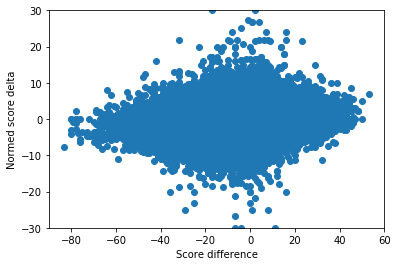

In [25]:
plt.scatter(result['scorediff'],result['normedscorediffdelta'])
plt.ylim([-30,30])
plt.xlabel('Score difference')
plt.ylabel('Normed score delta')
plt.show()


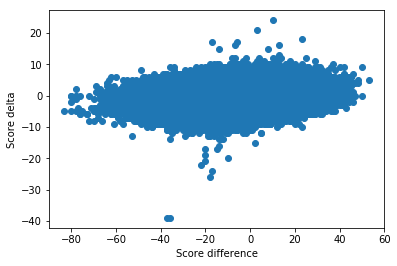

In [23]:
plt.scatter(result['scorediff'],result['scorediffdelta'])
#plt.ylim([100,100])
plt.xlabel('Score difference')
plt.ylabel('Score delta')
plt.show()

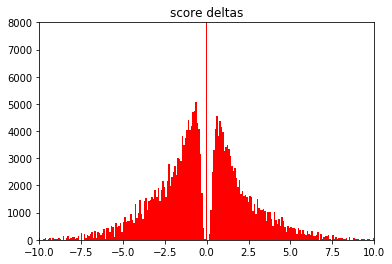

In [28]:
fig = plt.figure()
plt.ylim([0,8000])
plt.xlim([-10,10])
#plt.hist(test['delta1'],bins=20, label='team2')
#plt.hist(test['delta2'], bins=20, color='y', alpha= 0.5, label='team2')
plt.hist(result['normedscorediffdelta'], bins=5000, color='r', alpha=1, label='diff')
plt.title("score deltas")
plt.show() 

In [20]:
result.to_csv('run_calculation_diff2.csv', encoding='utf-8')

In [30]:
result.loc[(result.scorediffdelta > 11)]

rowid     gameid                                              event  \
43437    255220  270200151                Brandon Evans made Two Point Layup.   
51304    299695  270450213                 Ron Lewis made Three Point Jumper.   
87376    507106  280512633                 Quan Prowell made Two Point Layup.   
188903  1166376  303500142  Dominique Morrison made Three Point Jumper.  A...   
212260  1322728  310632460                Josh Jones made Three Point Jumper.   
230003  1442990  323160239                         Derrell Taylor made Layup.   
236600  1488668  330390172                         Johnathan Gray made Layup.   
255700  1616835  400502387  Aaron Craft made Layup. Assisted by Shannon Sc...   
259434  1642288  400504548                         Markel Starks made Jumper.   
274763  1746684  400497028  Luke Hancock made Three Point Jumper. Assisted...   
279332  1777756  400546034                      Charles McKinney made Jumper.   
292965  1870759  400596339                     Denzel Richardson made Jumper.   
293114  1871716  400588356  Duje Dukan made Three Point Jumper. Assisted b...   
307055  1966746  400587941                       Malcolm Brogdon made Jumper.   
308380  1975925  400593280  Kaleb Tarczewski made Dunk. Assisted by Gabe Y...   
340609  2189167  400845148  Aurimas Majauskas made Three Point Jumper. Ass...   
340610  2189177  400845148  Aurimas Majauskas made Layup. Assisted by Jali...   
341346  2193803  400813747  Isaac Haas made Jumper. Assisted by P.J. Thomp...   

        scorediff  time  timedelta  scorediffdelta  normedscorediffdelta  
43437          10   763      274.0            12.0              2.627737  
51304          25   136      220.0            12.0              3.272727  
87376         -14   141      154.0            15.0              5.844156  
188903         -7   823      167.0            12.0              4.311377  
212260          8   413      372.0            15.0              2.419355  
230003        -17   320      229.0            17.0              4.454148  
236600         13   285      488.0            13.0              1.598361  
255700         -7  1120       21.0            16.0             45.714286  
259434          4   151      116.0            12.0              6.206897  
274763         -2   268      160.0            12.0              4.500000  
279332         -8   515      590.0            12.0              1.220339  
292965         -6   781      113.0            17.0              9.026549  
293114         10   506      647.0            24.0              2.225657  
307055          3   293      570.0            21.0              2.210526  
308380         23   245      579.0            18.0              1.865285  
340609         12   419      164.0            12.0              4.390244  
340610         14   347      192.0            12.0              3.750000  
341346         13   210      861.0            16.0              1.114983

In [31]:
data.loc[(data.gameid == 270200151)]

rowid     gameid                                      event team1  \
43417  255017  270200151       Doneal Mack made Three Point Jumper.   MEM   
43418  255020  270200151       Andre Allen made Three Point Jumper.   MEM   
43419  255026  270200151      John Fields made Two Point Dunk Shot.   MEM   
43420  255030  270200151         Andre Allen made Two Point Jumper.   MEM   
43421  255033  270200151        Justin Ramsey made Two Point Layup.   MEM   
43422  255035  270200151       Jeremy Hunt made Three Point Jumper.   MEM   
43423  255043  270200151     James Dillard made Two Point Tip Shot.   MEM   
43424  255050  270200151         Andre Allen made Two Point Jumper.   MEM   
43425  255051  270200151          John Fields made Two Point Layup.   MEM   
43426  255056  270200151    James Dillard made Two Point Dunk Shot.   MEM   
43427  255096  270200151         John Fields made Two Point Jumper.   MEM   
43428  255131  270200151       Robert Dozier made Two Point Jumper.   MEM   
43429  255136  270200151       Taylor Gagnon made Two Point Jumper.   MEM   
43430  255145  270200151          John Fields made Two Point Layup.   MEM   
43431  255154  270200151      John Fields made Two Point Dunk Shot.   MEM   
43432  255166  270200151         Jeremy Hunt made Two Point Jumper.   MEM   
43433  255178  270200151        Gabe Blair made Two Point Tip Shot.   MEM   
43434  255179  270200151         Jeremy Hunt made Two Point Jumper.   MEM   
43435  255180  270200151  Courtney Captain made Three Point Jumper.   MEM   
43436  255192  270200151    Robert Dozier made Two Point Dunk Shot.   MEM   
43437  255220  270200151        Brandon Evans made Two Point Layup.   MEM   
43438  255221  270200151          Doneal Mack made Two Point Layup.   MEM   
43439  255226  270200151       Doneal Mack made Three Point Jumper.   MEM   
43440  255234  270200151         Jeremy Hunt made Two Point Jumper.   MEM   
43441  255259  270200151        Brandon Evans made Two Point Layup.   MEM   
43442  255262  270200151      Darrell Jenkins made Two Point Layup.   MEM   
43443  255269  270200151       Joey Dorsey made Two Point Tip Shot.   MEM   
43444  255294  270200151        Robert Dozier made Two Point Layup.   MEM   
43445  255298  270200151          Jeremy Hunt made Two Point Layup.   MEM   
43446  255301  270200151      Joey Dorsey made Two Point Dunk Shot.   MEM   
43447  255309  270200151      Joey Dorsey made Two Point Dunk Shot.   MEM   
43448  255310  270200151       Cory Farmer made Three Point Jumper.   MEM   
43449  255315  270200151       Taylor Gagnon made Two Point Jumper.   MEM   

      team2  score1  score2  time  
43417   ECU       3       0  1126  
43418   ECU       6       0  1075  
43419   ECU       6       2  1011  
43420   ECU       8       2   984  
43421   ECU       8       4   954  
43422   ECU      11       4   934  
43423   ECU      11       6   876  
43424   ECU      13       7   808  
43425   ECU      13       9   790  
43426   ECU      13      11   719  
43427   ECU      13      15   417  
43428   ECU      20      16   169  
43429   ECU      20      19   103  
43430   ECU      21      21     1  
43431   ECU      21      23  1159  
43432   ECU      23      23  1087  
43433   ECU      24      25  1065  
43434   ECU      26      25  1053  
43435   ECU      26      28  1037  
43436   ECU      33      28   990  
43437   ECU      40      30   763  
43438   ECU      42      30   755  
43439   ECU      46      30   748  
43440   ECU      48      30   672  
43441   ECU      49      34   533  
43442   ECU      49      36   498  
43443   ECU      51      36   441  
43444   ECU      54      37   277  
43445   ECU      56      37   176  
43446   ECU      58      37   144  
43447   ECU      61      37    78  
43448   ECU      61      40    61  
43449   ECU      62      42    20